In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [4]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis/notebooks')

In [5]:
import exoplanet as xo
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import pymc3 as pm

from exomast_api import exoMAST_API
from statsmodels.robust.scale import mad
from time import time
# from tqdm import tqdm_notebook as tqdm

from arctor import create_raw_lc_stddev, Arctor, run_multiple_pymc3#, setup_and_plot_GTC
from arctor.utils import setup_and_plot_GTC, compute_delta_sdnr
# from arctor.utils import fit_2D_time_vs_other

In [6]:
def debug_message(message, end='\n'):
    print(f'[DEBUG] {message}', end=end)


def warning_message(message, end='\n'):
    print(f'[WARNING] {message}', end=end)


def info_message(message, end='\n'):
    print(f'[INFO] {message}', end=end)

In [7]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [8]:
planet = Arctor(planet_name, data_dir, working_dir, file_type)
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
save_dir = f'{HOME}/Research/Planets/WASP43/savefiles'
joblib_filename = f'{save_dir}/{joblib_filename}'
planet.load_dict(joblib_filename)

[INFO] Initializing Instance of the `Arctor` Object


In [9]:
planet.photometry_df.columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_23x60', 'aperture_sum_24x60', 'aperture_sum_25x60',
       'aperture_sum_26x60', 'aperture_sum_27x60', 'aperture_sum_28x60',
       'aperture_sum_29x60', 'aperture_sum_30x60', 'xcenter', 'ycenter'],
      dtype='object', length=402)

In [10]:
if not hasattr(planet, 'photometry_df'):
    # planet.load_dict(joblib_filename)
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [11]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [12]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [13]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [14]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [15]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [16]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

In [17]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df[fine_min_snr_colname]
yerr = planet.normed_uncertainty_df[fine_min_snr_colname]

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [18]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 12 CPUs


In [19]:
wasp43 = exoMAST_API('WASP43b')
t0_wasp43 = wasp43.transit_time  # 55528.3684  # exo.mast.stsci.edu
period_wasp43 = wasp43.orbital_period
n_epochs = np.int(np.round(((np.median(times) - t0_wasp43) / period_wasp43)-0.5))
t0_guess = t0_wasp43 + (n_epochs+0.5) * period_wasp43

In [20]:
b_wasp43 = wasp43.impact_parameter # 0.66 # Hellier 2011
u = [0]
edepth = np.sqrt(500/1e6)

orbit_wasp43 = xo.orbits.KeplerianOrbit(period=period_wasp43, t0=t0_guess, b=b_wasp43)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=edepth, t=times).eval().flatten()

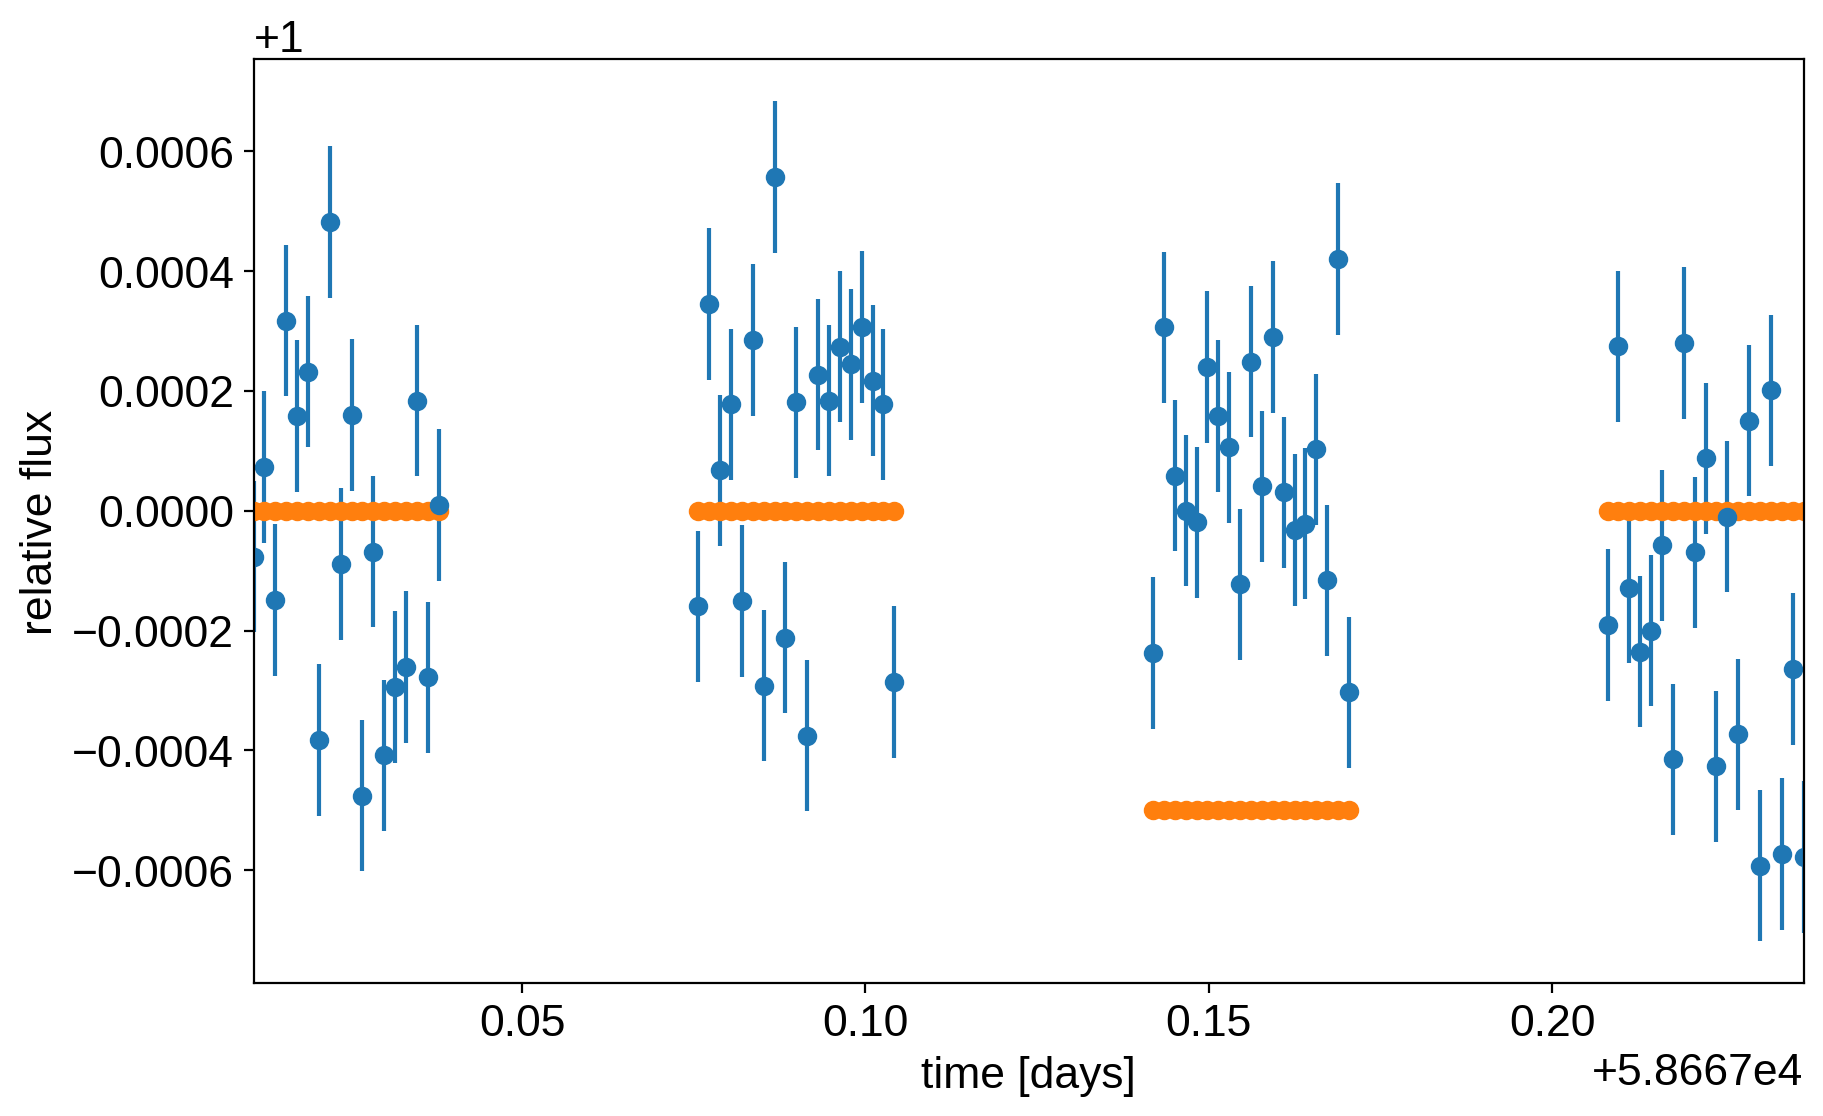

In [21]:
plt.rcParams['figure.figsize'] = (10,6)
plt.errorbar(times, flux, yerr, fmt='o')#  * (injected_light_curves+1)
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

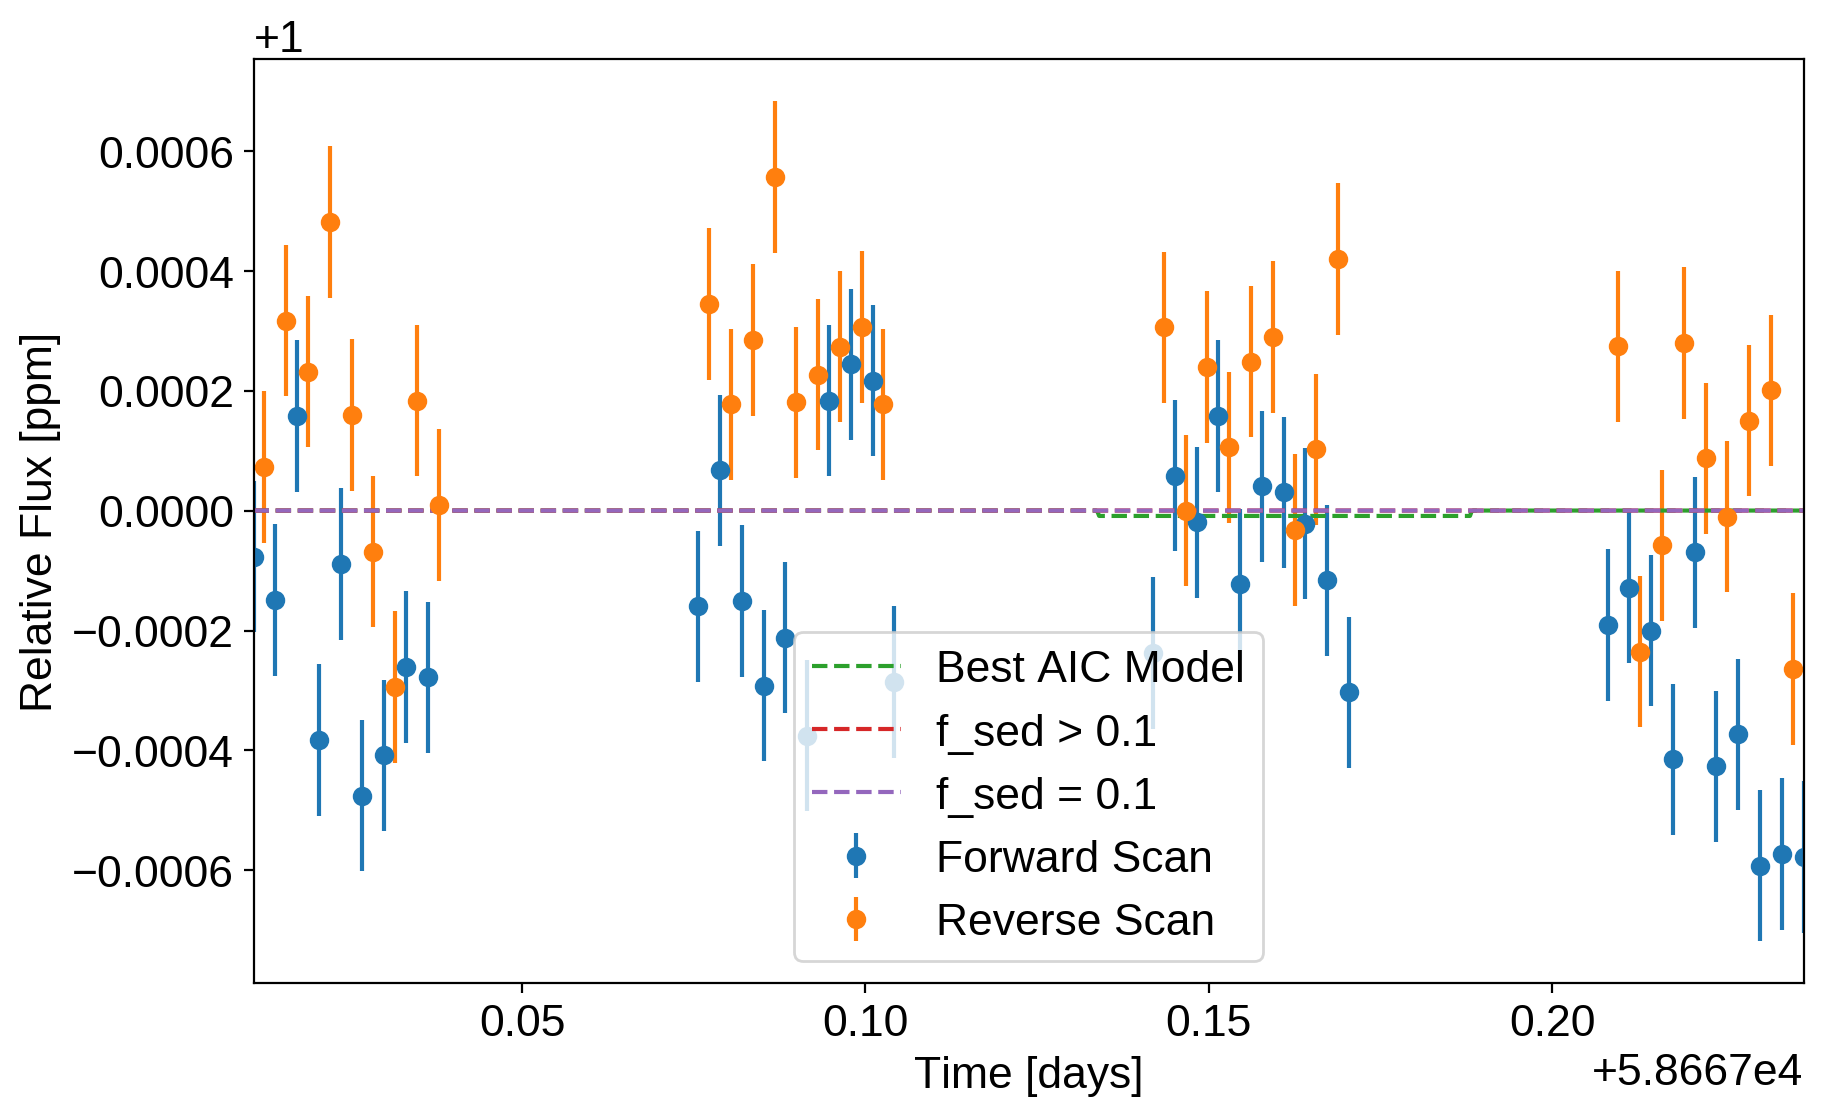

In [22]:
ppm = 1e6
times_th = np.linspace(times.min(), times.max(), 1000)
r_aic = np.sqrt(9/ppm)
r_model1 = 45/ppm
r_model2 = 100/ppm

injected_light_curve_aic = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=r_aic, t=times_th).eval().flatten()
injected_light_curve_mdl1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=r_model1, t=times_th).eval().flatten()
injected_light_curve_mdl2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=r_model2, t=times_th).eval().flatten()

plt.rcParams['figure.figsize'] = (10,6)

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', label='Forward Scan')
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', label='Reverse Scan')
plt.plot(times_th, injected_light_curve_aic+1, '--', label='Best AIC Model')
plt.plot(times_th, injected_light_curve_mdl1+1, '--', label='f_sed > 0.1')
plt.plot(times_th, injected_light_curve_mdl2+1, '--', label='f_sed = 0.1')
plt.ylabel("Relative Flux [ppm]")
plt.xlabel("Time [days]")
plt.xlim(times.min(), times.max())
plt.legend(loc=0);

# Run 400 MCMCs

In [23]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']
ycenters = planet.photometry_df['ycenter']
xcenters_mod = xcenters - np.median(xcenters)
ycenters_mod = ycenters - np.median(ycenters)
times_mod = times - t0_guess#np.median(times)

In [24]:
n_space = 2
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                       for aper_width_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_width)
                       for aper_height_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_height)]

In [25]:
near_best_apertures_NxN_small,len(near_best_apertures_NxN_small)

(['aperture_sum_19x49',
  'aperture_sum_19x50',
  'aperture_sum_19x51',
  'aperture_sum_20x49',
  'aperture_sum_20x50',
  'aperture_sum_20x51',
  'aperture_sum_21x49',
  'aperture_sum_21x50',
  'aperture_sum_21x51'],
 9)

# RUN ALL 12 IN ONE FUNCTION

# RUN ALL 12 MANUALLY

# Combine all 12 manually

# Testing new "all correlations and all flavors" MCMC

# HERE

In [26]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR')

In [27]:
for colname in planet.normed_photometry_df.columns:
    if 'center' in colname:
        print(colname)

xcenter
ycenter


In [28]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR')

In [29]:
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# Begin BIG GP Test

In [33]:
for aper_column in planet.normed_photometry_df.columns:  # near_best_apertures_NxN_small:  # [fine_min_snr_colname]:
    if 'center' in aper_column:
        continue

    save_name = f'{save_dir}/results_decor_span_MAPs_only_SDNR_w_GPs_{aper_column}.joblib.save'
    if os.path.exists(save_name):
        print(os.path.exists(save_name), save_name.split('/'))

True ['', 'home', 'jonathan', 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR', 'results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x41.joblib.save']
True ['', 'home', 'jonathan', 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR', 'results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x41.joblib.save']
True ['', 'home', 'jonathan', 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR', 'results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x41.joblib.save']
True ['', 'home', 'jonathan', 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR', 'results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x41.joblib.save']
True ['', 'home', 'jonathan', 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR', 'results_decor_span_MAPs_only_SDNR

In [34]:
from arctor.utils import run_pymc3_w_gp

tune = 3000
draws = 3000
target_accept = 0.9
do_mcmc = False
idx_fwd_ = None
idx_rev_ = None
use_log_edepth = False
allow_negative_edepths = False
use_pink_gp = True
normalize=True
verbose=True

xcenters_mod = planet.trace_xcenters - np.median(planet.trace_xcenters)
ycenters_mod = planet.trace_ycenters - np.median(planet.trace_ycenters)
trace_angles_mod = planet.trace_angles - np.median(planet.trace_angles)
trace_lengths_mod = planet.trace_lengths - np.median(planet.trace_lengths)
phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots = phots - np.median(phots)

# n_space = 10
# near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
#                                  for aper_width_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_width)
#                                  for aper_height_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_height)]
# # len(near_best_apertures_NxN_small)# near_best_apertures_NxN_small
# save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR')

decor_span_MAPs_only_list_all400 = []
startn1 = time()
for aper_column in planet.normed_photometry_df.columns:  # near_best_apertures_NxN_small:  # [fine_min_snr_colname]:
    if 'center' in aper_column:
        continue

    save_name = f'{save_dir}/results_decor_span_MAPs_only_SDNR_w_GPs_{aper_column}.joblib.save'
    if os.path.exists(save_name):
        if verbose:
            print(f'[INFO] File exists: {save_name}. Skipping')
        continue

    phots = planet.normed_photometry_df[aper_column].values
    uncs = planet.normed_uncertainty_df[aper_column].values
    save_state = {}
    save_state[aper_column] = []
    start0 = time()
    # Turned off to improve usage with GPs
    for xcenters_ in [None, xcenters_mod]:
        start2 = time()
        for ycenters_ in [None, ycenters_mod]:
            start3 = time()
            for trace_angles_ in [None, trace_angles_mod]:
                start4 = time()
                for trace_lengths_ in [None, trace_lengths_mod]:
                    start5 = time()
                    # Only set to True because the False case was created months ago
                    for use_pink_gp in [True]:  # [True, False]:
                        start6 = time()
                        fine_grain_mcmcs, map_soln = run_pymc3_w_gp(
                            times, phots, uncs,
                            t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
                            tune=tune, draws=draws, target_accept=target_accept,
                            xcenters=xcenters_,
                            ycenters=ycenters_,
                            trace_angles=trace_angles_,
                            trace_lengths=trace_lengths_,
                            do_mcmc=False,
                            use_pink_gp=use_pink_gp,
                            normalize=normalize,
                            verbose=verbose)

                        info_message(f'Full decorrelation took {(time() - start6)/60:0.2f} minutes')
                        res_std_ppm, phots_std_ppm, res_diff_ppm = compute_delta_sdnr(map_soln, phots, idx_fwd, idx_rev)

                        save_state_ = [idx_fwd_ is not None,
                                       idx_rev_ is not None,
                                       xcenters_ is not None,
                                       ycenters_ is not None,
                                       trace_angles_ is not None,
                                       trace_lengths_ is not None,
                                       use_pink_gp]

                        save_state_.extend([fine_grain_mcmcs, map_soln])
                        save_state_.extend([res_std_ppm, phots_std_ppm, res_diff_ppm])

                        save_state[aper_column].append(save_state_)
                        # decor_span_MAPs_only_list_all400.append(save_state)
                    info_message(f'Use Pink GP Option took {(time() - start5)/60:0.2f} minutes')
                info_message(f'Trace Length Option took {(time() - start4)/60:0.2f} minutes')
            info_message(f'Trace Angle Option took {(time() - start3)/60:0.2f} minutes')
        info_message(f'Ycenter Option took {(time() - start2)/60:0.2f} minutes')
    # info_message(f'Xcenter Option took {(time() - start1)/60:0.2f} minutes')
    info_message(f'Run through for {aper_column} took {(time() - start0)/60:0.2f} minutes')
    
    print(f'[INFO] Saving {aper_column} to {save_name}')
    joblib.dump(save_state, save_name)
    del save_state

info_message(f'Entire loop-d-loop took {(time() - startn1)/60:0.2f} minutes')

# joblib.dump(decor_span_MAPs_only_list_all400, f'{save_dir}/results_decor_span_MAPs_only_SDNR_all400.joblib.save')

[INFO] File exists: /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x41.joblib.save. Skipping
[INFO] File exists: /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x41.joblib.save. Skipping
[INFO] File exists: /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x41.joblib.save. Skipping
[INFO] File exists: /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x41.joblib.save. Skipping
[INFO] File exists: /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x41.joblib.save.

optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 182.55it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80512896.53138404 -> -1132331.6189723788


[INFO] Map Soln Edepth:4999.106730042308
[INFO] Full decorrelation took 0.34 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.30, 206.03, -2070.27 ppm difference
[INFO] Use Pink GP Option took 0.34 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
126it [00:00, 205.85it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80512897.9176784 -> -24405.605799941786


[INFO] Map Soln Edepth:4705.945276545011
[INFO] Full decorrelation took 0.06 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
40021.48, 206.03, -39815.44 ppm difference
[INFO] Use Pink GP Option took 0.06 minutes
[INFO] Trace Length Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
301it [00:00, 374.15it/s, logp=5.025904e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512897.9176784 -> 501.1800038144709


[INFO] Map Soln Edepth:64.44601043900524
[INFO] Full decorrelation took 0.06 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.35, 206.03, -9.31 ppm difference
[INFO] Use Pink GP Option took 0.06 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
162it [00:03, 53.10it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.68, 206.03, -2019.64 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.16 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
259it [00:00, 313.58it/s, logp=5.022915e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512897.9176784 -> 499.9446830966566


[INFO] Map Soln Edepth:42.97111067225133
[INFO] Full decorrelation took 0.06 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
185.95, 206.03, 20.08 ppm difference
[INFO] Use Pink GP Option took 0.06 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
464it [00:01, 461.58it/s, logp=5.182776e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> 517.9090678739158


[INFO] Map Soln Edepth:38.40780779942165
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
203.81, 206.03, 2.22 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
260it [00:00, 316.94it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> 491.94060461815417


[INFO] Map Soln Edepth:32.77222297417198
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.57, 206.03, 12.46 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
171it [00:00, 204.18it/s, logp=5.110130e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512900.69026712 -> 511.0325506456609


[INFO] Map Soln Edepth:38.715921432242965
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
194.98, 206.03, 11.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.41 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 337.47it/s, logp=-7.055992e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80512897.9176784 -> -70.55633370521582


[INFO] Map Soln Edepth:3945.886625939376
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
109216.04, 206.03, -109010.01 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
100it [00:00, 163.77it/s, logp=-1.024977e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> -121.1906986951374


[INFO] Map Soln Edepth:5214.037052092532
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
90903.02, 206.03, -90696.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 198.94it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> -5946.495303833918


[INFO] Map Soln Edepth:4550.866270878573
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112523.47, 206.03, -112317.44 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
259it [00:00, 314.01it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80512900.69026712 -> 513.4618530312457


[INFO] Map Soln Edepth:24.336140914393408
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.70, 206.03, 23.33 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
206it [00:02, 74.46it/s, logp=5.245774e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80512899.30397275 -> 524.76154389609


[INFO] Map Soln Edepth:28.6078176116521
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.06, 206.03, 18.97 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 250.57it/s, logp=4.032578e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80512900.69026712 -> 522.9072693078837


[INFO] Map Soln Edepth:23.235640460806096
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.11, 206.03, 32.92 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
78it [00:00, 130.80it/s, logp=5.180197e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80512900.69026712 -> 514.3665241311148


[INFO] Map Soln Edepth:23.371678334641356
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
174.72, 206.03, 31.31 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 267.14it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80512902.07656148 -> -779.0580518982581


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1426519.04, 206.03, -1426313.00 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.97 minutes
[INFO] Run through for aperture_sum_17x53 took 1.93 minutes
[INFO] Saving aperture_sum_17x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
328it [00:00, 366.23it/s, logp=5.015847e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580524.6248805 -> 501.58400029684765


[INFO] Map Soln Edepth:25.155204572905074
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
203.77, 205.95, 2.18 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
26it [00:00, 43.80it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80580526.01117486 -> -6389.32309200222


[INFO] Map Soln Edepth:4624.816719639275
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46803.35, 205.95, -46597.39 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
149it [00:00, 230.20it/s, logp=4.927278e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80580526.01117486 -> 492.7308463381378


[INFO] Map Soln Edepth:41.0106092424831
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.28, 205.95, -3.33 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
233it [00:00, 274.03it/s, logp=5.150661e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> 516.3309483077137


[INFO] Map Soln Edepth:33.68179352513039
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.68, 205.95, -6.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
178it [00:00, 261.92it/s, logp=4.956625e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80580526.01117486 -> 495.7112940264332


[INFO] Map Soln Edepth:69.70913826296902
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.22, 205.95, 10.73 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
324it [00:00, 390.50it/s, logp=5.201115e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> 519.818175380836


[INFO] Map Soln Edepth:83.10545870732975
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.64, 205.95, 6.32 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
174it [00:00, 257.09it/s, logp=4.931536e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> 493.1591491816783


[INFO] Map Soln Edepth:71.08955809402298
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.30, 205.95, 7.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 277.59it/s, logp=5.142569e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580528.78376357 -> 513.5771894440387


[INFO] Map Soln Edepth:44.25011755550611
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.81, 205.95, 8.15 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.88 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
197it [00:03, 63.53it/s, logp=-9.101813e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80580526.01117486 -> -92.86459321405995


[INFO] Map Soln Edepth:4614.187821927428
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
80564.40, 205.95, -80358.45 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
286it [00:00, 357.28it/s, logp=4.661767e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> 461.82798489259596


[INFO] Map Soln Edepth:219.94897418571628
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
295.88, 205.95, -89.92 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 197.89it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> -5814.662541508561


[INFO] Map Soln Edepth:4549.061748074811
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112793.59, 205.95, -112587.63 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
176it [00:00, 246.46it/s, logp=5.200877e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80580528.78376357 -> 515.8047122082241


[INFO] Map Soln Edepth:29.231043235489643
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.69, 205.95, 25.26 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 269.99it/s, logp=5.231808e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80580527.39746921 -> 523.1825380424988


[INFO] Map Soln Edepth:20.76150483510143
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.17, 205.95, 21.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 272.67it/s, logp=5.262562e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80580528.78376357 -> 522.8573647800087


[INFO] Map Soln Edepth:28.868146600977397
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.29, 205.95, 32.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
164it [00:00, 241.25it/s, logp=5.213328e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80580528.78376357 -> 519.4410530667717


[INFO] Map Soln Edepth:6.8809772223488945
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
187.99, 205.95, 17.96 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 184.63it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80580530.17005794 -> -781.2686236253724


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1427189.79, 205.95, -1426983.84 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_18x53 took 1.87 minutes
[INFO] Saving aperture_sum_18x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 180.55it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80411773.94463357 -> -1130921.9171454292


[INFO] Map Soln Edepth:4999.106775646937
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.42, 205.94, -2070.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
147it [00:00, 198.16it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80411775.33092794 -> -378.5193518087306


[INFO] Map Soln Edepth:9986.760534617617
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
125635.96, 205.94, -125430.01 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
196it [00:00, 284.98it/s, logp=4.968228e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80411775.33092794 -> 493.78706855648034


[INFO] Map Soln Edepth:50.28480116086318
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.41, 205.94, -4.47 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 198.04it/s, logp=5.061968e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 506.20389356070075


[INFO] Map Soln Edepth:18.706470345589295
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.20, 205.94, -0.26 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
130it [00:00, 209.11it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80411775.33092794 -> 491.091144094398


[INFO] Map Soln Edepth:34.98590088923125
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
184.94, 205.94, 21.00 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
136it [00:00, 210.90it/s, logp=5.103069e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 505.3429125935156


[INFO] Map Soln Edepth:26.676608263496938
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.28, 205.94, 14.67 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
284it [00:00, 348.88it/s, logp=5.006141e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 500.6218931064163


[INFO] Map Soln Edepth:59.886656110114345
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.30, 205.94, 12.64 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
233it [00:00, 268.17it/s, logp=5.130780e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80411778.10351665 -> 512.3120376478929


[INFO] Map Soln Edepth:26.702074394748607
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.97, 205.94, 6.98 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 300.39it/s, logp=-1.512756e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80411775.33092794 -> -151.10158272373758


[INFO] Map Soln Edepth:3.3802047742832535e-15
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
97981.21, 205.94, -97775.26 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
290it [00:00, 373.04it/s, logp=1.670421e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 167.11465531241637


[INFO] Map Soln Edepth:2126.37973632221
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
3822.85, 205.94, -3616.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
355it [00:00, 409.54it/s, logp=2.692567e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 269.3465238890427


[INFO] Map Soln Edepth:1830.2655238254379
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
1218.52, 205.94, -1012.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 263.80it/s, logp=5.163104e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80411778.10351665 -> 516.3147295747077


[INFO] Map Soln Edepth:23.60314394377324
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.89, 205.94, 26.06 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 276.20it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80411776.7172223 -> 523.9434732477405


[INFO] Map Soln Edepth:15.864693000779662
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.02, 205.94, 24.92 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 275.77it/s, logp=5.260630e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80411778.10351665 -> 526.2596917622008


[INFO] Map Soln Edepth:18.5114905912823
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.63, 205.94, 32.31 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
230it [00:00, 293.52it/s, logp=5.245980e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80411778.10351665 -> 523.7779345275402


[INFO] Map Soln Edepth:12.447533666030926
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.10, 205.94, 26.84 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 178.42it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80411779.48981102 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.78, 205.94, -2019.84 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.97 minutes
[INFO] Run through for aperture_sum_19x53 took 1.86 minutes
[INFO] Saving aperture_sum_19x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 174.67it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80475136.94303942 -> -1131811.5109033934


[INFO] Map Soln Edepth:4999.106751024383
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.40, 205.91, -2070.49 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
146it [00:00, 204.73it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80475138.32933378 -> -333.1615589930915


[INFO] Map Soln Edepth:9999.676345551308
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
107042.31, 205.91, -106836.40 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
209it [00:00, 300.60it/s, logp=4.987890e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475138.32933378 -> 495.5908549506506


[INFO] Map Soln Edepth:68.05768247759848
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.42, 205.91, -8.51 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
164it [00:00, 213.03it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.77, 205.91, -2019.86 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
297it [00:00, 379.55it/s, logp=5.023865e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475138.32933378 -> 502.47541220803635


[INFO] Map Soln Edepth:55.097429783203246
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.60, 205.91, 14.31 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 221.60it/s, logp=5.090577e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> 507.5952281162974


[INFO] Map Soln Edepth:33.90549182114819
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.24, 205.91, 13.67 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
152it [00:00, 221.50it/s, logp=4.934468e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> 491.63811325195644


[INFO] Map Soln Edepth:39.809720567149185
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.58, 205.91, 15.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
267it [00:00, 301.49it/s, logp=5.143051e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475141.10192251 -> 514.129570012523


[INFO] Map Soln Edepth:52.803298877976516
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.66, 205.91, 9.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 263.65it/s, logp=-1.110877e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475138.32933378 -> -113.46496405427114


[INFO] Map Soln Edepth:704.2787822137732
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
107089.11, 205.91, -106883.20 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
113it [00:00, 179.55it/s, logp=1.004468e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> 45.31656696245314


[INFO] Map Soln Edepth:6600.244055847522
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
39401.11, 205.91, -39195.20 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.92it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> -6055.711983124407


[INFO] Map Soln Edepth:4552.2889424527575
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112309.84, 205.91, -112103.94 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
255it [00:00, 330.54it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80475141.10192251 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.77, 205.91, -2019.86 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 272.44it/s, logp=5.251760e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475139.71562815 -> 525.0920666988492


[INFO] Map Soln Edepth:21.413436957399583
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.44, 205.91, 30.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 252.25it/s, logp=5.257866e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475141.10192251 -> 522.7470763113135


[INFO] Map Soln Edepth:25.85837862799492
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.01, 205.91, 29.89 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 129.85it/s, logp=5.143288e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80475141.10192251 -> 512.1229564422806


[INFO] Map Soln Edepth:5.226527810394568
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
172.92, 205.91, 32.99 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 184.61it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80475142.48821686 -> -777.7013271791363


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1426082.85, 205.91, -1425876.94 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.97 minutes
[INFO] Run through for aperture_sum_20x53 took 1.87 minutes
[INFO] Saving aperture_sum_20x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.76it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80259645.54956907 -> -1128795.910988215


[INFO] Map Soln Edepth:4999.106841487021
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.54, 206.02, -2070.52 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
272it [00:00, 323.01it/s, logp=5.108484e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80259646.93586344 -> 510.8527279420106


[INFO] Map Soln Edepth:40.455975505679895
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
215.03, 206.02, -9.01 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
223it [00:00, 313.81it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80259646.93586344 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
2225.91, 206.02, -2019.89 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
196it [00:00, 240.99it/s, logp=5.168205e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> 509.4541744930045


[INFO] Map Soln Edepth:19.366537849555005
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.74, 206.02, -3.73 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
208it [00:00, 300.58it/s, logp=4.965300e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259646.93586344 -> 493.04604019709905


[INFO] Map Soln Edepth:28.195271951848365
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
186.02, 206.02, 19.99 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
292it [00:00, 361.16it/s, logp=5.176753e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> 514.2695829746611


[INFO] Map Soln Edepth:31.552954610711474
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.61, 206.02, 10.40 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 281.75it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.91, 206.02, -2019.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 229.87it/s, logp=5.080890e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259649.70845215 -> 508.1952378562678


[INFO] Map Soln Edepth:50.33733711610471
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
190.53, 206.02, 15.48 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
281it [00:00, 362.46it/s, logp=5.169135e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80259646.93586344 -> 516.9152741321778


[INFO] Map Soln Edepth:20.562675761950516
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
182.67, 206.02, 23.35 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 278.39it/s, logp=-1.124888e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> -112.37572234706134


[INFO] Map Soln Edepth:9997.58616987818
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
83543.79, 206.02, -83337.78 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 136.01it/s, logp=-1.844006e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> -187.9448665593735


[INFO] Map Soln Edepth:4708.950696670892
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
364207.78, 206.02, -364001.77 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
348it [00:00, 408.37it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80259649.70845215 -> 525.5024699230595


[INFO] Map Soln Edepth:35.32236476495433
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.45, 206.02, 22.57 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
186it [00:00, 272.67it/s, logp=5.257034e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259648.32215779 -> 524.0265653840038


[INFO] Map Soln Edepth:18.275166396048824
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.41, 206.02, 21.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 287.05it/s, logp=5.240877e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259649.70845215 -> 523.6354508290738


[INFO] Map Soln Edepth:21.369067500529564
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.91, 206.02, 29.11 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
205it [00:00, 283.37it/s, logp=5.231157e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80259649.70845215 -> 523.0896305340435


[INFO] Map Soln Edepth:26.030131239207005
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.24, 206.02, 28.78 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 269.82it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80259651.09474652 -> -770.4665267625383


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1423840.95, 206.02, -1423634.94 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.97 minutes
[INFO] Run through for aperture_sum_21x53 took 1.86 minutes
[INFO] Saving aperture_sum_21x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 179.50it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80204391.1912544 -> -1128022.405785789


[INFO] Map Soln Edepth:4999.10686547643
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.59, 206.16, -2070.43 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
43it [00:00, 69.76it/s, logp=-1.560641e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80204392.57754877 -> -183.09875541951533


[INFO] Map Soln Edepth:1313.301198422397
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
90804.47, 206.16, -90598.31 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
282it [00:00, 360.22it/s, logp=5.038131e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80204392.57754877 -> 503.65263342473395


[INFO] Map Soln Edepth:56.275916521609886
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.29, 206.16, -6.13 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
313it [00:00, 337.32it/s, logp=5.189005e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> 517.1218486802863


[INFO] Map Soln Edepth:43.785260226957405
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.95, 206.16, -4.79 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
156it [00:00, 237.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80204392.57754877 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
2225.97, 206.16, -2019.81 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
368it [00:00, 416.27it/s, logp=5.195271e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> 519.6027169601566


[INFO] Map Soln Edepth:40.96917866197782
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.62, 206.16, 6.54 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
235it [00:00, 322.35it/s, logp=4.992327e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> 496.56958736883934


[INFO] Map Soln Edepth:38.895444202782414
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.02, 206.16, 9.14 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
165it [00:00, 210.75it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80204395.3501375 -> 508.4287279126007


[INFO] Map Soln Edepth:41.01652969617426
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
244.75, 206.16, -38.59 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.88 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 297.59it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80204392.57754877 -> -127.74957358666795


[INFO] Map Soln Edepth:2583.4740525666084
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
90553.00, 206.16, -90346.84 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
182it [00:00, 267.97it/s, logp=-1.007692e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> -102.67854263792302


[INFO] Map Soln Edepth:5324.783582629497
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80017.77, 206.16, -79811.61 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.82it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> -6680.294806957749


[INFO] Map Soln Edepth:4560.075566203802
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111141.79, 206.16, -110935.63 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
289it [00:00, 359.06it/s, logp=5.270558e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204395.3501375 -> 523.5358126698604


[INFO] Map Soln Edepth:45.26305070297602
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.04, 206.16, 23.12 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
68it [00:00, 118.82it/s, logp=5.177502e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204393.96384314 -> 514.4389979525413


[INFO] Map Soln Edepth:4.3420501685671065
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
174.08, 206.16, 32.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 257.90it/s, logp=5.220500e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204395.3501375 -> 525.5360019610476


[INFO] Map Soln Edepth:23.67797629602995
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.07, 206.16, 29.09 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
122it [00:00, 188.26it/s, logp=5.177369e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204395.3501375 -> 518.0140313682361


[INFO] Map Soln Edepth:18.465722638246497
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.64, 206.16, 14.52 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 188.10it/s, logp=-6.557343e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80204396.73643185 -> -65.56507273487341


[INFO] Map Soln Edepth:0.05438292303342874
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
193427.42, 206.16, -193221.26 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_22x53 took 1.86 minutes
[INFO] Saving aperture_sum_22x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 176.20it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80000533.22711936 -> -1125164.9003467583


[INFO] Map Soln Edepth:4999.106950385739
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.74, 206.21, -2070.53 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
371it [00:00, 400.05it/s, logp=4.650431e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80000534.61341372 -> 464.9303911618141


[INFO] Map Soln Edepth:340.9236499973102
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
316.90, 206.21, -110.69 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
174it [00:00, 264.45it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80000534.61341372 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
2226.11, 206.21, -2019.90 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
213it [00:00, 264.58it/s, logp=5.135719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> 511.3147036253184


[INFO] Map Soln Edepth:38.34645102964024
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.42, 206.21, -4.21 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 234.30it/s, logp=4.940980e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000534.61341372 -> 492.1158992302792


[INFO] Map Soln Edepth:47.07140724209329
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.06, 206.21, 17.15 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 241.12it/s, logp=5.081081e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> 508.6287596120979


[INFO] Map Soln Edepth:31.95354101260525
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.36, 206.21, 12.85 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 297.99it/s, logp=4.951245e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> 495.12580886799464


[INFO] Map Soln Edepth:62.240943621202256
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.15, 206.21, 5.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
221it [00:00, 263.89it/s, logp=5.099943e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000537.38600245 -> 510.0004380616339


[INFO] Map Soln Edepth:14.124293755181435
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.31, 206.21, 10.90 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 237.11it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80000534.61341372 -> -203.94925171288412


[INFO] Map Soln Edepth:5293.866575885922
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128737.75, 206.21, -128531.54 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 259.12it/s, logp=-9.173243e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> -91.72957530448454


[INFO] Map Soln Edepth:0.00014690970865719236
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
48777.96, 206.21, -48571.75 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 51.67it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> -7179.211064627827


[INFO] Map Soln Edepth:4565.762651573604
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110285.52, 206.21, -110079.31 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
293it [00:00, 358.98it/s, logp=5.265540e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000537.38600245 -> 525.379372336186


[INFO] Map Soln Edepth:29.031021582955923
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
189.17, 206.21, 17.04 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 160.08it/s, logp=5.173108e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80000535.99970809 -> 517.3225953437702


[INFO] Map Soln Edepth:17.064003928397256
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.10, 206.21, 29.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 272.98it/s, logp=5.254254e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80000537.38600245 -> 525.4339225772342


[INFO] Map Soln Edepth:28.927191363996535
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.09, 206.21, 29.12 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 296.46it/s, logp=5.239961e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80000537.38600245 -> 522.9082283998803


[INFO] Map Soln Edepth:26.92881306332238
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
174.77, 206.21, 31.44 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 278.09it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80000538.7722968 -> -761.2924599424565


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1420836.88, 206.21, -1420630.67 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_23x53 took 1.86 minutes
[INFO] Saving aperture_sum_23x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.62it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80017295.9174416 -> -1125399.5317919757


[INFO] Map Soln Edepth:4999.10694477801
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.70, 206.13, -2070.57 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
113it [00:00, 164.41it/s, logp=-1.074640e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80017297.30373597 -> -111.02573255194471


[INFO] Map Soln Edepth:4907.963593530788
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
86996.14, 206.13, -86790.01 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
156it [00:00, 241.63it/s, logp=4.933241e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017297.30373597 -> 493.32808593171416


[INFO] Map Soln Edepth:87.20344067586431
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.82, 206.13, -10.70 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
372it [00:00, 387.84it/s, logp=5.179074e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> 516.5824360901802


[INFO] Map Soln Edepth:46.318485744404626
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.81, 206.13, -5.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
143it [00:00, 228.76it/s, logp=4.933616e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017297.30373597 -> 492.1546644555222


[INFO] Map Soln Edepth:44.07073009522976
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.09, 206.13, 19.04 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
248it [00:00, 335.53it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> 505.989777779806


[INFO] Map Soln Edepth:34.83298015069327
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.10, 206.13, 13.03 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
211it [00:00, 286.91it/s, logp=4.969234e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> 496.9489315660427


[INFO] Map Soln Edepth:59.60923083704746
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.01, 206.13, 7.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
152it [00:00, 197.82it/s, logp=5.044519e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017300.07632469 -> 504.4518822111232


[INFO] Map Soln Edepth:26.519237382897177
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.24, 206.13, 9.89 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 228.88it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80017297.30373597 -> -203.52877639176023


[INFO] Map Soln Edepth:7858.911760321152
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132728.06, 206.13, -132521.93 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
180it [00:00, 255.25it/s, logp=-1.056609e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> -105.66054730816208


[INFO] Map Soln Edepth:850.8936787272497
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
53600.93, 206.13, -53394.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.84it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> -7145.031247505478


[INFO] Map Soln Edepth:4565.384405932384
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110339.54, 206.13, -110133.42 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
183it [00:00, 262.53it/s, logp=5.180552e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80017300.07632469 -> 518.1235125898852


[INFO] Map Soln Edepth:26.84095435172894
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.39, 206.13, 25.74 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
258it [00:00, 332.27it/s, logp=5.258418e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80017298.69003032 -> 525.7818839475979


[INFO] Map Soln Edepth:30.53526863433215
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.55, 206.13, 22.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 267.61it/s, logp=5.256348e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80017300.07632469 -> 524.0063371562087


[INFO] Map Soln Edepth:33.4153194323005
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.19, 206.13, 27.94 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 271.51it/s, logp=5.251312e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80017300.07632469 -> 524.367601218451


[INFO] Map Soln Edepth:20.419872510747545
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.90, 206.13, 29.23 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 275.43it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80017301.46261905 -> -761.7358739458225


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1420922.44, 206.13, -1420716.31 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_24x53 took 1.86 minutes
[INFO] Saving aperture_sum_24x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
142it [00:00, 208.40it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79893515.08076835 -> 490.21928945888766


[INFO] Map Soln Edepth:12.686189060406043
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
202.41, 206.11, 3.70 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
152it [00:00, 204.68it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79893516.46706271 -> -183.94786872936294


[INFO] Map Soln Edepth:5133.915608960915
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75128.85, 206.11, -74922.74 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
290it [00:00, 382.08it/s, logp=5.021691e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893516.46706271 -> 498.77447639077616


[INFO] Map Soln Edepth:65.6171585224941
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.32, 206.11, -8.21 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
324it [00:00, 358.18it/s, logp=5.179715e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> 515.6710630247924


[INFO] Map Soln Edepth:52.20558762954777
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
217.94, 206.11, -11.83 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 231.45it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79893516.46706271 -> 491.56999772271797


[INFO] Map Soln Edepth:51.58539992319753
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.83, 206.11, 17.29 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
175it [00:00, 255.81it/s, logp=5.085614e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> 508.56698014692375


[INFO] Map Soln Edepth:39.33338049330362
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.66, 206.11, 12.45 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
229it [00:00, 305.67it/s, logp=4.923452e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> 492.3453270877819


[INFO] Map Soln Edepth:36.784609311730165
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
188.73, 206.11, 17.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 191.32it/s, logp=5.067303e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79893519.23965144 -> 504.8580753697131


[INFO] Map Soln Edepth:26.770965864512302
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.15, 206.11, 10.96 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
119it [00:00, 196.69it/s, logp=-1.996470e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893516.46706271 -> -199.6331804747144


[INFO] Map Soln Edepth:4207.250906020451
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131519.96, 206.11, -131313.85 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 266.08it/s, logp=-1.030609e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> -102.93699346445982


[INFO] Map Soln Edepth:4409.320688658184
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46458.54, 206.11, -46252.43 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.53it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> -7463.023755158668


[INFO] Map Soln Edepth:4568.817662944936
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109816.79, 206.11, -109610.68 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
192it [00:00, 271.20it/s, logp=5.150563e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893519.23965144 -> 515.0568647063182


[INFO] Map Soln Edepth:17.551669175489042
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.35, 206.11, 26.76 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
87it [00:00, 146.20it/s, logp=5.175028e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893517.85335708 -> 515.4286510693191


[INFO] Map Soln Edepth:17.487621209269413
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.17, 206.11, 27.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 260.54it/s, logp=5.252525e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79893519.23965144 -> 523.3294312545363


[INFO] Map Soln Edepth:13.243777497636186
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.80, 206.11, 27.31 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
314it [00:00, 366.34it/s, logp=5.235038e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79893519.23965144 -> 523.5162034122374


[INFO] Map Soln Edepth:21.72717026665347
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.61, 206.11, 29.50 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 270.00it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79893520.62594579 -> -757.5375071375041


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1419567.45, 206.11, -1419361.34 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.97 minutes
[INFO] Run through for aperture_sum_25x53 took 1.86 minutes
[INFO] Saving aperture_sum_25x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.90it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79901984.88249981 -> -1123794.219751986


[INFO] Map Soln Edepth:4999.106995691437
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.77, 206.14, -2070.62 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
239it [00:03, 77.71it/s, logp=6.911017e+01]   
message: Desired error not necessarily achieved due to precision loss.
logp: -79901986.26879418 -> 68.37704855877323


[INFO] Map Soln Edepth:9007.018926969755
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
77323.90, 206.14, -77117.75 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
301it [00:00, 385.82it/s, logp=5.020158e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901986.26879418 -> 502.0342140849886


[INFO] Map Soln Edepth:45.49678159861276
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.41, 206.14, -7.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
301it [00:00, 333.50it/s, logp=5.166346e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> 516.639541952583


[INFO] Map Soln Edepth:48.33594902799552
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.11, 206.14, -5.97 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 231.57it/s, logp=4.953867e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901986.26879418 -> 491.5646296440802


[INFO] Map Soln Edepth:51.55305340802568
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.86, 206.14, 17.29 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
170it [00:00, 248.37it/s, logp=5.082513e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> 508.2661629949443


[INFO] Map Soln Edepth:32.19047451591662
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.40, 206.14, 12.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
260it [00:00, 339.33it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> 491.5634766985807


[INFO] Map Soln Edepth:39.502363746499995
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.88, 206.14, 14.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
252it [00:00, 277.15it/s, logp=5.136549e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79901989.0413829 -> 511.42936435872105


[INFO] Map Soln Edepth:26.05199221555844
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.81, 206.14, 10.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
149it [00:00, 232.08it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79901986.26879418 -> -204.34296127940362


[INFO] Map Soln Edepth:4865.396143308049
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128554.54, 206.14, -128348.40 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 275.66it/s, logp=-1.038868e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> -103.86532816199491


[INFO] Map Soln Edepth:4674.625622536344
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80508.33, 206.14, -80302.19 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
117it [00:00, 189.42it/s, logp=-1.866435e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> -186.63859247904193


[INFO] Map Soln Edepth:8870.550771892984
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
366821.71, 206.14, -366615.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
313it [00:00, 365.87it/s, logp=5.267752e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79901989.0413829 -> 526.8130395691918


[INFO] Map Soln Edepth:32.886387475732676
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
192.52, 206.14, 13.62 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
133it [00:00, 210.49it/s, logp=5.201294e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901987.65508853 -> 520.1322747894866


[INFO] Map Soln Edepth:34.1259592628191
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.67, 206.14, 30.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
89it [00:00, 145.29it/s, logp=5.169232e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79901989.0413829 -> 514.6380329281367


[INFO] Map Soln Edepth:21.628798380888814
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.90, 206.14, 32.25 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
83it [00:00, 134.21it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79901989.0413829 -> 513.127003010171


[INFO] Map Soln Edepth:57.66784651503758
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
188.25, 206.14, 17.90 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 178.11it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79901990.42767726 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2226.16, 206.14, -2020.01 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_26x53 took 1.88 minutes
[INFO] Saving aperture_sum_26x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 176.50it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79775618.48738304 -> -1122030.644704455


[INFO] Map Soln Edepth:4999.107049873508
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.81, 206.18, -2070.63 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
171it [00:02, 58.72it/s, logp=-1.049569e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79775619.87367739 -> -104.9902613069651


[INFO] Map Soln Edepth:5873.446900210803
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
47583.77, 206.18, -47377.58 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
260it [00:00, 354.27it/s, logp=4.987584e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775619.87367739 -> 498.7649161294688


[INFO] Map Soln Edepth:71.1027462549852
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.82, 206.18, -9.64 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
319it [00:00, 352.24it/s, logp=5.168071e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> 515.4966651953846


[INFO] Map Soln Edepth:49.70865527037694
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.29, 206.18, -6.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 267.23it/s, logp=4.942088e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775619.87367739 -> 494.2110299990318


[INFO] Map Soln Edepth:39.1483571217481
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
185.87, 206.18, 20.31 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 292.53it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2226.21, 206.18, -2020.02 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
317it [00:00, 372.67it/s, logp=5.026264e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> 502.6271240576954


[INFO] Map Soln Edepth:73.77634950236703
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.28, 206.18, 9.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
120it [00:00, 155.71it/s, logp=5.048964e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79775622.64626612 -> 504.8971602673797


[INFO] Map Soln Edepth:49.643447538195176
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.22, 206.18, 7.96 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 234.61it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79775619.87367739 -> -204.01161280429966


[INFO] Map Soln Edepth:5206.577940282583
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129521.35, 206.18, -129315.17 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
177it [00:00, 262.60it/s, logp=-1.043313e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> -104.3367511644859


[INFO] Map Soln Edepth:4341.593096538864
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
52251.77, 206.18, -52045.58 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
48it [00:00, 86.72it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> -207.77823532417307


[INFO] Map Soln Edepth:257.04981129753077
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
421540.31, 206.18, -421334.13 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 244.33it/s, logp=5.169935e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79775622.64626612 -> 516.9937743002683


[INFO] Map Soln Edepth:22.7687096536928
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.93, 206.18, 26.26 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
159it [00:00, 239.38it/s, logp=5.251157e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79775621.25997175 -> 521.8117405306878


[INFO] Map Soln Edepth:39.02393399732442
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.17, 206.18, 22.01 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
245it [00:00, 314.36it/s, logp=5.261419e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79775622.64626612 -> 526.1709157024759


[INFO] Map Soln Edepth:34.133101625124766
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.47, 206.18, 26.72 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 281.06it/s, logp=5.246272e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79775622.64626612 -> 523.8102049428621


[INFO] Map Soln Edepth:11.535396636459737
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.92, 206.18, 26.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:03, 48.47it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79775624.03256048 -> -348.0040761906524


[INFO] Map Soln Edepth:25.684136058803155
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1328906.39, 206.18, -1328700.21 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_27x53 took 1.87 minutes
[INFO] Saving aperture_sum_27x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 174.80it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79767730.92842573 -> -1121916.798181908


[INFO] Map Soln Edepth:4999.107054630767
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.70, 206.22, -2070.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
89it [00:00, 132.34it/s, logp=-1.341222e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79767732.3147201 -> -140.32418445399162


[INFO] Map Soln Edepth:5499.611561651838
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
48064.62, 206.22, -47858.41 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
159it [00:00, 245.85it/s, logp=4.930980e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767732.3147201 -> 493.0987942037914


[INFO] Map Soln Edepth:70.65727830485204
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.28, 206.22, -9.06 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
327it [00:00, 346.14it/s, logp=5.166180e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> 516.6198593585299


[INFO] Map Soln Edepth:38.52462036569281
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.59, 206.22, -2.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
309it [00:00, 391.10it/s, logp=5.016473e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767732.3147201 -> 501.66224408585896


[INFO] Map Soln Edepth:35.48302773073949
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
186.38, 206.22, 19.83 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 238.55it/s, logp=5.081129e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> 508.1516260177401


[INFO] Map Soln Edepth:40.90012284663805
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.42, 206.22, 12.79 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
265it [00:00, 333.90it/s, logp=4.952102e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> 491.29726038759253


[INFO] Map Soln Edepth:40.985765968770124
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.40, 206.22, 12.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
105it [00:00, 143.94it/s, logp=5.057601e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767735.08730882 -> 504.0232834317245


[INFO] Map Soln Edepth:38.341516388397714
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.54, 206.22, 10.68 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
261it [00:00, 355.48it/s, logp=-1.099711e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767732.3147201 -> -109.96699714789368


[INFO] Map Soln Edepth:3856.9276964044816
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
84304.65, 206.22, -84098.44 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
93it [00:00, 150.59it/s, logp=-1.224239e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> -132.4602686577941


[INFO] Map Soln Edepth:9489.075230440532
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
63555.10, 206.22, -63348.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 197.39it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> -7813.79440523144


[INFO] Map Soln Edepth:4572.4215935657085
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109263.22, 206.22, -109057.01 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 248.69it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79767735.08730882 -> 514.6009914233329


[INFO] Map Soln Edepth:29.33897501641071
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.36, 206.22, 21.86 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 261.99it/s, logp=5.245769e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767733.70101446 -> 522.8297082079663


[INFO] Map Soln Edepth:36.04632738532161
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
193.45, 206.22, 12.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 293.65it/s, logp=2.172332e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79767735.08730882 -> 524.8473561419912


[INFO] Map Soln Edepth:20.05090893941631
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.07, 206.22, 33.14 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 241.86it/s, logp=5.238127e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79767735.08730882 -> 522.7922343513972


[INFO] Map Soln Edepth:25.134069754367225
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.57, 206.22, 20.65 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 179.53it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79767736.47360317 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2226.10, 206.22, -2019.89 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_28x53 took 1.88 minutes
[INFO] Saving aperture_sum_28x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 178.91it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79650095.33015066 -> -1120264.193946477


[INFO] Map Soln Edepth:4999.10710420292
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.70, 206.29, -2070.41 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
172it [00:00, 230.62it/s, logp=-1.222343e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79650096.71644501 -> -125.33503790790054


[INFO] Map Soln Edepth:9916.073738249679
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
67155.46, 206.29, -66949.17 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
157it [00:00, 233.24it/s, logp=4.930480e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79650096.71644501 -> 491.5910744919934


[INFO] Map Soln Edepth:57.37382135352338
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.45, 206.29, -10.16 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
315it [00:00, 333.77it/s, logp=5.152058e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> 515.207255880741


[INFO] Map Soln Edepth:20.788791757572554
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.55, 206.29, -1.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 203.86it/s, logp=4.936600e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79650096.71644501 -> 491.6706267317797


[INFO] Map Soln Edepth:39.98674760473841
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.51, 206.29, 17.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
246it [00:00, 299.55it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> 506.2956847835482


[INFO] Map Soln Edepth:32.28826011188088
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.10, 206.29, 11.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
159it [00:00, 235.03it/s, logp=4.915194e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> 490.3019202020176


[INFO] Map Soln Edepth:9.220981970436243
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.35, 206.29, 19.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
138it [00:00, 180.39it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79650099.48903374 -> 506.8875848670572


[INFO] Map Soln Edepth:33.4015431158237
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.22, 206.29, 9.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
303it [00:00, 391.78it/s, logp=-1.102794e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79650096.71644501 -> -110.10392578057233


[INFO] Map Soln Edepth:4199.924548674563
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
87286.91, 206.29, -87080.62 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 284.82it/s, logp=-9.531746e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> -95.31156451183969


[INFO] Map Soln Edepth:5018.204856002301
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
99190.27, 206.29, -98983.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.85it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> -8139.330506781395


[INFO] Map Soln Edepth:4575.621718879582
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108774.38, 206.29, -108568.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 258.81it/s, logp=5.174981e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79650099.48903374 -> 513.6653747745452


[INFO] Map Soln Edepth:31.44168989539213
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.45, 206.29, 20.84 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
95it [00:00, 156.27it/s, logp=5.171362e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79650098.10273938 -> 517.159324724288


[INFO] Map Soln Edepth:36.76769156825491
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
176.92, 206.29, 29.37 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
101it [00:00, 157.67it/s, logp=5.166971e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79650099.48903374 -> 516.6970806139859


[INFO] Map Soln Edepth:20.545162036444005
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.55, 206.29, 32.74 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
72it [00:00, 120.73it/s, logp=5.146596e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79650099.48903374 -> 512.1717147375837


[INFO] Map Soln Edepth:31.464488429734622
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
213.67, 206.29, -7.38 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 174.57it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79650100.87532811 -> -749.4421334556214


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1417006.97, 206.29, -1416800.68 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_29x53 took 1.90 minutes
[INFO] Saving aperture_sum_29x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 176.42it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79655267.80956416 -> -1120331.175439073


[INFO] Map Soln Edepth:4999.107102202439
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.70, 206.32, -2070.38 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
58it [00:02, 20.30it/s, logp=-1.563649e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79655269.19585852 -> -169.15610090573117


[INFO] Map Soln Edepth:4756.042059976043
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
76657.55, 206.32, -76451.23 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
272it [00:00, 351.56it/s, logp=5.002097e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655269.19585852 -> 500.26904702178444


[INFO] Map Soln Edepth:53.97838985697665
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.07, 206.32, -5.75 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 266.19it/s, logp=5.121707e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> 512.1764664083315


[INFO] Map Soln Edepth:26.731137756959033
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.44, 206.32, -2.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 215.65it/s, logp=4.938122e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655269.19585852 -> 491.40388418694425


[INFO] Map Soln Edepth:50.37204695866769
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.49, 206.32, 16.82 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
219it [00:00, 299.82it/s, logp=5.105493e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> 510.5704825730193


[INFO] Map Soln Edepth:107.92756038847635
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
204.26, 206.32, 2.06 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
200it [00:00, 281.91it/s, logp=4.918502e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> 491.8511456316325


[INFO] Map Soln Edepth:38.528215649515055
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.42, 206.32, 14.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
142it [00:00, 184.98it/s, logp=5.096784e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655271.96844725 -> 506.68357595191856


[INFO] Map Soln Edepth:36.42188618543677
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.04, 206.32, 5.28 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
150it [00:00, 230.43it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79655269.19585852 -> -203.22078649835174


[INFO] Map Soln Edepth:6793.829464633768
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134649.69, 206.32, -134443.37 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 243.88it/s, logp=-1.109378e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> -110.93388573726205


[INFO] Map Soln Edepth:1.837689340204189
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
66854.61, 206.32, -66648.29 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 199.99it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> -8132.465061834689


[INFO] Map Soln Edepth:4575.544022267771
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108782.62, 206.32, -108576.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 214.47it/s, logp=5.148355e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655271.96844725 -> 511.6521601040934


[INFO] Map Soln Edepth:20.815480475105744
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.27, 206.32, 26.05 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 276.09it/s, logp=5.248988e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655270.58215289 -> 524.9316693191279


[INFO] Map Soln Edepth:28.85795360699115
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.49, 206.32, 21.83 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 145.12it/s, logp=5.173196e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655271.96844725 -> 515.2878188363319


[INFO] Map Soln Edepth:22.797137509069643
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
172.04, 206.32, 34.28 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 265.22it/s, logp=5.237261e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655271.96844725 -> 523.0996128979874


[INFO] Map Soln Edepth:25.318555053022447
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.36, 206.32, 29.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
389it [00:01, 368.10it/s, logp=9.362437e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79655273.3547416 -> 91.38314946356782


[INFO] Map Soln Edepth:5368.068263657623
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
41482.05, 206.32, -41275.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_30x53 took 1.89 minutes
[INFO] Saving aperture_sum_30x53 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x53.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 179.15it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80916359.29812732 -> -1137968.6501794436


[INFO] Map Soln Edepth:4999.106564047395
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.46, 206.95, -2069.50 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
42it [00:02, 14.63it/s, logp=-3.661321e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916360.68442167 -> -364.89569912470023


[INFO] Map Soln Edepth:307.97170233332156
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
95627.41, 206.95, -95420.45 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
146it [00:00, 223.10it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80916360.68442167 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
2225.90, 206.95, -2018.95 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
169it [00:00, 221.62it/s, logp=5.102680e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> 507.31970757472953


[INFO] Map Soln Edepth:23.564874916772503
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.00, 206.95, -2.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
180it [00:00, 274.33it/s, logp=4.958108e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916360.68442167 -> 492.47259336446854


[INFO] Map Soln Edepth:36.16638731027351
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
186.63, 206.95, 20.33 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
187it [00:00, 269.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> 509.10277179408973


[INFO] Map Soln Edepth:37.183839287974
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.47, 206.95, 8.49 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 251.78it/s, logp=4.948632e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> 491.911253518827


[INFO] Map Soln Edepth:43.75097460958034
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.22, 206.95, 15.74 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
130it [00:00, 173.33it/s, logp=5.075261e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916363.4570104 -> 507.5560547072481


[INFO] Map Soln Edepth:48.996542523242354
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.82, 206.95, -4.87 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 305.88it/s, logp=-1.472886e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80916360.68442167 -> -146.77222984621488


[INFO] Map Soln Edepth:3294.7914049523492
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
100323.29, 206.95, -100116.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 281.88it/s, logp=-9.300775e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> -92.62206653066957


[INFO] Map Soln Edepth:5520.512935134338
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
48004.26, 206.95, -47797.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.84it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> -5169.270167725154


[INFO] Map Soln Edepth:4539.501454442338
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
114175.02, 206.95, -113968.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
274it [00:00, 331.83it/s, logp=5.220796e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80916363.4570104 -> 520.0904755365632


[INFO] Map Soln Edepth:22.256295118804328
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.94, 206.95, 26.02 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
111it [00:00, 175.08it/s, logp=5.186017e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916362.07071604 -> 518.7281645076247


[INFO] Map Soln Edepth:5.7296043441721585
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
173.53, 206.95, 33.43 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
161it [00:00, 234.61it/s, logp=5.236112e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80916363.4570104 -> 521.4362685304197


[INFO] Map Soln Edepth:29.95330340450636
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.33, 206.95, 33.63 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
218it [00:00, 292.92it/s, logp=5.253609e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80916363.4570104 -> 523.5787250642343


[INFO] Map Soln Edepth:23.099620164827204
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.07, 206.95, 24.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 179.26it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80916364.84330477 -> -793.3869218749965


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1431045.37, 206.95, -1430838.41 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_11x54 took 1.88 minutes
[INFO] Saving aperture_sum_11x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
251it [00:00, 311.15it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -81022233.90480259 -> 491.56183389501666


[INFO] Map Soln Edepth:31.913517573673676
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
205.31, 206.88, 1.56 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
123it [00:02, 41.42it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -81022235.29109694 -> -93029.55613265172


[INFO] Map Soln Edepth:4996.132183865337
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
9419.25, 206.88, -9212.38 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
179it [00:00, 266.64it/s, logp=4.952056e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022235.29109694 -> 495.21542907507313


[INFO] Map Soln Edepth:58.35524772074295
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.65, 206.88, -7.77 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
188it [00:00, 238.05it/s, logp=5.081704e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> 508.1706868600746


[INFO] Map Soln Edepth:29.57843881952147
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.01, 206.88, -1.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
158it [00:00, 243.20it/s, logp=4.942391e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022235.29109694 -> 494.69804825307324


[INFO] Map Soln Edepth:32.33643703431069
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.70, 206.88, 17.18 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 304.01it/s, logp=5.159431e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> 512.7340463415019


[INFO] Map Soln Edepth:46.67973843738713
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.04, 206.88, 10.84 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 234.02it/s, logp=4.939553e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> 493.9598693106936


[INFO] Map Soln Edepth:47.713190527160116
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.87, 206.88, 14.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 232.58it/s, logp=5.126766e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022238.06368567 -> 509.86508348364447


[INFO] Map Soln Edepth:44.16635552825294
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.55, 206.88, 10.32 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 230.34it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -81022235.29109694 -> -203.38867089786334


[INFO] Map Soln Edepth:5217.322612771106
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
126018.36, 206.88, -125811.49 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 156.57it/s, logp=-1.289861e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> -132.8365509997856


[INFO] Map Soln Edepth:2922.7402174196623
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82180.14, 206.88, -81973.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 197.60it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> -4985.530083343983


[INFO] Map Soln Edepth:4536.613058488987
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
114596.72, 206.88, -114389.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 290.47it/s, logp=5.205993e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022238.06368567 -> 518.0680592843515


[INFO] Map Soln Edepth:45.02846782782215
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.81, 206.88, 24.06 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 277.20it/s, logp=5.252840e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022236.6773913 -> 523.3948838694554


[INFO] Map Soln Edepth:19.980757708760354
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.20, 206.88, 22.67 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 147.84it/s, logp=5.168046e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022238.06368567 -> 514.6472295414004


[INFO] Map Soln Edepth:21.205534499994503
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.97, 206.88, 29.91 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
208it [00:00, 287.36it/s, logp=5.242620e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -81022238.06368567 -> 524.8691006241737


[INFO] Map Soln Edepth:21.325201652743264
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.89, 206.88, 28.99 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 272.47it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -81022239.44998004 -> -797.0155249589611


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1432187.52, 206.88, -1431980.65 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.47 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_12x54 took 1.89 minutes
[INFO] Saving aperture_sum_12x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 180.47it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80693852.65988286 -> -1134852.5611082688


[INFO] Map Soln Edepth:4999.1066641067955
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.16, 206.81, -2069.35 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
194it [00:00, 252.54it/s, logp=-1.053635e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80693854.04617721 -> -104.0859626509382


[INFO] Map Soln Edepth:3183.840536983494
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75037.95, 206.81, -74831.14 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
155it [00:00, 243.99it/s, logp=4.932919e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693854.04617721 -> 493.3221339122715


[INFO] Map Soln Edepth:96.19408539817238
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.12, 206.81, -10.30 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
143it [00:00, 194.21it/s, logp=5.063920e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> 504.3459988977629


[INFO] Map Soln Edepth:26.307602521189043
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.14, 206.81, 1.67 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
395it [00:00, 453.98it/s, logp=5.025220e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693854.04617721 -> 502.60400267324627


[INFO] Map Soln Edepth:38.41434064411029
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.85, 206.81, 15.96 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
355it [00:00, 412.90it/s, logp=5.180422e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> 517.7218564332138


[INFO] Map Soln Edepth:32.48869113314464
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.91, 206.81, 12.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
238it [00:00, 324.05it/s, logp=4.995857e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> 496.81067048890094


[INFO] Map Soln Edepth:57.28850158870634
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.66, 206.81, 11.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
122it [00:00, 160.86it/s, logp=5.106063e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80693856.81876594 -> 506.55140873807295


[INFO] Map Soln Edepth:26.824745749861606
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.78, 206.81, 9.03 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
183it [00:00, 270.14it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80693854.04617721 -> -117.80562780227442


[INFO] Map Soln Edepth:9997.680509067288
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
95393.41, 206.81, -95186.60 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 258.27it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> 285.37080035428687


[INFO] Map Soln Edepth:3084.2488578350685
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
1501.38, 206.81, -1294.57 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.51it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> -5629.081201118512


[INFO] Map Soln Edepth:4546.410928758667
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
113158.65, 206.81, -112951.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
310it [00:00, 370.60it/s, logp=5.251466e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80693856.81876594 -> 521.8780068069265


[INFO] Map Soln Edepth:27.361646311724407
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.87, 206.81, 22.94 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 270.94it/s, logp=5.243607e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80693855.43247157 -> 523.0306675533188


[INFO] Map Soln Edepth:12.850955004623081
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
196.80, 206.81, 10.01 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
261it [00:00, 329.31it/s, logp=5.242880e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693856.81876594 -> 524.3550693756378


[INFO] Map Soln Edepth:29.417829461072273
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.62, 206.81, 32.19 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
149it [00:00, 221.66it/s, logp=5.187193e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80693856.81876594 -> 518.2831941350595


[INFO] Map Soln Edepth:11.248062162674087
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.23, 206.81, 29.58 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 177.08it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80693858.2050603 -> -785.8658792865469


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1428834.15, 206.81, -1428627.34 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_13x54 took 1.89 minutes
[INFO] Saving aperture_sum_13x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 173.32it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80757224.56843793 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.64, 206.76, -2018.89 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
140it [00:00, 197.55it/s, logp=-1.111716e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757225.9547323 -> -115.46708048454332


[INFO] Map Soln Edepth:6723.086353578192
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
71182.54, 206.76, -70975.78 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
182it [00:00, 267.24it/s, logp=4.951599e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80757225.9547323 -> 492.7225374235976


[INFO] Map Soln Edepth:22.414841532417473
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.97, 206.76, -3.21 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
252it [00:00, 296.68it/s, logp=5.171639e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> 514.6735765764173


[INFO] Map Soln Edepth:28.08583169940982
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.53, 206.76, -6.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
174it [00:00, 263.41it/s, logp=4.929106e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757225.9547323 -> 492.91228281377005


[INFO] Map Soln Edepth:46.73328319555932
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.60, 206.76, 17.16 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 212.87it/s, logp=5.102846e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> 507.4600608140096


[INFO] Map Soln Edepth:32.69451658126902
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.82, 206.76, 13.94 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
211it [00:00, 287.86it/s, logp=4.959349e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> 495.9367036701177


[INFO] Map Soln Edepth:79.59496301785612
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.17, 206.76, 8.59 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
214it [00:00, 254.12it/s, logp=5.147140e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757228.72732101 -> 513.7064672733992


[INFO] Map Soln Edepth:30.28005859273133
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.41, 206.76, 10.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
143it [00:03, 46.59it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80757225.9547323 -> -203.61153962602543


[INFO] Map Soln Edepth:5034.285696648312
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
126691.95, 206.76, -126485.19 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 174.88it/s, logp=-1.276509e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> -127.64872479389179


[INFO] Map Soln Edepth:3019.1167236024685
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46224.50, 206.76, -46017.74 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 200.65it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> -5514.466780179679


[INFO] Map Soln Edepth:4544.73386151998
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
113403.85, 206.76, -113197.09 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
290it [00:00, 358.07it/s, logp=5.232714e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757228.72732101 -> 521.2422504505618


[INFO] Map Soln Edepth:13.528365634277488
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.24, 206.76, 26.52 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.47 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
163it [00:00, 241.75it/s, logp=5.243888e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757227.34102665 -> 524.4097975264415


[INFO] Map Soln Edepth:22.63992340302276
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
194.00, 206.76, 12.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 277.33it/s, logp=5.234484e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80757228.72732101 -> 523.4488936117078


[INFO] Map Soln Edepth:26.577833109732754
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.52, 206.76, 29.24 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 139.82it/s, logp=5.155153e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80757228.72732101 -> 513.2847723273878


[INFO] Map Soln Edepth:64.80965022485071
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.08, 206.76, 27.68 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 261.77it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80757230.11361538 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.64, 206.76, -2018.89 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_14x54 took 1.88 minutes
[INFO] Saving aperture_sum_14x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 172.29it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80421763.35818812 -> -1131035.0700999037


[INFO] Map Soln Edepth:4999.106780427994
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.26, 206.69, -2069.57 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
222it [00:03, 72.45it/s, logp=-7.409835e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80421764.74448249 -> -73.99921345315249


[INFO] Map Soln Edepth:4936.599308346418
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74593.44, 206.69, -74386.75 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
228it [00:00, 320.75it/s, logp=4.994067e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421764.74448249 -> 499.42274176354334


[INFO] Map Soln Edepth:49.048397617316986
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.91, 206.69, -10.23 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
132it [00:00, 179.74it/s, logp=5.070490e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> 505.12974787898526


[INFO] Map Soln Edepth:33.299539413577236
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.47, 206.69, 0.22 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
257it [00:00, 345.75it/s, logp=5.009467e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421764.74448249 -> 498.7467259676983


[INFO] Map Soln Edepth:46.8482359273139
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.27, 206.69, 19.42 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
247it [00:00, 332.22it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> 507.56782036813223


[INFO] Map Soln Edepth:34.451361924946944
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.83, 206.69, 13.86 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
273it [00:00, 352.64it/s, logp=4.989449e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> 498.94884172548086


[INFO] Map Soln Edepth:102.62278841420766
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.24, 206.69, 7.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
200it [00:00, 243.15it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80421767.5170712 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.69, 206.69, -2019.00 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
231it [00:00, 315.80it/s, logp=7.693104e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421764.74448249 -> 74.08122043257353


[INFO] Map Soln Edepth:5401.019901559377
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
63629.19, 206.69, -63422.51 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
183it [00:00, 263.39it/s, logp=-1.213531e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> -130.7590841152678


[INFO] Map Soln Edepth:4204.903374704477
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
44195.53, 206.69, -43988.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 193.99it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.69, 206.69, -2019.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 294.24it/s, logp=5.221311e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80421767.5170712 -> 518.9073776339311


[INFO] Map Soln Edepth:48.50566892246403
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.78, 206.69, 22.91 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
195it [00:00, 278.27it/s, logp=5.235850e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80421766.13077685 -> 522.2697661099689


[INFO] Map Soln Edepth:16.066097358420524
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.72, 206.69, 26.97 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
163it [00:00, 231.88it/s, logp=5.253470e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80421767.5170712 -> 521.1437924733532


[INFO] Map Soln Edepth:16.584186330739193
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.90, 206.69, 31.79 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
163it [00:00, 233.92it/s, logp=5.224952e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80421767.5170712 -> 520.0193256645265


[INFO] Map Soln Edepth:22.25296989465081
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.38, 206.69, 9.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 177.44it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80421768.90336557 -> -775.78857414751


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1425581.64, 206.69, -1425374.96 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_15x54 took 1.90 minutes
[INFO] Saving aperture_sum_15x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.98it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80527932.72557914 -> -1132527.4549261476


[INFO] Map Soln Edepth:4999.1067403333045
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.10, 206.41, -2069.69 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
146it [00:00, 202.85it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80527934.11187351 -> -349.91460616505555


[INFO] Map Soln Edepth:9999.998539432783
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
95655.29, 206.41, -95448.88 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
193it [00:00, 281.56it/s, logp=4.962327e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527934.11187351 -> 496.23767447437734


[INFO] Map Soln Edepth:57.026545379258486
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.15, 206.41, -6.74 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
325it [00:00, 350.56it/s, logp=5.180177e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> 517.4124964920758


[INFO] Map Soln Edepth:24.403397915161534
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.99, 206.41, -2.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
227it [00:00, 316.26it/s, logp=5.016209e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527934.11187351 -> 497.7231852368614


[INFO] Map Soln Edepth:50.58876367223875
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.52, 206.41, 17.89 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
175it [00:00, 245.50it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2225.51, 206.41, -2019.10 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
353it [00:00, 404.74it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> 491.55690995162706


[INFO] Map Soln Edepth:12.106675354196373
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.45, 206.41, 14.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
216it [00:00, 255.34it/s, logp=5.138915e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80527936.88446224 -> 512.5008444489268


[INFO] Map Soln Edepth:50.99579835273552
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.53, 206.41, 8.89 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
153it [00:03, 50.50it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80527934.11187351 -> -203.11212999482754


[INFO] Map Soln Edepth:8263.762225794067
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133331.41, 206.41, -133125.00 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
225it [00:00, 309.03it/s, logp=-1.056593e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> -102.85917225608196


[INFO] Map Soln Edepth:4830.762125968405
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
69085.38, 206.41, -68878.97 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 196.49it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.51, 206.41, -2019.10 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
324it [00:00, 382.97it/s, logp=5.271916e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527936.88446224 -> 525.8876561832539


[INFO] Map Soln Edepth:34.820585750355534
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.31, 206.41, 22.10 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
185it [00:00, 268.98it/s, logp=5.256296e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527935.49816787 -> 524.0032229133628


[INFO] Map Soln Edepth:19.676763617117597
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.61, 206.41, 26.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
247it [00:00, 321.18it/s, logp=5.268809e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527936.88446224 -> 525.4536799353863


[INFO] Map Soln Edepth:30.024356495684803
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.28, 206.41, 32.13 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
220it [00:00, 298.20it/s, logp=5.241935e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80527936.88446224 -> 524.20524828367


[INFO] Map Soln Edepth:30.738853630435965
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.23, 206.41, 27.18 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 271.16it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80527938.27075659 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.51, 206.41, -2019.10 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_16x54 took 1.90 minutes
[INFO] Saving aperture_sum_16x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.17it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80297576.21865596 -> -1129304.7578515254


[INFO] Map Soln Edepth:4999.106838830451
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.14, 206.25, -2069.89 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
307it [00:03, 99.46it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80297577.60495031 -> 505.5600727135706


[INFO] Map Soln Edepth:29.384577168725194
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
205.80, 206.25, 0.45 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
287it [00:00, 370.51it/s, logp=5.010581e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297577.60495031 -> 501.1123795304712


[INFO] Map Soln Edepth:53.113612625906256
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.37, 206.25, -6.12 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
254it [00:00, 304.80it/s, logp=5.138578e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> 513.8624753670996


[INFO] Map Soln Edepth:34.569626659921845
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.97, 206.25, -6.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
291it [00:00, 375.69it/s, logp=5.015005e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297577.60495031 -> 498.9607934048271


[INFO] Map Soln Edepth:32.454436582562515
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
186.50, 206.25, 19.75 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
219it [00:00, 300.94it/s, logp=5.122005e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> 512.2189694525382


[INFO] Map Soln Edepth:51.34711915072365
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.22, 206.25, 12.04 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 284.74it/s, logp=4.959004e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> 495.90338245193806


[INFO] Map Soln Edepth:64.968400608157
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.84, 206.25, 5.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 251.45it/s, logp=5.130381e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80297580.37753904 -> 512.152071106006


[INFO] Map Soln Edepth:46.346924162621804
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.26, 206.25, 10.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 225.60it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80297577.60495031 -> -203.90056343130965


[INFO] Map Soln Edepth:8144.564378820548
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130642.58, 206.25, -130436.33 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 255.23it/s, logp=-1.112306e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> -110.57337668710298


[INFO] Map Soln Edepth:0.13579179275939948
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
51070.59, 206.25, -50864.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 197.30it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> -6529.181063652802


[INFO] Map Soln Edepth:4558.303367367224
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111418.24, 206.25, -111211.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
278it [00:00, 349.78it/s, logp=5.210340e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297580.37753904 -> 518.179822540809


[INFO] Map Soln Edepth:26.86297953924069
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.49, 206.25, 24.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
259it [00:00, 339.00it/s, logp=5.250398e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297578.99124467 -> 525.0134542614348


[INFO] Map Soln Edepth:16.416482634821342
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.42, 206.25, 27.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 282.96it/s, logp=5.248689e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297580.37753904 -> 524.8889528108574


[INFO] Map Soln Edepth:24.27318555594683
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.63, 206.25, 30.62 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
106it [00:00, 169.91it/s, logp=5.188494e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80297580.37753904 -> 515.9346752873195


[INFO] Map Soln Edepth:37.325372632982436
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.43, 206.25, 29.83 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:03, 76.95it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -80297581.7638334 -> -360.1294465704849


[INFO] Map Soln Edepth:60.49768136986309
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1336956.04, 206.25, -1336749.79 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_17x54 took 1.91 minutes
[INFO] Saving aperture_sum_17x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 177.80it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80363673.73745626 -> -1130232.1569371824


[INFO] Map Soln Edepth:4999.106813266522
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.15, 206.17, -2069.98 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
125it [00:00, 174.20it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80363675.12375061 -> -4250.426974839973


[INFO] Map Soln Edepth:4606.157339592243
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
51656.56, 206.17, -51450.39 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
174it [00:00, 263.24it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80363675.12375061 -> 494.0195851050176


[INFO] Map Soln Edepth:69.15001310268123
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.17, 206.17, -7.00 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
263it [00:00, 302.58it/s, logp=5.128132e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> 512.8774242612544


[INFO] Map Soln Edepth:36.41870526820062
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.53, 206.17, -1.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.37 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 254.85it/s, logp=4.936057e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363675.12375061 -> 491.4544525860581


[INFO] Map Soln Edepth:44.84687079042119
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
186.63, 206.17, 19.54 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
268it [00:00, 339.06it/s, logp=5.166168e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> 515.2017305374608


[INFO] Map Soln Edepth:37.57127351727998
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.47, 206.17, 11.70 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 273.18it/s, logp=4.924459e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> 492.45173264203885


[INFO] Map Soln Edepth:56.83956519832631
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.72, 206.17, 13.45 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
190it [00:00, 230.05it/s, logp=5.112551e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80363677.89633934 -> 511.37052631614137


[INFO] Map Soln Edepth:59.68669604948471
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.41, 206.17, -2.24 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
185it [00:00, 273.82it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80363675.12375061 -> -147.30784809247206


[INFO] Map Soln Edepth:6451.212573772756
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
105424.57, 206.17, -105218.40 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 261.31it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> -102.18936370700993


[INFO] Map Soln Edepth:5485.6675510019895
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
55216.20, 206.17, -55010.03 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 197.51it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> -6390.141945626555


[INFO] Map Soln Edepth:4556.582763384727
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111677.98, 206.17, -111471.81 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 252.48it/s, logp=5.159200e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80363677.89633934 -> 516.0825387025363


[INFO] Map Soln Edepth:23.492401270295982
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.02, 206.17, 26.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 253.34it/s, logp=5.236707e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80363676.51004498 -> 523.6763873930691


[INFO] Map Soln Edepth:19.84360947497168
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.91, 206.17, 17.26 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 132.58it/s, logp=5.183450e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363677.89633934 -> 514.8853211359908


[INFO] Map Soln Edepth:14.53371918738676
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
172.05, 206.17, 34.12 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 257.55it/s, logp=5.211267e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80363677.89633934 -> 519.3390892428804


[INFO] Map Soln Edepth:34.96440358562745
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.08, 206.17, 9.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 258.36it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80363679.2826337 -> -772.6512787093496


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1424334.41, 206.17, -1424128.23 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_18x54 took 1.89 minutes
[INFO] Saving aperture_sum_18x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.29it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80189868.71153557 -> -1127802.5054953764


[INFO] Map Soln Edepth:4999.106887197855
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.25, 206.17, -2070.08 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
117it [00:00, 167.83it/s, logp=-1.406306e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80189870.09782994 -> -140.6247463381988


[INFO] Map Soln Edepth:3582.51705953018
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74708.69, 206.17, -74502.53 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
148it [00:00, 231.22it/s, logp=4.939575e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80189870.09782994 -> 491.43336865826666


[INFO] Map Soln Edepth:56.64080818928462
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.70, 206.17, -5.53 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 218.32it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.60, 206.17, -2019.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
204it [00:00, 291.18it/s, logp=4.961206e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80189870.09782994 -> 496.1243789572193


[INFO] Map Soln Edepth:50.24582210473234
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.53, 206.17, 14.63 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
221it [00:00, 303.24it/s, logp=5.109156e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> 510.9261409274134


[INFO] Map Soln Edepth:45.778280002614004
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.25, 206.17, 12.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
161it [00:00, 232.35it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> 491.36419261930274


[INFO] Map Soln Edepth:39.74375547371872
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.84, 206.17, 15.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
225it [00:00, 257.75it/s, logp=5.151222e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80189872.87041865 -> 513.1305864455843


[INFO] Map Soln Edepth:47.143219261634414
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.75, 206.17, 8.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 231.80it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80189870.09782994 -> -203.42550475124585


[INFO] Map Soln Edepth:6327.110767795241
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133737.49, 206.17, -133531.32 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
185it [00:02, 65.48it/s, logp=-1.088685e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> -108.86515008617639


[INFO] Map Soln Edepth:4872.3467507049245
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
50920.90, 206.17, -50714.73 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.58it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> -6801.645234497774


[INFO] Map Soln Edepth:4561.530377435185
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110936.49, 206.17, -110730.33 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
312it [00:00, 368.74it/s, logp=5.251521e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80189872.87041865 -> 525.1727247479922


[INFO] Map Soln Edepth:36.01403100890831
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.60, 206.17, 24.57 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:02, 81.79it/s, logp=5.253091e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80189871.48412429 -> 524.8481666798771


[INFO] Map Soln Edepth:22.44594484393426
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.44, 206.17, 25.72 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 272.96it/s, logp=5.244514e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80189872.87041865 -> 524.1170601068582


[INFO] Map Soln Edepth:28.18514813816755
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.52, 206.17, 27.64 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 248.83it/s, logp=5.231625e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80189872.87041865 -> 521.0565967755156


[INFO] Map Soln Edepth:11.5791093165969
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.26, 206.17, 22.91 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 273.84it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80189874.25671302 -> -357.3283329384137


[INFO] Map Soln Edepth:49.92497674440957
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1335087.45, 206.17, -1334881.28 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_19x54 took 1.90 minutes
[INFO] Saving aperture_sum_19x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 175.04it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80253188.91370293 -> -1128691.2582242717


[INFO] Map Soln Edepth:4999.106862673669
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.22, 206.13, -2070.09 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
37it [00:00, 59.87it/s, logp=-1.514612e+03]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80253190.2999973 -> -2150.5615410752393


[INFO] Map Soln Edepth:9138.428100927902
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
111402.03, 206.13, -111195.90 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
283it [00:00, 366.85it/s, logp=5.029425e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80253190.2999973 -> 500.7933200006778


[INFO] Map Soln Edepth:51.27496383667038
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.13, 206.13, -5.00 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
234it [00:00, 278.83it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.58, 206.13, -2019.45 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
224it [00:00, 312.35it/s, logp=4.988356e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80253190.2999973 -> 495.89900706667476


[INFO] Map Soln Edepth:73.90981361492398
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
199.51, 206.13, 6.62 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 315.82it/s, logp=5.125735e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> 512.5745000166916


[INFO] Map Soln Edepth:33.86815400791643
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.68, 206.13, 14.45 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
300it [00:00, 356.54it/s, logp=5.021864e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> 497.79076941302253


[INFO] Map Soln Edepth:42.37546655793226
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.90, 206.13, 10.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 190.76it/s, logp=5.109400e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80253193.07258601 -> 508.1725784216027


[INFO] Map Soln Edepth:47.66705879095521
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
220.67, 206.13, -14.54 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
155it [00:00, 232.99it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80253190.2999973 -> -202.26300961084618


[INFO] Map Soln Edepth:3823.983702126515
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133237.97, 206.13, -133031.84 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
102it [00:00, 164.45it/s, logp=-1.238601e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> -131.77840929251462


[INFO] Map Soln Edepth:5691.136112641551
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
44095.60, 206.13, -43889.47 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 198.02it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> -6662.712302274283


[INFO] Map Soln Edepth:4559.882844061071
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111179.75, 206.13, -110973.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
158it [00:00, 224.47it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80253193.07258601 -> 514.9019114453868


[INFO] Map Soln Edepth:24.12204002958441
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.91, 206.13, 22.22 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
175it [00:00, 251.69it/s, logp=5.223204e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80253191.68629166 -> 522.3262294944288


[INFO] Map Soln Edepth:21.031821232953956
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.61, 206.13, 17.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 282.81it/s, logp=5.255863e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80253193.07258601 -> 525.412248862048


[INFO] Map Soln Edepth:18.641101461859144
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.93, 206.13, 29.19 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
180it [00:00, 259.40it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80253193.07258601 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.58, 206.13, -2019.45 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
242it [00:00, 270.80it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80253194.45888038 -> 2.0448051320058944


[INFO] Map Soln Edepth:7138.344245972716
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
135452.87, 206.13, -135246.74 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_20x54 took 1.90 minutes
[INFO] Saving aperture_sum_20x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 175.11it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80036642.933198 -> -1125660.4924080684


[INFO] Map Soln Edepth:4999.106953590552
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.35, 206.24, -2070.11 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
60it [00:00, 94.32it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80036644.31949235 -> -180.15970762758667


[INFO] Map Soln Edepth:5621.586666210391
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75810.67, 206.24, -75604.44 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
413it [00:00, 453.02it/s, logp=5.015635e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80036644.31949235 -> 501.5649445317563


[INFO] Map Soln Edepth:42.402593631958105
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.06, 206.24, -6.82 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
142it [00:00, 186.59it/s, logp=5.080983e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> 505.13072967939974


[INFO] Map Soln Edepth:37.95372522313086
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.28, 206.24, -0.04 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 227.71it/s, logp=4.952348e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036644.31949235 -> 491.81375826693795


[INFO] Map Soln Edepth:49.36943640169773
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.40, 206.24, 17.84 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
134it [00:00, 206.82it/s, logp=5.077563e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> 505.03160047135486


[INFO] Map Soln Edepth:37.12048748370335
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.53, 206.24, 11.71 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 280.60it/s, logp=4.988872e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> 494.78168589346393


[INFO] Map Soln Edepth:110.86917532936273
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
202.34, 206.24, 3.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
154it [00:00, 195.51it/s, logp=5.103116e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036647.09208108 -> 506.9723058566662


[INFO] Map Soln Edepth:22.102980821677324
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.87, 206.24, 3.37 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.89 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 229.90it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80036644.31949235 -> -204.21922957699255


[INFO] Map Soln Edepth:4905.75839204776
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128562.72, 206.24, -128356.48 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 155.52it/s, logp=-1.276758e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> -131.55069745132607


[INFO] Map Soln Edepth:5817.646384467518
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80963.18, 206.24, -80756.94 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.82it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> -7192.638807409936


[INFO] Map Soln Edepth:4565.926396926617
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110266.94, 206.24, -110060.70 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
304it [00:00, 355.85it/s, logp=5.252216e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036647.09208108 -> 525.2773945002415


[INFO] Map Soln Edepth:32.02745811791392
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
190.44, 206.24, 15.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
81it [00:00, 133.78it/s, logp=5.181737e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80036645.70578672 -> 514.8732826297352


[INFO] Map Soln Edepth:27.398386284011345
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.46, 206.24, 28.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 246.91it/s, logp=5.246935e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80036647.09208108 -> 522.8448879930015


[INFO] Map Soln Edepth:30.03733250417582
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
184.03, 206.24, 22.21 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 268.02it/s, logp=5.233967e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80036647.09208108 -> 523.7679310158787


[INFO] Map Soln Edepth:16.443860132878296
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.18, 206.24, 21.06 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 180.64it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80036648.47837545 -> -353.67164652716656


[INFO] Map Soln Edepth:38.34236434231878
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1332703.31, 206.24, -1332497.07 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_21x54 took 1.89 minutes
[INFO] Saving aperture_sum_21x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.81it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79975605.90164596 -> -1124805.528248345


[INFO] Map Soln Edepth:4999.10697996526
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.40, 206.39, -2070.01 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
151it [00:00, 203.03it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79975607.28794032 -> -182.20490521952985


[INFO] Map Soln Edepth:5244.490860376075
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75629.29, 206.39, -75422.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
190it [00:00, 270.39it/s, logp=4.966646e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79975607.28794032 -> 494.31565287754603


[INFO] Map Soln Edepth:63.71426816718325
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.58, 206.39, -8.19 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
314it [00:00, 335.08it/s, logp=5.168896e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> 516.8694600015226


[INFO] Map Soln Edepth:48.05293417085436
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
214.70, 206.39, -8.31 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 230.27it/s, logp=4.955774e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79975607.28794032 -> 491.8370615376435


[INFO] Map Soln Edepth:47.84965262036259
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.45, 206.39, 17.94 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 227.02it/s, logp=5.062894e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> 506.29448844164455


[INFO] Map Soln Edepth:35.80943483937227
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.24, 206.39, 13.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
285it [00:00, 350.84it/s, logp=4.991753e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> 499.19856434079776


[INFO] Map Soln Edepth:45.840409427015224
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
189.44, 206.39, 16.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
197it [00:00, 233.35it/s, logp=5.084943e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79975610.06052904 -> 508.5303022034971


[INFO] Map Soln Edepth:29.677310154926094
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.36, 206.39, 9.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
169it [00:00, 258.73it/s, logp=-1.936438e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79975607.28794032 -> -194.317892028235


[INFO] Map Soln Edepth:5509.852787638654
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131634.25, 206.39, -131427.86 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 281.11it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> -105.51971324653276


[INFO] Map Soln Edepth:1108.0752485502803
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
54156.54, 206.39, -53950.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 224.96it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> -207.38066424624344


[INFO] Map Soln Edepth:1138.8852120480447
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
423864.28, 206.39, -423657.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
255it [00:00, 330.11it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79975610.06052904 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.77, 206.39, -2019.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
223it [00:00, 296.76it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79975608.67423469 -> 525.4393540760683


[INFO] Map Soln Edepth:34.33621613873289
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.59, 206.39, 21.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
295it [00:00, 356.00it/s, logp=5.251264e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79975610.06052904 -> 525.2654305039971


[INFO] Map Soln Edepth:23.927549354884757
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.82, 206.39, 30.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
262it [00:00, 310.02it/s, logp=5.242080e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79975610.06052904 -> 524.2041876303009


[INFO] Map Soln Edepth:16.62705663659714
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.65, 206.39, 23.75 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 272.47it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79975611.4468234 -> -352.1807598204672


[INFO] Map Soln Edepth:34.54373567031979
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1331703.22, 206.39, -1331496.82 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_22x54 took 1.92 minutes
[INFO] Saving aperture_sum_22x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
278it [00:00, 334.93it/s, logp=5.017160e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79766052.0639612 -> 501.71875068170755


[INFO] Map Soln Edepth:62.05245029487552
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
209.93, 206.45, -3.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
156it [00:00, 209.90it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79766053.45025554 -> -185.4217316715065


[INFO] Map Soln Edepth:4959.5718838264
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74791.17, 206.45, -74584.72 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
233it [00:00, 311.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79766053.45025554 -> 490.46320647653295


[INFO] Map Soln Edepth:32.16972111028141
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.10, 206.45, -0.66 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
289it [00:03, 95.73it/s, logp=5.158231e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> 515.8349688779073


[INFO] Map Soln Edepth:27.63541867812644
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.67, 206.45, -6.22 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
138it [00:00, 206.75it/s, logp=4.936568e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79766053.45025554 -> 491.77141953402827


[INFO] Map Soln Edepth:47.468793393371044
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.45, 206.45, 18.99 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 248.83it/s, logp=5.089597e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> 508.9865002785369


[INFO] Map Soln Edepth:39.25735508515637
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.27, 206.45, 10.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
306it [00:00, 359.81it/s, logp=4.990297e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> 499.2524921563454


[INFO] Map Soln Edepth:46.2173251164052
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.51, 206.45, 13.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
174it [00:00, 218.71it/s, logp=5.083083e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79766056.22284427 -> 508.3102956348664


[INFO] Map Soln Edepth:16.351326715346787
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.79, 206.45, 10.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
135it [00:00, 214.40it/s, logp=-1.079554e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79766053.45025554 -> -112.55272722023173


[INFO] Map Soln Edepth:5527.333621711859
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
75702.92, 206.45, -75496.47 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
175it [00:00, 253.57it/s, logp=-1.044028e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> -104.41402258476498


[INFO] Map Soln Edepth:7523.733502668223
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
49323.33, 206.45, -49116.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.78it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> -7910.759419784162


[INFO] Map Soln Edepth:4573.3875885416255
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109133.08, 206.45, -108926.64 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
143it [00:00, 208.30it/s, logp=5.130201e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79766056.22284427 -> 511.5968190605502


[INFO] Map Soln Edepth:14.99428864261817
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.53, 206.45, 26.92 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 270.55it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79766054.83654991 -> 524.725556769285


[INFO] Map Soln Edepth:23.013961056340676
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.87, 206.45, 26.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 307.25it/s, logp=5.254416e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79766056.22284427 -> 524.548290037389


[INFO] Map Soln Edepth:19.723654634504356
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.95, 206.45, 30.50 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
134it [00:00, 201.71it/s, logp=5.190247e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79766056.22284427 -> 519.0246576482524


[INFO] Map Soln Edepth:25.007105466549646
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
208.98, 206.45, -2.54 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 178.90it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79766057.60913864 -> -346.7973917413435


[INFO] Map Soln Edepth:23.78733008784229
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1327944.00, 206.45, -1327737.56 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 0.99 minutes
[INFO] Run through for aperture_sum_23x54 took 1.90 minutes
[INFO] Saving aperture_sum_23x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.17it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79777375.25277449 -> -1122026.3979524064


[INFO] Map Soln Edepth:4999.107063957631
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.50, 206.37, -2070.12 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
118it [00:00, 166.64it/s, logp=-1.353833e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777376.63906886 -> -139.48162207954806


[INFO] Map Soln Edepth:5007.682774302222
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
45342.17, 206.37, -45135.79 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
140it [00:00, 220.06it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79777376.63906886 -> 491.35506461058566


[INFO] Map Soln Edepth:33.47696990427914
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.48, 206.37, -3.11 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
269it [00:00, 303.16it/s, logp=5.166380e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> 516.6431827447855


[INFO] Map Soln Edepth:38.91590009562379
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
216.60, 206.37, -10.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
319it [00:00, 396.78it/s, logp=5.014384e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777376.63906886 -> 501.43886422899755


[INFO] Map Soln Edepth:50.02483656835141
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.72, 206.37, 16.66 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
307it [00:00, 376.09it/s, logp=5.145849e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> 514.6183435671436


[INFO] Map Soln Edepth:26.816614632435062
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.21, 206.37, 12.17 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 250.14it/s, logp=4.921694e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> 492.1720349302625


[INFO] Map Soln Edepth:47.20201245422586
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.93, 206.37, 13.45 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 219.58it/s, logp=5.084376e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777379.41165757 -> 508.45900118919565


[INFO] Map Soln Edepth:17.401214067942046
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.54, 206.37, 10.84 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
246it [00:00, 338.30it/s, logp=-1.271996e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777376.63906886 -> -126.4057561306692


[INFO] Map Soln Edepth:9999.999331752033
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
84308.64, 206.37, -84102.26 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 298.82it/s, logp=-1.040297e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> -103.95911955620954


[INFO] Map Soln Edepth:6274.316371460802
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46757.95, 206.37, -46551.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.94it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> -7888.389774160745


[INFO] Map Soln Edepth:4573.164975095062
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109164.10, 206.37, -108957.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
169it [00:00, 239.81it/s, logp=5.169412e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777379.41165757 -> 513.8530943193033


[INFO] Map Soln Edepth:22.31669147790644
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.05, 206.37, 23.33 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
168it [00:00, 250.60it/s, logp=5.253595e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79777378.02536322 -> 522.4430079495642


[INFO] Map Soln Edepth:28.053873192407455
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.06, 206.37, 31.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 263.51it/s, logp=5.233041e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777379.41165757 -> 522.0709628843994


[INFO] Map Soln Edepth:17.866996181718044
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.43, 206.37, 26.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 208.88it/s, logp=5.220313e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79777379.41165757 -> 517.8366967806726


[INFO] Map Soln Edepth:21.179933113031815
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
215.50, 206.37, -9.13 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 268.47it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79777380.79795194 -> -752.1302566816812


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1417617.87, 206.37, -1417411.50 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_24x54 took 1.91 minutes
[INFO] Saving aperture_sum_24x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 173.57it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79651101.04918474 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.91, 206.37, -2019.54 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
95it [00:00, 139.64it/s, logp=-1.304903e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651102.4354791 -> -134.8424070427022


[INFO] Map Soln Edepth:5688.355812438021
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
41270.30, 206.37, -41063.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
237it [00:00, 330.55it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79651102.4354791 -> 490.8133522262527


[INFO] Map Soln Edepth:36.4172693858544
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.87, 206.37, -3.50 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
189it [00:00, 235.36it/s, logp=5.107588e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> 508.17390182004135


[INFO] Map Soln Edepth:28.93099116060157
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.26, 206.37, -2.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 269.32it/s, logp=4.928057e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651102.4354791 -> 492.8058720751576


[INFO] Map Soln Edepth:38.54979753608749
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.39, 206.37, 13.97 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
243it [00:00, 304.63it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> 506.2560760221174


[INFO] Map Soln Edepth:35.04524714601737
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.74, 206.37, 9.63 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
196it [00:00, 278.98it/s, logp=4.956174e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> 493.1850975270869


[INFO] Map Soln Edepth:72.55633719403099
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.57, 206.37, 6.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
269it [00:00, 297.15it/s, logp=5.123644e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651105.20806782 -> 512.5912294644077


[INFO] Map Soln Edepth:29.741173195984064
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.73, 206.37, 7.64 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 226.22it/s, logp=-1.222888e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651102.4354791 -> -133.51118600826976


[INFO] Map Soln Edepth:9999.999895410374
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
94679.43, 206.37, -94473.07 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
328it [00:00, 391.85it/s, logp=2.712087e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> 271.0772726216939


[INFO] Map Soln Edepth:3420.440712912804
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
1558.40, 206.37, -1352.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.60it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> -8240.347194579852


[INFO] Map Soln Edepth:4576.581802584958
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108639.41, 206.37, -108433.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
268it [00:00, 337.84it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79651105.20806782 -> 515.3871869994668


[INFO] Map Soln Edepth:21.19365873433261
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.57, 206.37, 26.80 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
106it [00:00, 174.35it/s, logp=5.211433e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79651103.82177347 -> 517.4748329909702


[INFO] Map Soln Edepth:30.315545163669142
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
176.45, 206.37, 29.92 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 136.39it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79651105.20806782 -> 514.0267951996278


[INFO] Map Soln Edepth:25.352332239127424
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.07, 206.37, 32.29 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
206it [00:00, 274.60it/s, logp=5.249285e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79651105.20806782 -> 522.5282282398977


[INFO] Map Soln Edepth:23.334778266752068
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.05, 206.37, 20.32 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:03, 73.82it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79651106.59436218 -> -747.7962640782197


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1416186.22, 206.37, -1415979.85 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_25x54 took 1.95 minutes
[INFO] Saving aperture_sum_25x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.26it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79655845.37934811 -> -1120333.038801326


[INFO] Map Soln Edepth:4999.10711718347
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.59, 206.41, -2070.18 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
202it [00:00, 257.37it/s, logp=-1.312806e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655846.76564248 -> -129.57172631514254


[INFO] Map Soln Edepth:7634.418756613459
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
44233.57, 206.41, -44027.16 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
171it [00:00, 257.52it/s, logp=4.925437e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655846.76564248 -> 492.58121167000564


[INFO] Map Soln Edepth:35.182818918326454
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.21, 206.41, -2.81 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
187it [00:00, 232.39it/s, logp=5.123496e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> 507.9273416949807


[INFO] Map Soln Edepth:21.6861307198659
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.34, 206.41, 1.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
131it [00:00, 207.99it/s, logp=4.924218e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655846.76564248 -> 489.9997113992369


[INFO] Map Soln Edepth:51.223255126705325
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.04, 206.41, 17.36 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 279.65it/s, logp=5.092461e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> 510.6802430412255


[INFO] Map Soln Edepth:34.80395382733283
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.20, 206.41, 9.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
185it [00:00, 265.68it/s, logp=4.932257e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> 493.22938108272496


[INFO] Map Soln Edepth:48.92355490905235
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.94, 206.41, 12.46 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
190it [00:00, 232.66it/s, logp=5.098162e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655849.53823121 -> 509.82021509956536


[INFO] Map Soln Edepth:24.118545419702063
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.44, 206.41, 5.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 215.86it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79655846.76564248 -> -204.06373005648464


[INFO] Map Soln Edepth:6473.201365812992
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134545.27, 206.41, -134338.86 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
189it [00:02, 65.57it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> -81.07906811601127


[INFO] Map Soln Edepth:6551.385040266412
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
56155.01, 206.41, -55948.60 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 197.45it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> -8235.921216647524


[INFO] Map Soln Edepth:4576.524041023878
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108645.63, 206.41, -108439.22 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
359it [00:00, 397.78it/s, logp=5.262451e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655849.53823121 -> 525.4171634041721


[INFO] Map Soln Edepth:40.80942672421096
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.38, 206.41, 23.03 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.48 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
244it [00:02, 86.52it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79655848.15193684 -> 525.94006826962


[INFO] Map Soln Edepth:25.948685127270796
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.63, 206.41, 26.78 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
83it [00:00, 137.54it/s, logp=5.171255e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79655849.53823121 -> 514.1046981221048


[INFO] Map Soln Edepth:25.036542746854217
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.26, 206.41, 32.14 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
294it [00:00, 359.85it/s, logp=5.240211e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79655849.53823121 -> 524.0546435247505


[INFO] Map Soln Edepth:22.912141891396175
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
175.43, 206.41, 30.98 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 177.28it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79655850.92452556 -> -748.102892532564


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1416309.25, 206.41, -1416102.84 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_26x54 took 1.90 minutes
[INFO] Saving aperture_sum_26x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 172.93it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79524432.6020405 -> -1118490.9617980698


[INFO] Map Soln Edepth:4999.107172303611
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.65, 206.45, -2070.20 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
145it [00:00, 200.50it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79524433.98833486 -> -191.3467954629873


[INFO] Map Soln Edepth:5076.268919602645
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74044.37, 206.45, -73837.92 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
228it [00:00, 320.28it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79524433.98833486 -> 488.796039981903


[INFO] Map Soln Edepth:33.052918513825695
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.38, 206.45, -0.93 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
353it [00:00, 363.67it/s, logp=5.181613e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> 517.3405204815414


[INFO] Map Soln Edepth:12.035809294640053
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.89, 206.45, -2.43 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 211.43it/s, logp=4.929169e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79524433.98833486 -> 490.63656744599086


[INFO] Map Soln Edepth:11.423572870422515
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.36, 206.45, 17.10 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
259it [00:00, 342.83it/s, logp=5.144080e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> 514.5064475254711


[INFO] Map Soln Edepth:28.026742808964993
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.04, 206.45, 9.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
175it [00:00, 256.06it/s, logp=4.933259e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> 493.35995935170627


[INFO] Map Soln Edepth:47.55643038151372
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.27, 206.45, 13.18 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 210.83it/s, logp=5.086589e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524436.7609236 -> 508.66336369849853


[INFO] Map Soln Edepth:30.937120536182665
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.58, 206.45, 6.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
312it [00:00, 391.05it/s, logp=1.651591e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524433.98833486 -> 161.26527446370827


[INFO] Map Soln Edepth:3016.213599411304
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
3807.37, 206.45, -3600.91 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
127it [00:00, 201.59it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> -94.39841811042544


[INFO] Map Soln Edepth:2888.819198537313
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
79748.30, 206.45, -79541.85 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.48it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> -8615.583137075606


[INFO] Map Soln Edepth:4580.033496760309
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108105.62, 206.45, -107899.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 247.41it/s, logp=5.155263e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79524436.7609236 -> 515.5306852306335


[INFO] Map Soln Edepth:20.7266898608578
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.96, 206.45, 26.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
273it [00:00, 353.80it/s, logp=5.243831e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79524435.37462923 -> 525.2767125651778


[INFO] Map Soln Edepth:22.36992143443863
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.97, 206.45, 23.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 294.88it/s, logp=5.265194e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79524436.7609236 -> 524.9624814293531


[INFO] Map Soln Edepth:15.084502144365496
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.96, 206.45, 29.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
165it [00:00, 233.60it/s, logp=5.210001e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79524436.7609236 -> 521.2118345481191


[INFO] Map Soln Edepth:30.176714578997622
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.56, 206.45, 5.89 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
183it [00:00, 218.72it/s, logp=-4.920173e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79524438.14721794 -> -49.176772636545735


[INFO] Map Soln Edepth:1748.9762850647137
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
271601.95, 206.45, -271395.49 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_27x54 took 1.92 minutes
[INFO] Saving aperture_sum_27x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 178.70it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79512234.87065177 -> -1118318.0567476703


[INFO] Map Soln Edepth:4999.107178932301
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.55, 206.49, -2070.06 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
205it [00:00, 257.46it/s, logp=4.313722e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79512236.25694613 -> 426.3728372637989


[INFO] Map Soln Edepth:26.50531727506112
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
201.15, 206.49, 5.34 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
130it [00:00, 208.87it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79512236.25694613 -> 490.12833747311225


[INFO] Map Soln Edepth:33.4403477885022
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.19, 206.49, -0.70 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
152it [00:02, 52.23it/s, logp=5.056814e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> 505.6884602841643


[INFO] Map Soln Edepth:11.643121250397844
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.20, 206.49, 2.29 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
138it [00:00, 212.35it/s, logp=4.934635e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512236.25694613 -> 491.03322795356326


[INFO] Map Soln Edepth:13.340345942397567
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.58, 206.49, 17.91 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
196it [00:00, 277.02it/s, logp=5.099397e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> 507.6297532549778


[INFO] Map Soln Edepth:28.65888455775077
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.41, 206.49, 13.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
400it [00:00, 441.62it/s, logp=5.019410e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> 501.9977964118204


[INFO] Map Soln Edepth:82.17929147477795
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.63, 206.49, 9.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
210it [00:00, 248.29it/s, logp=5.117765e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512239.02953486 -> 509.21417792584725


[INFO] Map Soln Edepth:18.349538636081704
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.19, 206.49, 11.29 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 271.27it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79512236.25694613 -> -127.72554188862361


[INFO] Map Soln Edepth:3099.993477355865
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
98057.90, 206.49, -97851.42 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
101it [00:00, 162.64it/s, logp=-1.226329e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> -132.30203641740033


[INFO] Map Soln Edepth:9479.993796714727
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
55283.91, 206.49, -55077.42 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.72it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> -8658.642159249206


[INFO] Map Soln Edepth:4580.42922065906
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108041.21, 206.49, -107834.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
182it [00:00, 254.42it/s, logp=5.163970e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512239.02953486 -> 516.7569995325823


[INFO] Map Soln Edepth:22.876716086577062
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.92, 206.49, 26.57 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 312.70it/s, logp=5.260587e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512237.6432405 -> 525.7858249249098


[INFO] Map Soln Edepth:20.81898068486533
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.08, 206.49, 27.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 249.98it/s, logp=5.248107e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79512239.02953486 -> 523.729985264103


[INFO] Map Soln Edepth:14.656236842493579
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.23, 206.49, 28.26 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 286.68it/s, logp=5.235404e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79512239.02953486 -> 523.4868429750194


[INFO] Map Soln Edepth:10.561994855176682
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.23, 206.49, 28.26 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 268.21it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79512240.41582921 -> -743.1745514912791


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1414703.80, 206.49, -1414497.31 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_28x54 took 1.92 minutes
[INFO] Saving aperture_sum_28x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 33.11it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79391393.60662633 -> -1116624.9328830445


[INFO] Map Soln Edepth:4999.107230364156
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.55, 206.57, -2069.98 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
247it [00:00, 298.88it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79391394.9929207 -> -188.60646761851714


[INFO] Map Soln Edepth:6399.588586974807
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74197.01, 206.57, -73990.44 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
195it [00:00, 286.36it/s, logp=4.957639e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391394.9929207 -> 494.0769823783417


[INFO] Map Soln Edepth:37.80459052611894
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.25, 206.57, -3.68 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 215.93it/s, logp=5.090266e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> 506.40809831193707


[INFO] Map Soln Edepth:25.208303916482482
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.74, 206.57, 0.83 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 294.65it/s, logp=4.954815e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391394.9929207 -> 495.4834505427543


[INFO] Map Soln Edepth:54.74094099254252
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.31, 206.57, 14.26 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
146it [00:00, 225.10it/s, logp=5.090104e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> 507.18502889695554


[INFO] Map Soln Edepth:38.965328104833084
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.15, 206.57, 12.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
350it [00:00, 390.10it/s, logp=5.024217e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> 501.49071326156076


[INFO] Map Soln Edepth:38.66461382515275
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.46, 206.57, 14.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
183it [00:00, 217.95it/s, logp=5.080980e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79391397.76550941 -> 508.1359967530458


[INFO] Map Soln Edepth:24.058055763775226
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.67, 206.57, 10.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
176it [00:00, 265.76it/s, logp=-1.591674e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391394.9929207 -> -159.58173812498688


[INFO] Map Soln Edepth:9.036676202490979e-06
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
73297.81, 206.57, -73091.24 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
111it [00:00, 179.89it/s, logp=-1.252903e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> -125.10011197049835


[INFO] Map Soln Edepth:9985.05866659213
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
78501.35, 206.57, -78294.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 199.55it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> -9022.530425383136


[INFO] Map Soln Edepth:4583.633365189976
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107547.38, 206.57, -107340.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
243it [00:00, 318.61it/s, logp=5.206667e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391397.76550941 -> 517.4629887973174


[INFO] Map Soln Edepth:20.25520008582026
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.42, 206.57, 26.15 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
102it [00:00, 163.77it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79391396.37921505 -> 517.0056135017096


[INFO] Map Soln Edepth:18.307524707903028
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.59, 206.57, 28.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 292.43it/s, logp=5.251395e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79391397.76550941 -> 525.1374667656211


[INFO] Map Soln Edepth:18.228089261486783
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.69, 206.57, 32.88 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 234.06it/s, logp=5.248236e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79391397.76550941 -> 522.5145709102442


[INFO] Map Soln Edepth:25.971907484029405
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.67, 206.57, 26.90 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 267.49it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79391399.15180378 -> -739.047407450342


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413355.30, 206.57, -1413148.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_29x54 took 1.92 minutes
[INFO] Saving aperture_sum_29x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.62it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79399219.68868232 -> -1116729.8319381743


[INFO] Map Soln Edepth:4999.1072274442095
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.54, 206.59, -2069.94 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
330it [00:03, 103.45it/s, logp=4.633624e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399221.07497667 -> 463.7000226727305


[INFO] Map Soln Edepth:123.61609070526801
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
231.37, 206.59, -24.77 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
179it [00:00, 269.22it/s, logp=4.966903e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79399221.07497667 -> 493.32107214219207


[INFO] Map Soln Edepth:88.61399523829324
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
218.32, 206.59, -11.72 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
329it [00:00, 357.83it/s, logp=5.176265e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> 516.5038773649476


[INFO] Map Soln Edepth:37.115314773930464
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.21, 206.59, -1.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 264.99it/s, logp=4.968558e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399221.07497667 -> 494.36360491079273


[INFO] Map Soln Edepth:97.62375371010062
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
198.44, 206.59, 8.15 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
191it [00:00, 266.84it/s, logp=5.098455e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> 509.95586767258084


[INFO] Map Soln Edepth:31.654358848580156
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.45, 206.59, 12.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
348it [00:00, 399.78it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> 500.49248385341673


[INFO] Map Soln Edepth:82.94717178375622
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.69, 206.59, 5.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 236.30it/s, logp=5.084159e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79399223.8475654 -> 508.9544878485309


[INFO] Map Soln Edepth:40.680642163977936
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
217.09, 206.59, -10.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 226.53it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79399221.07497667 -> -205.4140840516065


[INFO] Map Soln Edepth:3662.7824050869995
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128110.51, 206.59, -127903.91 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 159.94it/s, logp=-1.234166e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> -132.28064295102598


[INFO] Map Soln Edepth:9512.697162098848
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80772.71, 206.59, -80566.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.74it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> -9007.18227117075


[INFO] Map Soln Edepth:4583.491301828411
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107565.81, 206.59, -107359.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
260it [00:00, 338.75it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79399223.8475654 -> 514.3217978455962


[INFO] Map Soln Edepth:26.81883952002033
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.42, 206.59, 26.17 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 284.30it/s, logp=5.252393e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79399222.46127103 -> 524.1950802241367


[INFO] Map Soln Edepth:39.78594122060927
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.59, 206.59, 29.01 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
163it [00:00, 242.77it/s, logp=5.221244e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399223.8475654 -> 519.4897320879038


[INFO] Map Soln Edepth:18.76394491048798
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.66, 206.59, 26.94 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
242it [00:00, 313.84it/s, logp=5.229870e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79399223.8475654 -> 522.9838390642377


[INFO] Map Soln Edepth:33.45353096030918
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.32, 206.59, 25.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 264.33it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79399225.23385975 -> -739.4684346115073


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413554.98, 206.59, -1413348.39 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_30x54 took 1.92 minutes
[INFO] Saving aperture_sum_30x54 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x54.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
240it [00:00, 300.29it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80717929.5434588 -> 490.57039084275203


[INFO] Map Soln Edepth:19.29790239574045
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
204.92, 207.40, 2.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
184it [00:00, 241.34it/s, logp=-1.019040e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717930.92975317 -> -101.89974910737149


[INFO] Map Soln Edepth:5946.719112862604
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
42243.77, 207.40, -42036.38 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
332it [00:00, 402.35it/s, logp=5.046121e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717930.92975317 -> 504.4673532960369


[INFO] Map Soln Edepth:58.780518198173596
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.86, 207.40, -6.47 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
160it [00:00, 207.30it/s, logp=5.076111e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> 506.33910029159847


[INFO] Map Soln Edepth:16.608683234651046
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.63, 207.40, -2.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
291it [00:00, 368.11it/s, logp=5.018961e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717930.92975317 -> 500.57734676414907


[INFO] Map Soln Edepth:32.562473733859555
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.65, 207.40, 17.75 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 272.35it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> 507.8767477636082


[INFO] Map Soln Edepth:35.08717337078978
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.76, 207.40, 13.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 285.90it/s, logp=4.933539e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> 493.47431677490135


[INFO] Map Soln Edepth:39.11906088629332
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.06, 207.40, 15.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 183.61it/s, logp=5.082858e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717933.7023419 -> 508.4343437953242


[INFO] Map Soln Edepth:30.299469931519432
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.34, 207.40, 9.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
253it [00:00, 333.44it/s, logp=3.807239e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717930.92975317 -> 380.72478162178214


[INFO] Map Soln Edepth:965.5708915328721
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
516.95, 207.40, -309.55 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
117it [00:00, 186.27it/s, logp=-1.280551e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> -128.03478406014207


[INFO] Map Soln Edepth:33.703074594196785
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
77489.34, 207.40, -77281.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
347it [00:00, 411.15it/s, logp=3.759341e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> 375.95971146709735


[INFO] Map Soln Edepth:95.8902214331341
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
287.53, 207.40, -80.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
278it [00:00, 345.25it/s, logp=5.272604e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80717933.7023419 -> 523.6460267807062


[INFO] Map Soln Edepth:40.17570081983342
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.66, 207.40, 24.74 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 254.39it/s, logp=5.248691e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717932.31604753 -> 521.8028568418572


[INFO] Map Soln Edepth:14.69638005864388
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
190.07, 207.40, 17.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
87it [00:00, 138.42it/s, logp=5.165719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717933.7023419 -> 514.4613693771138


[INFO] Map Soln Edepth:20.347800888154797
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.04, 207.40, 33.35 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 308.47it/s, logp=5.247229e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80717933.7023419 -> 525.0384455141581


[INFO] Map Soln Edepth:23.261600927485283
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.57, 207.40, 26.83 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 263.61it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80717935.08863625 -> -785.9993721091882


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1428702.36, 207.40, -1428494.96 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_11x55 took 1.93 minutes
[INFO] Saving aperture_sum_11x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 175.68it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80825690.51629612 -> -1136706.612538677


[INFO] Map Soln Edepth:4999.106627075098
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.02, 207.31, -2068.70 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
101it [00:00, 142.87it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80825691.90259048 -> -115.27077128091238


[INFO] Map Soln Edepth:6887.502226349975
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
45496.75, 207.31, -45289.43 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
195it [00:00, 279.91it/s, logp=4.970386e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80825691.90259048 -> 497.3538003859019


[INFO] Map Soln Edepth:55.82597926379717
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.22, 207.31, -5.91 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
155it [00:00, 200.84it/s, logp=5.075350e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> 507.5500788391846


[INFO] Map Soln Edepth:27.356046609408473
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.17, 207.31, 1.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 247.79it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80825691.90259048 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
2225.50, 207.31, -2018.19 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
190it [00:00, 269.59it/s, logp=5.084450e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> 508.4577130164753


[INFO] Map Soln Edepth:35.706395536159526
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.69, 207.31, 14.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
272it [00:00, 350.13it/s, logp=5.000520e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> 500.0606194199483


[INFO] Map Soln Edepth:46.48311215908673
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.59, 207.31, 9.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
124it [00:00, 160.88it/s, logp=5.072587e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80825694.6751792 -> 507.2649214589243


[INFO] Map Soln Edepth:33.004172652554026
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
194.70, 207.31, 12.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 292.58it/s, logp=-1.272338e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80825691.90259048 -> -127.97163097298028


[INFO] Map Soln Edepth:2540.8874161375657
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134077.16, 207.31, -133869.84 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
111it [00:00, 177.96it/s, logp=-9.218200e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> -100.26694576219785


[INFO] Map Soln Edepth:8358.461042579172
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
147365.54, 207.31, -147158.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 190.10it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.50, 207.31, -2018.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
260it [00:00, 334.25it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80825694.6751792 -> 514.0281547634862


[INFO] Map Soln Edepth:20.570871650998015
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.22, 207.31, 23.09 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
208it [00:00, 291.64it/s, logp=5.243475e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80825693.28888483 -> 524.4913492507065


[INFO] Map Soln Edepth:27.82545686701778
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.71, 207.31, 17.61 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 192.00it/s, logp=5.196943e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80825694.6751792 -> 519.6977407730751


[INFO] Map Soln Edepth:29.36261782405989
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.06, 207.31, 31.26 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 231.78it/s, logp=5.215229e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80825694.6751792 -> 518.3745739436768


[INFO] Map Soln Edepth:23.134336730239394
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.08, 207.31, 30.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 182.13it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80825696.06147356 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.50, 207.31, -2018.19 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_12x55 took 1.92 minutes
[INFO] Saving aperture_sum_12x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 171.66it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80500840.2262944 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.56, 207.25, -2018.30 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
49it [00:00, 77.39it/s, logp=-2.772966e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80500841.61258876 -> -401.57356830820976


[INFO] Map Soln Edepth:9891.089876769163
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
143993.22, 207.25, -143785.97 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
214it [00:00, 301.41it/s, logp=4.964965e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80500841.61258876 -> 496.49849386762


[INFO] Map Soln Edepth:54.27417031821236
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.59, 207.25, -6.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
287it [00:00, 321.63it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> 516.620010492948


[INFO] Map Soln Edepth:35.78684202723062
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.85, 207.25, -3.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
306it [00:00, 385.68it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80500841.61258876 -> 501.13659049848826


[INFO] Map Soln Edepth:34.81979628990533
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.85, 207.25, 19.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
197it [00:00, 277.00it/s, logp=5.084389e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> 508.43917839651465


[INFO] Map Soln Edepth:34.45802076421813
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.74, 207.25, 14.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
194it [00:00, 275.78it/s, logp=4.929927e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> 492.99627409270244


[INFO] Map Soln Edepth:41.96527712580249
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.54, 207.25, 14.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
196it [00:00, 234.17it/s, logp=5.130132e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80500844.3851775 -> 511.86219074886446


[INFO] Map Soln Edepth:80.51862901060436
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
203.22, 207.25, 4.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
108it [00:00, 179.51it/s, logp=-1.577331e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80500841.61258876 -> -160.87555090834272


[INFO] Map Soln Edepth:4.0420129758523825e-16
[INFO] Full decorrelation took 0.07 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
123837.42, 207.25, -123630.16 ppm difference
[INFO] Use Pink GP Option took 0.07 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 316.26it/s, logp=9.025003e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> 87.04354432273173


[INFO] Map Soln Edepth:5501.918666901756
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
59491.79, 207.25, -59284.53 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 194.82it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.56, 207.25, -2018.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
363it [00:00, 396.53it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80500844.3851775 -> 513.9260417725875


[INFO] Map Soln Edepth:23.14507565088894
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.05, 207.25, 23.21 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 272.41it/s, logp=5.243515e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80500842.99888313 -> 524.3557485465141


[INFO] Map Soln Edepth:23.994925864862893
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.25, 207.25, 21.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 287.18it/s, logp=5.246703e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80500844.3851775 -> 525.9280781013796


[INFO] Map Soln Edepth:16.798011223438465
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.84, 207.25, 33.41 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
225it [00:00, 291.54it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80500844.3851775 -> 523.6724820986478


[INFO] Map Soln Edepth:11.93397802172096
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.57, 207.25, 29.69 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 225.77it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80500845.77147184 -> -113.02069750555171


[INFO] Map Soln Edepth:2429.82288314344
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
234035.85, 207.25, -233828.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_13x55 took 1.92 minutes
[INFO] Saving aperture_sum_13x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 171.37it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80562273.0660872 -> -1133008.237725266


[INFO] Map Soln Edepth:4999.106739635599
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.11, 207.21, -2068.91 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
124it [00:02, 41.66it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80562274.45238155 -> -34131.32489300902


[INFO] Map Soln Edepth:4724.937745311067
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
38375.72, 207.21, -38168.51 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
179it [00:00, 271.71it/s, logp=4.947762e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562274.45238155 -> 494.8007363847498


[INFO] Map Soln Edepth:71.61002590933963
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.10, 207.21, -8.90 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
134it [00:00, 180.85it/s, logp=5.063837e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 504.31014982758757


[INFO] Map Soln Edepth:28.458224823964855
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.53, 207.21, 0.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
205it [00:00, 288.40it/s, logp=4.973646e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80562274.45238155 -> 497.370025531013


[INFO] Map Soln Edepth:33.58588510599687
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.53, 207.21, 19.67 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
145it [00:00, 223.90it/s, logp=5.064266e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 506.4307930959296


[INFO] Map Soln Edepth:34.73664062244614
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.85, 207.21, 14.36 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 266.02it/s, logp=4.930150e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 493.019763368632


[INFO] Map Soln Edepth:42.12443171588324
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.56, 207.21, 14.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
214it [00:00, 251.40it/s, logp=5.136146e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562277.22497028 -> 513.6135253176706


[INFO] Map Soln Edepth:51.874830312014105
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.01, 207.21, 11.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.90 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 292.04it/s, logp=-8.042740e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562274.45238155 -> -80.31663601780667


[INFO] Map Soln Edepth:9921.350450298985
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
103354.18, 207.21, -103146.97 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
276it [00:00, 351.22it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 83.04711449216481


[INFO] Map Soln Edepth:5637.913229388315
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
66006.11, 207.21, -65798.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
232it [00:00, 307.30it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 60.256363357190374


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
13604.59, 207.21, -13397.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
271it [00:00, 331.96it/s, logp=5.226593e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562277.22497028 -> 522.6813723505583


[INFO] Map Soln Edepth:31.80871664805476
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.29, 207.21, 21.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 218.39it/s, logp=5.241654e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80562275.83867592 -> 521.0818862255948


[INFO] Map Soln Edepth:28.016826690943812
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
198.36, 207.21, 8.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
180it [00:03, 54.59it/s, logp=5.224696e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80562277.22497028 -> 522.4980311932865


[INFO] Map Soln Edepth:35.2753015076105
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.20, 207.21, 27.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 283.90it/s, logp=5.246683e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80562277.22497028 -> 524.6468576309359


[INFO] Map Soln Edepth:18.96266618377042
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.19, 207.21, 25.01 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
195it [00:00, 231.19it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80562278.61126463 -> -107.04662753897246


[INFO] Map Soln Edepth:1015.0901190048683
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
293582.30, 207.21, -293375.10 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_14x55 took 1.92 minutes
[INFO] Saving aperture_sum_14x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 172.02it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80223116.73971923 -> -1128254.8313498627


[INFO] Map Soln Edepth:4999.106882394585
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.18, 207.14, -2069.04 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
197it [00:00, 250.81it/s, logp=-1.024585e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223118.12601359 -> -102.25650830291589


[INFO] Map Soln Edepth:6090.809937264882
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
56072.84, 207.14, -55865.69 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
191it [00:00, 275.09it/s, logp=4.958605e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80223118.12601359 -> 493.26786965607994


[INFO] Map Soln Edepth:59.819452255447175
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.96, 207.14, -5.82 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
266it [00:03, 85.85it/s, logp=5.157087e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> 515.7413156063533


[INFO] Map Soln Edepth:44.3590013277847
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
216.43, 207.14, -9.29 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
275it [00:00, 358.79it/s, logp=5.016459e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80223118.12601359 -> 499.8757884757049


[INFO] Map Soln Edepth:33.02955620333022
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.75, 207.14, 17.39 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
146it [00:00, 223.86it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> 507.26370428755


[INFO] Map Soln Edepth:40.27601968278736
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.65, 207.14, 11.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
262it [00:00, 341.98it/s, logp=4.940029e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> 492.01950338746377


[INFO] Map Soln Edepth:61.26821750934941
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.04, 207.14, 14.10 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
241it [00:00, 274.78it/s, logp=5.143296e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223120.8986023 -> 513.2993082221083


[INFO] Map Soln Edepth:50.67495277046984
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.86, 207.14, 8.28 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
49it [00:00, 91.38it/s, logp=-2.031730e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80223118.12601359 -> -203.9698546034848


[INFO] Map Soln Edepth:4408.534315753394
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133545.53, 207.14, -133338.39 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 219.23it/s, logp=-1.069218e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> -109.88311957484369


[INFO] Map Soln Edepth:9711.239744988983
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
181950.28, 207.14, -181743.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.67it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> -6792.406876447496


[INFO] Map Soln Edepth:4561.344816099065
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110934.90, 207.14, -110727.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
260it [00:00, 329.30it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80223120.8986023 -> 513.5950798422508


[INFO] Map Soln Edepth:14.499699369723263
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.22, 207.14, 26.92 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
91it [00:00, 150.22it/s, logp=5.187471e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223119.51230794 -> 514.972238057173


[INFO] Map Soln Edepth:19.463519066408097
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.93, 207.14, 31.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 268.27it/s, logp=5.233253e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80223120.8986023 -> 523.3237042722099


[INFO] Map Soln Edepth:26.706002721537228
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
181.28, 207.14, 25.86 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
77it [00:00, 128.01it/s, logp=5.161222e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80223120.8986023 -> 513.4944227022456


[INFO] Map Soln Edepth:39.73643336894815
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.56, 207.14, 26.59 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 261.50it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80223122.28489667 -> -768.2032719964442


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1423074.63, 207.14, -1422867.49 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_15x55 took 1.94 minutes
[INFO] Saving aperture_sum_15x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 175.81it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80325447.50994633 -> -1129686.0259098758


[INFO] Map Soln Edepth:4999.106843022358
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.02, 206.87, -2069.14 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
283it [00:00, 321.54it/s, logp=5.110719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325448.8962407 -> 507.41931854601734


[INFO] Map Soln Edepth:45.7131890154117
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
211.45, 206.87, -4.58 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
150it [00:00, 234.63it/s, logp=4.929581e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325448.8962407 -> 492.9636926910697


[INFO] Map Soln Edepth:33.004507635689755
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.91, 206.87, -2.04 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
239it [00:00, 283.19it/s, logp=5.123130e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> 512.3981913011107


[INFO] Map Soln Edepth:36.46665890786201
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.14, 206.87, -6.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
247it [00:00, 333.78it/s, logp=5.008679e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80325448.8962407 -> 500.24298019086376


[INFO] Map Soln Edepth:37.93188446173952
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.65, 206.87, 19.22 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
162it [00:00, 244.57it/s, logp=5.110648e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> 506.71123604800596


[INFO] Map Soln Edepth:33.12106422384754
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.41, 206.87, 8.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 226.10it/s, logp=4.931907e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> 491.0620608087619


[INFO] Map Soln Edepth:39.02596955205118
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.62, 206.87, 14.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
165it [00:00, 208.21it/s, logp=5.125304e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325451.66882943 -> 509.7507261311688


[INFO] Map Soln Edepth:51.42078461248805
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.89, 206.87, 3.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 218.86it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80325448.8962407 -> -202.98565341650544


[INFO] Map Soln Edepth:3732.601107577022
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132327.36, 206.87, -132120.49 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
240it [00:00, 316.40it/s, logp=4.897965e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> 489.799554389874


[INFO] Map Soln Edepth:87.40318044456987
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
190.85, 206.87, 16.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 198.80it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> -6565.7117858976135


[INFO] Map Soln Edepth:4558.677454967225
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111347.01, 206.87, -111140.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
268it [00:00, 336.31it/s, logp=5.226634e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80325451.66882943 -> 522.6992112279422


[INFO] Map Soln Edepth:59.59817520491371
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
186.31, 206.87, 20.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
66it [00:00, 111.27it/s, logp=5.165194e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325450.28253506 -> 511.2533737698161


[INFO] Map Soln Edepth:0.2453264085354987
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
173.05, 206.87, 33.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
121it [00:00, 190.33it/s, logp=5.187970e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325451.66882943 -> 518.816615972144


[INFO] Map Soln Edepth:22.026314923626533
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.97, 206.87, 32.90 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 274.84it/s, logp=5.237279e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80325451.66882943 -> 522.4289547470224


[INFO] Map Soln Edepth:9.973361883421841
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.63, 206.87, 23.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 269.63it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80325453.05512378 -> -360.49544185256036


[INFO] Map Soln Edepth:62.79807157558699
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1337173.11, 206.87, -1336966.23 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_16x55 took 1.92 minutes
[INFO] Saving aperture_sum_16x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.95it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80096596.05021383 -> -1126476.6480224426


[INFO] Map Soln Edepth:4999.106939983228
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.04, 206.71, -2069.33 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
228it [00:03, 73.85it/s, logp=-1.155444e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80096597.4365082 -> -115.88557711834339


[INFO] Map Soln Edepth:5042.387567636848
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
96711.08, 206.71, -96504.37 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
298it [00:00, 386.48it/s, logp=5.020719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096597.4365082 -> 502.17565599186315


[INFO] Map Soln Edepth:71.21606965684344
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.17, 206.71, -10.46 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
140it [00:00, 183.59it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> 505.1425294787061


[INFO] Map Soln Edepth:27.38360526565444
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.95, 206.71, -0.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
138it [00:00, 215.25it/s, logp=4.924134e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096597.4365082 -> 490.87267880809276


[INFO] Map Soln Edepth:55.00623471603593
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.92, 206.71, 15.79 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 226.10it/s, logp=5.081242e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> 507.2935308091057


[INFO] Map Soln Edepth:27.71507552217222
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.80, 206.71, 14.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 256.77it/s, logp=4.933437e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> 493.3485641968259


[INFO] Map Soln Edepth:51.77155777064491
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.60, 206.71, 10.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 249.99it/s, logp=5.110162e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096600.20909691 -> 511.02132130143013


[INFO] Map Soln Edepth:11.193779572460498
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.08, 206.71, 9.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
58it [00:00, 101.31it/s, logp=-2.023112e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096597.4365082 -> -202.27781329326672


[INFO] Map Soln Edepth:4745.923010632045
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130325.01, 206.71, -130118.30 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
305it [00:00, 372.11it/s, logp=4.401473e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> 440.1529460823355


[INFO] Map Soln Edepth:278.659281177911
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
238.66, 206.71, -31.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 199.04it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> -7121.660881751841


[INFO] Map Soln Edepth:4565.137342920709
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110387.20, 206.71, -110180.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
216it [00:00, 292.46it/s, logp=5.200249e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096600.20909691 -> 518.2835322136289


[INFO] Map Soln Edepth:16.296654651513293
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.67, 206.71, 22.04 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 283.33it/s, logp=5.211705e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80096598.82280256 -> 521.1785855750101


[INFO] Map Soln Edepth:25.721986300503538
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.22, 206.71, 17.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
294it [00:00, 362.21it/s, logp=5.255422e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80096600.20909691 -> 525.5363183572024


[INFO] Map Soln Edepth:22.62838062247807
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.91, 206.71, 27.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 266.07it/s, logp=5.242520e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80096600.20909691 -> 523.084185742321


[INFO] Map Soln Edepth:23.60399431143478
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.32, 206.71, 26.40 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 182.17it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80096601.59539127 -> -354.46337753611624


[INFO] Map Soln Edepth:41.48662362256587
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1333114.43, 206.71, -1332907.71 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_17x55 took 1.93 minutes
[INFO] Saving aperture_sum_17x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
269it [00:00, 330.01it/s, logp=4.997119e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165312.55641004 -> 499.7132316528858


[INFO] Map Soln Edepth:47.867421104055325
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
207.63, 206.62, -1.01 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
99it [00:00, 144.51it/s, logp=-1.339892e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165313.9427044 -> -138.11607610742334


[INFO] Map Soln Edepth:5060.847904810375
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46680.38, 206.62, -46473.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
242it [00:00, 317.73it/s, logp=4.985001e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80165313.9427044 -> 498.50343798498227


[INFO] Map Soln Edepth:78.21958325804766
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.35, 206.62, -9.72 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
144it [00:00, 186.56it/s, logp=5.068380e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> 504.388909707738


[INFO] Map Soln Edepth:28.184045857045664
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.30, 206.62, 0.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
170it [00:00, 260.43it/s, logp=4.973239e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165313.9427044 -> 493.6592794805309


[INFO] Map Soln Edepth:50.17434667216127
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.91, 206.62, 14.71 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 216.84it/s, logp=5.095197e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> 507.25104801282373


[INFO] Map Soln Edepth:33.281682649883905
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.66, 206.62, 12.96 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
195it [00:00, 277.63it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.41, 206.62, -2018.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 273.98it/s, logp=5.134829e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165316.71529312 -> 512.0654420509575


[INFO] Map Soln Edepth:71.12118179560973
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.06, 206.62, 9.56 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 299.01it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80165313.9427044 -> -120.2617184061313


[INFO] Map Soln Edepth:7233.440656973692
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
77490.53, 206.62, -77283.90 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
152it [00:00, 226.36it/s, logp=1.172079e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> 102.53229008364715


[INFO] Map Soln Edepth:4647.165810726893
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
27450.00, 206.62, -27243.38 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.55it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> -6965.93627220125


[INFO] Map Soln Edepth:4563.382492152987
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110654.27, 206.62, -110447.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
214it [00:00, 278.02it/s, logp=5.208762e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80165316.71529312 -> 518.0730611527797


[INFO] Map Soln Edepth:26.596171954625305
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.12, 206.62, 22.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 269.79it/s, logp=5.265385e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80165315.32899876 -> 524.787058349965


[INFO] Map Soln Edepth:30.59165628024936
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.73, 206.62, 19.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 142.05it/s, logp=5.190599e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165316.71529312 -> 514.8717472312658


[INFO] Map Soln Edepth:32.955925449846944
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.81, 206.62, 32.82 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
238it [00:00, 312.89it/s, logp=5.245261e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80165316.71529312 -> 524.5712480960302


[INFO] Map Soln Edepth:37.11534094869555
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.30, 206.62, 25.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 269.87it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80165318.10158749 -> -356.091232029367


[INFO] Map Soln Edepth:46.58321108938177
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1334180.88, 206.62, -1333974.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_18x55 took 1.93 minutes
[INFO] Saving aperture_sum_18x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 170.84it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79996179.67291294 -> -1125071.0443546243


[INFO] Map Soln Edepth:4999.106984719754
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.15, 206.61, -2069.54 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
197it [00:00, 248.88it/s, logp=7.499917e+00]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79996181.0592073 -> 7.503731743164572


[INFO] Map Soln Edepth:4976.655344067271
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
95740.52, 206.61, -95533.92 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
157it [00:00, 244.04it/s, logp=4.923560e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996181.0592073 -> 492.3565362699448


[INFO] Map Soln Edepth:112.11502413281671
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
222.52, 206.61, -15.91 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
272it [00:00, 309.55it/s, logp=5.186454e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> 515.5651307437663


[INFO] Map Soln Edepth:49.34046528886735
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.37, 206.61, -5.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
137it [00:00, 223.30it/s, logp=4.920125e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996181.0592073 -> 490.79236000117635


[INFO] Map Soln Edepth:57.300601241180736
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.55, 206.61, 15.06 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 261.62it/s, logp=5.118554e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> 508.5358875614516


[INFO] Map Soln Edepth:46.1603596623138
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.74, 206.61, 9.86 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
234it [00:00, 314.86it/s, logp=4.944387e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> 497.6171947345376


[INFO] Map Soln Edepth:58.6541453856692
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.89, 206.61, 12.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
123it [00:00, 156.32it/s, logp=5.043911e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79996183.83179604 -> 504.453585766928


[INFO] Map Soln Edepth:37.511186858283295
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
194.99, 206.61, 11.62 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
43it [00:00, 79.78it/s, logp=-2.034822e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996181.0592073 -> -203.88885845132114


[INFO] Map Soln Edepth:5508.3580900811085
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129733.06, 206.61, -129526.45 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
92it [00:00, 150.16it/s, logp=-1.264439e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> -131.75166388333417


[INFO] Map Soln Edepth:6909.093276995604
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74972.84, 206.61, -74766.23 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 250.78it/s, logp=-1.830625e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> -182.36040982862426


[INFO] Map Soln Edepth:7920.301708273642
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
366703.88, 206.61, -366497.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
257it [00:00, 328.15it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79996183.83179604 -> 514.4617548271566


[INFO] Map Soln Edepth:28.37897770345406
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.23, 206.61, 25.37 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 291.12it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79996182.44550167 -> 524.3890927336577


[INFO] Map Soln Edepth:36.08988326111328
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.38, 206.61, 29.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
97it [00:00, 154.91it/s, logp=5.170089e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79996183.83179604 -> 517.0317001375032


[INFO] Map Soln Edepth:21.456052487525845
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
171.56, 206.61, 35.05 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
223it [00:00, 287.03it/s, logp=5.240068e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79996183.83179604 -> 523.2628789038149


[INFO] Map Soln Edepth:21.758353496745556
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
189.10, 206.61, 17.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:03, 45.05it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79996185.21809039 -> -758.8782686564722


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1419778.37, 206.61, -1419571.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_19x55 took 1.96 minutes
[INFO] Saving aperture_sum_19x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 170.53it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80064035.5863236 -> -1126024.656312596


[INFO] Map Soln Edepth:4999.106958534503
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.11, 206.56, -2069.54 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
152it [00:00, 207.10it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80064036.97261797 -> -182.2370454616347


[INFO] Map Soln Edepth:4986.941004046993
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75657.40, 206.56, -75450.83 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
157it [00:00, 246.70it/s, logp=4.923818e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064036.97261797 -> 492.4022720711955


[INFO] Map Soln Edepth:112.41228566966224
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
222.60, 206.56, -16.03 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
148it [00:00, 178.01it/s, logp=5.078648e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> 504.77372137003056


[INFO] Map Soln Edepth:42.7038163754131
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.08, 206.56, -0.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
137it [00:00, 219.48it/s, logp=4.927876e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064036.97261797 -> 490.8282680994579


[INFO] Map Soln Edepth:55.50967673905646
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.16, 206.56, 15.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 218.10it/s, logp=5.080620e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> 506.5450434064817


[INFO] Map Soln Edepth:12.462285957930122
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
188.93, 206.56, 17.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
227it [00:00, 295.05it/s, logp=4.945137e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> 494.5524737601688


[INFO] Map Soln Edepth:38.186281690695694
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.29, 206.56, 12.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
145it [00:00, 185.24it/s, logp=5.084041e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064039.74520668 -> 505.42959883941717


[INFO] Map Soln Edepth:25.668927342178343
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.74, 206.56, 0.83 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 233.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80064036.97261797 -> -204.1024318560806


[INFO] Map Soln Edepth:4696.546963599553
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128509.43, 206.56, -128302.87 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
110it [00:00, 176.96it/s, logp=-1.270881e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> -126.79508593426715


[INFO] Map Soln Edepth:3.8819115653996907
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74950.05, 206.56, -74743.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.85it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> -7235.5506890479155


[INFO] Map Soln Edepth:4566.363673786107
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110200.76, 206.56, -109994.19 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 270.95it/s, logp=5.162390e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064039.74520668 -> 516.2420118647035


[INFO] Map Soln Edepth:19.902115173774675
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.92, 206.56, 26.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
95it [00:00, 155.01it/s, logp=5.172859e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064038.35891232 -> 517.4107102308963


[INFO] Map Soln Edepth:17.32338816003352
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.54, 206.56, 29.02 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
95it [00:00, 150.91it/s, logp=5.160876e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80064039.74520668 -> 516.0893772335239


[INFO] Map Soln Edepth:21.915473502647394
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.81, 206.56, 31.76 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
157it [00:00, 230.90it/s, logp=5.182477e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80064039.74520668 -> 517.9157238282746


[INFO] Map Soln Edepth:22.179221290282687
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.96, 206.56, 22.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 127.84it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80064041.13150105 -> -110.07791570519305


[INFO] Map Soln Edepth:9999.923070360808
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
234376.16, 206.56, -234169.59 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_20x55 took 1.91 minutes
[INFO] Saving aperture_sum_20x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.69it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79851829.910195 -> -1123052.3093863407


[INFO] Map Soln Edepth:4999.107047425589
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.23, 206.67, -2069.55 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
206it [00:00, 262.63it/s, logp=-1.295067e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851831.29648936 -> -130.5185068293962


[INFO] Map Soln Edepth:6141.7830452169455
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
52657.05, 206.67, -52450.38 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
135it [00:00, 208.87it/s, logp=4.902031e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79851831.29648936 -> 490.20884810804915


[INFO] Map Soln Edepth:31.858329700882575
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.10, 206.67, -0.43 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 280.87it/s, logp=5.127100e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> 512.747226782304


[INFO] Map Soln Edepth:43.514566809275195
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.89, 206.67, -2.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
186it [00:00, 279.36it/s, logp=4.940774e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851831.29648936 -> 494.08004183075866


[INFO] Map Soln Edepth:62.34345393883743
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
198.43, 206.67, 8.25 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
254it [00:00, 334.34it/s, logp=5.146446e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> 514.6572034336855


[INFO] Map Soln Edepth:36.40791724152118
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.29, 206.67, 13.39 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
275it [00:00, 351.74it/s, logp=5.000780e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> 496.2364190299714


[INFO] Map Soln Edepth:66.17632847461759
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.73, 206.67, 9.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
118it [00:00, 155.99it/s, logp=5.050836e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851834.06907807 -> 505.2349384938824


[INFO] Map Soln Edepth:47.111546466005045
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.91, 206.67, 7.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 270.24it/s, logp=1.255825e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79851831.29648936 -> 125.69237371794517


[INFO] Map Soln Edepth:839.8058583531107
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
6994.15, 206.67, -6787.48 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 292.61it/s, logp=-1.064657e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> -106.66825704537828


[INFO] Map Soln Edepth:5452.8626635960645
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80609.33, 206.67, -80402.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 199.21it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> -7790.973557923787


[INFO] Map Soln Edepth:4572.171606977782
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109317.18, 206.67, -109110.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
242it [00:00, 309.18it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79851834.06907807 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.60, 206.67, -2018.93 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 245.45it/s, logp=5.234063e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79851832.68278371 -> 522.0290904562909


[INFO] Map Soln Edepth:37.77215930848334
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.22, 206.67, 22.46 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 277.00it/s, logp=5.229207e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79851834.06907807 -> 522.9230889080616


[INFO] Map Soln Edepth:23.51943218877618
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.16, 206.67, 26.52 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 253.29it/s, logp=5.218352e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79851834.06907807 -> 519.8267938576332


[INFO] Map Soln Edepth:22.544353224631763
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.37, 206.67, 27.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 168.11it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79851835.45537244 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.60, 206.67, -2018.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_21x55 took 1.93 minutes
[INFO] Saving aperture_sum_21x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 165.65it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79793713.5673458 -> -1122239.4154728872


[INFO] Map Soln Edepth:4999.107072772754
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.27, 206.82, -2069.45 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
191it [00:03, 61.64it/s, logp=-1.195505e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79793714.95364016 -> -119.54418681038132


[INFO] Map Soln Edepth:5150.833405615379
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
49316.14, 206.82, -49109.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 309.66it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79793714.95364016 -> 490.33623345724436


[INFO] Map Soln Edepth:33.36024407379883
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.34, 206.82, -0.52 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
242it [00:00, 273.46it/s, logp=5.164940e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> 512.5312559589133


[INFO] Map Soln Edepth:46.11065522952589
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.89, 206.82, -6.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 233.08it/s, logp=4.941670e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793714.95364016 -> 491.92741266559364


[INFO] Map Soln Edepth:46.410981780119236
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.77, 206.82, 18.05 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
146it [00:00, 220.93it/s, logp=5.088071e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> 506.8927991014111


[INFO] Map Soln Edepth:32.9280338403249
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.47, 206.82, 13.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
173it [00:00, 255.28it/s, logp=4.932595e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> 493.26542265552


[INFO] Map Soln Edepth:46.656006610824534
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.08, 206.82, 13.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
203it [00:00, 235.99it/s, logp=5.084057e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79793717.72622888 -> 508.40879834720545


[INFO] Map Soln Edepth:18.841321827507254
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.90, 206.82, 10.92 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
118it [00:00, 190.82it/s, logp=-1.477260e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793714.95364016 -> -147.69744276629928


[INFO] Map Soln Edepth:0.00028042158352587957
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
106901.58, 206.82, -106694.75 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 249.18it/s, logp=-1.049401e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> -104.93440836749967


[INFO] Map Soln Edepth:7593.167445713333
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46200.13, 206.82, -45993.31 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.82it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> -7957.171646942043


[INFO] Map Soln Edepth:4573.815073725549
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109065.46, 206.82, -108858.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
356it [00:00, 409.04it/s, logp=5.205314e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793717.72622888 -> 520.5661409720639


[INFO] Map Soln Edepth:15.917847121602717
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.26, 206.82, 26.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 300.51it/s, logp=5.248925e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793716.33993453 -> 524.6257019988846


[INFO] Map Soln Edepth:26.60291612927768
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.69, 206.82, 27.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 272.18it/s, logp=5.237685e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79793717.72622888 -> 523.792509401272


[INFO] Map Soln Edepth:17.745385551834
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.41, 206.82, 28.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 271.17it/s, logp=5.239706e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79793717.72622888 -> 523.9457216595997


[INFO] Map Soln Edepth:20.772923471111714
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.52, 206.82, 29.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
170it [00:00, 204.44it/s, logp=8.942217e-01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79793719.11252324 -> -1.8146492216918375


[INFO] Map Soln Edepth:3409.513166695816
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
140168.28, 206.82, -139961.46 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_22x55 took 1.93 minutes
[INFO] Saving aperture_sum_22x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.92it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79588447.28581312 -> -1119363.4080733664


[INFO] Map Soln Edepth:4999.107158476811
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.41, 206.87, -2069.54 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 195.46it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79588448.67210749 -> -191.25833059122004


[INFO] Map Soln Edepth:5243.920597875178
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74017.80, 206.87, -73810.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
137it [00:00, 211.55it/s, logp=4.904934e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588448.67210749 -> 491.01065250437074


[INFO] Map Soln Edepth:33.3076305194281
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.63, 206.87, -0.75 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
166it [00:03, 55.26it/s, logp=5.082067e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> 505.55769647442435


[INFO] Map Soln Edepth:16.382712019571358
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.77, 206.87, 2.11 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
322it [00:00, 384.35it/s, logp=5.018837e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588448.67210749 -> 501.906849160063


[INFO] Map Soln Edepth:50.00118916850772
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.91, 206.87, 16.96 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
151it [00:00, 228.41it/s, logp=5.083863e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> 506.868386250556


[INFO] Map Soln Edepth:36.281818612821866
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.99, 206.87, 13.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 252.05it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.79, 206.87, -2018.91 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 177.97it/s, logp=5.102105e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79588451.44469622 -> 506.61214918405125


[INFO] Map Soln Edepth:35.28711259601203
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.93, 206.87, -4.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 310.16it/s, logp=-1.093508e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588448.67210749 -> -109.5117559625076


[INFO] Map Soln Edepth:6562.542173665166
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
79621.92, 206.87, -79415.05 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
157it [00:00, 239.29it/s, logp=-1.124734e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> -112.43415721792303


[INFO] Map Soln Edepth:3353.606930751132
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74960.17, 206.87, -74753.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.30it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> -8536.841140361355


[INFO] Map Soln Edepth:4579.301315803636
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108226.61, 206.87, -108019.74 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
295it [00:00, 357.58it/s, logp=5.228390e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588451.44469622 -> 522.8638114588775


[INFO] Map Soln Edepth:17.133294215753654
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.50, 206.87, 22.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
255it [00:00, 341.53it/s, logp=5.255655e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588450.05840185 -> 525.6908050328922


[INFO] Map Soln Edepth:27.66338716846791
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.06, 206.87, 24.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
107it [00:00, 163.81it/s, logp=5.199827e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79588451.44469622 -> 517.3023784147996


[INFO] Map Soln Edepth:19.584286613278266
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
172.04, 206.87, 34.83 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
93it [00:00, 145.60it/s, logp=5.180648e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79588451.44469622 -> 514.1110879084047


[INFO] Map Soln Edepth:25.087951728977725
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
209.88, 206.87, -3.01 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 259.76it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79588452.83099057 -> -744.5545042183701


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1415013.05, 206.87, -1414806.17 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_23x55 took 1.96 minutes
[INFO] Saving aperture_sum_23x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.70it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79601897.42289598 -> -1119554.8853021716


[INFO] Map Soln Edepth:4999.1071547382335
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.37, 206.80, -2069.57 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 193.96it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79601898.80919035 -> -191.11880565574438


[INFO] Map Soln Edepth:5477.296962901798
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74030.22, 206.80, -73823.42 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
246it [00:00, 336.32it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79601898.80919035 -> 490.97327557207666


[INFO] Map Soln Edepth:32.01620435446842
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.32, 206.80, -0.52 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 271.73it/s, logp=5.126701e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> 512.6753132820171


[INFO] Map Soln Edepth:29.23578557400794
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.79, 206.80, -6.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
287it [00:00, 372.13it/s, logp=5.026982e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601898.80919035 -> 502.6990033244698


[INFO] Map Soln Edepth:66.74439204616102
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.73, 206.80, 13.07 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
274it [00:00, 349.99it/s, logp=5.179003e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> 514.1613717721526


[INFO] Map Soln Edepth:41.84120616454311
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.12, 206.80, 7.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
360it [00:00, 411.82it/s, logp=5.027548e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> 502.7312391332916


[INFO] Map Soln Edepth:62.84590907577684
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.62, 206.80, 8.17 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 239.87it/s, logp=5.124198e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601901.58177908 -> 509.4434615650191


[INFO] Map Soln Edepth:30.710323611721225
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.06, 206.80, 4.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
48it [00:00, 86.87it/s, logp=-2.033007e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601898.80919035 -> -204.9749478749493


[INFO] Map Soln Edepth:5112.065228339132
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128847.56, 206.80, -128640.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
104it [00:00, 170.18it/s, logp=-1.129849e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> -122.04302939674398


[INFO] Map Soln Edepth:5034.404404081902
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
52109.26, 206.80, -51902.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 202.91it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> -8507.051940216765


[INFO] Map Soln Edepth:4579.029582825492
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108265.54, 206.80, -108058.74 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
259it [00:00, 331.16it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79601901.58177908 -> 514.7047414772092


[INFO] Map Soln Edepth:18.138506302334783
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.09, 206.80, 24.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
204it [00:00, 285.30it/s, logp=5.245815e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601900.19548471 -> 524.5646261739637


[INFO] Map Soln Edepth:18.95483021860576
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
200.47, 206.80, 6.32 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 140.57it/s, logp=5.161416e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601901.58177908 -> 515.0233712254426


[INFO] Map Soln Edepth:25.097202924863108
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.76, 206.80, 33.04 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 313.32it/s, logp=5.245959e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79601901.58177908 -> 523.048991756406


[INFO] Map Soln Edepth:24.933828800073417
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.54, 206.80, 26.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 261.81it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79601902.96807343 -> -744.9355495420155


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1415083.78, 206.80, -1414876.98 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_24x55 took 1.93 minutes
[INFO] Saving aperture_sum_24x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.31it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79477777.80770865 -> -1117820.4503585282


[INFO] Map Soln Edepth:4999.107207898659
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.39, 206.79, -2069.61 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
248it [00:00, 300.75it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79477779.19400302 -> -188.67008312421075


[INFO] Map Soln Edepth:6341.593107628614
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74190.41, 206.79, -73983.62 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
314it [00:00, 377.06it/s, logp=5.036868e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477779.19400302 -> 501.99582000365314


[INFO] Map Soln Edepth:55.11696157547081
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.35, 206.79, -6.57 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
260it [00:00, 295.79it/s, logp=5.152054e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> 515.2088793558773


[INFO] Map Soln Edepth:37.33964592627456
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
215.59, 206.79, -8.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
246it [00:00, 334.10it/s, logp=4.996498e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477779.19400302 -> 496.9987246904573


[INFO] Map Soln Edepth:73.2397807709645
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.22, 206.79, 13.56 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
199it [00:00, 276.72it/s, logp=5.115912e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> 508.8821266137945


[INFO] Map Soln Edepth:24.983981830467584
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.40, 206.79, 14.39 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
177it [00:00, 261.49it/s, logp=4.931313e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> 491.04246883806957


[INFO] Map Soln Edepth:39.51735282596173
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.75, 206.79, 13.04 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
157it [00:00, 194.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79477781.96659173 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.79, 206.79, -2019.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
42it [00:00, 78.85it/s, logp=-2.031489e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79477779.19400302 -> -205.11765494726183


[INFO] Map Soln Edepth:4005.97205353081
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128317.07, 206.79, -128110.28 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 213.05it/s, logp=-1.045579e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> -106.98386208615854


[INFO] Map Soln Edepth:5115.465639212518
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
73456.91, 206.79, -73250.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.21it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> -8875.088677768685


[INFO] Map Soln Edepth:4582.328001294607
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107755.63, 206.79, -107548.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
336it [00:00, 391.79it/s, logp=5.274604e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477781.96659173 -> 527.4856920223549


[INFO] Map Soln Edepth:35.19613454732115
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
191.27, 206.79, 15.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 137.75it/s, logp=5.165551e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477780.58029738 -> 513.4699474172241


[INFO] Map Soln Edepth:17.09212295036394
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.70, 206.79, 24.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 138.58it/s, logp=5.179300e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477781.96659173 -> 514.6998266770405


[INFO] Map Soln Edepth:28.22709283418018
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.77, 206.79, 33.02 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
234it [00:00, 311.08it/s, logp=5.210483e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79477781.96659173 -> 521.0482041211241


[INFO] Map Soln Edepth:18.777211235061657
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.99, 206.79, 24.80 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 251.01it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79477783.3528861 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.79, 206.79, -2019.00 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_25x55 took 1.94 minutes
[INFO] Saving aperture_sum_25x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.25it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79482237.42806438 -> -1117883.8984990118


[INFO] Map Soln Edepth:4999.107206695886
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.46, 206.83, -2069.63 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
191it [00:00, 249.72it/s, logp=-1.355354e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482238.81435874 -> -138.1507348619516


[INFO] Map Soln Edepth:4520.000589158938
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
54293.19, 206.83, -54086.36 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
326it [00:00, 397.59it/s, logp=5.027299e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482238.81435874 -> 500.4750615536898


[INFO] Map Soln Edepth:65.3815452732946
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.61, 206.83, -8.79 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
239it [00:00, 281.21it/s, logp=5.123122e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> 509.0875532946245


[INFO] Map Soln Edepth:52.84258451350096
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
217.37, 206.83, -10.55 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
306it [00:00, 377.71it/s, logp=5.023557e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482238.81435874 -> 502.40775283481264


[INFO] Map Soln Edepth:34.5480312961691
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.29, 206.83, 17.53 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
239it [00:00, 325.66it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> 506.6353408715088


[INFO] Map Soln Edepth:50.45305040928008
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.47, 206.83, 7.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
185it [00:00, 265.36it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> 492.1626145854505


[INFO] Map Soln Edepth:40.85159442597286
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.89, 206.83, 14.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 265.86it/s, logp=5.137824e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482241.58694746 -> 511.4744880590745


[INFO] Map Soln Edepth:27.427184078828915
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.42, 206.83, 6.40 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 221.32it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79482238.81435874 -> -205.07891609130894


[INFO] Map Soln Edepth:3911.456890339451
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
128558.62, 206.83, -128351.80 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 264.22it/s, logp=-1.024537e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> -103.19203502541228


[INFO] Map Soln Edepth:5044.956455208705
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
79657.96, 206.83, -79451.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.83it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> -8871.158894250566


[INFO] Map Soln Edepth:4582.275963722537
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107760.46, 206.83, -107553.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
322it [00:00, 382.75it/s, logp=5.235396e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482241.58694746 -> 520.661675082971


[INFO] Map Soln Edepth:25.00295727896863
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.82, 206.83, 24.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 153.06it/s, logp=5.158149e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482240.20065309 -> 515.8365463151302


[INFO] Map Soln Edepth:18.22468669580279
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.14, 206.83, 23.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 233.24it/s, logp=5.211116e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482241.58694746 -> 521.3418129139542


[INFO] Map Soln Edepth:37.443680038963926
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
184.71, 206.83, 22.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
303it [00:00, 367.13it/s, logp=5.235131e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79482241.58694746 -> 523.6172340595137


[INFO] Map Soln Edepth:25.492577744817552
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.44, 206.83, 30.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 174.70it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79482242.97324182 -> -740.9007349231024


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413750.46, 206.83, -1413543.63 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_26x55 took 1.94 minutes
[INFO] Saving aperture_sum_26x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 169.41it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79348786.97329365 -> -1116013.4028827907


[INFO] Map Soln Edepth:4999.107262628986
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.53, 206.87, -2069.66 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
322it [00:00, 356.00it/s, logp=-1.308727e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348788.35958801 -> -130.81809151438878


[INFO] Map Soln Edepth:5311.138645065664
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
44122.38, 206.87, -43915.52 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 320.74it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79348788.35958801 -> 489.5661496786745


[INFO] Map Soln Edepth:28.501268766572014
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.75, 206.87, -1.89 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 188.27it/s, logp=5.068558e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> 504.1667593452891


[INFO] Map Soln Edepth:22.652160710069385
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.40, 206.87, -0.54 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
284it [00:00, 363.80it/s, logp=5.015408e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348788.35958801 -> 498.6062011069447


[INFO] Map Soln Edepth:70.31965239357937
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
200.80, 206.87, 6.07 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
328it [00:00, 394.38it/s, logp=5.179294e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> 517.5664758448377


[INFO] Map Soln Edepth:68.73902324403706
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.41, 206.87, 9.45 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
304it [00:00, 368.96it/s, logp=5.016890e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> 498.68366504218386


[INFO] Map Soln Edepth:67.6454826719629
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.94, 206.87, 7.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 208.14it/s, logp=5.102219e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79348791.13217673 -> 506.8372351214012


[INFO] Map Soln Edepth:29.424386691991373
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.28, 206.87, -1.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
169it [00:00, 260.95it/s, logp=-1.435100e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348788.35958801 -> -144.20110998711223


[INFO] Map Soln Edepth:9999.999573981362
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129330.38, 206.87, -129123.52 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
204it [00:00, 288.11it/s, logp=-1.035565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> -103.44174430869897


[INFO] Map Soln Edepth:5124.245476731744
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
76912.21, 206.87, -76705.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 195.85it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> -9280.788529692265


[INFO] Map Soln Edepth:4585.7719782174645
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107218.81, 206.87, -107011.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
250it [00:00, 317.37it/s, logp=5.247849e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79348791.13217673 -> 522.2278194951762


[INFO] Map Soln Edepth:37.24089494549418
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.05, 206.87, 22.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 150.17it/s, logp=5.151592e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348789.74588236 -> 515.1593090985713


[INFO] Map Soln Edepth:17.88771628439263
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.36, 206.87, 19.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 245.60it/s, logp=5.243296e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79348791.13217673 -> 524.3822403379278


[INFO] Map Soln Edepth:18.95173633109249
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.88, 206.87, 30.99 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
154it [00:00, 229.37it/s, logp=5.208887e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79348791.13217673 -> 517.4144620557969


[INFO] Map Soln Edepth:37.120016835257886
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.71, 206.87, 24.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
288it [00:00, 301.63it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79348792.51847109 -> -114.85013277498864


[INFO] Map Soln Edepth:43.73126185161099
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
237215.99, 206.87, -237009.12 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_27x55 took 1.95 minutes
[INFO] Saving aperture_sum_27x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:03, 36.67it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79332178.45105304 -> -1115778.1632678246


[INFO] Map Soln Edepth:4999.107271051811
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.42, 206.90, -2069.52 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
56it [00:00, 86.29it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79332179.8373474 -> -187.92291173126517


[INFO] Map Soln Edepth:8884.025473422415
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73982.26, 206.90, -73775.36 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
231it [00:00, 320.18it/s, logp=4.984915e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332179.8373474 -> 495.21705078044045


[INFO] Map Soln Edepth:56.49071726488548
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.24, 206.90, -6.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
156it [00:00, 196.57it/s, logp=5.062226e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> 506.2300902524927


[INFO] Map Soln Edepth:20.74734723520818
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.51, 206.90, -3.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 259.28it/s, logp=4.965372e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332179.8373474 -> 493.7942295452761


[INFO] Map Soln Edepth:84.69898095014253
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
196.55, 206.90, 10.35 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
154it [00:00, 231.48it/s, logp=5.089615e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> 506.9441758261197


[INFO] Map Soln Edepth:33.354566105128825
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.19, 206.90, 12.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
298it [00:00, 365.46it/s, logp=5.005790e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> 498.0632816694185


[INFO] Map Soln Edepth:60.954632201357256
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.13, 206.90, 9.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
259it [00:00, 288.74it/s, logp=5.143792e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332182.60993612 -> 512.8358304541346


[INFO] Map Soln Edepth:31.197391033359636
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.49, 206.90, 10.41 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 235.91it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79332179.8373474 -> -203.82200741259805


[INFO] Map Soln Edepth:1050.0122580746763
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130942.34, 206.90, -130735.44 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 311.85it/s, logp=9.965150e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> 96.96777426993712


[INFO] Map Soln Edepth:6593.083550142879
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
32823.32, 206.90, -32616.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 200.09it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> -9340.103687962557


[INFO] Map Soln Edepth:4586.27310859296
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107137.33, 206.90, -106930.43 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
321it [00:00, 378.78it/s, logp=5.166934e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332182.60993612 -> 516.5782250589749


[INFO] Map Soln Edepth:16.335047079502406
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.23, 206.90, 26.67 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:02, 59.14it/s, logp=5.238487e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79332181.22364175 -> 522.0174499279046


[INFO] Map Soln Edepth:16.773890190592663
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.77, 206.90, 31.13 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 271.85it/s, logp=5.251736e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332182.60993612 -> 523.9241601448314


[INFO] Map Soln Edepth:25.610445298128656
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.44, 206.90, 32.46 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
107it [00:00, 168.51it/s, logp=5.151086e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79332182.60993612 -> 515.1119308912076


[INFO] Map Soln Edepth:16.91842463506631
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.19, 206.90, 29.71 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 173.74it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79332183.99623048 -> -735.6976218086173


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1412021.37, 206.90, -1411814.47 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_28x55 took 1.97 minutes
[INFO] Saving aperture_sum_28x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79207954.7293525 -> -1114036.4298166614


[INFO] Map Soln Edepth:4999.107323799373
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.41, 206.99, -2069.42 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
195it [00:00, 251.66it/s, logp=-1.258468e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207956.11564685 -> -126.57882768958949


[INFO] Map Soln Edepth:9955.078602397636
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
86672.35, 206.99, -86465.36 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
303it [00:00, 386.47it/s, logp=5.008553e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207956.11564685 -> 500.86050479646406


[INFO] Map Soln Edepth:69.74656956207477
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.47, 206.99, -9.49 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
220it [00:00, 258.34it/s, logp=5.116608e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> 511.67706790589665


[INFO] Map Soln Edepth:28.047100195944076
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
215.69, 206.99, -8.70 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
200it [00:00, 283.14it/s, logp=4.912981e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207956.11564685 -> 495.1352875676615


[INFO] Map Soln Edepth:51.06116148588419
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.36, 206.99, 15.63 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
156it [00:00, 231.99it/s, logp=5.096052e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> 506.5719191329015


[INFO] Map Soln Edepth:34.64838661811125
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.96, 206.99, 12.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
193it [00:00, 274.28it/s, logp=4.928085e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> 492.8101928118021


[INFO] Map Soln Edepth:53.711966034435626
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.96, 206.99, 12.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
270it [00:00, 300.27it/s, logp=5.122385e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207958.88823558 -> 512.2593274281288


[INFO] Map Soln Edepth:36.12261452564691
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.60, 206.99, 11.39 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
192it [00:00, 284.55it/s, logp=-1.240839e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207956.11564685 -> -124.49289773189528


[INFO] Map Soln Edepth:9378.1662356986
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
147549.66, 206.99, -147342.67 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
182it [00:00, 267.11it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
2225.83, 206.99, -2018.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 199.50it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> -9737.944954476763


[INFO] Map Soln Edepth:4589.502992854127
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106635.97, 206.99, -106428.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 245.80it/s, logp=5.173324e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207958.88823558 -> 514.0198288607605


[INFO] Map Soln Edepth:11.479461584636582
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.56, 206.99, 26.43 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 212.04it/s, logp=5.214685e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207957.50194122 -> 520.0928979731028


[INFO] Map Soln Edepth:28.57569396395724
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.26, 206.99, 31.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 146.03it/s, logp=5.173692e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207958.88823558 -> 513.6906053045984


[INFO] Map Soln Edepth:22.575991804978038
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.83, 206.99, 33.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
97it [00:00, 152.50it/s, logp=5.147957e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79207958.88823558 -> 514.7993182121859


[INFO] Map Soln Edepth:55.21466114516238
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.21, 206.99, 20.78 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 176.90it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79207960.27452995 -> -731.4103622960589


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410595.12, 206.99, -1410388.13 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_29x55 took 1.94 minutes
[INFO] Saving aperture_sum_29x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.43it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79216203.18502574 -> -1114150.5351614826


[INFO] Map Soln Edepth:4999.107321269627
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.38, 207.01, -2069.37 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
205it [00:00, 258.24it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79216204.5713201 -> -116.16143265223081


[INFO] Map Soln Edepth:9999.997784078378
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46630.41, 207.01, -46423.39 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
329it [00:00, 408.88it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79216204.5713201 -> 489.8544358174071


[INFO] Map Soln Edepth:35.678505306341464
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.08, 207.01, -3.07 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
176it [00:00, 218.42it/s, logp=5.080449e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> 506.0389169500056


[INFO] Map Soln Edepth:36.442053202886356
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.84, 207.01, -1.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
329it [00:00, 401.08it/s, logp=5.011641e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216204.5713201 -> 501.1759773679593


[INFO] Map Soln Edepth:39.42461444403749
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.67, 207.01, 17.35 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
195it [00:00, 268.42it/s, logp=5.099018e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> 510.2536976200498


[INFO] Map Soln Edepth:59.085348267797954
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.81, 207.01, 9.20 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
174it [00:00, 246.71it/s, logp=4.938125e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> 489.90866889139306


[INFO] Map Soln Edepth:7.372161102735201
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
188.16, 207.01, 18.85 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
295it [00:00, 317.02it/s, logp=5.118386e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216207.34390882 -> 511.3653266101779


[INFO] Map Soln Edepth:28.12183116974616
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.73, 207.01, 9.28 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 225.40it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79216204.5713201 -> -205.04459959302318


[INFO] Map Soln Edepth:5205.624149724261
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130763.88, 207.01, -130556.87 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
161it [00:00, 237.28it/s, logp=-1.174131e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> -117.41054345402071


[INFO] Map Soln Edepth:1394.1635666343504
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74076.15, 207.01, -73869.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.31it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> -9720.520436348603


[INFO] Map Soln Edepth:4589.3583037224835
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106655.74, 207.01, -106448.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
254it [00:00, 326.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79216207.34390882 -> 512.6216937265833


[INFO] Map Soln Edepth:15.946969188789248
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.92, 207.01, 25.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 308.92it/s, logp=5.236066e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216205.95761447 -> 523.6105706306897


[INFO] Map Soln Edepth:16.241725044590467
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.59, 207.01, 29.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
120it [00:00, 183.75it/s, logp=5.196465e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216207.34390882 -> 517.05506317498


[INFO] Map Soln Edepth:52.56314470968012
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.68, 207.01, 32.33 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
85it [00:00, 136.64it/s, logp=5.163145e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79216207.34390882 -> 513.858739005161


[INFO] Map Soln Edepth:24.11095903305574
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.31, 207.01, 16.71 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 260.71it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79216208.73020318 -> -731.872421594717


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410810.25, 207.01, -1410603.23 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_30x55 took 1.98 minutes
[INFO] Saving aperture_sum_30x55 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x55.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.89it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672614.18011954 -> -1134549.5359126031


[INFO] Map Soln Edepth:4999.106699719487
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.56, 207.52, -2069.04 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
125it [00:00, 174.44it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672615.5664139 -> -6565.319299185444


[INFO] Map Soln Edepth:4626.387258127871
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46633.53, 207.52, -46426.01 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
236it [00:00, 324.85it/s, logp=4.999370e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80672615.5664139 -> 497.5080944078798


[INFO] Map Soln Edepth:67.54811149991396
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.32, 207.52, -11.80 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
162it [00:00, 201.25it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2226.05, 207.52, -2018.53 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
223it [00:00, 306.78it/s, logp=4.992479e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80672615.5664139 -> 496.2757901826569


[INFO] Map Soln Edepth:53.82007591664278
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.92, 207.52, 15.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
236it [00:00, 317.48it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> 506.8432510560534


[INFO] Map Soln Edepth:43.19730113213757
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.19, 207.52, 10.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
273it [00:00, 353.81it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2226.05, 207.52, -2018.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
328it [00:00, 336.19it/s, logp=5.139055e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80672618.33900262 -> 514.3279839024054


[INFO] Map Soln Edepth:52.23928237607202
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.41, 207.52, 9.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 272.74it/s, logp=-1.249604e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80672615.5664139 -> -124.8177748835663


[INFO] Map Soln Edepth:0.009208057975945472
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
143629.30, 207.52, -143421.79 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 196.19it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> -125.38672458344246


[INFO] Map Soln Edepth:9988.158153184002
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
67099.15, 207.52, -66891.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.89it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> -5843.027304132773


[INFO] Map Soln Edepth:4549.197267746039
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112726.15, 207.52, -112518.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
258it [00:00, 330.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672618.33900262 -> 515.2317464556133


[INFO] Map Soln Edepth:16.9877126308418
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.17, 207.52, 25.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
226it [00:00, 299.44it/s, logp=5.247726e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80672616.95270826 -> 524.2499317000455


[INFO] Map Soln Edepth:19.62735565618914
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.57, 207.52, 25.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
167it [00:00, 245.66it/s, logp=5.235533e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80672618.33900262 -> 521.6071460942915


[INFO] Map Soln Edepth:43.73686008082852
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.91, 207.52, 27.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 152.93it/s, logp=5.150344e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80672618.33900262 -> 515.0348236219967


[INFO] Map Soln Edepth:19.206552179701863
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.22, 207.52, 30.30 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 177.68it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80672619.72529699 -> -783.4845238024491


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1427801.04, 207.52, -1427593.52 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_11x56 took 1.96 minutes
[INFO] Saving aperture_sum_11x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 173.95it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80783814.11230691 -> -1136111.4348230893


[INFO] Map Soln Edepth:4999.106659374089
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.19, 207.43, -2068.77 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
90it [00:00, 132.17it/s, logp=-1.270674e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783815.49860127 -> -132.08891325203257


[INFO] Map Soln Edepth:1108.1402354095496
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
30861.99, 207.43, -30654.56 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
232it [00:00, 312.09it/s, logp=5.004764e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783815.49860127 -> 500.47918814348947


[INFO] Map Soln Edepth:45.05672211864404
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.14, 207.43, -4.71 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
137it [00:00, 183.91it/s, logp=5.066047e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> 505.4082845662347


[INFO] Map Soln Edepth:23.72707969009764
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.45, 207.43, 1.98 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
216it [00:00, 299.95it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80783815.49860127 -> 496.2326796352107


[INFO] Map Soln Edepth:75.2979666971492
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.17, 207.43, 12.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 314.72it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2225.70, 207.43, -2018.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
225it [00:00, 304.29it/s, logp=4.969429e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> 494.84997796378786


[INFO] Map Soln Edepth:27.490756579961094
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.18, 207.43, 12.24 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 261.57it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80783818.27119 -> 513.4019678983518


[INFO] Map Soln Edepth:41.53841490482706
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.98, 207.43, 8.45 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 0.91 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
319it [00:00, 398.93it/s, logp=-9.231160e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783815.49860127 -> -92.21183105637324


[INFO] Map Soln Edepth:5508.088519088593
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
112770.50, 207.43, -112563.07 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 268.67it/s, logp=-1.060645e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> -106.01900248039756


[INFO] Map Soln Edepth:4951.15189374369
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
45139.82, 207.43, -44932.39 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 198.30it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> -5628.938484914894


[INFO] Map Soln Edepth:4546.240297006809
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
113162.63, 207.43, -112955.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
373it [00:00, 419.88it/s, logp=5.259150e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783818.27119 -> 525.8925978909022


[INFO] Map Soln Edepth:44.007153097892136
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.53, 207.43, 11.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 254.63it/s, logp=5.224529e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80783816.88489564 -> 522.4575745378303


[INFO] Map Soln Edepth:21.529991677422032
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.70, 207.43, 17.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 259.38it/s, logp=5.225338e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80783818.27119 -> 521.0035149793348


[INFO] Map Soln Edepth:17.52615729320112
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.41, 207.43, 34.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
177it [00:00, 248.55it/s, logp=5.230751e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80783818.27119 -> 520.0075622572917


[INFO] Map Soln Edepth:30.082220008938805
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.82, 207.43, 13.61 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 227.49it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80783819.65748435 -> -112.64698084349885


[INFO] Map Soln Edepth:6.421835874415682e-06
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
273680.90, 207.43, -273473.47 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_12x56 took 1.95 minutes
[INFO] Saving aperture_sum_12x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 163.69it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80459299.28319763 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.76, 207.37, -2018.39 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
124it [00:00, 172.89it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80459300.66949199 -> -20757.574213400454


[INFO] Map Soln Edepth:4700.2925238401685
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
42617.29, 207.37, -42409.92 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
148it [00:00, 233.05it/s, logp=4.946977e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459300.66949199 -> 489.5497741773047


[INFO] Map Soln Edepth:6.609755197562123
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.28, 207.37, 0.08 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
153it [00:00, 197.91it/s, logp=5.061448e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> 506.21932760038874


[INFO] Map Soln Edepth:17.777702603218867
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.74, 207.37, 0.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 267.38it/s, logp=4.969268e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459300.66949199 -> 494.37494955559544


[INFO] Map Soln Edepth:55.89605958221884
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.57, 207.37, 14.80 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
346it [00:00, 400.24it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> 507.09486399833725


[INFO] Map Soln Edepth:35.27493064697785
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.17, 207.37, 14.19 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 302.45it/s, logp=4.962278e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> 495.1644523521293


[INFO] Map Soln Edepth:54.70383943508771
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.35, 207.37, 10.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
121it [00:00, 159.93it/s, logp=5.103946e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459303.4420807 -> 505.3230096578582


[INFO] Map Soln Edepth:49.82658777433474
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.81, 207.37, 5.56 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.92 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
321it [00:00, 402.00it/s, logp=-1.098302e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459300.66949199 -> -109.79934979916386


[INFO] Map Soln Edepth:5293.827134763714
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
86403.05, 207.37, -86195.69 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 155.77it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> -132.47000165804425


[INFO] Map Soln Edepth:5165.930960663042
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
75736.45, 207.37, -75529.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 195.64it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> -6331.460917253289


[INFO] Map Soln Edepth:4555.654599368109
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111766.86, 207.37, -111559.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
289it [00:00, 339.86it/s, logp=5.239709e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80459303.4420807 -> 523.9717609312393


[INFO] Map Soln Edepth:38.908846089106135
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.59, 207.37, 24.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 252.74it/s, logp=5.236101e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459302.05578636 -> 521.1784922072078


[INFO] Map Soln Edepth:17.71774078185929
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.73, 207.37, 22.64 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
110it [00:00, 172.62it/s, logp=5.195188e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459303.4420807 -> 516.6818727404046


[INFO] Map Soln Edepth:25.637853345371013
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.94, 207.37, 33.43 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 246.96it/s, logp=5.216552e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80459303.4420807 -> 519.8411736237065


[INFO] Map Soln Edepth:15.829131548936681
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.12, 207.37, 13.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
302it [00:00, 311.77it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80459304.82837507 -> -99.20434524417975


[INFO] Map Soln Edepth:9999.92647010965
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179196.43, 207.37, -178989.07 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_13x56 took 1.96 minutes
[INFO] Saving aperture_sum_13x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 168.97it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80516658.0936367 -> -1132361.4300429195


[INFO] Map Soln Edepth:4999.106773640489
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.28, 207.33, -2068.95 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
246it [00:00, 286.38it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80516659.47993107 -> -329.67589577982784


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
98845.24, 207.33, -98637.91 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
144it [00:00, 220.70it/s, logp=4.944359e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80516659.47993107 -> 489.5893560721476


[INFO] Map Soln Edepth:6.9438244842035735
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.23, 207.33, 0.10 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
240it [00:00, 279.46it/s, logp=5.157350e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> 513.3021021459297


[INFO] Map Soln Edepth:36.54339858692658
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.75, 207.33, -1.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
263it [00:00, 342.03it/s, logp=5.000297e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516659.47993107 -> 499.97139016184417


[INFO] Map Soln Edepth:57.43348628285453
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.94, 207.33, 13.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
284it [00:00, 332.94it/s, logp=5.158655e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> 515.8689366126823


[INFO] Map Soln Edepth:26.60380628668494
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.80, 207.33, 15.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
147it [00:00, 224.11it/s, logp=4.904616e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> 490.40575807628585


[INFO] Map Soln Edepth:35.149877417196954
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.54, 207.33, 13.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
83it [00:00, 111.39it/s, logp=5.051195e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516662.25251979 -> 504.0053496654699


[INFO] Map Soln Edepth:35.655831890951276
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.26, 207.33, 10.07 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
117it [00:00, 190.20it/s, logp=-1.404740e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516659.47993107 -> -140.4707000560494


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
120474.39, 207.33, -120267.06 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
324it [00:00, 386.99it/s, logp=4.495791e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> 449.582939909272


[INFO] Map Soln Edepth:358.8353522989956
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
280.34, 207.33, -73.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.56it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> -6218.607282274405


[INFO] Map Soln Edepth:4554.199653392973
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111982.02, 207.33, -111774.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
266it [00:00, 334.56it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80516662.25251979 -> 513.7760328426278


[INFO] Map Soln Edepth:21.40695302679484
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.67, 207.33, 26.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 242.75it/s, logp=5.242630e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516660.86622542 -> 521.2929608098921


[INFO] Map Soln Edepth:11.212981432436715
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.83, 207.33, 23.50 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
157it [00:00, 229.63it/s, logp=5.227914e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516662.25251979 -> 520.5282088402339


[INFO] Map Soln Edepth:36.18090807190035
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.57, 207.33, 26.76 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 253.18it/s, logp=5.196424e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80516662.25251979 -> 519.5603874973292


[INFO] Map Soln Edepth:23.72146523548659
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.84, 207.33, 22.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
439it [00:03, 124.54it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80516663.63881415 -> 259.4522063935127


[INFO] Map Soln Edepth:0.6025759555961027
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
4763.31, 207.33, -4555.98 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_14x56 took 2.00 minutes
[INFO] Saving aperture_sum_14x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 172.08it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80172455.32889459 -> -1127537.8547991365


[INFO] Map Soln Edepth:4999.106918551619
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.35, 207.28, -2069.07 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
46it [00:00, 71.20it/s, logp=-1.786439e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80172456.71518895 -> -189.57341308221015


[INFO] Map Soln Edepth:7838.75344901031
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74532.27, 207.28, -74325.00 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
297it [00:00, 371.77it/s, logp=5.045152e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172456.71518895 -> 502.56303222647585


[INFO] Map Soln Edepth:59.7553008988026
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.57, 207.28, -8.29 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
135it [00:00, 177.48it/s, logp=5.065072e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> 504.2933835988841


[INFO] Map Soln Edepth:27.07218681560568
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.11, 207.28, 1.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 287.26it/s, logp=4.963101e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80172456.71518895 -> 494.3047226814657


[INFO] Map Soln Edepth:60.28389182306105
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.74, 207.28, 11.53 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
264it [00:00, 337.58it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> 507.9607139643699


[INFO] Map Soln Edepth:34.92216303278529
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.58, 207.28, 13.70 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
191it [00:00, 273.10it/s, logp=4.937529e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> 491.71482489910534


[INFO] Map Soln Edepth:39.90817676507927
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.11, 207.28, 15.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 172.93it/s, logp=5.091319e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80172459.48777768 -> 506.1539232957278


[INFO] Map Soln Edepth:45.90136595578082
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.95, 207.28, 7.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 226.33it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80172456.71518895 -> -203.9323163564963


[INFO] Map Soln Edepth:5017.592313583393
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129085.25, 207.28, -128877.98 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 155.77it/s, logp=-1.287414e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> -128.71437355140696


[INFO] Map Soln Edepth:7115.082260002669
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
76394.18, 207.28, -76186.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.71it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> -7026.82772986667


[INFO] Map Soln Edepth:4563.922226249517
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110531.59, 207.28, -110324.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
224it [00:00, 295.68it/s, logp=5.188943e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172459.48777768 -> 516.8751290496149


[INFO] Map Soln Edepth:11.870130573436889
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.50, 207.28, 27.77 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
139it [00:00, 211.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80172458.10148332 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
2225.82, 207.28, -2018.54 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 276.86it/s, logp=5.246753e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80172459.48777768 -> 523.2025851997467


[INFO] Map Soln Edepth:22.246529713741474
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.17, 207.28, 27.10 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 263.33it/s, logp=5.223961e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80172459.48777768 -> 520.8097626132588


[INFO] Map Soln Edepth:34.54368738354941
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.46, 207.28, 22.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 225.47it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80172460.87407203 -> -105.93981877885713


[INFO] Map Soln Edepth:0.00012650105989245534
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
296783.19, 207.28, -296575.91 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_15x56 took 1.96 minutes
[INFO] Saving aperture_sum_15x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
349it [00:00, 379.77it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80271119.14161919 -> 491.3873305336608


[INFO] Map Soln Edepth:34.06551926370955
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
206.13, 207.02, 0.89 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
132it [00:03, 42.18it/s, logp=-1.603248e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80271120.52791356 -> -160.6455647988659


[INFO] Map Soln Edepth:5681.433989266878
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75302.68, 207.02, -75095.67 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
364it [00:00, 429.09it/s, logp=5.018448e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80271120.52791356 -> 501.84485248447965


[INFO] Map Soln Edepth:76.9826898952764
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
218.92, 207.02, -11.91 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 278.15it/s, logp=5.140014e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> 514.034192195907


[INFO] Map Soln Edepth:32.06643505485305
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
216.19, 207.02, -9.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
289it [00:00, 365.12it/s, logp=5.027838e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271120.52791356 -> 501.25333714228026


[INFO] Map Soln Edepth:59.35320379704352
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.97, 207.02, 15.05 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
144it [00:00, 219.90it/s, logp=5.088718e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> 507.04375036778174


[INFO] Map Soln Edepth:21.244594305233548
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.89, 207.02, 15.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
363it [00:00, 404.72it/s, logp=5.024955e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> 501.89335128919447


[INFO] Map Soln Edepth:69.1905832369246
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.92, 207.02, 7.10 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
190it [00:00, 224.69it/s, logp=5.122365e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80271123.30050229 -> 510.1704667951706


[INFO] Map Soln Edepth:48.187694382797886
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.97, 207.02, 9.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
264it [00:00, 334.56it/s, logp=-4.547500e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -80271120.52791356 -> -45.48613401240992


[INFO] Map Soln Edepth:8147.746811660151
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
107556.46, 207.02, -107349.44 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 157.02it/s, logp=-1.102847e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> -114.64648240948631


[INFO] Map Soln Edepth:8879.990714309584
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
77774.63, 207.02, -77567.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.32it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> -6802.586767386981


[INFO] Map Soln Edepth:4561.381250544724
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110926.10, 207.02, -110719.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 281.22it/s, logp=5.198769e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271123.30050229 -> 519.9046673205378


[INFO] Map Soln Edepth:23.837141195465655
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
186.47, 207.02, 20.55 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 262.43it/s, logp=5.200944e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80271121.91420792 -> 520.0668120497468


[INFO] Map Soln Edepth:28.0327785396122
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.80, 207.02, 19.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 251.73it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80271123.30050229 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2225.62, 207.02, -2018.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 271.53it/s, logp=5.244264e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80271123.30050229 -> 521.9175163226035


[INFO] Map Soln Edepth:21.017143347426845
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.64, 207.02, 25.38 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 260.55it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80271124.68679664 -> -768.1035730438341


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1422738.27, 207.02, -1422531.25 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_16x56 took 1.98 minutes
[INFO] Saving aperture_sum_16x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 170.39it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80044114.73415992 -> -1125734.5066804462


[INFO] Map Soln Edepth:4999.106977047101
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.20, 206.86, -2069.35 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
46it [00:00, 70.47it/s, logp=-1.808946e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044116.12045428 -> -191.56190019300993


[INFO] Map Soln Edepth:5062.973627274266
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74283.22, 206.86, -74076.36 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
160it [00:00, 243.35it/s, logp=4.917228e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044116.12045428 -> 493.4761588316179


[INFO] Map Soln Edepth:21.42477025843142
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.72, 206.86, -2.86 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
178it [00:00, 210.85it/s, logp=5.083955e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> 508.42357651090066


[INFO] Map Soln Edepth:32.46037901277274
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.17, 206.86, -3.31 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
375it [00:00, 433.35it/s, logp=5.030136e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044116.12045428 -> 503.022828142166


[INFO] Map Soln Edepth:57.36288703188771
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.06, 206.86, 15.79 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
165it [00:00, 230.64it/s, logp=5.076559e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> 507.65788909430694


[INFO] Map Soln Edepth:28.688787371245475
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.85, 206.86, 14.00 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 279.47it/s, logp=4.927391e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> 492.74511105133524


[INFO] Map Soln Edepth:45.611423606642354
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.65, 206.86, 14.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
194it [00:00, 229.75it/s, logp=5.050366e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044118.893043 -> 510.07672641069786


[INFO] Map Soln Edepth:31.404859583413216
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.63, 206.86, 4.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
325it [00:00, 395.43it/s, logp=4.044180e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80044116.12045428 -> 399.41980252021324


[INFO] Map Soln Edepth:576.0563697463754
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
344.63, 206.86, -137.77 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
43it [00:00, 75.31it/s, logp=-1.409244e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> -141.9724090218625


[INFO] Map Soln Edepth:7148.202942691019
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
79832.70, 206.86, -79625.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 46.78it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> -7370.156680721381


[INFO] Map Soln Edepth:4567.737386976699
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109979.45, 206.86, -109772.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 252.16it/s, logp=5.192629e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80044118.893043 -> 516.8529597036687


[INFO] Map Soln Edepth:43.936801280471336
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.01, 206.86, 23.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 288.83it/s, logp=5.246855e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80044117.50674865 -> 524.6394410712434


[INFO] Map Soln Edepth:24.686881542625216
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
193.12, 206.86, 13.74 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 296.52it/s, logp=5.255349e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80044118.893043 -> 525.5130604264394


[INFO] Map Soln Edepth:11.140083681667171
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.26, 206.86, 32.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
247it [00:03, 69.98it/s, logp=5.233915e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80044118.893043 -> 523.3104170426415


[INFO] Map Soln Edepth:35.96420276656544
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.87, 206.86, 15.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 169.18it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80044120.27933736 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.60, 206.86, -2018.75 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_17x56 took 1.99 minutes
[INFO] Saving aperture_sum_17x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 164.14it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80116328.73214476 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.59, 206.76, -2018.83 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
206it [00:00, 248.65it/s, logp=-1.162051e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80116330.11843912 -> -116.12723247467123


[INFO] Map Soln Edepth:4674.033191789507
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
96445.24, 206.76, -96238.48 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
161it [00:00, 235.76it/s, logp=4.916832e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116330.11843912 -> 493.44915200657636


[INFO] Map Soln Edepth:22.717708215381325
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.85, 206.76, -3.09 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
183it [00:00, 220.91it/s, logp=5.100167e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> 506.99625660043165


[INFO] Map Soln Edepth:32.106871138550744
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.11, 206.76, -1.35 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
179it [00:00, 262.99it/s, logp=4.952303e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80116330.11843912 -> 493.4623147185812


[INFO] Map Soln Edepth:65.20005233951512
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
200.05, 206.76, 6.71 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
144it [00:00, 213.90it/s, logp=5.085100e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> 507.13978371161693


[INFO] Map Soln Edepth:41.605305296070895
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.25, 206.76, 12.50 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
179it [00:00, 255.87it/s, logp=4.932080e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> 493.24976974789143


[INFO] Map Soln Edepth:38.48651689936085
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.61, 206.76, 13.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
249it [00:00, 273.45it/s, logp=5.157704e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116332.89102785 -> 513.1820847573708


[INFO] Map Soln Edepth:20.991874152102188
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.07, 206.76, 8.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
218it [00:00, 304.66it/s, logp=-1.298622e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116330.11843912 -> -130.1138886600934


[INFO] Map Soln Edepth:4911.6694305880355
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
151364.07, 206.76, -151157.31 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
167it [00:00, 245.45it/s, logp=-1.051462e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> -113.91981571494793


[INFO] Map Soln Edepth:6663.296616711148
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74101.84, 206.76, -73895.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
54it [00:00, 91.49it/s, logp=-1.988023e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> -199.891210328643


[INFO] Map Soln Edepth:1114.6557768387913
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
401958.53, 206.76, -401751.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
150it [00:00, 218.26it/s, logp=5.153206e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116332.89102785 -> 511.3510010760567


[INFO] Map Soln Edepth:17.838203327405093
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.66, 206.76, 27.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
83it [00:00, 140.42it/s, logp=5.176726e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80116331.50473349 -> 514.4142534999987


[INFO] Map Soln Edepth:28.897335883912135
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.32, 206.76, 28.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
170it [00:00, 241.24it/s, logp=5.220881e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80116332.89102785 -> 522.0931799200739


[INFO] Map Soln Edepth:31.385979638914048
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.51, 206.76, 26.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
87it [00:00, 142.01it/s, logp=5.161425e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80116332.89102785 -> 514.2220852338608


[INFO] Map Soln Edepth:16.251048101979613
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.43, 206.76, 29.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 253.27it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80116334.2773222 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.59, 206.76, -2018.83 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_18x56 took 1.99 minutes
[INFO] Saving aperture_sum_18x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 165.38it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79952708.35469675 -> -1124455.1676266503


[INFO] Map Soln Edepth:4999.1070181031
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.30, 206.73, -2069.56 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
100it [00:00, 141.97it/s, logp=-1.223150e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79952709.74099112 -> -127.81232932172853


[INFO] Map Soln Edepth:8713.968113127223
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
94297.42, 206.73, -94090.69 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
162it [00:00, 244.05it/s, logp=4.931296e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79952709.74099112 -> 493.3849219381558


[INFO] Map Soln Edepth:27.9030721176022
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.14, 206.73, -2.40 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
166it [00:03, 53.77it/s, logp=5.085846e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> 507.13170652464777


[INFO] Map Soln Edepth:30.449647843441117
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.32, 206.73, -2.59 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 278.20it/s, logp=4.976866e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79952709.74099112 -> 494.78053814916507


[INFO] Map Soln Edepth:71.55429018674609
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
194.62, 206.73, 12.11 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 316.16it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> 506.4659059117608


[INFO] Map Soln Edepth:35.551436396562444
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.89, 206.73, 13.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
313it [00:00, 372.54it/s, logp=5.011466e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> 498.37936696700456


[INFO] Map Soln Edepth:44.34840827835219
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.20, 206.73, 12.53 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 231.61it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79952712.51357983 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.68, 206.73, -2018.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 219.99it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79952709.74099112 -> -203.69970152927502


[INFO] Map Soln Edepth:622.0431185132131
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130369.42, 206.73, -130162.68 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
283it [00:00, 355.01it/s, logp=5.136845e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> 513.6993867224952


[INFO] Map Soln Edepth:36.685768942170775
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
208.95, 206.73, -2.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 194.69it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> -7628.510890062633


[INFO] Map Soln Edepth:4570.434373044209
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109573.92, 206.73, -109367.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
321it [00:00, 378.22it/s, logp=5.276534e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79952712.51357983 -> 527.7185348064602


[INFO] Map Soln Edepth:45.25192678378503
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.96, 206.73, 23.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
310it [00:00, 364.57it/s, logp=5.243501e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79952711.12728548 -> 524.3736462319955


[INFO] Map Soln Edepth:35.058532441992526
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.08, 206.73, 18.66 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
153it [00:00, 222.32it/s, logp=5.214169e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79952712.51357983 -> 518.0770585852669


[INFO] Map Soln Edepth:27.601857528464695
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.72, 206.73, 33.01 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 129.20it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79952712.51357983 -> 512.9191415152712


[INFO] Map Soln Edepth:60.94074079829816
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.96, 206.73, 25.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 263.61it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79952713.8998742 -> -756.3045018726527


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1418780.46, 206.73, -1418573.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_19x56 took 2.00 minutes
[INFO] Saving aperture_sum_19x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 166.23it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80025421.66698073 -> -1125476.7354814045


[INFO] Map Soln Edepth:4999.106989918973
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.26, 206.68, -2069.58 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
200it [00:00, 241.49it/s, logp=-1.248384e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025423.05327508 -> -124.79183633314636


[INFO] Map Soln Edepth:7285.212240856006
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
88604.00, 206.68, -88397.32 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
148it [00:00, 225.71it/s, logp=4.948008e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80025423.05327508 -> 490.5929557839009


[INFO] Map Soln Edepth:38.6191525919192
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.63, 206.68, -2.95 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
283it [00:00, 307.08it/s, logp=5.148430e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> 514.8476978054912


[INFO] Map Soln Edepth:32.89960376530842
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.27, 206.68, -6.59 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
130it [00:00, 198.65it/s, logp=4.926804e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80025423.05327508 -> 490.84993703277314


[INFO] Map Soln Edepth:57.05463305388613
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.78, 206.68, 14.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
179it [00:00, 248.05it/s, logp=5.080145e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> 508.0472661492729


[INFO] Map Soln Edepth:48.547264694999186
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.03, 206.68, 12.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
250it [00:00, 324.67it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> 490.7549902887643


[INFO] Map Soln Edepth:46.3009822621394
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.33, 206.68, 7.35 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
325it [00:00, 336.64it/s, logp=5.123818e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025425.82586381 -> 512.3892290095702


[INFO] Map Soln Edepth:30.55304600875451
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.14, 206.68, 11.55 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
231it [00:00, 314.27it/s, logp=2.884654e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80025423.05327508 -> 27.31657702353859


[INFO] Map Soln Edepth:4755.648721273465
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
65068.76, 206.68, -64862.08 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 277.79it/s, logp=-1.162525e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> -116.1984213793187


[INFO] Map Soln Edepth:9999.975198109765
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
45930.63, 206.68, -45723.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 51.08it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> -7451.944601245858


[INFO] Map Soln Edepth:4568.582220985218
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109851.18, 206.68, -109644.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
304it [00:00, 376.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80025425.82586381 -> 524.8542985296963


[INFO] Map Soln Edepth:25.485025000472014
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.20, 206.68, 23.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 244.61it/s, logp=5.247198e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025424.43956944 -> 522.1459927639219


[INFO] Map Soln Edepth:36.26125200516653
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
191.21, 206.68, 15.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 139.54it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80025425.82586381 -> 514.7324025419066


[INFO] Map Soln Edepth:16.79752957586956
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
170.66, 206.68, 36.02 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
214it [00:00, 293.28it/s, logp=5.220184e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80025425.82586381 -> 521.9303676863798


[INFO] Map Soln Edepth:9.052196144102592
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.69, 206.68, 27.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 265.11it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80025427.21215817 -> -758.8860775532312


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1419633.76, 206.68, -1419427.08 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.48 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_20x56 took 1.97 minutes
[INFO] Saving aperture_sum_20x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.03it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79816967.20614868 -> -1122556.51728404


[INFO] Map Soln Edepth:4999.107077259054
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.37, 206.79, -2069.58 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
204it [00:00, 251.88it/s, logp=1.110433e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79816968.59244305 -> 111.05735594172


[INFO] Map Soln Edepth:8628.1270946136
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
30480.39, 206.79, -30273.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
133it [00:00, 210.23it/s, logp=4.901365e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816968.59244305 -> 490.14631997890524


[INFO] Map Soln Edepth:32.37483446477854
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.50, 206.79, -0.71 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 214.11it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.77, 206.79, -2018.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 330.00it/s, logp=4.974406e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816968.59244305 -> 497.474899770549


[INFO] Map Soln Edepth:83.23680141689924
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
202.84, 206.79, 3.95 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
300it [00:00, 368.12it/s, logp=5.159284e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> 515.9538652781143


[INFO] Map Soln Edepth:56.64880192914692
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.14, 206.79, 13.64 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
364it [00:00, 418.45it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> 491.1723725871167


[INFO] Map Soln Edepth:39.69544424128533
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.45, 206.79, 13.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
248it [00:00, 272.07it/s, logp=5.113517e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816971.36503178 -> 511.355834353646


[INFO] Map Soln Edepth:22.91805058081492
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.79, 206.79, 10.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 138.83it/s, logp=-1.759680e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816968.59244305 -> -184.2339538335134


[INFO] Map Soln Edepth:337.6929031165072
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
64967.48, 206.79, -64760.69 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 289.83it/s, logp=3.542635e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> 35.432680102751696


[INFO] Map Soln Edepth:3345.8845888906085
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74029.30, 206.79, -73822.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.19it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> -8010.605298171506


[INFO] Map Soln Edepth:4574.250074340662
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108987.09, 206.79, -108780.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
244it [00:00, 304.18it/s, logp=5.198473e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816971.36503178 -> 516.5067838193072


[INFO] Map Soln Edepth:19.098254739714235
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.92, 206.79, 26.87 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
315it [00:00, 373.58it/s, logp=5.255945e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816969.97873741 -> 525.6108905934766


[INFO] Map Soln Edepth:19.37034301391544
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.36, 206.79, 21.42 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
242it [00:00, 314.02it/s, logp=5.244781e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816971.36503178 -> 524.493548543327


[INFO] Map Soln Edepth:18.19156929695005
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.98, 206.79, 29.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
170it [00:00, 242.47it/s, logp=5.212376e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816971.36503178 -> 521.2395169444391


[INFO] Map Soln Edepth:10.97702716780439
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.11, 206.79, 6.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
242it [00:03, 72.94it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79816972.75132613 -> -346.6562102317461


[INFO] Map Soln Edepth:24.51870480250011
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1327628.52, 206.79, -1327421.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_21x56 took 1.99 minutes
[INFO] Saving aperture_sum_21x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.31it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79762708.4433689 -> -1121797.1085901614


[INFO] Map Soln Edepth:4999.10710098428
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.41, 206.93, -2069.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
145it [00:00, 196.64it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79762709.82966326 -> -190.7295946350749


[INFO] Map Soln Edepth:6127.699913736199
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74063.91, 206.93, -73856.98 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
218it [00:00, 304.16it/s, logp=4.969237e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79762709.82966326 -> 494.8957714266303


[INFO] Map Soln Edepth:41.535944297366335
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.49, 206.93, -4.56 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
256it [00:00, 291.08it/s, logp=5.160262e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> 512.5054578909804


[INFO] Map Soln Edepth:36.97358692551389
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.53, 206.93, -1.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
203it [00:00, 291.54it/s, logp=4.972214e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762709.82966326 -> 494.7285289921589


[INFO] Map Soln Edepth:44.7880032579109
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.17, 206.93, 14.77 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
240it [00:00, 322.64it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> 506.770000816535


[INFO] Map Soln Edepth:36.46975840797654
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
190.82, 206.93, 16.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
179it [00:00, 259.37it/s, logp=4.918289e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> 491.83187265591675


[INFO] Map Soln Edepth:36.995256503418815
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.60, 206.93, 16.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 179.59it/s, logp=5.077050e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762712.60225198 -> 505.61056518861363


[INFO] Map Soln Edepth:45.081473391395456
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.16, 206.93, 4.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
43it [00:03, 13.87it/s, logp=-2.031047e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79762709.82966326 -> -204.53425989289627


[INFO] Map Soln Edepth:7239.661562566356
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131156.33, 206.93, -130949.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
38it [00:00, 68.15it/s, logp=-1.411070e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> -142.90733428810927


[INFO] Map Soln Edepth:6537.326044449208
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
90700.09, 206.93, -90493.15 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 198.51it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> -8169.97815677264


[INFO] Map Soln Edepth:4575.781441840514
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108752.14, 206.93, -108545.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
256it [00:00, 322.73it/s, logp=5.153501e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762712.60225198 -> 515.3639348300364


[INFO] Map Soln Edepth:25.803483929548133
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.62, 206.93, 26.32 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
182it [00:02, 62.77it/s, logp=5.233860e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79762711.21595761 -> 522.0231764800867


[INFO] Map Soln Edepth:26.932968311444824
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.96, 206.93, 21.98 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 301.33it/s, logp=5.249356e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762712.60225198 -> 524.9665217013121


[INFO] Map Soln Edepth:28.534528902146796
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.25, 206.93, 29.69 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
195it [00:00, 268.72it/s, logp=5.224095e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79762712.60225198 -> 520.2832112096821


[INFO] Map Soln Edepth:12.929919121066835
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
208.72, 206.93, -1.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 166.76it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79762713.98854634 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.81, 206.93, -2018.88 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_22x56 took 1.96 minutes
[INFO] Saving aperture_sum_22x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 169.21it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79564098.05365257 -> -1119014.2140844343


[INFO] Map Soln Edepth:4999.107183880821
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.54, 206.97, -2069.57 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
58it [00:00, 88.00it/s, logp=-1.868940e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79564099.43994693 -> -186.8489588793022


[INFO] Map Soln Edepth:6859.152452684275
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74269.69, 206.97, -74062.71 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes
[INFO] Trace Length Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
225it [00:00, 309.76it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79564099.43994693 -> 489.525615034065


[INFO] Map Soln Edepth:32.02818534512997
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.96, 206.97, -0.99 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
415it [00:01, 401.77it/s, logp=5.188561e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> 518.8785558067725


[INFO] Map Soln Edepth:78.30092666880415
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
222.99, 206.97, -16.02 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
203it [00:00, 297.27it/s, logp=4.957725e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79564099.43994693 -> 495.8099346590189


[INFO] Map Soln Edepth:60.54096040205669
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
199.83, 206.97, 7.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
322it [00:00, 377.59it/s, logp=5.176141e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> 515.7170041265188


[INFO] Map Soln Edepth:39.22768380216294
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.83, 206.97, 11.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
348it [00:00, 388.38it/s, logp=5.026974e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> 501.3277677169749


[INFO] Map Soln Edepth:43.742658118483824
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.13, 206.97, 11.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 174.70it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79564102.21253566 -> 506.3284414980407


[INFO] Map Soln Edepth:28.57358813954643
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.75, 206.97, 9.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 149.27it/s, logp=-1.839290e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79564099.43994693 -> -193.44863443214177


[INFO] Map Soln Edepth:4046.9076944347926
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
97404.93, 206.97, -97197.96 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 278.28it/s, logp=-9.458727e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> -94.58720113307538


[INFO] Map Soln Edepth:9899.051134539375
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
49669.70, 206.97, -49462.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.56it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> -8742.60045694078


[INFO] Map Soln Edepth:4581.058113887187
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107943.86, 206.97, -107736.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 284.21it/s, logp=5.192513e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79564102.21253566 -> 519.2586244514949


[INFO] Map Soln Edepth:33.723374555654566
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.18, 206.97, 24.79 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 282.98it/s, logp=5.239833e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79564100.8262413 -> 521.9044219745444


[INFO] Map Soln Edepth:19.385450075523302
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.79, 206.97, 28.18 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
324it [00:00, 387.50it/s, logp=5.248541e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79564102.21253566 -> 524.8713744634724


[INFO] Map Soln Edepth:26.699957541236863
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
183.45, 206.97, 23.52 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
195it [00:00, 272.67it/s, logp=5.245633e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79564102.21253566 -> 523.4614956155441


[INFO] Map Soln Edepth:19.342970276291716
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.81, 206.97, 30.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 180.98it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79564103.59883001 -> -340.26899509128657


[INFO] Map Soln Edepth:15.581439458400478
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1323021.62, 206.97, -1322814.65 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_23x56 took 1.98 minutes
[INFO] Saving aperture_sum_23x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.83it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79583490.7127894 -> -1119289.026191936


[INFO] Map Soln Edepth:4999.107177713404
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.50, 206.89, -2069.61 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
251it [00:03, 77.13it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79583492.09908377 -> -187.93720944759292


[INFO] Map Soln Edepth:7280.968868622641
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74221.68, 206.89, -74014.80 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
130it [00:00, 202.65it/s, logp=4.901790e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79583492.09908377 -> 490.1823031819927


[INFO] Map Soln Edepth:33.084582103448355
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.35, 206.89, -0.46 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
137it [00:00, 175.02it/s, logp=5.067465e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> 505.1008475886682


[INFO] Map Soln Edepth:25.161889520325715
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.41, 206.89, -3.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
137it [00:00, 213.18it/s, logp=4.935628e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79583492.09908377 -> 490.98472935903493


[INFO] Map Soln Edepth:15.04145103151837
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.77, 206.89, 16.12 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
161it [00:00, 237.79it/s, logp=5.101453e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> 506.85240458252207


[INFO] Map Soln Edepth:39.95483867530304
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.70, 206.89, 13.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
255it [00:00, 337.02it/s, logp=4.979979e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> 498.14773888654344


[INFO] Map Soln Edepth:88.60093364088115
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
204.04, 206.89, 2.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
155it [00:00, 191.38it/s, logp=5.085088e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79583494.8716725 -> 506.0065312118361


[INFO] Map Soln Edepth:25.724905331485875
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.61, 206.89, 0.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
120it [00:00, 195.35it/s, logp=-1.998634e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79583492.09908377 -> -199.74686255131957


[INFO] Map Soln Edepth:3560.821375126348
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132447.02, 206.89, -132240.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 239.69it/s, logp=-1.050731e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> -105.06929091095273


[INFO] Map Soln Edepth:6483.557244253212
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
47526.24, 206.89, -47319.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.79it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> -8694.98247352099


[INFO] Map Soln Edepth:4580.633938621513
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108006.19, 206.89, -107799.30 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
168it [00:00, 231.99it/s, logp=5.184547e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79583494.8716725 -> 514.9300093919824


[INFO] Map Soln Edepth:33.303107773688104
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.44, 206.89, 25.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
77it [00:00, 124.12it/s, logp=5.161339e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79583493.48537813 -> 513.9876891089839


[INFO] Map Soln Edepth:22.417826038851302
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.64, 206.89, 24.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
112it [00:00, 174.85it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79583494.8716725 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2225.90, 206.89, -2019.02 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
77it [00:03, 23.86it/s, logp=5.154943e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79583494.8716725 -> 512.3813738587627


[INFO] Map Soln Edepth:32.086649021548325
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.54, 206.89, 16.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 263.20it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79583496.25796685 -> -743.1606424734746


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1414318.08, 206.89, -1414111.20 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_24x56 took 1.96 minutes
[INFO] Saving aperture_sum_24x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 171.54it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79466744.3421146 -> -1117658.926539213


[INFO] Map Soln Edepth:4999.107227961685
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.52, 206.86, -2069.66 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
147it [00:00, 192.79it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79466745.72840896 -> -197.7622567646942


[INFO] Map Soln Edepth:7133.976592280336
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73294.00, 206.86, -73087.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
171it [00:00, 246.21it/s, logp=4.924925e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466745.72840896 -> 492.49849766797246


[INFO] Map Soln Edepth:55.762349195777915
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.94, 206.86, -7.07 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
280it [00:00, 310.46it/s, logp=5.153852e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> 515.3861607824772


[INFO] Map Soln Edepth:57.22678765565248
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
219.60, 206.86, -12.74 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.42 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
153it [00:00, 232.09it/s, logp=4.931044e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466745.72840896 -> 490.3226232040182


[INFO] Map Soln Edepth:9.409659630281261
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.82, 206.86, 18.05 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
134it [00:00, 204.22it/s, logp=5.077249e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> 504.54406695225526


[INFO] Map Soln Edepth:33.36250524077444
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.78, 206.86, 13.08 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
363it [00:00, 415.00it/s, logp=5.037986e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> 501.5179528116559


[INFO] Map Soln Edepth:74.01039781213915
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.21, 206.86, 9.65 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
255it [00:00, 282.05it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79466748.50099768 -> 511.98548397342273


[INFO] Map Soln Edepth:33.84837639107365
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.46, 206.86, 5.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
283it [00:00, 359.02it/s, logp=-1.601467e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466745.72840896 -> -160.10393736155945


[INFO] Map Soln Edepth:9999.999941665537
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
70866.79, 206.86, -70659.92 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
93it [00:00, 152.62it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> -132.30555162621474


[INFO] Map Soln Edepth:9244.669452103231
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82813.03, 206.86, -82606.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 199.19it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> -9047.361389867467


[INFO] Map Soln Edepth:4583.724693657834
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107527.39, 206.86, -107320.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 270.24it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79466748.50099768 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.93, 206.86, -2019.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 264.25it/s, logp=5.224934e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466747.11470333 -> 522.3184781534376


[INFO] Map Soln Edepth:17.418432558504513
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.03, 206.86, 24.83 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
82it [00:00, 129.86it/s, logp=5.166353e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466748.50099768 -> 514.7296659185997


[INFO] Map Soln Edepth:28.851708786659827
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.91, 206.86, 32.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
106it [00:00, 167.58it/s, logp=5.144964e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79466748.50099768 -> 514.731714171816


[INFO] Map Soln Edepth:55.62453944669842
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.80, 206.86, 8.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
296it [00:00, 309.80it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79466749.88729204 -> -94.39978394874896


[INFO] Map Soln Edepth:1085.132724859113
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
243279.04, 206.86, -243072.17 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_25x56 took 1.98 minutes
[INFO] Saving aperture_sum_25x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 165.46it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79476564.51863103 -> -1117800.305588255


[INFO] Map Soln Edepth:4999.107224898751
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.58, 206.89, -2069.69 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
145it [00:00, 196.45it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476565.90492538 -> -197.66372945495755


[INFO] Map Soln Edepth:7248.739633336788
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73295.69, 206.89, -73088.81 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 316.37it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476565.90492538 -> 489.8763051873818


[INFO] Map Soln Edepth:29.844967446077174
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.74, 206.89, -0.85 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
154it [00:00, 194.62it/s, logp=5.051590e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> 505.16341025812153


[INFO] Map Soln Edepth:35.16873496254809
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.53, 206.89, 0.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
156it [00:00, 242.27it/s, logp=4.930997e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476565.90492538 -> 493.0996320515322


[INFO] Map Soln Edepth:35.29326609589138
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.63, 206.89, 18.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
364it [00:00, 426.59it/s, logp=5.179093e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> 517.5849142652633


[INFO] Map Soln Edepth:27.064728888489586
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.46, 206.89, 13.43 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
258it [00:00, 334.82it/s, logp=4.930905e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> 490.55992541264806


[INFO] Map Soln Edepth:47.743249771636904
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.78, 206.89, 14.11 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
298it [00:03, 91.25it/s, logp=5.140244e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79476568.6775141 -> 512.7719186894674


[INFO] Map Soln Edepth:30.469591357214075
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.80, 206.89, 9.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 223.43it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79476565.90492538 -> -204.91878426303148


[INFO] Map Soln Edepth:6833.536575785754
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130967.24, 206.89, -130760.35 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
83it [00:00, 140.24it/s, logp=-1.267501e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> -132.56056353467656


[INFO] Map Soln Edepth:9070.572902648575
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
70903.95, 206.89, -70697.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.33it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> -9027.432598183701


[INFO] Map Soln Edepth:4583.536563871249
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107553.55, 206.89, -107346.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
319it [00:00, 382.24it/s, logp=5.227539e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476568.6775141 -> 521.3637690753224


[INFO] Map Soln Edepth:40.87017718603967
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.49, 206.89, 23.40 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.49 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 247.89it/s, logp=5.235344e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476567.29121974 -> 521.8144901208457


[INFO] Map Soln Edepth:36.831328581923195
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.01, 206.89, 29.88 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 283.46it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79476568.6775141 -> 523.7247047018529


[INFO] Map Soln Edepth:14.137724625048198
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.86, 206.89, 27.03 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
177it [00:00, 253.40it/s, logp=5.227047e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476568.6775141 -> 518.9142215827542


[INFO] Map Soln Edepth:24.323928764392033
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.23, 206.89, 11.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 260.72it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476570.06380847 -> -739.5818604019602


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413125.93, 206.89, -1412919.04 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.02 minutes
[INFO] Run through for aperture_sum_26x56 took 2.00 minutes
[INFO] Saving aperture_sum_26x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.66it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79343401.33176294 -> -1115932.1908442231


[INFO] Map Soln Edepth:4999.10728048051
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.65, 206.92, -2069.73 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
117it [00:03, 37.53it/s, logp=-1.187874e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79343402.71805729 -> -123.2175382785932


[INFO] Map Soln Edepth:6469.859992407536
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
86159.82, 206.92, -85952.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
235it [00:00, 325.08it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79343402.71805729 -> 489.9919774272139


[INFO] Map Soln Edepth:35.09687623185312
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.83, 206.92, -2.91 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
310it [00:00, 329.97it/s, logp=5.161560e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> 514.5114167968215


[INFO] Map Soln Edepth:26.83622106473639
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.75, 206.92, -2.83 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
226it [00:00, 304.52it/s, logp=4.959113e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79343402.71805729 -> 495.91140935026397


[INFO] Map Soln Edepth:58.53412314276025
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.48, 206.92, 14.44 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
165it [00:00, 241.14it/s, logp=5.087204e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> 506.9645910990096


[INFO] Map Soln Edepth:33.79834322350148
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.73, 206.92, 12.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
236it [00:00, 310.35it/s, logp=4.957496e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> 495.7881276212073


[INFO] Map Soln Edepth:58.794746356860124
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.74, 206.92, 13.18 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
167it [00:00, 201.35it/s, logp=5.086801e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79343405.49064602 -> 506.2981788850837


[INFO] Map Soln Edepth:23.638478478146077
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.78, 206.92, 2.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
239it [00:00, 333.74it/s, logp=-7.649557e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79343402.71805729 -> -76.48573457773045


[INFO] Map Soln Edepth:4724.015203862521
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
75927.26, 206.92, -75720.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
97it [00:00, 152.90it/s, logp=-1.274264e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> -132.5900533349933


[INFO] Map Soln Edepth:656.736819915696
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
67365.98, 206.92, -67159.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 197.13it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2226.07, 206.92, -2019.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
376it [00:00, 414.62it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79343405.49064602 -> 523.9582497354927


[INFO] Map Soln Edepth:22.16770715018683
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.12, 206.92, 24.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
91it [00:00, 147.32it/s, logp=5.152197e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79343404.10435165 -> 515.2640552906705


[INFO] Map Soln Edepth:17.904388491025937
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.56, 206.92, 19.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
83it [00:00, 134.20it/s, logp=5.163539e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79343405.49064602 -> 514.0137073563008


[INFO] Map Soln Edepth:32.106432749684295
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.59, 206.92, 30.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 247.80it/s, logp=5.238529e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79343405.49064602 -> 520.3373970094613


[INFO] Map Soln Edepth:18.873161688852974
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.15, 206.92, 14.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 168.58it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79343406.87694038 -> -734.7801605877049


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1411468.84, 206.92, -1411261.92 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.49 minutes
[INFO] Ycenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_27x56 took 1.97 minutes
[INFO] Saving aperture_sum_27x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.61it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79325035.42322795 -> -1115670.9554844664


[INFO] Map Soln Edepth:4999.107289506629
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.54, 206.95, -2069.59 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
54it [00:00, 81.96it/s, logp=-1.869501e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79325036.80952232 -> -188.41340943194353


[INFO] Map Soln Edepth:9733.07354321763
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73847.38, 206.95, -73640.42 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
187it [00:00, 273.28it/s, logp=4.966216e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325036.80952232 -> 494.38436808036647


[INFO] Map Soln Edepth:67.97029478854655
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.96, 206.95, -8.01 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
163it [00:00, 205.24it/s, logp=5.054963e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> 505.50477479486625


[INFO] Map Soln Edepth:13.572355081968727
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.14, 206.95, -1.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
157it [00:00, 241.55it/s, logp=4.933074e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325036.80952232 -> 493.3537070878688


[INFO] Map Soln Edepth:50.21455394736592
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.57, 206.95, 17.38 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
147it [00:00, 218.30it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> 506.5962434259262


[INFO] Map Soln Edepth:32.1394531207698
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.10, 206.95, 12.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
221it [00:00, 302.49it/s, logp=4.945032e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> 494.5078716754647


[INFO] Map Soln Edepth:34.3332721127471
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.29, 206.95, 12.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
288it [00:00, 298.87it/s, logp=5.141377e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325039.58211105 -> 513.4406210044873


[INFO] Map Soln Edepth:28.58687552725833
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.05, 206.95, 7.90 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 258.68it/s, logp=-1.123526e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325036.80952232 -> -112.3903170097548


[INFO] Map Soln Edepth:6508.111812663692
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
144176.09, 206.95, -143969.14 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
296it [00:00, 365.85it/s, logp=1.575317e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> 157.61215775929324


[INFO] Map Soln Edepth:8404.93438840704
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
3657.70, 206.95, -3450.74 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.09it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> -9507.46119109298


[INFO] Map Soln Edepth:4587.55245586369
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106926.43, 206.95, -106719.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
231it [00:00, 298.12it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79325039.58211105 -> 519.8936938512828


[INFO] Map Soln Edepth:32.29049914653926
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.16, 206.95, 24.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
207it [00:00, 288.47it/s, logp=5.250525e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325038.19581668 -> 523.8062221230491


[INFO] Map Soln Edepth:19.14708229473946
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
176.39, 206.95, 30.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
221it [00:00, 295.63it/s, logp=5.247565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325039.58211105 -> 524.7891635520473


[INFO] Map Soln Edepth:17.90048003152498
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.51, 206.95, 27.45 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 267.52it/s, logp=5.235321e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325039.58211105 -> 521.8554130353225


[INFO] Map Soln Edepth:16.24616265318821
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.30, 206.95, 26.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 216.16it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79325040.9684054 -> -133.0742185328525


[INFO] Map Soln Edepth:5938.718030010455
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
161822.39, 206.95, -161615.44 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_28x56 took 1.98 minutes
[INFO] Saving aperture_sum_28x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 165.51it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79198323.3786428 -> -1113892.5771244976


[INFO] Map Soln Edepth:4999.107343102004
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.52, 207.04, -2069.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
114it [00:00, 155.56it/s, logp=-1.289782e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198324.76493716 -> -128.93322903496693


[INFO] Map Soln Edepth:9853.518775170534
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
45077.77, 207.04, -44870.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
178it [00:00, 258.46it/s, logp=4.925626e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198324.76493716 -> 492.5658076252761


[INFO] Map Soln Edepth:37.54393199482822
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.74, 207.04, -2.70 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 213.36it/s, logp=5.072547e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> 507.2556037606371


[INFO] Map Soln Edepth:39.873351059841895
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.20, 207.04, -2.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
286it [00:00, 372.08it/s, logp=5.007710e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79198324.76493716 -> 500.7729587397307


[INFO] Map Soln Edepth:81.18120093899293
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.21, 207.04, 11.83 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
241it [00:00, 313.20it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> 506.088897776032


[INFO] Map Soln Edepth:38.20116306323608
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.52, 207.04, 7.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
228it [00:00, 309.65it/s, logp=4.967697e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> 493.5640893366808


[INFO] Map Soln Edepth:56.0531804949432
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
205.39, 207.04, 1.65 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
160it [00:00, 195.33it/s, logp=5.072175e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198327.53752588 -> 507.2234630032609


[INFO] Map Soln Edepth:42.0013289622942
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.55, 207.04, 4.49 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
59it [00:00, 105.44it/s, logp=-2.037640e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198324.76493716 -> -203.75948695227314


[INFO] Map Soln Edepth:2602.3565767420837
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131401.07, 207.04, -131194.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 245.62it/s, logp=-1.069596e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> -106.33425787291928


[INFO] Map Soln Edepth:522.0162903926455
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74762.93, 207.04, -74555.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 198.60it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> -9918.967052267772


[INFO] Map Soln Edepth:4590.830220786186
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106416.70, 207.04, -106209.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
337it [00:00, 381.94it/s, logp=5.271587e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79198327.53752588 -> 527.1173445981618


[INFO] Map Soln Edepth:41.25034878016146
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.88, 207.04, 24.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:02, 59.66it/s, logp=5.251736e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79198326.15123151 -> 522.3078038002029


[INFO] Map Soln Edepth:48.60105669370531
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.39, 207.04, 18.65 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
170it [00:00, 244.64it/s, logp=5.235987e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79198327.53752588 -> 520.4761571556103


[INFO] Map Soln Edepth:17.435737419511856
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.04, 207.04, 33.00 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
333it [00:00, 392.19it/s, logp=5.238296e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79198327.53752588 -> 523.8957940819682


[INFO] Map Soln Edepth:21.648631469829983
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.37, 207.04, 23.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 178.25it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79198328.92382024 -> -331.56543379850064


[INFO] Map Soln Edepth:8.072470128839504
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1316575.20, 207.04, -1316368.16 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_29x56 took 2.01 minutes
[INFO] Saving aperture_sum_29x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 171.55it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79203648.1331936 -> -1113965.7041369588


[INFO] Map Soln Edepth:4999.107341887441
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.49, 207.07, -2069.42 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
189it [00:00, 235.89it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79203649.51948796 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
2225.93, 207.07, -2018.86 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
174it [00:00, 252.35it/s, logp=4.925722e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79203649.51948796 -> 492.57552297683816


[INFO] Map Soln Edepth:36.811042935726825
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.51, 207.07, -3.44 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
168it [00:03, 53.36it/s, logp=5.084954e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> 506.60329127363696


[INFO] Map Soln Edepth:36.823325801053414
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.88, 207.07, -3.80 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
341it [00:00, 410.44it/s, logp=5.013173e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203649.51948796 -> 501.29534572021885


[INFO] Map Soln Edepth:42.98234253211796
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.68, 207.07, 16.39 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
152it [00:00, 232.05it/s, logp=5.061329e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> 506.1459493817817


[INFO] Map Soln Edepth:37.426154622256604
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.14, 207.07, 9.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
180it [00:00, 249.07it/s, logp=4.928251e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> 492.8277725946483


[INFO] Map Soln Edepth:50.643364584005326
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.02, 207.07, 10.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
214it [00:00, 249.33it/s, logp=5.114578e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203652.29207668 -> 511.46476640969297


[INFO] Map Soln Edepth:21.304799099721475
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.54, 207.07, 11.54 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 300.78it/s, logp=-1.101350e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203649.51948796 -> -110.18283656593692


[INFO] Map Soln Edepth:4338.635540823169
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
80375.15, 207.07, -80168.08 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 248.02it/s, logp=1.018313e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> 90.30986014521349


[INFO] Map Soln Edepth:1004.919492534785
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
33484.30, 207.07, -33277.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.51it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> -9910.838123089141


[INFO] Map Soln Edepth:4590.762553195743
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106424.89, 207.07, -106217.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
254it [00:00, 328.41it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79203652.29207668 -> 512.610751670986


[INFO] Map Soln Edepth:23.839037811837965
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.46, 207.07, 25.62 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 298.42it/s, logp=5.225043e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203650.90578231 -> 522.4961273688879


[INFO] Map Soln Edepth:12.776117095891388
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.39, 207.07, 27.69 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
180it [00:00, 257.57it/s, logp=5.229497e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203652.29207668 -> 522.9532393664299


[INFO] Map Soln Edepth:17.211771870380527
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.81, 207.07, 29.27 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
230it [00:00, 298.00it/s, logp=5.237354e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79203652.29207668 -> 523.7182061461357


[INFO] Map Soln Edepth:24.214469928467228
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.02, 207.07, 27.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 175.69it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79203653.67837104 -> -730.2207681946055


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410052.11, 207.07, -1409845.04 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_30x56 took 1.99 minutes
[INFO] Saving aperture_sum_30x56 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x56.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 166.59it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80560755.45731056 -> -1132966.000031392


[INFO] Map Soln Edepth:4999.106761807741
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.42, 207.56, -2068.86 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
147it [00:03, 46.61it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80560756.8436049 -> -350.4722024800106


[INFO] Map Soln Edepth:9999.998534764138
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
98362.87, 207.56, -98155.31 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
257it [00:00, 334.42it/s, logp=5.027348e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560756.8436049 -> 499.4171749237289


[INFO] Map Soln Edepth:82.5041036073138
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.63, 207.56, -12.07 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
272it [00:00, 304.18it/s, logp=5.120847e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> 512.0960127735801


[INFO] Map Soln Edepth:27.989260482568252
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.98, 207.56, -0.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
216it [00:00, 308.21it/s, logp=4.995429e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560756.8436049 -> 496.9402197056991


[INFO] Map Soln Edepth:46.64661178068336
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.42, 207.56, 14.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
238it [00:00, 324.24it/s, logp=5.118369e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> 509.61795765465547


[INFO] Map Soln Edepth:54.201072007198505
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.01, 207.56, 9.55 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
166it [00:00, 241.86it/s, logp=4.935944e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> 491.52126887683164


[INFO] Map Soln Edepth:39.162414357080515
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.99, 207.56, 14.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
204it [00:00, 237.70it/s, logp=5.119360e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560759.61619364 -> 509.40093761932275


[INFO] Map Soln Edepth:33.446026222885095
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
194.72, 207.56, 12.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
115it [00:00, 190.08it/s, logp=-1.522396e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560756.8436049 -> -155.1861979040558


[INFO] Map Soln Edepth:1.5188484490943616e-14
[INFO] Full decorrelation took 0.11 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
101935.69, 207.56, -101728.13 ppm difference
[INFO] Use Pink GP Option took 0.11 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
105it [00:00, 171.78it/s, logp=-1.275742e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> -127.53438925334476


[INFO] Map Soln Edepth:9891.270941120963
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80028.90, 207.56, -79821.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.63it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> -6176.483423992052


[INFO] Map Soln Edepth:4553.582132547388
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112053.34, 207.56, -111845.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
352it [00:00, 391.64it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80560759.61619364 -> 515.5152928063716


[INFO] Map Soln Edepth:23.28605938990333
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.83, 207.56, 24.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.53 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 261.86it/s, logp=5.236527e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560758.22989927 -> 523.651329024565


[INFO] Map Soln Edepth:31.317247050182914
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
194.72, 207.56, 12.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 292.05it/s, logp=5.249845e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560759.61619364 -> 525.0560982421212


[INFO] Map Soln Edepth:29.447322135401823
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.74, 207.56, 31.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
81it [00:00, 130.64it/s, logp=5.149644e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80560759.61619364 -> 513.3455217114395


[INFO] Map Soln Edepth:48.12856961409466
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.83, 207.56, 26.73 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 259.90it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80560761.002488 -> -778.7276736140642


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1426218.28, 207.56, -1426010.72 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_11x57 took 1.99 minutes
[INFO] Saving aperture_sum_11x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.53it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80674484.10180737 -> -1134563.0710827748


[INFO] Map Soln Edepth:4999.106720420993
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.05, 207.46, -2068.59 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
26it [00:00, 41.44it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80674485.48810174 -> -19661.017502357


[INFO] Map Soln Edepth:4693.27397960104
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
41050.87, 207.46, -40843.41 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
133it [00:00, 209.44it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80674485.48810174 -> 491.3302834161873


[INFO] Map Soln Edepth:26.095564070248518
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.55, 207.46, -1.09 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
184it [00:00, 228.66it/s, logp=5.091183e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> 509.2020177499005


[INFO] Map Soln Edepth:19.732864876101566
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.36, 207.46, -2.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.38 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
366it [00:00, 438.32it/s, logp=5.031691e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674485.48810174 -> 503.34255371827606


[INFO] Map Soln Edepth:73.58981281414486
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
194.93, 207.46, 12.53 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
244it [00:00, 307.33it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> 507.03285880487647


[INFO] Map Soln Edepth:40.90679064402369
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.82, 207.46, 7.64 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
395it [00:00, 436.57it/s, logp=4.866206e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> 498.8049006069273


[INFO] Map Soln Edepth:23.495690825546752
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.82, 207.46, 10.64 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
194it [00:00, 228.40it/s, logp=5.113984e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80674488.26069045 -> 511.4002360914844


[INFO] Map Soln Edepth:68.06926477720219
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.29, 207.46, 8.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.93 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 293.81it/s, logp=-1.124858e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674485.48810174 -> -112.87444119666606


[INFO] Map Soln Edepth:4586.797407466053
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
137818.82, 207.46, -137611.36 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 176.98it/s, logp=-1.252570e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> -125.1598244666859


[INFO] Map Soln Edepth:4458.975376165458
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
50139.31, 207.46, -49931.86 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.90it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> -5946.984417922938


[INFO] Map Soln Edepth:4550.593629248868
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
112496.78, 207.46, -112289.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 296.28it/s, logp=5.180652e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674488.26069045 -> 516.9887792725929


[INFO] Map Soln Edepth:24.098996857866567
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.78, 207.46, 26.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 259.22it/s, logp=5.228351e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674486.8743961 -> 522.613597777196


[INFO] Map Soln Edepth:23.112404135745198
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.36, 207.46, 19.10 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
264it [00:00, 338.12it/s, logp=5.256450e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674488.26069045 -> 524.3262409425281


[INFO] Map Soln Edepth:30.59372710586675
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.26, 207.46, 32.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 286.56it/s, logp=5.224914e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80674488.26069045 -> 522.5003740397709


[INFO] Map Soln Edepth:17.31052135822939
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.83, 207.46, 25.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 171.10it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80674489.64698482 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.62, 207.46, -2018.16 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_12x57 took 1.98 minutes
[INFO] Saving aperture_sum_12x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 172.45it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80348597.52219737 -> -1129994.5900935377


[INFO] Map Soln Edepth:4999.1068574988485
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.13, 207.40, -2068.73 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
122it [00:00, 166.86it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80348598.90849172 -> -180050.33125893108


[INFO] Map Soln Edepth:4997.689530641297
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
12997.34, 207.40, -12789.94 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
173it [00:00, 262.57it/s, logp=4.905805e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348598.90849172 -> 490.5805976483885


[INFO] Map Soln Edepth:13.181009181872218
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.54, 207.40, -0.15 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 212.61it/s, logp=5.088887e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> 508.94134138372914


[INFO] Map Soln Edepth:30.48608115281553
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.71, 207.40, -3.31 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 263.67it/s, logp=4.927047e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348598.90849172 -> 492.70824751278155


[INFO] Map Soln Edepth:38.918168105483346
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.45, 207.40, 19.95 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 312.61it/s, logp=5.161691e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> 512.8052073629091


[INFO] Map Soln Edepth:32.260210653927835
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.12, 207.40, 14.27 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
334it [00:00, 399.99it/s, logp=4.995989e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> 499.5985480333489


[INFO] Map Soln Edepth:37.513027327828006
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.82, 207.40, 11.58 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
197it [00:00, 230.26it/s, logp=5.122678e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80348601.68108045 -> 510.94169565401467


[INFO] Map Soln Edepth:52.274621061619705
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.54, 207.40, -6.14 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
306it [00:00, 377.48it/s, logp=-7.631650e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348598.90849172 -> -77.8419650109831


[INFO] Map Soln Edepth:6116.98532304091
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
106295.09, 207.40, -106087.69 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
177it [00:00, 248.97it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> -102.86115404220428


[INFO] Map Soln Edepth:5505.845180403451
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
73628.56, 207.40, -73421.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 195.88it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> -6685.0529403430355


[INFO] Map Soln Edepth:4559.922216114166
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111107.49, 207.40, -110900.09 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 259.16it/s, logp=5.181392e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80348601.68108045 -> 513.9535983034596


[INFO] Map Soln Edepth:19.087913591918497
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.27, 207.40, 22.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
168it [00:00, 241.15it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80348600.29478608 -> 522.0984049259334


[INFO] Map Soln Edepth:21.635790271433756
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.28, 207.40, 19.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 129.14it/s, logp=5.164990e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80348601.68108045 -> 514.1474672528379


[INFO] Map Soln Edepth:13.896152583483488
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.04, 207.40, 34.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 278.28it/s, logp=5.240878e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80348601.68108045 -> 523.8929055754774


[INFO] Map Soln Edepth:32.63241372151348
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.66, 207.40, 25.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 170.58it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80348603.06737481 -> -771.3938154646073


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1423978.38, 207.40, -1423770.98 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_13x57 took 2.00 minutes
[INFO] Saving aperture_sum_13x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:03, 34.65it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80401944.58715482 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.70, 207.37, -2018.33 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
297it [00:00, 317.48it/s, logp=5.128458e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80401945.97344919 -> 510.28884042283545


[INFO] Map Soln Edepth:27.61366363915861
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
206.54, 207.37, 0.83 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 224.48it/s, logp=4.934251e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80401945.97344919 -> 489.5089716302787


[INFO] Map Soln Edepth:6.487350246567643
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.11, 207.37, 0.26 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
286it [00:00, 314.76it/s, logp=5.162144e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> 514.6323655283328


[INFO] Map Soln Edepth:65.1351689522668
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
214.80, 207.37, -7.43 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 304.88it/s, logp=4.984396e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401945.97344919 -> 496.60607394092125


[INFO] Map Soln Edepth:42.19529609376488
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.02, 207.37, 16.35 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
186it [00:00, 257.51it/s, logp=5.080312e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> 508.03124876222006


[INFO] Map Soln Edepth:41.455675148342344
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.86, 207.37, 13.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
366it [00:00, 413.16it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> 503.0738381775471


[INFO] Map Soln Edepth:78.25275578034916
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.76, 207.37, 7.60 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
211it [00:00, 245.72it/s, logp=5.148909e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401948.7460379 -> 511.91564295579724


[INFO] Map Soln Edepth:59.99426489250075
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.70, 207.37, 6.67 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
248it [00:00, 334.59it/s, logp=-1.185620e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401945.97344919 -> -118.64765586930679


[INFO] Map Soln Edepth:4449.202873347073
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134334.64, 207.37, -134127.27 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
149it [00:00, 224.14it/s, logp=-1.071429e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> -107.12129353509552


[INFO] Map Soln Edepth:263.47369251298073
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
69310.37, 207.37, -69103.00 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 193.38it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> -6576.3954062842995


[INFO] Map Soln Edepth:4558.599699035324
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111304.16, 207.37, -111096.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 304.59it/s, logp=5.215340e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401948.7460379 -> 518.9952416077205


[INFO] Map Soln Edepth:40.39828694636399
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.80, 207.37, 24.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
205it [00:00, 287.03it/s, logp=5.248770e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401947.35974354 -> 523.287109741956


[INFO] Map Soln Edepth:22.076946550394695
[INFO] Full decorrelation took 0.17 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.06, 207.37, 22.31 ppm difference
[INFO] Use Pink GP Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
183it [00:00, 260.93it/s, logp=5.248815e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401948.7460379 -> 522.9506401003583


[INFO] Map Soln Edepth:27.288748427672235
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.95, 207.37, 30.42 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
82it [00:00, 133.80it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80401948.7460379 -> 513.7927966092115


[INFO] Map Soln Edepth:27.500922898828023
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.87, 207.37, 30.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
305it [00:00, 315.65it/s, logp=-7.108566e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80401950.13233227 -> -71.08536536924879


[INFO] Map Soln Edepth:1.7087357174672326
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
307339.08, 207.37, -307131.71 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_14x57 took 2.04 minutes
[INFO] Saving aperture_sum_14x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 167.80it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80051937.64378296 -> -1125833.2594594746


[INFO] Map Soln Edepth:4999.106984219403
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.21, 207.33, -2068.89 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
193it [00:00, 242.59it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80051939.03007732 -> -100.02772786189608


[INFO] Map Soln Edepth:5487.634972139075
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
49739.88, 207.33, -49532.55 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
315it [00:00, 393.31it/s, logp=5.032286e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051939.03007732 -> 501.8087457696821


[INFO] Map Soln Edepth:71.4339241658088
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.98, 207.33, -12.66 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
135it [00:00, 174.72it/s, logp=5.067567e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> 504.25945416210993


[INFO] Map Soln Edepth:33.61776248825231
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.80, 207.33, 0.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 230.69it/s, logp=4.947313e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051939.03007732 -> 491.8483716850939


[INFO] Map Soln Edepth:48.73490925143674
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.73, 207.33, 17.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
328it [00:00, 391.31it/s, logp=5.170264e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> 517.02493421622


[INFO] Map Soln Edepth:36.471546830662504
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.75, 207.33, 14.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
237it [00:00, 322.28it/s, logp=4.992832e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> 496.54197827187056


[INFO] Map Soln Edepth:38.33812008009284
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.51, 207.33, 13.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
159it [00:00, 186.44it/s, logp=5.115384e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80051941.80266604 -> 507.10133243180195


[INFO] Map Soln Edepth:30.478253723099055
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.79, 207.33, 4.54 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
218it [00:00, 311.70it/s, logp=-1.525426e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051939.03007732 -> -151.67616177798863


[INFO] Map Soln Edepth:7.775407135645323e-17
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
114378.23, 207.33, -114170.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 283.66it/s, logp=-1.037093e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> -103.47129193018607


[INFO] Map Soln Edepth:8485.121627198996
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
65187.88, 207.33, -64980.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 48.47it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> -7437.196045808443


[INFO] Map Soln Edepth:4568.349416374322
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109842.99, 207.33, -109635.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
158it [00:00, 223.45it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80051941.80266604 -> 513.7725178206902


[INFO] Map Soln Edepth:34.694163565217075
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.40, 207.33, 23.92 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 247.32it/s, logp=5.231305e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80051940.41637169 -> 521.0525362909373


[INFO] Map Soln Edepth:33.82116218624234
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.23, 207.33, 20.09 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
100it [00:00, 149.34it/s, logp=5.165674e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80051941.80266604 -> 516.5954831583708


[INFO] Map Soln Edepth:17.045956338353598
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.19, 207.33, 33.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
103it [00:00, 158.17it/s, logp=5.149754e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80051941.80266604 -> 515.0050305539336


[INFO] Map Soln Edepth:17.617087431585915
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.60, 207.33, 27.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
289it [00:00, 293.53it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80051943.1889604 -> -113.92921213747634


[INFO] Map Soln Edepth:9586.130159700377
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
418410.63, 207.33, -418203.31 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_15x57 took 1.98 minutes
[INFO] Saving aperture_sum_15x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 161.34it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80143527.09133068 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.55, 207.08, -2018.47 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 191.56it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80143528.47762504 -> -194.55957951108402


[INFO] Map Soln Edepth:9439.637244951242
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73626.16, 207.08, -73419.09 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
145it [00:00, 223.02it/s, logp=4.934847e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80143528.47762504 -> 490.79926194958625


[INFO] Map Soln Edepth:38.110167051861765
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.49, 207.08, -2.42 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
260it [00:00, 289.57it/s, logp=5.174121e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> 515.1219741116633


[INFO] Map Soln Edepth:40.5781471844205
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.19, 207.08, -3.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
194it [00:00, 288.70it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80143528.47762504 -> 496.69885909762945


[INFO] Map Soln Edepth:48.01916258433128
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.47, 207.08, 14.61 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 215.12it/s, logp=5.093973e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> 507.0401473483757


[INFO] Map Soln Edepth:35.539026270179534
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.71, 207.08, 13.37 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 259.01it/s, logp=4.935809e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> 493.6876534541642


[INFO] Map Soln Edepth:49.756608874006304
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.03, 207.08, 9.04 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 217.89it/s, logp=5.093662e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143531.25021377 -> 509.36813972589675


[INFO] Map Soln Edepth:28.762238555443012
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
191.67, 207.08, 15.41 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
329it [00:00, 408.60it/s, logp=-1.287440e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143528.47762504 -> -127.93250478220534


[INFO] Map Soln Edepth:2742.3949660930084
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
114261.35, 207.08, -114054.27 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 265.47it/s, logp=-1.005029e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> -104.23430957977618


[INFO] Map Soln Edepth:4393.1372332499795
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
49984.14, 207.08, -49777.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 194.56it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.55, 207.08, -2018.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
170it [00:00, 240.71it/s, logp=5.153389e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143531.25021377 -> 513.6245069343324


[INFO] Map Soln Edepth:22.59246104118514
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.48, 207.08, 26.59 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 247.71it/s, logp=5.236731e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143529.8639194 -> 521.7104335035268


[INFO] Map Soln Edepth:34.253938979954036
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.58, 207.08, 17.50 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
313it [00:00, 373.75it/s, logp=5.194056e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143531.25021377 -> 524.7361928734472


[INFO] Map Soln Edepth:28.13411558415883
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
184.09, 207.08, 22.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
152it [00:00, 219.36it/s, logp=5.205136e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80143531.25021377 -> 517.6974385060001


[INFO] Map Soln Edepth:31.11090127065672
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.36, 207.08, 20.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 220.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80143532.63650812 -> -112.97092776522375


[INFO] Map Soln Edepth:9678.71570460142
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
281362.03, 207.08, -281154.95 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_16x57 took 2.00 minutes
[INFO] Saving aperture_sum_16x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.79it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79918334.05697262 -> -1123955.868288936


[INFO] Map Soln Edepth:4999.107044992333
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.06, 206.91, -2069.14 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
188it [00:00, 232.63it/s, logp=-1.309210e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79918335.44326699 -> -130.3304042202998


[INFO] Map Soln Edepth:3903.5234156808324
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
62005.75, 206.91, -61798.84 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 221.71it/s, logp=4.939819e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79918335.44326699 -> 490.75092595710043


[INFO] Map Soln Edepth:39.4308975389436
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.78, 206.91, -2.87 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
303it [00:00, 327.18it/s, logp=5.180569e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> 516.3203936188249


[INFO] Map Soln Edepth:45.42841840346658
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.86, 206.91, -6.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
295it [00:00, 379.72it/s, logp=4.982546e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79918335.44326699 -> 500.32267306875417


[INFO] Map Soln Edepth:37.06116937214119
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.50, 206.91, 19.41 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
327it [00:00, 387.02it/s, logp=5.163500e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> 518.4710488441302


[INFO] Map Soln Edepth:34.409571801935655
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.95, 206.91, 9.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 238.73it/s, logp=4.952917e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> 491.18473691198733


[INFO] Map Soln Edepth:40.344154618933075
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.27, 206.91, 14.64 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
117it [00:00, 150.64it/s, logp=5.047147e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79918338.21585572 -> 504.7309022523795


[INFO] Map Soln Edepth:43.43183966902454
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.77, 206.91, 8.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.99 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 271.74it/s, logp=-1.728073e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79918335.44326699 -> -174.37762969815196


[INFO] Map Soln Edepth:0.00031512049308315477
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
48211.74, 206.91, -48004.83 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 156.89it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> -131.54805704922848


[INFO] Map Soln Edepth:9526.408248385549
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
78055.44, 206.91, -77848.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.33it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> -7810.985673115439


[INFO] Map Soln Edepth:4572.256185664721
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109274.14, 206.91, -109067.23 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
256it [00:00, 328.95it/s, logp=5.190242e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79918338.21585572 -> 519.0523473125418


[INFO] Map Soln Edepth:19.4502999840785
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.84, 206.91, 24.07 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 240.30it/s, logp=5.233686e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79918336.82956135 -> 520.5351749955267


[INFO] Map Soln Edepth:17.94551672725291
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
196.96, 206.91, 9.95 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 145.93it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79918338.21585572 -> 513.4257505229616


[INFO] Map Soln Edepth:20.45493958677892
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
171.59, 206.91, 35.32 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
220it [00:00, 286.50it/s, logp=5.236206e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79918338.21585572 -> 523.0984271138808


[INFO] Map Soln Edepth:27.05537086558915
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.41, 206.91, 26.50 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 249.33it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79918339.60215007 -> -754.4029244773787


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1418087.51, 206.91, -1417880.59 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_17x57 took 2.04 minutes
[INFO] Saving aperture_sum_17x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 32.01it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79993093.65488642 -> -1125003.316930731


[INFO] Map Soln Edepth:4999.107015872657
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.05, 206.81, -2069.24 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
271it [00:00, 310.11it/s, logp=-1.018679e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993095.04118077 -> -101.85375851783384


[INFO] Map Soln Edepth:5840.7948409119335
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
54040.32, 206.81, -53833.51 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 230.90it/s, logp=4.939435e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993095.04118077 -> 490.69534758423333


[INFO] Map Soln Edepth:39.195137605961236
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.65, 206.81, -2.84 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
303it [00:00, 328.66it/s, logp=5.159667e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> 515.982481298856


[INFO] Map Soln Edepth:73.61995766612591
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.01, 206.81, -6.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.39 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
166it [00:00, 250.85it/s, logp=4.935616e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79993095.04118077 -> 493.60459269486813


[INFO] Map Soln Edepth:40.401916992357904
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
187.73, 206.81, 19.08 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
249it [00:00, 325.84it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> 506.53011109668824


[INFO] Map Soln Edepth:32.95445070197244
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.53, 206.81, 13.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
265it [00:00, 345.63it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> 492.3409152161701


[INFO] Map Soln Edepth:40.88276398881572
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.87, 206.81, 13.94 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
221it [00:00, 249.35it/s, logp=5.121951e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993097.8137695 -> 510.30743258711084


[INFO] Map Soln Edepth:17.373191050756507
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.86, 206.81, 7.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
156it [00:00, 237.10it/s, logp=-1.084138e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993095.04118077 -> -108.37792164390223


[INFO] Map Soln Edepth:9809.801892804882
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
79561.69, 206.81, -79354.88 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
106it [00:00, 168.73it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> -127.52320291253568


[INFO] Map Soln Edepth:9211.229737699083
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
71874.94, 206.81, -71668.13 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 193.66it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.50, 206.81, -2018.69 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
317it [00:00, 363.34it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79993097.8137695 -> 526.8734322093771


[INFO] Map Soln Edepth:26.513392594197942
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.97, 206.81, 25.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
154it [00:00, 232.97it/s, logp=5.236730e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993096.42747514 -> 521.766717352342


[INFO] Map Soln Edepth:35.753269000810604
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.23, 206.81, 26.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 263.19it/s, logp=5.236586e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79993097.8137695 -> 521.4339416886768


[INFO] Map Soln Edepth:27.52962616183402
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.84, 206.81, 26.97 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
185it [00:00, 261.96it/s, logp=5.202153e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79993097.8137695 -> 520.2198927258983


[INFO] Map Soln Edepth:17.962947351186617
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.18, 206.81, 22.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 179.50it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79993099.20006387 -> -350.32891908879986


[INFO] Map Soln Edepth:32.691195069791156
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1330053.10, 206.81, -1329846.29 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_18x57 took 1.99 minutes
[INFO] Saving aperture_sum_18x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 167.51it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79833343.1075838 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.60, 206.78, -2018.82 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
277it [00:00, 314.59it/s, logp=3.985924e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79833344.49387816 -> 395.71705658388294


[INFO] Map Soln Edepth:685.8799611232854
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
519.42, 206.78, -312.64 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 316.02it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79833344.49387816 -> 489.72008614184546


[INFO] Map Soln Edepth:31.77470060244975
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.64, 206.78, -0.86 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
152it [00:00, 193.13it/s, logp=5.063405e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> 506.369873689871


[INFO] Map Soln Edepth:24.62318944919949
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.68, 206.78, 0.10 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
206it [00:00, 292.15it/s, logp=4.943775e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833344.49387816 -> 496.12792564371694


[INFO] Map Soln Edepth:43.06604728600704
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.68, 206.78, 15.10 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
204it [00:00, 287.73it/s, logp=5.153045e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> 512.2957157182416


[INFO] Map Soln Edepth:83.23658848515593
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
201.17, 206.78, 5.61 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
243it [00:00, 315.21it/s, logp=4.966159e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> 494.0781936154844


[INFO] Map Soln Edepth:34.55119238729707
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.48, 206.78, 13.30 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
188it [00:00, 217.24it/s, logp=5.098110e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79833347.26646689 -> 507.18052771259596


[INFO] Map Soln Edepth:23.799959856634302
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.09, 206.78, 10.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 229.38it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79833344.49387816 -> -204.64553946460597


[INFO] Map Soln Edepth:5959.060529797725
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129493.83, 206.78, -129287.05 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 241.87it/s, logp=-1.011592e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> -105.52354569723532


[INFO] Map Soln Edepth:739.4819027949382
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46818.32, 206.78, -46611.54 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 201.29it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> -8064.537280905115


[INFO] Map Soln Edepth:4574.745172707438
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108898.49, 206.78, -108691.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
180it [00:00, 253.51it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79833347.26646689 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.60, 206.78, -2018.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
81it [00:00, 132.51it/s, logp=5.163705e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833345.88017252 -> 513.7019358688073


[INFO] Map Soln Edepth:20.591596422162926
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.42, 206.78, 23.36 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
217it [00:00, 288.90it/s, logp=5.254923e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79833347.26646689 -> 524.2563130491646


[INFO] Map Soln Edepth:15.152437871357076
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.66, 206.78, 30.12 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
143it [00:00, 210.82it/s, logp=5.188381e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79833347.26646689 -> 518.8388280030501


[INFO] Map Soln Edepth:19.45665432417394
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.38, 206.78, 21.40 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
293it [00:01, 291.71it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79833348.65276125 -> -114.31366584054697


[INFO] Map Soln Edepth:5057.667122353338
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
443909.67, 206.78, -443702.90 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_19x57 took 2.00 minutes
[INFO] Saving aperture_sum_19x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.45it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79910040.3160959 -> -1123843.2460793843


[INFO] Map Soln Edepth:4999.1070535435965
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.11, 206.72, -2069.39 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
149it [00:00, 199.35it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79910041.70239027 -> -185.7651779775384


[INFO] Map Soln Edepth:9659.252368469764
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74529.61, 206.72, -74322.88 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 225.05it/s, logp=4.942441e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910041.70239027 -> 491.3774661833718


[INFO] Map Soln Edepth:35.76640569248827
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.36, 206.72, -2.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
281it [00:00, 305.39it/s, logp=5.149469e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> 514.9476473772102


[INFO] Map Soln Edepth:40.63901029372653
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
214.18, 206.72, -7.46 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 219.71it/s, logp=4.949538e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79910041.70239027 -> 492.0346548917899


[INFO] Map Soln Edepth:40.9550806044576
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.75, 206.72, 17.97 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
268it [00:00, 342.43it/s, logp=5.135226e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> 511.62847764477556


[INFO] Map Soln Edepth:35.47916306687428
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.62, 206.72, 9.10 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
245it [00:00, 320.52it/s, logp=4.977590e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> 494.9885864208891


[INFO] Map Soln Edepth:61.39533494798122
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.44, 206.72, 10.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
121it [00:00, 149.03it/s, logp=5.046880e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79910044.47497898 -> 504.7649748647276


[INFO] Map Soln Edepth:37.072948765519044
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.76, 206.72, 4.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
276it [00:00, 354.91it/s, logp=-1.282432e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79910041.70239027 -> -128.0658069317551


[INFO] Map Soln Edepth:6942.495067710908
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130894.01, 206.72, -130687.29 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
301it [00:00, 360.40it/s, logp=7.984140e+00] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> 5.910792449861443


[INFO] Map Soln Edepth:3915.9889892936612
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
46179.28, 206.72, -45972.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.69it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> -7869.083701845668


[INFO] Map Soln Edepth:4572.813756858335
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109189.10, 206.72, -108982.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
308it [00:00, 372.40it/s, logp=5.254631e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910044.47497898 -> 525.4916439338225


[INFO] Map Soln Edepth:46.714175132354846
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
193.86, 206.72, 12.86 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
176it [00:00, 255.71it/s, logp=5.231503e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910043.08868463 -> 522.2055888724155


[INFO] Map Soln Edepth:37.450974692144804
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
208.07, 206.72, -1.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
105it [00:00, 164.32it/s, logp=5.162575e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910044.47497898 -> 516.2630405868911


[INFO] Map Soln Edepth:18.56284366351497
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.10, 206.72, 32.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 273.32it/s, logp=5.227768e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79910044.47497898 -> 521.6998177534929


[INFO] Map Soln Edepth:23.151287643262947
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.79, 206.72, 21.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
204it [00:00, 233.41it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79910045.86127335 -> -105.10608510668999


[INFO] Map Soln Edepth:8844.253437687341
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
320443.77, 206.72, -320237.05 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_20x57 took 2.00 minutes
[INFO] Saving aperture_sum_20x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 167.51it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79705441.50029199 -> -1120977.4556306722


[INFO] Map Soln Edepth:4999.107139419872
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.21, 206.82, -2069.38 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
152it [00:00, 201.25it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79705442.88658635 -> -186.81891446899354


[INFO] Map Soln Edepth:9878.793143423029
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74203.67, 206.82, -73996.85 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
134it [00:00, 211.88it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79705442.88658635 -> 490.602363125905


[INFO] Map Soln Edepth:31.766312626079998
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.00, 206.82, -0.17 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
137it [00:00, 175.59it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> 504.79207234202727


[INFO] Map Soln Edepth:25.153501812076538
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.14, 206.82, -0.31 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.43 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
162it [00:00, 245.24it/s, logp=4.879178e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79705442.88658635 -> 493.85261402783595


[INFO] Map Soln Edepth:42.65080729969484
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.95, 206.82, 17.88 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
314it [00:00, 385.62it/s, logp=5.176758e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> 516.7104440613886


[INFO] Map Soln Edepth:39.21496237913294
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.42, 206.82, 10.40 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
305it [00:00, 379.49it/s, logp=4.997878e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> 499.8036273146734


[INFO] Map Soln Edepth:66.07163425958211
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.32, 206.82, 9.51 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
154it [00:00, 188.04it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79705445.65917507 -> 508.7893331014553


[INFO] Map Soln Edepth:23.396443989207416
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.59, 206.82, -3.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.99 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 226.14it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79705442.88658635 -> -204.8149971562333


[INFO] Map Soln Edepth:4873.454250270682
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129663.49, 206.82, -129456.67 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
204it [00:00, 279.71it/s, logp=-1.039589e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> -103.9525535515663


[INFO] Map Soln Edepth:4635.012677705518
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
71393.82, 206.82, -71187.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 200.31it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> -8442.138718420283


[INFO] Map Soln Edepth:4578.306271414483
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108347.95, 206.82, -108141.13 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
232it [00:00, 304.30it/s, logp=5.204647e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79705445.65917507 -> 517.9968430980393


[INFO] Map Soln Edepth:24.31295472448408
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.46, 206.82, 25.36 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.50 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 261.84it/s, logp=5.258009e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79705444.2728807 -> 522.8105609551326


[INFO] Map Soln Edepth:25.602302741891254
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.65, 206.82, 24.17 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 306.73it/s, logp=5.261298e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79705445.65917507 -> 525.8948569745238


[INFO] Map Soln Edepth:18.692416589035634
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.76, 206.82, 30.06 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
124it [00:00, 189.45it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79705445.65917507 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.66, 206.82, -2018.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
243it [00:00, 261.56it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79705447.04546943 -> -343.1915901811087


[INFO] Map Soln Edepth:19.498628587963207
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1325075.59, 206.82, -1324868.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_21x57 took 2.04 minutes
[INFO] Saving aperture_sum_21x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.39it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79652556.6241069 -> -1120236.3542411204


[INFO] Map Soln Edepth:4999.107162479698
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.24, 206.97, -2069.28 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
115it [00:03, 35.90it/s, logp=-1.353245e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652558.01040126 -> -135.3198799493004


[INFO] Map Soln Edepth:4451.175603892234
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
44189.19, 206.97, -43982.22 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
232it [00:00, 316.50it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79652558.01040126 -> 489.8944816916048


[INFO] Map Soln Edepth:32.133221920834664
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.36, 206.97, -0.40 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
332it [00:00, 347.23it/s, logp=5.158680e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> 516.1028768574016


[INFO] Map Soln Edepth:45.991368112840505
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.21, 206.97, -6.25 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
408it [00:00, 463.50it/s, logp=5.017699e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652558.01040126 -> 501.78363996819814


[INFO] Map Soln Edepth:34.80803558936839
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.61, 206.97, 15.36 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
162it [00:00, 242.34it/s, logp=5.098430e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> 507.26666031065764


[INFO] Map Soln Edepth:44.863297969089956
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.07, 206.97, 11.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
355it [00:00, 413.01it/s, logp=5.002760e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> 500.2567763741656


[INFO] Map Soln Edepth:59.92351383782336
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.76, 206.97, 14.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 260.23it/s, logp=5.100561e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652560.78298998 -> 510.05743017134427


[INFO] Map Soln Edepth:27.690511281134768
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.58, 206.97, 8.39 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
104it [00:00, 172.35it/s, logp=-2.000009e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79652558.01040126 -> -199.924879326387


[INFO] Map Soln Edepth:2987.945790498723
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132468.38, 206.97, -132261.41 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 282.75it/s, logp=2.172152e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> 214.1715167057161


[INFO] Map Soln Edepth:2936.08872907682
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
2579.83, 206.97, -2372.86 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.02it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> -8604.578433412113


[INFO] Map Soln Edepth:4579.78218985504
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108120.41, 206.97, -107913.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
255it [00:00, 325.46it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79652560.78298998 -> 513.7447677871678


[INFO] Map Soln Edepth:18.68182922640493
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.01, 206.97, 23.96 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
220it [00:00, 301.84it/s, logp=5.253453e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652559.39669561 -> 524.738504433706


[INFO] Map Soln Edepth:30.64503121071628
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.69, 206.97, 22.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
101it [00:00, 161.38it/s, logp=5.162965e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652560.78298998 -> 516.3732272923208


[INFO] Map Soln Edepth:26.147601363512525
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.64, 206.97, 32.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
82it [00:00, 131.11it/s, logp=5.170835e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79652560.78298998 -> 514.0197390722243


[INFO] Map Soln Edepth:26.368328975879177
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.62, 206.97, 27.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 169.95it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79652562.16928434 -> -744.9211072265255


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1414917.98, 206.97, -1414711.01 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_22x57 took 2.03 minutes
[INFO] Saving aperture_sum_22x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 167.74it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79453794.58398667 -> -1117451.2911680196


[INFO] Map Soln Edepth:4999.107245407958
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.38, 207.00, -2069.38 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
272it [00:00, 300.95it/s, logp=-1.114543e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79453795.97028103 -> -111.42103591680662


[INFO] Map Soln Edepth:4770.285982259072
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
82092.26, 207.00, -81885.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
338it [00:00, 408.07it/s, logp=5.025502e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79453795.97028103 -> 502.86287770211027


[INFO] Map Soln Edepth:41.55478231071715
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.62, 207.00, -2.61 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
335it [00:00, 349.55it/s, logp=5.178581e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> 515.8470383587372


[INFO] Map Soln Edepth:25.328771259518884
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.21, 207.00, -6.20 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
199it [00:00, 281.08it/s, logp=4.945618e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79453795.97028103 -> 494.16428447522117


[INFO] Map Soln Edepth:58.839189259297996
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.92, 207.00, 14.08 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 218.71it/s, logp=5.083139e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> 507.07087990094476


[INFO] Map Soln Edepth:39.86749472016155
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.25, 207.00, 12.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
236it [00:00, 311.42it/s, logp=4.961864e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> 493.0038385639469


[INFO] Map Soln Edepth:63.20375488634767
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.11, 207.00, 10.89 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 198.38it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79453798.74286975 -> 506.45386928191976


[INFO] Map Soln Edepth:26.100686302970775
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.91, 207.00, 8.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
129it [00:00, 208.65it/s, logp=-1.521197e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453795.97028103 -> -151.5490756332874


[INFO] Map Soln Edepth:4.043194352204031e-14
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
96479.17, 207.00, -96272.16 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
110it [00:00, 171.02it/s, logp=-1.316272e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> -127.88769056673554


[INFO] Map Soln Edepth:9339.490111365792
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74280.58, 207.00, -74073.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.68it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> -9202.314816411706


[INFO] Map Soln Edepth:4584.994550119432
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107318.60, 207.00, -107111.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
277it [00:00, 344.94it/s, logp=5.209604e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453798.74286975 -> 520.9742925437346


[INFO] Map Soln Edepth:31.978782310932292
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.63, 207.00, 23.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 250.53it/s, logp=5.225812e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453797.35657538 -> 522.5846068187025


[INFO] Map Soln Edepth:39.65902524010608
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.10, 207.00, 22.91 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 254.88it/s, logp=5.233555e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453798.74286975 -> 523.3599891656846


[INFO] Map Soln Edepth:16.64234625129304
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.02, 207.00, 26.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
169it [00:00, 242.83it/s, logp=5.237565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79453798.74286975 -> 520.1062247015129


[INFO] Map Soln Edepth:38.48816182306473
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.10, 207.00, 9.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 161.16it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79453800.12916411 -> -737.638320661148


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1412375.68, 207.00, -1412168.67 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_23x57 took 2.01 minutes
[INFO] Saving aperture_sum_23x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 168.10it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79476281.58436869 -> -1117769.6323362775


[INFO] Map Soln Edepth:4999.107238006247
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.33, 206.91, -2069.42 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
119it [00:00, 160.48it/s, logp=-1.315804e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476282.97066306 -> -131.50559961617597


[INFO] Map Soln Edepth:2211.5043696714124
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
43475.26, 206.91, -43268.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
217it [00:00, 298.94it/s, logp=4.979634e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476282.97066306 -> 495.01113924836187


[INFO] Map Soln Edepth:58.225967142838854
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
214.86, 206.91, -7.95 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
152it [00:00, 190.80it/s, logp=5.060269e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> 506.0303570807124


[INFO] Map Soln Edepth:22.326917802767056
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.14, 206.91, -4.23 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
311it [00:00, 389.28it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79476282.97066306 -> 500.8014038410837


[INFO] Map Soln Edepth:54.400886897588464
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.26, 206.91, 15.65 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
151it [00:02, 51.27it/s, logp=5.092522e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> 507.13388894539685


[INFO] Map Soln Edepth:40.74180282530079
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.34, 206.91, 10.57 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 287.75it/s, logp=4.930355e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> 493.03869321157305


[INFO] Map Soln Edepth:46.01972158883755
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.35, 206.91, 12.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
225it [00:00, 250.75it/s, logp=5.109338e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476285.74325177 -> 510.9346932457042


[INFO] Map Soln Edepth:16.619077068378036
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.74, 206.91, 4.17 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
323it [00:00, 390.28it/s, logp=-1.109342e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476282.97066306 -> -110.64126087870349


[INFO] Map Soln Edepth:4249.6538909398005
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
83028.88, 206.91, -82821.97 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 156.95it/s, logp=-1.271661e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> -132.60569927456294


[INFO] Map Soln Edepth:2535.2096265578652
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
59789.24, 206.91, -59582.33 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:02,  9.57it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> -9143.354211009582


[INFO] Map Soln Edepth:4584.497279983178
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107392.62, 206.91, -107185.71 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
217it [00:00, 293.68it/s, logp=4.991506e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476285.74325177 -> 519.9582212484246


[INFO] Map Soln Edepth:30.892955080711122
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.11, 206.91, 25.80 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 313.69it/s, logp=5.250377e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476284.35695742 -> 522.8742612104654


[INFO] Map Soln Edepth:22.878256732434032
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.37, 206.91, 26.54 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
82it [00:00, 136.92it/s, logp=5.167414e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79476285.74325177 -> 514.6788622311176


[INFO] Map Soln Edepth:30.878070968658452
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.36, 206.91, 32.55 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
75it [00:00, 122.98it/s, logp=5.112688e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79476285.74325177 -> 509.08051022398917


[INFO] Map Soln Edepth:71.73788421880893
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.12, 206.91, 16.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
284it [00:00, 297.75it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79476287.12954614 -> -128.2769265076825


[INFO] Map Soln Edepth:1013.8751728833546
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
170804.14, 206.91, -170597.22 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_24x57 took 2.03 minutes
[INFO] Saving aperture_sum_24x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 168.19it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79368142.3842343 -> -1116260.2599005161


[INFO] Map Soln Edepth:4999.10728470434
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.35, 206.87, -2069.48 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 192.66it/s, logp=-1.230175e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368143.77052866 -> -122.82943586522423


[INFO] Map Soln Edepth:6121.916536943852
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
48575.98, 206.87, -48369.11 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
237it [00:00, 327.77it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79368143.77052866 -> 490.6021516311873


[INFO] Map Soln Edepth:37.70757874912523
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.95, 206.87, -3.08 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
205it [00:00, 243.44it/s, logp=5.106640e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> 507.7036245487975


[INFO] Map Soln Edepth:20.36350129803468
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.00, 206.87, -2.13 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
328it [00:00, 401.61it/s, logp=4.983693e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368143.77052866 -> 496.3638150763695


[INFO] Map Soln Edepth:60.235557818951996
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.59, 206.87, 14.28 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
145it [00:00, 222.23it/s, logp=5.096045e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> 506.97229193189474


[INFO] Map Soln Edepth:36.95572180254179
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.83, 206.87, 12.04 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
310it [00:00, 381.27it/s, logp=4.998379e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> 500.02205997853116


[INFO] Map Soln Edepth:68.23676073604273
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.15, 206.87, 10.72 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
158it [00:00, 189.27it/s, logp=5.097647e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79368146.54311737 -> 506.48345049652914


[INFO] Map Soln Edepth:23.533521701112026
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.09, 206.87, 6.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 293.15it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79368143.77052866 -> -177.6816044453794


[INFO] Map Soln Edepth:1667.1167083585394
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
75904.30, 206.87, -75697.43 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 301.03it/s, logp=-9.353533e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> -93.36322189810139


[INFO] Map Soln Edepth:5594.335034908879
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
70090.62, 206.87, -69883.75 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.96it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> -9483.479083687114


[INFO] Map Soln Edepth:4587.329502933689
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106951.82, 206.87, -106744.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 272.27it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79368146.54311737 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.82, 206.87, -2018.95 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
76it [00:00, 130.68it/s, logp=5.163489e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368145.15682302 -> 512.7604808807771


[INFO] Map Soln Edepth:21.875297766792823
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.67, 206.87, 19.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 305.29it/s, logp=5.251858e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368146.54311737 -> 523.7879399691514


[INFO] Map Soln Edepth:16.393094405565538
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.47, 206.87, 28.40 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
77it [00:00, 127.25it/s, logp=5.160216e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79368146.54311737 -> 512.6799535909624


[INFO] Map Soln Edepth:55.28636099275092
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.90, 206.87, 25.97 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 224.68it/s, logp=-7.707306e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -79368147.92941174 -> -79.458663656785


[INFO] Map Soln Edepth:2897.782784951463
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
169260.60, 206.87, -169053.73 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_25x57 took 2.00 minutes
[INFO] Saving aperture_sum_25x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 169.03it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79384546.00788046 -> -1116493.8948409467


[INFO] Map Soln Edepth:4999.10727895453
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.41, 206.88, -2069.53 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
192it [00:00, 240.01it/s, logp=-1.052966e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384547.39417483 -> -105.16033945233188


[INFO] Map Soln Edepth:898.5253071188214
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
55783.03, 206.88, -55576.15 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
149it [00:00, 227.66it/s, logp=4.935845e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384547.39417483 -> 491.41724331911587


[INFO] Map Soln Edepth:39.967925312382526
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.89, 206.88, -4.01 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 187.56it/s, logp=5.066135e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> 503.98299336335486


[INFO] Map Soln Edepth:24.799882484455438
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.54, 206.88, -0.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
320it [00:00, 392.32it/s, logp=5.024324e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384547.39417483 -> 502.4693631398309


[INFO] Map Soln Edepth:71.88037417717133
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.78, 206.88, 13.10 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
145it [00:00, 215.15it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> 506.6398502081845


[INFO] Map Soln Edepth:37.421935898216525
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.47, 206.88, 11.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
223it [00:00, 295.43it/s, logp=4.933847e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> 491.7443011117983


[INFO] Map Soln Edepth:42.95212647246639
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.93, 206.88, 14.95 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
143it [00:00, 175.26it/s, logp=5.058919e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384550.16676356 -> 505.9581010423631


[INFO] Map Soln Edepth:28.52023147594308
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.32, 206.88, 8.56 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
62it [00:00, 110.50it/s, logp=-2.039835e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384547.39417483 -> -203.98028771449856


[INFO] Map Soln Edepth:4020.0281955194228
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131644.18, 206.88, -131437.30 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
89it [00:00, 147.74it/s, logp=-1.259073e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> -133.32936240054792


[INFO] Map Soln Edepth:5314.571712951928
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82765.41, 206.88, -82558.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.10it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> -9442.273880163182


[INFO] Map Soln Edepth:4586.976529289036
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107003.82, 206.88, -106796.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
359it [00:00, 400.01it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79384550.16676356 -> 514.234556069788


[INFO] Map Soln Edepth:17.76164881816367
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.11, 206.88, 26.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 145.05it/s, logp=5.151676e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384548.7804692 -> 515.234016507925


[INFO] Map Soln Edepth:16.76523608990652
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.53, 206.88, 19.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 250.08it/s, logp=5.225512e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384550.16676356 -> 521.0017281481951


[INFO] Map Soln Edepth:29.266869292083342
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
187.22, 206.88, 19.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
208it [00:00, 280.34it/s, logp=5.230566e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79384550.16676356 -> 521.3916912422671


[INFO] Map Soln Edepth:22.960997651558515
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.22, 206.88, 27.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 262.72it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79384551.55305791 -> -335.21612208200986


[INFO] Map Soln Edepth:11.013912189680367
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1319146.26, 206.88, -1318939.38 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_26x57 took 2.02 minutes
[INFO] Saving aperture_sum_26x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 169.86it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79254399.69526586 -> -1114667.8994145389


[INFO] Map Soln Edepth:4999.107333259853
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.48, 206.90, -2069.57 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
143it [00:00, 190.12it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79254401.08156021 -> -192.86482857217976


[INFO] Map Soln Edepth:4778.178324256055
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73833.33, 206.90, -73626.43 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
167it [00:00, 251.65it/s, logp=4.926075e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254401.08156021 -> 492.62734510342665


[INFO] Map Soln Edepth:35.7174471757665
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.76, 206.90, -2.85 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
189it [00:00, 224.54it/s, logp=5.083005e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> 508.3029623040327


[INFO] Map Soln Edepth:26.666014048053206
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.12, 206.90, -6.22 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
255it [00:00, 342.53it/s, logp=5.012358e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254401.08156021 -> 496.7672066614172


[INFO] Map Soln Edepth:35.56822573618673
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.66, 206.90, 18.24 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
188it [00:00, 265.94it/s, logp=5.107239e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> 509.33555021082253


[INFO] Map Soln Edepth:30.988937673656917
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
206.65, 206.90, 0.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
175it [00:00, 253.54it/s, logp=4.935246e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> 491.1986428604563


[INFO] Map Soln Edepth:56.374866336654904
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.98, 206.90, 11.92 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
182it [00:00, 218.18it/s, logp=5.102403e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254403.85414894 -> 507.01978952172226


[INFO] Map Soln Edepth:15.110255243772095
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.80, 206.90, 7.11 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 212.17it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79254401.08156021 -> -205.2137013665951


[INFO] Map Soln Edepth:4353.679031304179
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130676.22, 206.90, -130469.32 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
134it [00:00, 206.42it/s, logp=5.709361e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> 56.18005011192038


[INFO] Map Soln Edepth:5213.394511517708
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
68261.03, 206.90, -68054.13 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 195.10it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> -9862.32782255254


[INFO] Map Soln Edepth:4590.333115405495
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106481.37, 206.90, -106274.47 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 309.25it/s, logp=5.200683e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254403.85414894 -> 520.0751962454901


[INFO] Map Soln Edepth:34.01493609170949
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.37, 206.90, 21.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 273.58it/s, logp=5.241368e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79254402.46785457 -> 522.3660189116756


[INFO] Map Soln Edepth:22.914699352743437
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.26, 206.90, 26.64 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
164it [00:00, 244.49it/s, logp=5.238768e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254403.85414894 -> 521.238679908278


[INFO] Map Soln Edepth:38.76310065225189
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.62, 206.90, 29.29 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
137it [00:00, 207.19it/s, logp=5.199855e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79254403.85414894 -> 517.7485095214871


[INFO] Map Soln Edepth:30.312289620564176
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.11, 206.90, 20.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 178.15it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79254405.2404433 -> -331.9979741455388


[INFO] Map Soln Edepth:8.665336441375327
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1316689.45, 206.90, -1316482.55 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.04 minutes
[INFO] Run through for aperture_sum_27x57 took 2.04 minutes
[INFO] Saving aperture_sum_27x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 165.98it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79238783.05194788 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.86, 206.93, -2018.93 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
217it [00:00, 260.67it/s, logp=-1.413802e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238784.43824224 -> -141.95202394357986


[INFO] Map Soln Edepth:5421.01329841342
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
49591.45, 206.93, -49384.52 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 334.16it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79238784.43824224 -> 490.6062812172577


[INFO] Map Soln Edepth:33.42823067665615
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.08, 206.93, -3.15 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
157it [00:00, 198.55it/s, logp=5.068972e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> 502.0146895990153


[INFO] Map Soln Edepth:54.3289395530588
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.24, 206.93, 1.69 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
155it [00:00, 241.99it/s, logp=4.941062e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238784.43824224 -> 489.8407803013328


[INFO] Map Soln Edepth:31.838099284897268
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
199.88, 206.93, 7.05 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
271it [00:00, 346.81it/s, logp=5.152153e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> 515.2209330392146


[INFO] Map Soln Edepth:28.31439913225532
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.07, 206.93, 9.86 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
166it [00:00, 241.69it/s, logp=4.911042e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> 491.10490083998684


[INFO] Map Soln Edepth:50.34471534645482
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.69, 206.93, 14.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
167it [00:00, 201.44it/s, logp=5.098528e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238787.21083096 -> 506.7822645119235


[INFO] Map Soln Edepth:18.981396352554125
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.77, 206.93, 10.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 224.76it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79238784.43824224 -> -205.2681151657482


[INFO] Map Soln Edepth:4267.813117332694
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130716.53, 206.93, -130509.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
481it [00:01, 466.14it/s, logp=4.595081e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> 459.60144353885727


[INFO] Map Soln Edepth:552.0545852513426
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
331.53, 206.93, -124.60 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 195.13it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.86, 206.93, -2018.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
257it [00:00, 323.47it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79238787.21083096 -> 513.2964630969864


[INFO] Map Soln Edepth:23.56587772115276
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.13, 206.93, 23.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 295.87it/s, logp=5.249931e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238785.8245366 -> 525.1788155993445


[INFO] Map Soln Edepth:23.04114486471487
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.91, 206.93, 23.02 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 146.27it/s, logp=5.162823e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79238787.21083096 -> 514.5271116050312


[INFO] Map Soln Edepth:20.854109508338155
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.40, 206.93, 32.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 243.08it/s, logp=5.205089e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79238787.21083096 -> 520.4890281759548


[INFO] Map Soln Edepth:19.84413782805096
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
175.92, 206.93, 31.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
148it [00:00, 183.21it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79238788.59712532 -> -331.7110906958484


[INFO] Map Soln Edepth:8.417527348851188
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1316517.91, 206.93, -1316310.98 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_28x57 took 2.04 minutes
[INFO] Saving aperture_sum_28x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 166.33it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79113599.24074487 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.84, 207.02, -2018.83 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 185.12it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79113600.62703924 -> -198.6172327471259


[INFO] Map Soln Edepth:5044.8982142296445
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73434.17, 207.02, -73227.15 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
128it [00:00, 206.82it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79113600.62703924 -> 489.80565357546317


[INFO] Map Soln Edepth:30.16833059704052
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
206.62, 207.02, 0.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 265.04it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> 502.4518096751946


[INFO] Map Soln Edepth:51.14697964995555
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
215.21, 207.02, -8.20 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
304it [00:00, 382.42it/s, logp=5.029471e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113600.62703924 -> 501.9755545237411


[INFO] Map Soln Edepth:40.647815695229475
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.42, 207.02, 16.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
134it [00:00, 204.65it/s, logp=5.079427e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> 504.44946199473765


[INFO] Map Soln Edepth:32.97981938174125
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.04, 207.02, 11.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
185it [00:00, 257.21it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.84, 207.02, -2018.83 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
116it [00:00, 147.04it/s, logp=5.034742e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113603.39962795 -> 503.4747702318796


[INFO] Map Soln Edepth:37.38307235003766
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.58, 207.02, 9.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 274.99it/s, logp=-1.282466e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113600.62703924 -> -128.19104458347607


[INFO] Map Soln Edepth:4655.249001215156
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
91596.38, 207.02, -91389.36 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 288.41it/s, logp=4.998291e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> 497.8924830017242


[INFO] Map Soln Edepth:5.865218059051745
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
200.96, 207.02, 6.06 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.42it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> -10342.25695062195


[INFO] Map Soln Edepth:4594.004937709921
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105904.29, 207.02, -105697.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 250.77it/s, logp=5.163620e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113603.39962795 -> 516.4359572196504


[INFO] Map Soln Edepth:14.200259851231454
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.24, 207.02, 26.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 131.85it/s, logp=5.158996e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113602.0133336 -> 513.7434725192178


[INFO] Map Soln Edepth:23.577860715371717
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.87, 207.02, 20.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 319.19it/s, logp=5.251922e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79113603.39962795 -> 525.237647612177


[INFO] Map Soln Edepth:23.046880812822057
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
181.24, 207.02, 25.77 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
218it [00:00, 286.34it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79113603.39962795 -> 523.064712819211


[INFO] Map Soln Edepth:17.031405289903375
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.99, 207.02, 29.02 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 266.11it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79113604.78592232 -> -328.78670073983267


[INFO] Map Soln Edepth:6.673995679195073
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1314291.74, 207.02, -1314084.72 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_29x57 took 2.02 minutes
[INFO] Saving aperture_sum_29x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.50it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79111930.2627798 -> -1112662.7455438513


[INFO] Map Soln Edepth:4999.107395671714
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.32, 207.06, -2069.26 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
190it [00:00, 237.26it/s, logp=-1.069228e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79111931.64907417 -> -106.91000437661117


[INFO] Map Soln Edepth:9369.973941355089
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
61397.60, 207.06, -61190.54 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
226it [00:00, 312.40it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79111931.64907417 -> 489.8055567703747


[INFO] Map Soln Edepth:29.736063155943146
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
206.41, 207.06, 0.65 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
194it [00:00, 227.68it/s, logp=5.102365e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> 507.3903820438819


[INFO] Map Soln Edepth:20.768129987993532
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.41, 207.06, 1.65 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 254.74it/s, logp=4.918746e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79111931.64907417 -> 491.88245613834204


[INFO] Map Soln Edepth:33.43369902869504
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
196.27, 207.06, 10.79 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 215.95it/s, logp=5.081581e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> 506.28583507591406


[INFO] Map Soln Edepth:30.851906326473934
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.31, 207.06, 12.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 242.23it/s, logp=4.938813e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> 490.95047317605736


[INFO] Map Soln Edepth:43.58565127174534
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.86, 207.06, 14.19 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 205.61it/s, logp=5.082220e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79111934.42166288 -> 508.22731682834035


[INFO] Map Soln Edepth:32.753623825964716
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.58, 207.06, 1.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 305.06it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79111931.64907417 -> -98.03686001759846


[INFO] Map Soln Edepth:7703.588819465793
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
176773.84, 207.06, -176566.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 150.40it/s, logp=-1.265852e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> -132.67779090628548


[INFO] Map Soln Edepth:1177.3865439264102
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
54025.98, 207.06, -53818.92 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 199.61it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> -10357.370284816925


[INFO] Map Soln Edepth:4594.112783048905
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105885.04, 207.06, -105677.98 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
250it [00:00, 321.47it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79111934.42166288 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.82, 207.06, -2018.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 133.77it/s, logp=5.158476e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79111933.03536853 -> 513.7338879120084


[INFO] Map Soln Edepth:23.846574453150183
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.91, 207.06, 20.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
168it [00:00, 239.56it/s, logp=5.233622e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79111934.42166288 -> 522.1862587000903


[INFO] Map Soln Edepth:18.778809370567192
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.62, 207.06, 30.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 279.99it/s, logp=5.221771e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79111934.42166288 -> 522.1496414021426


[INFO] Map Soln Edepth:31.030987234145282
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.78, 207.06, 27.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 165.48it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79111935.80795725 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.82, 207.06, -2018.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_30x57 took 2.03 minutes
[INFO] Saving aperture_sum_30x57 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x57.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
244it [00:00, 302.50it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80402781.51277904 -> 489.7466150869856


[INFO] Map Soln Edepth:34.1825604765666
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
207.82, 207.89, 0.07 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
382it [00:01, 368.21it/s, logp=5.196177e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80402782.89907339 -> 517.3920881755278


[INFO] Map Soln Edepth:32.55669846364258
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
213.70, 207.89, -5.82 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
285it [00:00, 369.19it/s, logp=5.018269e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402782.89907339 -> 501.831420945658


[INFO] Map Soln Edepth:67.26918536135642
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.78, 207.89, -4.89 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
319it [00:00, 329.55it/s, logp=5.175556e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> 518.5203976469007


[INFO] Map Soln Edepth:51.187463024484074
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
218.24, 207.89, -10.35 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
289it [00:00, 366.97it/s, logp=5.002973e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80402782.89907339 -> 499.0360539301984


[INFO] Map Soln Edepth:45.28279589423509
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.14, 207.89, 14.75 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
211it [00:00, 298.31it/s, logp=5.142707e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> 511.52836224537606


[INFO] Map Soln Edepth:67.4138956492154
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.48, 207.89, 9.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
268it [00:00, 348.53it/s, logp=5.011912e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> 501.19706154557724


[INFO] Map Soln Edepth:49.968855538442426
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.48, 207.89, 12.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
242it [00:00, 262.08it/s, logp=5.132399e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80402785.67166212 -> 512.9753838398842


[INFO] Map Soln Edepth:47.85924073348127
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.20, 207.89, 9.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
152it [00:00, 236.83it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80402782.89907339 -> -203.24756542958883


[INFO] Map Soln Edepth:4104.6041118856065
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133909.27, 207.89, -133701.39 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
212it [00:00, 285.22it/s, logp=5.004217e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> 500.42888296909064


[INFO] Map Soln Edepth:6.840649221279037
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
180.74, 207.89, 27.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 195.56it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> -6632.006191661672


[INFO] Map Soln Edepth:4559.235147100836
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111213.21, 207.89, -111005.33 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
253it [00:00, 325.04it/s, logp=5.199304e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402785.67166212 -> 519.9606904392198


[INFO] Map Soln Edepth:34.01365477862715
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.75, 207.89, 24.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
159it [00:00, 235.80it/s, logp=5.219601e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402784.28536776 -> 523.2251982166929


[INFO] Map Soln Edepth:25.65308938590236
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
204.33, 207.89, 3.56 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 295.11it/s, logp=5.258647e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402785.67166212 -> 524.422797842681


[INFO] Map Soln Edepth:20.55772724620846
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.58, 207.89, 29.31 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
75it [00:00, 125.11it/s, logp=5.153171e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80402785.67166212 -> 511.97622941173074


[INFO] Map Soln Edepth:43.56379062578055
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.98, 207.89, 26.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 258.77it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80402787.05795649 -> -772.2334597103468


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1424052.52, 207.89, -1423844.64 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_11x58 took 2.02 minutes
[INFO] Saving aperture_sum_11x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.54it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80520301.74543302 -> -1132386.2978464994


[INFO] Map Soln Edepth:4999.106801168367
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.85, 207.78, -2068.07 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
126it [00:00, 172.63it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80520303.13172738 -> -10334.052443210823


[INFO] Map Soln Edepth:4660.282803237859
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46646.02, 207.78, -46438.24 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
176it [00:00, 254.65it/s, logp=4.968392e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520303.13172738 -> 493.40303335866747


[INFO] Map Soln Edepth:65.46847746313846
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.72, 207.78, -5.94 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
277it [00:00, 295.78it/s, logp=5.142976e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> 514.3308517693654


[INFO] Map Soln Edepth:18.84535180465678
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.83, 207.78, 1.95 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 298.55it/s, logp=4.967462e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520303.13172738 -> 496.7797866625263


[INFO] Map Soln Edepth:46.07787580178148
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.86, 207.78, 13.92 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
238it [00:00, 323.40it/s, logp=5.080891e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> 506.5647235422034


[INFO] Map Soln Edepth:30.5797279416497
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.37, 207.78, 13.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 244.30it/s, logp=4.936667e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> 492.3573940368637


[INFO] Map Soln Edepth:47.70670685321418
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.07, 207.78, 13.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 243.48it/s, logp=5.123841e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520305.90431611 -> 512.406787775797


[INFO] Map Soln Edepth:81.73983379723492
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
203.30, 207.78, 4.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
306it [00:00, 381.48it/s, logp=1.928667e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80520303.13172738 -> 192.93137959795817


[INFO] Map Soln Edepth:2668.4048442659673
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
1314.46, 207.78, -1106.68 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
97it [00:00, 158.35it/s, logp=-1.216870e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> -133.08867837074382


[INFO] Map Soln Edepth:986.3298838056842
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
58628.06, 207.78, -58420.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 196.97it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> -6380.060186772252


[INFO] Map Soln Edepth:4556.192700308497
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
111667.70, 207.78, -111459.92 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
206it [00:00, 280.18it/s, logp=5.191546e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520305.90431611 -> 517.2136888627111


[INFO] Map Soln Edepth:16.29486064112295
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.40, 207.78, 27.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 246.09it/s, logp=5.254568e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80520304.51802175 -> 522.4973999430451


[INFO] Map Soln Edepth:10.724577133680176
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.96, 207.78, 23.82 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 246.50it/s, logp=5.241108e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80520305.90431611 -> 521.8120534127103


[INFO] Map Soln Edepth:24.23794355377965
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.85, 207.78, 31.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 171.64it/s, logp=5.185715e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80520305.90431611 -> 516.1468685967311


[INFO] Map Soln Edepth:31.60055523854259
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.21, 207.78, 24.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
243it [00:00, 258.82it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80520307.29061046 -> -364.3885512108674


[INFO] Map Soln Edepth:84.95639228382382
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1339613.74, 207.78, -1339405.96 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_12x58 took 2.04 minutes
[INFO] Saving aperture_sum_12x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 161.99it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80194076.4466055 -> -1127812.7203366682


[INFO] Map Soln Edepth:4999.106938270276
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.93, 207.72, -2068.21 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
149it [00:00, 188.76it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80194077.83289985 -> -179.24561890301587


[INFO] Map Soln Edepth:4937.410778170777
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
76872.94, 207.72, -76665.22 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
146it [00:00, 230.29it/s, logp=4.867647e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194077.83289985 -> 491.0861320920148


[INFO] Map Soln Edepth:61.32262809797632
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.95, 207.72, -6.23 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
192it [00:03, 60.36it/s, logp=5.092498e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> 509.2557750607462


[INFO] Map Soln Edepth:22.796835702355306
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.49, 207.72, -4.77 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
193it [00:00, 284.67it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80194077.83289985 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
2225.48, 207.72, -2017.76 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
144it [00:00, 220.53it/s, logp=5.092544e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> 506.3422987740632


[INFO] Map Soln Edepth:29.693264222690647
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.94, 207.72, 15.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
364it [00:00, 418.07it/s, logp=5.020767e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> 502.0761964798228


[INFO] Map Soln Edepth:108.99863140772716
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
206.03, 207.72, 1.69 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
302it [00:00, 318.52it/s, logp=5.123393e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194080.60548858 -> 512.4394679746828


[INFO] Map Soln Edepth:12.03587772863142
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.49, 207.72, 10.23 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.50 minutes
[INFO] Ycenter Option took 0.94 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 225.03it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80194077.83289985 -> -204.3283150686284


[INFO] Map Soln Edepth:4854.952579817685
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129477.85, 207.72, -129270.13 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 263.10it/s, logp=-1.040184e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> -103.73763488795615


[INFO] Map Soln Edepth:4978.145568423653
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
79822.78, 207.72, -79615.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 291.62it/s, logp=-1.407364e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> -140.73495021266


[INFO] Map Soln Edepth:6004.060514932733
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110575.64, 207.72, -110367.92 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 238.07it/s, logp=5.171960e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194080.60548858 -> 514.9037121605973


[INFO] Map Soln Edepth:23.729545108073275
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.90, 207.72, 26.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
221it [00:00, 302.27it/s, logp=5.251288e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194079.21919422 -> 524.437624218522


[INFO] Map Soln Edepth:17.49294056146926
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
191.95, 207.72, 15.77 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
205it [00:00, 276.82it/s, logp=5.261382e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80194080.60548858 -> 524.2079114979019


[INFO] Map Soln Edepth:22.944859343011522
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.91, 207.72, 31.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 234.64it/s, logp=5.224467e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80194080.60548858 -> 518.5614767894308


[INFO] Map Soln Edepth:21.72979786831829
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.53, 207.72, 24.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 177.34it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80194081.99178295 -> -356.13540536132984


[INFO] Map Soln Edepth:47.6574744858579
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1334249.74, 207.72, -1334042.02 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_13x58 took 2.01 minutes
[INFO] Saving aperture_sum_13x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.67it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80241969.94025615 -> -1128479.6663897967


[INFO] Map Soln Edepth:4999.10691992825
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.96, 207.70, -2068.26 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 193.11it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80241971.3265505 -> -178.93791051849354


[INFO] Map Soln Edepth:5396.464724387066
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
76929.20, 207.70, -76721.50 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
160it [00:00, 241.85it/s, logp=4.934417e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241971.3265505 -> 493.4435417463762


[INFO] Map Soln Edepth:85.4197367080396
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.28, 207.70, -9.58 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
327it [00:00, 337.78it/s, logp=5.162188e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> 516.2262024821782


[INFO] Map Soln Edepth:42.43502951123783
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.87, 207.70, -2.17 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
198it [00:00, 281.93it/s, logp=4.946723e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241971.3265505 -> 494.6755782056883


[INFO] Map Soln Edepth:41.1081677308868
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.80, 207.70, 14.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
215it [00:00, 287.07it/s, logp=5.093371e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> 509.8895011593138


[INFO] Map Soln Edepth:35.55448157996824
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.37, 207.70, 12.33 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 246.13it/s, logp=4.931037e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> 493.3039325093782


[INFO] Map Soln Edepth:40.15941790064394
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.17, 207.70, 16.53 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
244it [00:00, 273.49it/s, logp=5.104683e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241974.09913923 -> 510.4931579736273


[INFO] Map Soln Edepth:11.965869420422663
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.70, 207.70, 9.00 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
209it [00:03, 60.86it/s, logp=-1.202573e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80241971.3265505 -> -120.66990991533088


[INFO] Map Soln Edepth:6563.713133543024
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
82915.32, 207.70, -82707.62 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 266.01it/s, logp=-9.679334e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> -96.71109877706428


[INFO] Map Soln Edepth:6908.248404245756
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
134901.09, 207.70, -134693.40 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.37it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> -7061.076237041267


[INFO] Map Soln Edepth:4564.22249935715
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110464.19, 207.70, -110256.49 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 235.10it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80241974.09913923 -> 514.1585599691683


[INFO] Map Soln Edepth:13.18959839951916
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.41, 207.70, 25.29 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 310.41it/s, logp=5.250382e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80241972.71284486 -> 523.9525146792043


[INFO] Map Soln Edepth:21.566296668352
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.15, 207.70, 20.55 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 253.46it/s, logp=5.249411e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80241974.09913923 -> 522.3309189230489


[INFO] Map Soln Edepth:20.971117972487402
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.18, 207.70, 32.52 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 258.82it/s, logp=5.218955e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80241974.09913923 -> 521.8936302433357


[INFO] Map Soln Edepth:41.15764426067782
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.92, 207.70, 16.78 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
536it [00:01, 447.27it/s, logp=5.191886e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80241975.4854336 -> 520.8113920895404


[INFO] Map Soln Edepth:54.78995925854074
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
179.86, 207.70, 27.84 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_14x58 took 2.07 minutes
[INFO] Saving aperture_sum_14x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
242it [00:00, 288.31it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79884427.7046795 -> 489.68643666786545


[INFO] Map Soln Edepth:25.117317445035415
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
209.02, 207.67, -1.35 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
176it [00:03, 53.37it/s, logp=4.774328e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79884429.09097385 -> 452.59740490715774


[INFO] Map Soln Edepth:180.60782700663148
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
346.82, 207.67, -139.15 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
237it [00:00, 319.72it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79884429.09097385 -> 490.1485429886709


[INFO] Map Soln Edepth:35.87587951797252
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.22, 207.67, -2.55 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
206it [00:00, 241.17it/s, logp=5.104179e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> 510.4921678231052


[INFO] Map Soln Edepth:55.64517842824641
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.78, 207.67, -1.11 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 242.27it/s, logp=4.933279e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79884429.09097385 -> 493.331161502199


[INFO] Map Soln Edepth:41.23179831469435
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.75, 207.67, 18.92 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
136it [00:00, 210.60it/s, logp=5.073404e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> 504.6984406773168


[INFO] Map Soln Edepth:30.803815737723813
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.60, 207.67, 14.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
168it [00:00, 240.57it/s, logp=4.931731e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> 491.1158925338024


[INFO] Map Soln Edepth:38.446177177128725
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.06, 207.67, 15.61 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
181it [00:00, 211.99it/s, logp=5.091400e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79884431.86356258 -> 507.09470499600235


[INFO] Map Soln Edepth:20.416311577667283
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.88, 207.67, 11.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 290.69it/s, logp=-1.280113e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79884429.09097385 -> -128.2282845960724


[INFO] Map Soln Edepth:6829.54629872321
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
92506.73, 207.67, -92299.06 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
157it [00:00, 233.31it/s, logp=-9.189569e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> -91.86433988384687


[INFO] Map Soln Edepth:5448.715471382589
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
51126.60, 207.67, -50918.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 193.09it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> -7993.700674725053


[INFO] Map Soln Edepth:4574.0053651574635
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108988.80, 207.67, -108781.13 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 241.52it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79884431.86356258 -> 514.6223730953848


[INFO] Map Soln Edepth:28.84162509536618
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.29, 207.67, 26.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 140.02it/s, logp=5.078034e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79884430.47726822 -> 513.8895112803965


[INFO] Map Soln Edepth:15.343401332886279
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
182.05, 207.67, 25.62 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 284.73it/s, logp=5.254020e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79884431.86356258 -> 522.0543815971675


[INFO] Map Soln Edepth:21.672820566438645
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.35, 207.67, 25.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 244.15it/s, logp=5.232204e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79884431.86356258 -> 520.6377518661741


[INFO] Map Soln Edepth:17.755565320675633
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.17, 207.67, 29.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 167.70it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79884433.24985695 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.55, 207.67, -2017.88 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_15x58 took 2.05 minutes
[INFO] Saving aperture_sum_15x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.23it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79968559.97970182 -> -1124652.6306615672


[INFO] Map Soln Edepth:4999.1070396031555
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.85, 207.43, -2068.43 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
361it [00:03, 104.55it/s, logp=4.659592e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79968561.36599618 -> 464.1435751985817


[INFO] Map Soln Edepth:177.44070690893892
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
255.07, 207.43, -47.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
145it [00:00, 227.10it/s, logp=4.926065e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968561.36599618 -> 491.3399429818085


[INFO] Map Soln Edepth:72.99924961097457
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.41, 207.43, -7.99 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
245it [00:00, 278.57it/s, logp=5.149515e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> 512.5085511700228


[INFO] Map Soln Edepth:60.961089973671555
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.00, 207.43, -4.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 228.05it/s, logp=4.935933e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968561.36599618 -> 491.8960244374071


[INFO] Map Soln Edepth:45.079657739698625
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.63, 207.43, 17.79 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
241it [00:00, 316.41it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> 512.5618412145402


[INFO] Map Soln Edepth:66.47166349141291
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.19, 207.43, 12.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 300.46it/s, logp=4.919930e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> 491.8510862930364


[INFO] Map Soln Edepth:34.14028670931416
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.48, 207.43, 14.95 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
271it [00:00, 282.62it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79968564.1385849 -> 512.632224649373


[INFO] Map Soln Edepth:33.013764742349544
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.74, 207.43, 7.68 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 224.17it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79968561.36599618 -> -204.16491932798553


[INFO] Map Soln Edepth:6283.450985501557
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134693.73, 207.43, -134486.30 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 241.12it/s, logp=-1.094803e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> -109.47771851310259


[INFO] Map Soln Edepth:3308.173041445937
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
145232.09, 207.43, -145024.66 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.71it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> -7783.137042223647


[INFO] Map Soln Edepth:4571.9409245670095
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109315.87, 207.43, -109108.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
259it [00:00, 327.86it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79968564.1385849 -> 512.687750784351


[INFO] Map Soln Edepth:23.414869279429823
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.22, 207.43, 24.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 309.34it/s, logp=5.244280e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968562.75229053 -> 524.4771525180325


[INFO] Map Soln Edepth:35.256738345866744
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.76, 207.43, 19.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 141.33it/s, logp=5.167820e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79968564.1385849 -> 514.10843926694


[INFO] Map Soln Edepth:16.586458860348387
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.91, 207.43, 33.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
301it [00:00, 364.50it/s, logp=5.229622e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79968564.1385849 -> 522.9604403468545


[INFO] Map Soln Edepth:24.229449449466944
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.21, 207.43, 28.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 253.19it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79968565.52487926 -> -755.5926843335014


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1418435.19, 207.43, -1418227.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_16x58 took 2.04 minutes
[INFO] Saving aperture_sum_16x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 167.42it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79742198.47483698 -> -1121485.569233248


[INFO] Map Soln Edepth:4999.107136596695
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.86, 207.27, -2068.60 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
169it [00:03, 51.23it/s, logp=-1.020670e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742199.86113134 -> -102.06445265191898


[INFO] Map Soln Edepth:3897.391873216572
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
61530.37, 207.27, -61323.10 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
129it [00:00, 204.68it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79742199.86113134 -> 490.10280622273297


[INFO] Map Soln Edepth:29.68063439188979
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
206.70, 207.27, 0.57 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
200it [00:00, 236.33it/s, logp=5.109282e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> 510.3388116676332


[INFO] Map Soln Edepth:56.77776644277478
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
220.91, 207.27, -13.65 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
137it [00:00, 208.40it/s, logp=4.917804e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79742199.86113134 -> 490.7051927709607


[INFO] Map Soln Edepth:54.734408353940786
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.73, 207.27, 16.54 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
160it [00:00, 235.76it/s, logp=5.072795e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> 507.7333575061563


[INFO] Map Soln Edepth:34.396981071106225
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.03, 207.27, 13.24 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
332it [00:00, 378.87it/s, logp=5.015621e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> 501.5608684776273


[INFO] Map Soln Edepth:93.80401803588427
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.50, 207.27, 5.76 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
232it [00:00, 253.38it/s, logp=5.102672e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742202.63372006 -> 510.27164535650303


[INFO] Map Soln Edepth:14.6081629799617
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.47, 207.27, 8.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 226.44it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79742199.86113134 -> -204.20821927904194


[INFO] Map Soln Edepth:3628.9723304532304
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130544.89, 207.27, -130337.62 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 257.24it/s, logp=-1.216937e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> -121.6922475100011


[INFO] Map Soln Edepth:5630.144136749278
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
50159.10, 207.27, -49951.83 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 191.27it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2225.32, 207.27, -2018.05 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 306.14it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79742202.63372006 -> 520.698558654573


[INFO] Map Soln Edepth:37.1470769332618
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.06, 207.27, 24.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
197it [00:00, 268.39it/s, logp=5.242693e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742201.2474257 -> 522.6176984367701


[INFO] Map Soln Edepth:40.56498441802122
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
195.98, 207.27, 11.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 264.05it/s, logp=5.239101e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742202.63372006 -> 523.8786263123197


[INFO] Map Soln Edepth:11.434576155261597
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
183.89, 207.27, 23.37 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
263it [00:00, 329.93it/s, logp=5.237669e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79742202.63372006 -> 523.9126958353881


[INFO] Map Soln Edepth:24.211035887884123
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.13, 207.27, 30.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 259.52it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79742204.02001442 -> -343.52715499173024


[INFO] Map Soln Edepth:20.30509721660249
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1325186.73, 207.27, -1324979.46 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_17x58 took 2.05 minutes
[INFO] Saving aperture_sum_17x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 160.65it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79816934.98517646 -> -1122533.7702499335


[INFO] Map Soln Edepth:4999.107107632854
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.86, 207.17, -2068.69 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
139it [00:00, 184.87it/s, logp=-1.164071e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816936.37147081 -> -116.39474097940999


[INFO] Map Soln Edepth:18.59080619706008
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
85389.54, 207.17, -85182.37 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
207it [00:00, 294.94it/s, logp=4.960833e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816936.37147081 -> 496.4766911256794


[INFO] Map Soln Edepth:50.00755976187603
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.92, 207.17, -5.75 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
174it [00:00, 212.67it/s, logp=5.081501e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> 507.10738163115997


[INFO] Map Soln Edepth:23.804663716084686
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.27, 207.17, -1.10 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 228.30it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79816936.37147081 -> 492.03793621710247


[INFO] Map Soln Edepth:38.56125034852152
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.64, 207.17, 18.52 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
313it [00:00, 375.94it/s, logp=5.169741e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> 517.1488066059989


[INFO] Map Soln Edepth:39.564872708772405
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
208.49, 207.17, -1.32 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
193it [00:00, 270.70it/s, logp=4.948828e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> 491.7286469687667


[INFO] Map Soln Edepth:40.16699618423662
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.53, 207.17, 13.63 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 231.67it/s, logp=5.129790e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816939.14405954 -> 509.9057522390915


[INFO] Map Soln Edepth:28.603472448289022
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.47, 207.17, 9.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 302.48it/s, logp=-9.467577e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816936.37147081 -> -94.63228359315318


[INFO] Map Soln Edepth:9738.569170816927
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
116779.06, 207.17, -116571.89 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 226.74it/s, logp=-1.043005e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> -104.29792048015834


[INFO] Map Soln Edepth:4886.931135493393
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
62725.42, 207.17, -62518.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 193.36it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> -8220.183471556926


[INFO] Map Soln Edepth:4576.242367514702
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108676.10, 207.17, -108468.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
246it [00:00, 317.24it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79816939.14405954 -> 512.7425961801558


[INFO] Map Soln Edepth:2.67001375065796
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
178.99, 207.17, 28.18 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
221it [00:00, 298.48it/s, logp=5.241336e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816937.75776517 -> 523.0651912709585


[INFO] Map Soln Edepth:21.54382667822692
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
202.62, 207.17, 4.55 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 265.09it/s, logp=5.217381e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816939.14405954 -> 521.2384261024471


[INFO] Map Soln Edepth:31.443688052037636
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
185.90, 207.17, 21.26 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 151.98it/s, logp=5.169406e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79816939.14405954 -> 513.7387882847949


[INFO] Map Soln Edepth:11.559545869590366
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
176.47, 207.17, 30.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 171.60it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79816940.5303539 -> -749.7121301189252


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1416362.43, 207.17, -1416155.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_18x58 took 2.02 minutes
[INFO] Saving aperture_sum_18x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:03,  5.81it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79660047.55823489 -> -1120339.8880704662


[INFO] Map Soln Edepth:4999.107174293678
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.96, 207.13, -2068.83 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
45it [00:00, 67.33it/s, logp=-1.860775e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660048.94452925 -> -194.6801510878576


[INFO] Map Soln Edepth:9332.013837536615
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73352.61, 207.13, -73145.48 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
234it [00:00, 318.14it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79660048.94452925 -> 489.22590527983436


[INFO] Map Soln Edepth:32.547505361793824
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.74, 207.13, -0.61 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 267.28it/s, logp=5.144757e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> 512.1099023183349


[INFO] Map Soln Edepth:30.081271539447613
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.69, 207.13, -5.56 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
229it [00:00, 307.92it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79660048.94452925 -> 490.43617957829105


[INFO] Map Soln Edepth:14.590844672188958
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.11, 207.13, 14.02 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
245it [00:00, 328.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> 506.47186829894866


[INFO] Map Soln Edepth:44.917702383887466
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
200.06, 207.13, 7.07 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
225it [00:00, 308.22it/s, logp=4.965371e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> 494.77773947811545


[INFO] Map Soln Edepth:87.74742466557596
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.86, 207.13, 5.27 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
182it [00:00, 217.05it/s, logp=5.084586e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660051.71711797 -> 508.493164201963


[INFO] Map Soln Edepth:17.25004764362518
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.91, 207.13, 2.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 220.91it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79660048.94452925 -> -204.71895736259847


[INFO] Map Soln Edepth:5822.172475828132
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130146.22, 207.13, -129939.09 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
167it [00:00, 244.25it/s, logp=-1.100814e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> -110.08293753340726


[INFO] Map Soln Edepth:2870.5473310318907
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
142830.74, 207.13, -142623.61 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.88it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> -8676.751765419851


[INFO] Map Soln Edepth:4580.452325643759
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108032.09, 207.13, -107824.96 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
314it [00:00, 374.98it/s, logp=5.248699e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660051.71711797 -> 524.870582404841


[INFO] Map Soln Edepth:44.64439797359781
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.28, 207.13, 23.85 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.50 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
216it [00:00, 291.13it/s, logp=5.209602e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79660050.33082362 -> 525.5739420061295


[INFO] Map Soln Edepth:32.473134497636764
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.31, 207.13, 21.82 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 140.20it/s, logp=5.174830e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660051.71711797 -> 514.0537579426746


[INFO] Map Soln Edepth:27.5503173269157
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.59, 207.13, 32.54 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 278.27it/s, logp=5.242092e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79660051.71711797 -> 522.9977511400798


[INFO] Map Soln Edepth:21.889797771188874
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.72, 207.13, 24.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 169.62it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79660053.10341233 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.40, 207.13, -2018.27 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_19x58 took 2.06 minutes
[INFO] Saving aperture_sum_19x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.60it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79738683.1337354 -> -1121442.3005156673


[INFO] Map Soln Edepth:4999.107143531319
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.91, 207.07, -2068.84 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
250it [00:00, 277.12it/s, logp=-1.439559e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -79738684.52002977 -> -14.37429954117049


[INFO] Map Soln Edepth:4572.71635369305
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
47338.97, 207.07, -47131.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
232it [00:00, 317.05it/s, logp=4.963297e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738684.52002977 -> 496.33025463962343


[INFO] Map Soln Edepth:40.3129503635898
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.72, 207.07, -4.65 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
308it [00:00, 320.34it/s, logp=5.166464e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> 514.7481697156227


[INFO] Map Soln Edepth:42.68730354030689
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.56, 207.07, -3.49 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
295it [00:00, 373.93it/s, logp=5.010229e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738684.52002977 -> 500.36784715417724


[INFO] Map Soln Edepth:30.586857654264
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.56, 207.07, 17.51 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
154it [00:00, 222.08it/s, logp=5.087632e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> 506.9848362697345


[INFO] Map Soln Edepth:41.98881264662754
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
200.06, 207.07, 7.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
482it [00:00, 484.29it/s, logp=5.011322e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> 501.1961584832659


[INFO] Map Soln Edepth:43.43831771690944
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.41, 207.07, 13.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
285it [00:00, 301.55it/s, logp=5.116047e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738687.29261848 -> 511.60888737510334


[INFO] Map Soln Edepth:22.17080746625639
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.04, 207.07, 10.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
250it [00:00, 332.98it/s, logp=-7.563230e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738684.52002977 -> -75.64186887486856


[INFO] Map Soln Edepth:8015.795695413979
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
81812.62, 207.07, -81605.55 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
121it [00:00, 190.38it/s, logp=-1.367497e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> -122.6042636745519


[INFO] Map Soln Edepth:9998.241236643174
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
47096.34, 207.07, -46889.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 195.55it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> -8463.64560311956


[INFO] Map Soln Edepth:4578.505544827852
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108326.77, 207.07, -108119.70 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
154it [00:00, 231.95it/s, logp=5.168369e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738687.29261848 -> 513.6469153507609


[INFO] Map Soln Edepth:21.567263462781618
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.47, 207.07, 26.60 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
198it [00:00, 277.71it/s, logp=5.245308e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738685.90632412 -> 524.5466720569272


[INFO] Map Soln Edepth:23.229823312398814
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.79, 207.07, 18.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 283.30it/s, logp=5.247601e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738687.29261848 -> 524.6579481337313


[INFO] Map Soln Edepth:16.02099764455125
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
189.66, 207.07, 17.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 152.27it/s, logp=5.165258e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79738687.29261848 -> 514.4345650883761


[INFO] Map Soln Edepth:45.09728500789652
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.48, 207.07, 20.59 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 222.16it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79738688.67891285 -> -104.62168452108472


[INFO] Map Soln Edepth:0.4111373255569484
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
274324.57, 207.07, -274117.50 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_20x58 took 2.03 minutes
[INFO] Saving aperture_sum_20x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 162.19it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79537280.11219254 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.45, 207.17, -2018.28 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
153it [00:00, 192.62it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79537281.4984869 -> -187.5281253982419


[INFO] Map Soln Edepth:9703.609685290594
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74032.67, 207.17, -73825.49 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
176it [00:00, 259.03it/s, logp=4.961203e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79537281.4984869 -> 492.96155694962795


[INFO] Map Soln Edepth:65.85644430761535
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.85, 207.17, -8.68 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
136it [00:00, 172.15it/s, logp=5.082120e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> 503.78516585718774


[INFO] Map Soln Edepth:46.53820464368457
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.91, 207.17, -1.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 229.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79537281.4984869 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
2225.45, 207.17, -2018.28 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
294it [00:00, 365.47it/s, logp=5.162600e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> 514.1622429985496


[INFO] Map Soln Edepth:36.28647888972208
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.60, 207.17, 13.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
450it [00:00, 460.00it/s, logp=5.026259e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> 502.59907456745043


[INFO] Map Soln Edepth:70.34866790388311
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.26, 207.17, 7.92 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
195it [00:00, 223.14it/s, logp=5.084564e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79537284.27107562 -> 508.4990350132995


[INFO] Map Soln Edepth:23.372500412332037
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.64, 207.17, 10.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
250it [00:00, 335.57it/s, logp=1.295537e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537281.4984869 -> 129.57163988398108


[INFO] Map Soln Edepth:9996.625435324597
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
10931.09, 207.17, -10723.92 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 155.78it/s, logp=-1.246721e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> -132.45707309650518


[INFO] Map Soln Edepth:8632.309111289404
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
81744.44, 207.17, -81537.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.75it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> -9062.235674134252


[INFO] Map Soln Edepth:4583.819321760573
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107508.01, 207.17, -107300.84 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
216it [00:00, 291.94it/s, logp=5.211009e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537284.27107562 -> 518.5901902597024


[INFO] Map Soln Edepth:38.78308204444068
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.85, 207.17, 24.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
82it [00:00, 135.93it/s, logp=5.161944e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537282.88478127 -> 513.3921752308585


[INFO] Map Soln Edepth:25.682620837659105
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.60, 207.17, 21.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
337it [00:00, 386.92it/s, logp=5.250678e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537284.27107562 -> 525.0993738209431


[INFO] Map Soln Edepth:12.921427917959575
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.63, 207.17, 24.54 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 244.34it/s, logp=5.218305e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79537284.27107562 -> 522.3164958324896


[INFO] Map Soln Edepth:23.239049598346373
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.02, 207.17, 21.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 246.30it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79537285.65736999 -> -739.8701844930995


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413062.24, 207.17, -1412855.07 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_21x58 took 2.08 minutes
[INFO] Saving aperture_sum_21x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.45it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79487123.76666065 -> -1117920.3296297193


[INFO] Map Soln Edepth:4999.107250326636
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.03, 207.31, -2068.72 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
152it [00:03, 46.47it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79487125.15295501 -> -187.83065739260456


[INFO] Map Soln Edepth:8711.40110928033
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74031.35, 207.31, -73824.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
225it [00:00, 308.26it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79487125.15295501 -> 489.26173136886996


[INFO] Map Soln Edepth:29.74633936683334
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.35, 207.31, -2.04 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
237it [00:00, 271.00it/s, logp=5.139483e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> 511.5380789220369


[INFO] Map Soln Edepth:33.219635666998556
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.98, 207.31, -6.67 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
478it [00:00, 502.13it/s, logp=5.029170e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79487125.15295501 -> 502.925429970873


[INFO] Map Soln Edepth:87.35190929436968
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
196.92, 207.31, 10.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
174it [00:00, 248.58it/s, logp=5.086873e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> 508.87511066483285


[INFO] Map Soln Edepth:37.42751476423089
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.42, 207.31, 10.89 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
183it [00:03, 58.80it/s, logp=4.938414e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> 490.7770547073738


[INFO] Map Soln Edepth:17.67212297282309
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.84, 207.31, 15.48 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
274it [00:03, 83.28it/s, logp=5.121623e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79487127.92554374 -> 512.1651375694885


[INFO] Map Soln Edepth:32.2864971838708
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.15, 207.31, 3.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.33 minutes
[INFO] Trace Angle Option took 0.59 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
258it [00:00, 343.93it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79487125.15295501 -> -203.94684922821511


[INFO] Map Soln Edepth:4141.0774496861295
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131464.64, 207.31, -131257.33 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 280.49it/s, logp=-1.107228e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> -108.28680152586011


[INFO] Map Soln Edepth:9987.734063224654
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82737.13, 207.31, -82529.81 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
166it [00:03, 54.86it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> -211.32408895230046


[INFO] Map Soln Edepth:9936.109058332459
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
425719.36, 207.31, -425512.04 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 239.57it/s, logp=5.168765e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79487127.92554374 -> 514.4667960122911


[INFO] Map Soln Edepth:30.397258525084062
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.92, 207.31, 24.40 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
225it [00:00, 301.09it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79487126.53924938 -> 523.766384432344


[INFO] Map Soln Edepth:16.564262694679712
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.43, 207.31, 20.88 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
194it [00:00, 266.76it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79487127.92554374 -> 523.4738459124585


[INFO] Map Soln Edepth:20.660713909029145
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.56, 207.31, 24.76 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 300.67it/s, logp=5.213664e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79487127.92554374 -> 521.3623569501531


[INFO] Map Soln Edepth:40.59614712883553
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.09, 207.31, 22.23 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 167.00it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79487129.31183809 -> -738.1029234143967


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1412461.22, 207.31, -1412253.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.05 minutes
[INFO] Run through for aperture_sum_22x58 took 2.05 minutes
[INFO] Saving aperture_sum_22x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.78it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79288014.53438376 -> -1115127.4682991544


[INFO] Map Soln Edepth:4999.107333003484
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.17, 207.36, -2068.82 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
145it [00:00, 183.81it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79288015.92067811 -> -193.2365737746956


[INFO] Map Soln Edepth:6246.803079915466
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73642.75, 207.36, -73435.39 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
336it [00:00, 417.51it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79288015.92067811 -> 490.0897213389722


[INFO] Map Soln Edepth:35.12318656832115
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.49, 207.36, -3.13 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
143it [00:00, 178.86it/s, logp=5.079532e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> 504.9322435515893


[INFO] Map Soln Edepth:25.899196730827253
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.61, 207.36, -3.26 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
198it [00:00, 286.62it/s, logp=4.956095e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79288015.92067811 -> 495.62495933689144


[INFO] Map Soln Edepth:41.03673676615342
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.97, 207.36, 16.39 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
257it [00:00, 337.29it/s, logp=5.110751e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> 511.0798431156016


[INFO] Map Soln Edepth:85.35395953946613
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
204.39, 207.36, 2.97 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
312it [00:00, 373.51it/s, logp=5.008315e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> 500.83085868185634


[INFO] Map Soln Edepth:64.98384220466745
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.70, 207.36, 8.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
194it [00:00, 223.88it/s, logp=5.083652e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79288018.69326684 -> 508.37096375646


[INFO] Map Soln Edepth:18.930033649686987
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.98, 207.36, 2.37 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 224.04it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79288015.92067811 -> -204.24174222606976


[INFO] Map Soln Edepth:1599.475194681766
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133341.11, 207.36, -133133.75 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
104it [00:00, 163.37it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> -126.58439585246384


[INFO] Map Soln Edepth:9952.945263832115
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
49310.66, 207.36, -49103.31 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.00it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> -9859.869051040803


[INFO] Map Soln Edepth:4590.328459807473
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106499.71, 207.36, -106292.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 272.18it/s, logp=5.196176e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79288018.69326684 -> 516.755398972019


[INFO] Map Soln Edepth:46.86450110996243
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.37, 207.36, 22.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
188it [00:00, 258.74it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79288017.30697247 -> 521.2940764971669


[INFO] Map Soln Edepth:20.390124831408496
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.45, 207.36, 26.90 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 143.08it/s, logp=5.170482e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79288018.69326684 -> 512.5788673022761


[INFO] Map Soln Edepth:26.19120921878286
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.15, 207.36, 32.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
104it [00:00, 164.01it/s, logp=5.168942e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79288018.69326684 -> 515.6112885623298


[INFO] Map Soln Edepth:22.625960504798588
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.60, 207.36, 24.76 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 256.93it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79288020.0795612 -> -730.7279167578812


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1409845.83, 207.36, -1409638.48 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_23x58 took 2.05 minutes
[INFO] Saving aperture_sum_23x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.17it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79311219.04234383 -> -1115451.3690882735


[INFO] Map Soln Edepth:4999.10732475198
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.12, 207.26, -2068.86 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
259it [00:00, 293.80it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79311220.42863819 -> 131.07848296222036


[INFO] Map Soln Edepth:6013.364117845259
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
26753.90, 207.26, -26546.63 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
178it [00:00, 265.30it/s, logp=4.919361e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311220.42863819 -> 491.9785865886665


[INFO] Map Soln Edepth:38.44874154476852
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.51, 207.26, -3.25 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
157it [00:00, 196.83it/s, logp=5.066459e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> 506.67106677385453


[INFO] Map Soln Edepth:40.03533501332331
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.37, 207.26, -1.11 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
202it [00:00, 292.15it/s, logp=4.959738e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311220.42863819 -> 496.076976119547


[INFO] Map Soln Edepth:58.58310118796916
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.67, 207.26, 13.59 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
275it [00:00, 339.96it/s, logp=5.079028e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> 507.96294762984456


[INFO] Map Soln Edepth:31.549238114986462
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.52, 207.26, 8.74 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
284it [00:00, 350.13it/s, logp=4.981440e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> 498.1447943410041


[INFO] Map Soln Edepth:32.142228499316595
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.51, 207.26, 13.75 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
286it [00:00, 297.50it/s, logp=5.121297e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311223.2012269 -> 512.1542323521006


[INFO] Map Soln Edepth:26.316686237297116
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.51, 207.26, 8.75 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
42it [00:00, 75.87it/s, logp=-2.026790e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311220.42863819 -> -206.13364477359374


[INFO] Map Soln Edepth:6866.98475628044
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129767.56, 207.26, -129560.30 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 157.31it/s, logp=-1.256829e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> -133.33898692898265


[INFO] Map Soln Edepth:5612.378677105864
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
81966.29, 207.26, -81759.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 207.74it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> -9795.09735638686


[INFO] Map Soln Edepth:4589.820161410048
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106575.62, 207.26, -106368.36 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
243it [00:00, 311.63it/s, logp=5.075329e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311223.2012269 -> 521.2783129571725


[INFO] Map Soln Edepth:49.18441860371213
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.11, 207.26, 23.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
180it [00:00, 261.22it/s, logp=5.225089e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311221.81493255 -> 522.5107014639142


[INFO] Map Soln Edepth:18.290886717783422
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
176.27, 207.26, 30.99 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 230.73it/s, logp=5.238707e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311223.2012269 -> 520.1444758457757


[INFO] Map Soln Edepth:18.704499280154177
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.01, 207.26, 30.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
240it [00:00, 308.27it/s, logp=5.228455e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79311223.2012269 -> 522.5920653006043


[INFO] Map Soln Edepth:15.59767100021588
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
188.91, 207.26, 18.35 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 163.42it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79311224.58752127 -> -731.4225135756358


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410031.10, 207.26, -1409823.84 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_24x58 took 2.03 minutes
[INFO] Saving aperture_sum_24x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 162.79it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79206868.00138633 -> -1113992.085112342


[INFO] Map Soln Edepth:4999.107369498321
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.14, 207.21, -2068.93 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
224it [00:00, 268.65it/s, logp=-8.813273e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206869.3876807 -> -88.06880806927525


[INFO] Map Soln Edepth:9999.900554793347
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
52057.38, 207.21, -51850.17 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 307.04it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79206869.3876807 -> 489.1511515930956


[INFO] Map Soln Edepth:23.060587491384613
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
205.10, 207.21, 2.11 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
152it [00:00, 185.50it/s, logp=5.058993e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> 502.2395543474778


[INFO] Map Soln Edepth:51.210166671937394
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
205.15, 207.21, 2.06 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
219it [00:00, 300.80it/s, logp=4.961761e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206869.3876807 -> 496.24246499418285


[INFO] Map Soln Edepth:60.1910702808581
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.68, 207.21, 13.53 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
132it [00:00, 202.38it/s, logp=5.077873e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> 504.37765810951396


[INFO] Map Soln Edepth:36.95271950013119
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.55, 207.21, 12.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 291.27it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> 495.263093173799


[INFO] Map Soln Edepth:63.24375464480169
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.37, 207.21, 5.84 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
126it [00:00, 157.03it/s, logp=5.061388e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206872.16026941 -> 503.8347310754898


[INFO] Map Soln Edepth:32.4062098809666
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.47, 207.21, 10.74 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.01 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 300.98it/s, logp=-8.524538e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206869.3876807 -> -85.22053378967775


[INFO] Map Soln Edepth:2429.761163061591
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
103419.00, 207.21, -103211.79 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 217.57it/s, logp=-1.057666e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> -106.95223912524023


[INFO] Map Soln Edepth:5012.441825777021
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
47191.58, 207.21, -46984.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 196.34it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> -10142.204320672137


[INFO] Map Soln Edepth:4592.506724231752
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106154.61, 207.21, -105947.40 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
267it [00:00, 336.62it/s, logp=5.209249e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206872.16026941 -> 520.930407866006


[INFO] Map Soln Edepth:25.373363870566102
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.26, 207.21, 24.95 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
287it [00:00, 360.69it/s, logp=5.245632e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206870.77397506 -> 524.7753265210864


[INFO] Map Soln Edepth:23.035777144096723
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
184.05, 207.21, 23.16 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
205it [00:00, 275.90it/s, logp=5.246076e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206872.16026941 -> 524.6106947068006


[INFO] Map Soln Edepth:29.881184072476753
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.87, 207.21, 24.34 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
220it [00:00, 291.26it/s, logp=5.217813e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79206872.16026941 -> 522.6982432889771


[INFO] Map Soln Edepth:13.533400355518435
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.97, 207.21, 22.24 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 258.13it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79206873.54656377 -> -330.1483175257556


[INFO] Map Soln Edepth:7.615592146440264
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1315123.71, 207.21, -1314916.50 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_25x58 took 2.09 minutes
[INFO] Saving aperture_sum_25x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 164.48it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79226465.96596123 -> -1114272.0077328722


[INFO] Map Soln Edepth:4999.107362660375
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.20, 207.21, -2068.99 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
151it [00:00, 198.71it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79226467.35225558 -> -189.18390841894038


[INFO] Map Soln Edepth:4251.843068156004
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74204.14, 207.21, -73996.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
222it [00:00, 314.03it/s, logp=4.962894e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226467.35225558 -> 496.30731087884476


[INFO] Map Soln Edepth:73.60725975786751
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.03, 207.21, -11.82 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
245it [00:00, 272.46it/s, logp=5.102659e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> 510.2701247324203


[INFO] Map Soln Edepth:30.440721923961373
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.58, 207.21, -2.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
142it [00:00, 218.88it/s, logp=4.937892e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226467.35225558 -> 491.58394908165815


[INFO] Map Soln Edepth:39.95332609890328
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.45, 207.21, 14.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 235.94it/s, logp=5.083791e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> 508.3845454496613


[INFO] Map Soln Edepth:41.742330025609576
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.65, 207.21, 11.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
310it [00:00, 379.17it/s, logp=5.025039e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> 501.53800861419


[INFO] Map Soln Edepth:94.62068397905833
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.66, 207.21, 5.55 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 232.92it/s, logp=5.097915e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79226470.12484431 -> 509.82489531561146


[INFO] Map Soln Edepth:24.1846425212445
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.01, 207.21, -1.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 291.71it/s, logp=-4.684582e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226467.35225558 -> -51.032475995509174


[INFO] Map Soln Edepth:4585.136501143929
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
115234.23, 207.21, -115027.02 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 266.96it/s, logp=-1.042733e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> -104.27218340907191


[INFO] Map Soln Edepth:4648.547037360585
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
52372.05, 207.21, -52164.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.94it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> -10088.266373648075


[INFO] Map Soln Edepth:4592.081442065822
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106218.60, 207.21, -106011.39 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
238it [00:00, 303.61it/s, logp=5.216474e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79226470.12484431 -> 519.5908767730447


[INFO] Map Soln Edepth:28.67535728535742
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.46, 207.21, 25.75 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 272.43it/s, logp=5.224449e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226468.73854995 -> 522.4508977853959


[INFO] Map Soln Edepth:17.33096411183495
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.42, 207.21, 26.79 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 290.40it/s, logp=5.260347e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226470.12484431 -> 525.0952444012145


[INFO] Map Soln Edepth:20.26971173689093
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.00, 207.21, 30.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 252.62it/s, logp=5.219141e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79226470.12484431 -> 516.9524600587029


[INFO] Map Soln Edepth:17.176421953446805
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.58, 207.21, 22.63 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
239it [00:00, 257.80it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79226471.51113868 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.67, 207.21, -2018.46 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_26x58 took 2.03 minutes
[INFO] Saving aperture_sum_26x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.63it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79101773.05889225 -> -1112530.316933483


[INFO] Map Soln Edepth:4999.107415743159
[INFO] Full decorrelation took 0.09 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.26, 207.22, -2069.04 ppm difference
[INFO] Use Pink GP Option took 0.09 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
173it [00:00, 216.03it/s, logp=-9.904371e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -79101774.44518661 -> -99.04500324821964


[INFO] Map Soln Edepth:2123.657057344784
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
53070.85, 207.22, -52863.62 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
226it [00:00, 314.07it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79101774.44518661 -> 489.59069859431725


[INFO] Map Soln Edepth:31.126765668920537
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.17, 207.22, 0.05 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 250.66it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> 502.501263492131


[INFO] Map Soln Edepth:49.89552630759006
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
215.05, 207.22, -7.82 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 242.56it/s, logp=4.945640e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79101774.44518661 -> 491.06384628355676


[INFO] Map Soln Edepth:34.28785065484911
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.80, 207.22, 18.42 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
156it [00:00, 231.32it/s, logp=5.087595e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> 506.699450724886


[INFO] Map Soln Edepth:34.937745750498664
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.07, 207.22, 12.16 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
209it [00:00, 282.22it/s, logp=4.943427e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> 492.594960279516


[INFO] Map Soln Edepth:42.29724991320913
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.47, 207.22, 13.75 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
196it [00:00, 224.55it/s, logp=5.088376e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79101777.21777533 -> 508.8375143900172


[INFO] Map Soln Edepth:23.45576428247581
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.89, 207.22, 2.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.01 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 225.31it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79101774.44518661 -> -205.05870655431607


[INFO] Map Soln Edepth:5077.977808725071
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132334.79, 207.22, -132127.57 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 161.39it/s, logp=-1.268014e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> -132.3428838741578


[INFO] Map Soln Edepth:9041.683835990947
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
69383.40, 207.22, -69176.17 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 199.59it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> -10513.296821070293


[INFO] Map Soln Edepth:4595.251410032174
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105723.36, 207.22, -105516.13 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
259it [00:00, 322.34it/s, logp=5.242467e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79101777.21777533 -> 521.9116671574458


[INFO] Map Soln Edepth:32.23488844007269
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.84, 207.22, 21.39 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
262it [00:00, 339.68it/s, logp=5.238737e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101775.83148097 -> 523.89430808357


[INFO] Map Soln Edepth:25.577658155008077
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
197.10, 207.22, 10.12 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
95it [00:00, 151.19it/s, logp=5.183108e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101777.21777533 -> 515.6847432808513


[INFO] Map Soln Edepth:20.835795213859203
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.45, 207.22, 33.77 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.25 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
108it [00:00, 171.02it/s, logp=5.182149e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79101777.21777533 -> 515.1784657857334


[INFO] Map Soln Edepth:38.94230559270968
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.00, 207.22, 14.22 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 241.43it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79101778.6040697 -> -724.0522675464215


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1407442.54, 207.22, -1407235.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_27x58 took 2.08 minutes
[INFO] Saving aperture_sum_27x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.92it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79091819.63270488 -> -1112386.1273087682


[INFO] Map Soln Edepth:4999.107421138112
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.16, 207.24, -2068.91 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
47it [00:00, 69.06it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79091821.01899923 -> -198.73652859482723


[INFO] Map Soln Edepth:5260.668629197372
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73401.89, 207.24, -73194.65 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 315.59it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79091821.01899923 -> 489.40486855571726


[INFO] Map Soln Edepth:31.65999045095064
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.30, 207.24, -0.06 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 258.54it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> 502.5452809332273


[INFO] Map Soln Edepth:48.94646934415813
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
214.84, 207.24, -7.60 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
227it [00:00, 316.27it/s, logp=4.923553e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091821.01899923 -> 492.3556430396638


[INFO] Map Soln Edepth:40.437639046028735
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.05, 207.24, 18.20 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
176it [00:00, 248.65it/s, logp=5.082314e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> 508.2663306063565


[INFO] Map Soln Edepth:33.5746358159993
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.47, 207.24, 9.77 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
253it [00:00, 331.77it/s, logp=4.947874e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> 494.79014442444844


[INFO] Map Soln Edepth:48.23364138427455
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.79, 207.24, 6.46 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
102it [00:00, 126.82it/s, logp=5.044447e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79091823.79158796 -> 503.0858799743784


[INFO] Map Soln Edepth:36.140773253314336
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.71, 207.24, 11.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
142it [00:00, 222.21it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79091821.01899923 -> -205.2741442242015


[INFO] Map Soln Edepth:3959.8596910554634
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131479.36, 207.24, -131272.12 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
100it [00:00, 155.25it/s, logp=-1.244252e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> -133.00346877042023


[INFO] Map Soln Edepth:7130.419085177311
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82460.05, 207.24, -82252.81 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.84it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> -10556.276337531006


[INFO] Map Soln Edepth:4595.571460179896
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105669.21, 207.24, -105461.97 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
297it [00:00, 361.61it/s, logp=5.234052e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091823.79158796 -> 523.4316784899423


[INFO] Map Soln Edepth:37.6607477225763
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.73, 207.24, 24.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 132.71it/s, logp=5.149056e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091822.4052936 -> 513.7199129288472


[INFO] Map Soln Edepth:25.211426570552035
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.13, 207.24, 20.11 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
143it [00:00, 210.60it/s, logp=5.212994e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79091823.79158796 -> 520.0529745899267


[INFO] Map Soln Edepth:25.693292208692114
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.97, 207.24, 33.27 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 242.52it/s, logp=5.219440e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79091823.79158796 -> 520.1322844424071


[INFO] Map Soln Edepth:23.491789454258388
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.31, 207.24, 24.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 172.02it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79091825.17788231 -> -723.8117071634185


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1407408.96, 207.24, -1407201.72 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_28x58 took 2.05 minutes
[INFO] Saving aperture_sum_28x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 163.41it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78969583.6753117 -> -1110667.986922101


[INFO] Map Soln Edepth:4999.107472467185
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.15, 207.32, -2068.83 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
70it [00:03, 21.67it/s, logp=-1.489521e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78969585.06160606 -> -155.28612115637668


[INFO] Map Soln Edepth:448.78098624907676
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
51746.93, 207.32, -51539.61 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
129it [00:00, 207.06it/s, logp=4.899302e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969585.06160606 -> 489.9328235570471


[INFO] Map Soln Edepth:31.50288598614778
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.51, 207.32, -0.19 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
195it [00:00, 232.56it/s, logp=5.066304e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> 506.63039113939544


[INFO] Map Soln Edepth:34.3582232812794
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.10, 207.32, -2.78 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
306it [00:00, 376.69it/s, logp=4.945712e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969585.06160606 -> 493.0269231951593


[INFO] Map Soln Edepth:46.88089117708378
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
194.37, 207.32, 12.95 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
260it [00:00, 325.97it/s, logp=5.144302e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> 512.1287459954946


[INFO] Map Soln Edepth:21.87582326917724
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.68, 207.32, 12.64 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
271it [00:00, 345.60it/s, logp=4.997455e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> 497.13574768666047


[INFO] Map Soln Edepth:55.016244186092585
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.52, 207.32, 6.81 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
99it [00:00, 128.18it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78969587.83419478 -> 504.11045064945483


[INFO] Map Soln Edepth:35.03588572375381
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.10, 207.32, 7.22 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
164it [00:00, 248.07it/s, logp=-1.271783e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969585.06160606 -> -130.2286713259063


[INFO] Map Soln Edepth:7056.731177068282
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
101981.93, 207.32, -101774.61 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
204it [00:00, 278.97it/s, logp=-1.108599e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> -110.87987743059452


[INFO] Map Soln Edepth:5.621860765322053
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
81811.50, 207.32, -81604.18 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 189.98it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> -10988.343980906637


[INFO] Map Soln Edepth:4598.649642677592
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105185.71, 207.32, -104978.39 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
165it [00:00, 230.34it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78969587.83419478 -> 515.0732462386412


[INFO] Map Soln Edepth:25.977258322580017
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.08, 207.32, 26.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
74it [00:00, 126.27it/s, logp=5.159619e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78969586.44790041 -> 512.6315842423573


[INFO] Map Soln Edepth:17.174288952281692
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
192.32, 207.32, 15.00 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 264.18it/s, logp=5.235455e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78969587.83419478 -> 522.9603301640313


[INFO] Map Soln Edepth:14.101903605174307
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
187.17, 207.32, 20.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
148it [00:00, 198.03it/s, logp=5.210195e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78969587.83419478 -> 521.0217708614192


[INFO] Map Soln Edepth:22.800983787290466
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.72, 207.32, 28.61 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 258.99it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78969589.22048914 -> -324.66313299162556


[INFO] Map Soln Edepth:4.91376989621985
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1310840.51, 207.32, -1310633.19 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_29x58 took 2.06 minutes
[INFO] Saving aperture_sum_29x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 162.93it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78963396.6565123 -> -1110574.4097377665


[INFO] Map Soln Edepth:4999.1074753029925
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2276.12, 207.37, -2068.75 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
149it [00:00, 192.02it/s, logp=-1.074553e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963398.04280667 -> -107.57442305321888


[INFO] Map Soln Edepth:5945.633201438838
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
53335.81, 207.37, -53128.44 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
234it [00:00, 321.51it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78963398.04280667 -> 490.5210446951178


[INFO] Map Soln Edepth:31.38312732472993
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.43, 207.37, -0.06 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 264.57it/s, logp=5.143261e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> 510.3037995280959


[INFO] Map Soln Edepth:46.389944013700315
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.30, 207.37, -5.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
320it [00:00, 399.34it/s, logp=5.030345e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963398.04280667 -> 501.7071005772849


[INFO] Map Soln Edepth:66.15811800615326
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.94, 207.37, 14.42 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
177it [00:00, 252.16it/s, logp=5.080623e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> 508.09412059255624


[INFO] Map Soln Edepth:30.308983527332643
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.34, 207.37, 13.03 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
160it [00:00, 239.66it/s, logp=4.920565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> 490.64461630894203


[INFO] Map Soln Edepth:37.59427012362173
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.10, 207.37, 14.26 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
210it [00:00, 230.90it/s, logp=5.116183e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78963400.81539539 -> 509.41402975949234


[INFO] Map Soln Edepth:28.738732353437843
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.35, 207.37, 5.02 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 287.73it/s, logp=-1.101532e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963398.04280667 -> -110.66199988951679


[INFO] Map Soln Edepth:4427.878898811191
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
80048.67, 207.37, -79841.30 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
296it [00:00, 365.66it/s, logp=-1.036420e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> -103.65729355905196


[INFO] Map Soln Edepth:9659.895254745488
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
47224.96, 207.37, -47017.59 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:02, 42.32it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> -11019.927566981543


[INFO] Map Soln Edepth:4598.8628753646535
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105149.03, 207.37, -104941.67 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
258it [00:00, 331.15it/s, logp=5.212520e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963400.81539539 -> 521.2569911634727


[INFO] Map Soln Edepth:33.28654186049268
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.42, 207.37, 24.95 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 130.46it/s, logp=5.161778e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78963399.42910102 -> 513.8037720002552


[INFO] Map Soln Edepth:30.831736562568246
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
191.35, 207.37, 16.02 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
161it [00:00, 229.40it/s, logp=5.232757e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78963400.81539539 -> 520.4195742213803


[INFO] Map Soln Edepth:15.678693244923325
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.72, 207.37, 15.64 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
247it [00:00, 309.82it/s, logp=5.238913e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78963400.81539539 -> 523.7858711901417


[INFO] Map Soln Edepth:20.99142020584225
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
183.56, 207.37, 23.81 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 174.61it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78963402.20168975 -> -324.6045605086389


[INFO] Map Soln Edepth:4.854134656330436
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1310851.65, 207.37, -1310644.28 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_30x58 took 2.05 minutes
[INFO] Saving aperture_sum_30x58 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x58.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.71it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80224837.1682692 -> -1128242.3369084715


[INFO] Map Soln Edepth:4999.106938406347
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.76, 208.39, -2067.37 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
230it [00:00, 265.00it/s, logp=-1.171215e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80224838.55456355 -> -120.39902927770467


[INFO] Map Soln Edepth:4930.692194559277
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
80966.21, 208.39, -80757.82 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 232.09it/s, logp=4.939409e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224838.55456355 -> 490.7534201308059


[INFO] Map Soln Edepth:36.22263584037326
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.27, 208.39, -1.88 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
271it [00:03, 83.11it/s, logp=5.166787e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> 515.2844688751326


[INFO] Map Soln Edepth:22.631893912277008
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.91, 208.39, -5.52 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
173it [00:00, 243.10it/s, logp=4.941778e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80224838.55456355 -> 492.24420255942505


[INFO] Map Soln Edepth:40.19437732669547
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.68, 208.39, 18.71 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
189it [00:00, 267.09it/s, logp=5.101436e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> 507.1888286720546


[INFO] Map Soln Edepth:27.586033405179517
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.63, 208.39, 10.76 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
245it [00:00, 324.55it/s, logp=4.968964e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> 496.9322406649151


[INFO] Map Soln Edepth:66.30664496090532
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.93, 208.39, 12.46 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
237it [00:00, 257.30it/s, logp=5.117700e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80224841.32715228 -> 509.39817903832983


[INFO] Map Soln Edepth:15.133754248741402
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
196.91, 208.39, 11.48 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 0.95 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
72it [00:00, 125.33it/s, logp=-2.028983e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80224838.55456355 -> -202.89716130465985


[INFO] Map Soln Edepth:4728.369998872165
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130720.25, 208.39, -130511.86 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
206it [00:00, 286.48it/s, logp=1.947807e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> 19.606021059189292


[INFO] Map Soln Edepth:6911.884121169248
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
77291.51, 208.39, -77083.12 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.67it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> -7160.103903719823


[INFO] Map Soln Edepth:4565.346391888659
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
110302.74, 208.39, -110094.35 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 257.86it/s, logp=5.197065e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224841.32715228 -> 516.5583282028839


[INFO] Map Soln Edepth:27.598218630937712
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.31, 208.39, 26.08 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
217it [00:00, 298.17it/s, logp=5.246636e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224839.94085792 -> 523.5866575187902


[INFO] Map Soln Edepth:16.36839966375
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.98, 208.39, 28.41 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 240.11it/s, logp=5.228020e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224841.32715228 -> 521.1626429299829


[INFO] Map Soln Edepth:30.822931552293078
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
181.75, 208.39, 26.64 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 266.18it/s, logp=5.237329e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80224841.32715228 -> 520.7721487742186


[INFO] Map Soln Edepth:34.025417061450874
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.75, 208.39, 23.64 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 164.13it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80224842.71344665 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.33, 208.39, -2016.94 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_11x59 took 2.06 minutes
[INFO] Saving aperture_sum_11x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 31.22it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80342472.26998116 -> -1129893.753135687


[INFO] Map Soln Edepth:4999.1068954041375
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.39, 208.29, -2067.10 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
170it [00:00, 210.38it/s, logp=-7.165808e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80342473.65627551 -> -974.5581720128329


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
27261.22, 208.29, -27052.93 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
295it [00:00, 371.39it/s, logp=5.016121e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342473.65627551 -> 502.72867071752313


[INFO] Map Soln Edepth:52.81439373503517
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
221.51, 208.29, -13.22 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
295it [00:00, 310.53it/s, logp=5.137437e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> 513.7436551806434


[INFO] Map Soln Edepth:60.03711220601443
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.11, 208.29, -3.82 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
159it [00:00, 236.47it/s, logp=4.935111e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342473.65627551 -> 493.5287352640469


[INFO] Map Soln Edepth:39.29614594402222
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.54, 208.29, 17.74 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 290.49it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> 509.6245786374368


[INFO] Map Soln Edepth:34.7043943132836
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.74, 208.29, 11.55 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
252it [00:00, 311.61it/s, logp=4.991907e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> 497.1789329929498


[INFO] Map Soln Edepth:40.86661581699565
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.14, 208.29, 14.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 167.46it/s, logp=5.087928e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80342476.42886424 -> 506.33648722972697


[INFO] Map Soln Edepth:46.09045105573359
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
239.63, 208.29, -31.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
309it [00:00, 387.37it/s, logp=-3.483846e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -80342473.65627551 -> -34.749409818099906


[INFO] Map Soln Edepth:2416.580631012342
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
72393.44, 208.29, -72185.16 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
148it [00:00, 222.58it/s, logp=-1.041053e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> -106.79289794836444


[INFO] Map Soln Edepth:5067.726358193676
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
53225.85, 208.29, -53017.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 249.94it/s, logp=-1.812450e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> -181.49176790182193


[INFO] Map Soln Edepth:7207.103289647305
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
362215.23, 208.29, -362006.94 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
251it [00:00, 319.09it/s, logp=5.212813e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80342476.42886424 -> 521.3515561322951


[INFO] Map Soln Edepth:35.54510291723719
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.12, 208.29, 24.17 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 297.29it/s, logp=5.234356e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80342475.04256988 -> 523.4146628151085


[INFO] Map Soln Edepth:22.86924879262254
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
191.07, 208.29, 17.22 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 251.29it/s, logp=5.195149e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80342476.42886424 -> 520.6743942692107


[INFO] Map Soln Edepth:15.723087993043693
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
178.85, 208.29, 29.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
104it [00:00, 163.80it/s, logp=5.174130e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80342476.42886424 -> 514.7469112825133


[INFO] Map Soln Edepth:18.14889947572447
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.83, 208.29, 29.46 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 250.74it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80342477.8151586 -> -769.6360098147547


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1423237.63, 208.29, -1423029.34 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_12x59 took 2.05 minutes
[INFO] Saving aperture_sum_12x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 165.30it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80016641.88141328 -> -1125325.356435102


[INFO] Map Soln Edepth:4999.107032303542
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.47, 208.23, -2067.24 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
181it [00:00, 225.39it/s, logp=-1.057770e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016643.26770765 -> -113.7850131155208


[INFO] Map Soln Edepth:706.7046918783453
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
82563.59, 208.23, -82355.36 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
311it [00:00, 394.56it/s, logp=5.040565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016643.26770765 -> 502.2768761516606


[INFO] Map Soln Edepth:62.748379606335696
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.16, 208.23, -8.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
139it [00:00, 175.42it/s, logp=5.066628e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> 505.30310212198384


[INFO] Map Soln Edepth:29.131304276992623
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.85, 208.23, -0.62 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
131it [00:00, 202.35it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80016643.26770765 -> 490.2607820867667


[INFO] Map Soln Edepth:52.32184587584318
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.03, 208.23, 16.20 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
147it [00:00, 209.68it/s, logp=5.091810e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> 507.14544116434183


[INFO] Map Soln Edepth:36.303590346364174
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.11, 208.23, 14.12 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
196it [00:00, 272.93it/s, logp=4.956271e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> 493.32173797100376


[INFO] Map Soln Edepth:80.04290386368018
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.12, 208.23, 9.11 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
217it [00:00, 244.76it/s, logp=5.132488e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016646.04029638 -> 511.83983880275593


[INFO] Map Soln Edepth:32.336707828270775
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.48, 208.23, 1.75 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 288.93it/s, logp=-1.467769e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016643.26770765 -> -147.2267995626774


[INFO] Map Soln Edepth:6332.377981679278
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
96566.89, 208.23, -96358.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
89it [00:00, 148.02it/s, logp=-1.224455e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> -131.5053386922011


[INFO] Map Soln Edepth:6507.788294524856
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
47639.88, 208.23, -47431.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.23it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> -7723.862633824957


[INFO] Map Soln Edepth:4571.3557670713135
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109393.92, 208.23, -109185.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 279.77it/s, logp=5.185705e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016646.04029638 -> 518.5738583170397


[INFO] Map Soln Edepth:31.81310764822699
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.75, 208.23, 25.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
163it [00:00, 237.44it/s, logp=5.225577e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016644.65400201 -> 522.5586685193981


[INFO] Map Soln Edepth:37.82931605036069
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
197.55, 208.23, 10.68 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
93it [00:00, 150.58it/s, logp=5.165292e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80016646.04029638 -> 514.3730299965446


[INFO] Map Soln Edepth:17.04868930605531
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.81, 208.23, 33.42 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 148.89it/s, logp=5.144244e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80016646.04029638 -> 514.431969987406


[INFO] Map Soln Edepth:45.5551892217055
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.73, 208.23, 25.50 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 253.39it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80016647.42659073 -> -758.1931258481011


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1419560.77, 208.23, -1419352.54 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_13x59 took 2.07 minutes
[INFO] Saving aperture_sum_13x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 164.38it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80060245.73024157 -> -1125931.9818148


[INFO] Map Soln Edepth:4999.107015762947
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.49, 208.21, -2067.28 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
122it [00:00, 162.44it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80060247.11653593 -> 122.49258729995589


[INFO] Map Soln Edepth:3934.137208301965
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
25695.48, 208.21, -25487.27 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
318it [00:00, 396.64it/s, logp=5.039787e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060247.11653593 -> 501.36603493861645


[INFO] Map Soln Edepth:74.07877256948142
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.79, 208.21, -11.58 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
394it [00:01, 384.15it/s, logp=5.192897e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> 519.4769965926904


[INFO] Map Soln Edepth:45.7757048042887
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
217.34, 208.21, -9.14 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
152it [00:00, 227.95it/s, logp=4.922227e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060247.11653593 -> 492.2947735882147


[INFO] Map Soln Edepth:55.352560616046475
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.89, 208.21, 16.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
170it [00:00, 248.09it/s, logp=5.080886e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> 508.0896423864057


[INFO] Map Soln Edepth:31.822393735220096
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.00, 208.21, 13.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 238.62it/s, logp=4.937053e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> 491.2847049600451


[INFO] Map Soln Edepth:40.59034074272137
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.10, 208.21, 14.11 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
256it [00:00, 275.20it/s, logp=5.124973e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060249.88912465 -> 509.9733850837193


[INFO] Map Soln Edepth:32.766524672614615
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.51, 208.21, 5.70 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
334it [00:00, 401.61it/s, logp=5.069378e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80060247.11653593 -> 506.93348784010294


[INFO] Map Soln Edepth:1.0152488236921162
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
187.54, 208.21, 20.67 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 148.92it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> -132.4587517888344


[INFO] Map Soln Edepth:1189.9560736714827
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
63222.53, 208.21, -63014.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.73it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> -7626.927158788473


[INFO] Map Soln Edepth:4570.343427127284
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109546.49, 208.21, -109338.29 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
308it [00:00, 360.69it/s, logp=5.249404e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060249.88912465 -> 521.7346859374729


[INFO] Map Soln Edepth:47.84079278151107
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.68, 208.21, 22.53 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
114it [00:00, 183.48it/s, logp=5.216356e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80060248.50283028 -> 518.4682671120743


[INFO] Map Soln Edepth:38.11507846883809
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.92, 208.21, 29.29 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 134.62it/s, logp=5.160744e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80060249.88912465 -> 514.685515852402


[INFO] Map Soln Edepth:20.41139280181949
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.00, 208.21, 34.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
128it [00:00, 192.28it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80060249.88912465 -> 518.5003504590569


[INFO] Map Soln Edepth:25.398559010710617
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.52, 208.21, 22.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:03, 65.15it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -80060251.27541901 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.06, 208.21, -2016.86 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_14x59 took 2.09 minutes
[INFO] Saving aperture_sum_14x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 159.73it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79702044.41957708 -> -1120912.8930177372


[INFO] Map Soln Edepth:4999.1071665039935
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.56, 208.18, -2067.38 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
313it [00:00, 339.97it/s, logp=1.305590e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79702045.80587144 -> 127.65909520648188


[INFO] Map Soln Edepth:1252.281828622003
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
26289.28, 208.18, -26081.10 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
136it [00:00, 216.07it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79702045.80587144 -> 491.44560248256795


[INFO] Map Soln Edepth:31.950679431463794
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.03, 208.18, 0.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
207it [00:00, 241.54it/s, logp=5.078351e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> 507.8407173925459


[INFO] Map Soln Edepth:30.98159808793355
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.90, 208.18, -2.73 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
268it [00:00, 353.12it/s, logp=4.996358e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702045.80587144 -> 497.44798007730924


[INFO] Map Soln Edepth:24.784334377962985
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.35, 208.18, 16.83 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
154it [00:00, 221.16it/s, logp=5.084308e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> 507.31218396999486


[INFO] Map Soln Edepth:22.971579353784925
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
193.03, 208.18, 15.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
197it [00:00, 275.38it/s, logp=4.920491e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> 492.0537370353822


[INFO] Map Soln Edepth:40.55451461328058
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.34, 208.18, 15.84 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
162it [00:00, 192.61it/s, logp=5.081464e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702048.57846016 -> 505.9328398827271


[INFO] Map Soln Edepth:27.325934467391352
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.94, 208.18, -0.76 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
50it [00:00, 91.72it/s, logp=-2.028757e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79702045.80587144 -> -204.07326895950663


[INFO] Map Soln Edepth:4268.929110272604
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131645.88, 208.18, -131437.70 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 258.27it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> -103.63234601631785


[INFO] Map Soln Edepth:5145.237800580254
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
57020.48, 208.18, -56812.30 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.18it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> -8621.858974422084


[INFO] Map Soln Edepth:4579.959176784189
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108086.54, 208.18, -107878.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 301.39it/s, logp=5.183017e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79702048.57846016 -> 518.2110953958056


[INFO] Map Soln Edepth:36.19497987385598
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.17, 208.18, 25.01 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 160.01it/s, logp=5.161414e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702047.1921658 -> 516.143141468218


[INFO] Map Soln Edepth:9.974872780782421
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
175.69, 208.18, 32.49 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
88it [00:00, 140.72it/s, logp=5.164611e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79702048.57846016 -> 514.3757901340175


[INFO] Map Soln Edepth:27.837972792187017
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.09, 208.18, 33.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 249.07it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79702048.57846016 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.10, 208.18, -2016.93 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 167.06it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79702049.96475452 -> -746.2821328266447


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1415456.43, 208.18, -1415248.25 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.22 minutes
[INFO] Trace Angle Option took 0.51 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_15x59 took 2.04 minutes
[INFO] Saving aperture_sum_15x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 163.91it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79781862.05614756 -> -1122034.6845071872


[INFO] Map Soln Edepth:4999.10713743661
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.39, 207.94, -2067.45 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
303it [00:00, 330.70it/s, logp=4.907027e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79781863.44244191 -> 490.7367542032654


[INFO] Map Soln Edepth:44.24060268592921
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
212.49, 207.94, -4.55 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
228it [00:00, 316.46it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79781863.44244191 -> 489.663593847559


[INFO] Map Soln Edepth:29.657937887927517
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.16, 207.94, 0.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
186it [00:00, 224.99it/s, logp=5.077994e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> 508.50962229021513


[INFO] Map Soln Edepth:34.04227820048189
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.04, 207.94, -4.10 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
131it [00:00, 207.54it/s, logp=4.928097e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781863.44244191 -> 490.07998333271576


[INFO] Map Soln Edepth:52.76086090072252
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.78, 207.94, 16.16 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
331it [00:00, 388.82it/s, logp=5.190944e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> 514.8744333048111


[INFO] Map Soln Edepth:40.07311098044108
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.22, 207.94, 12.71 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
228it [00:00, 305.71it/s, logp=4.953902e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> 493.4153905796045


[INFO] Map Soln Edepth:56.29057017859842
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.73, 207.94, 11.21 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
173it [00:00, 197.54it/s, logp=5.081366e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79781866.21503064 -> 506.4751051324152


[INFO] Map Soln Edepth:19.902809857550455
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.11, 207.94, -5.17 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 159.51it/s, logp=-1.584964e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79781863.44244191 -> -161.30331259253143


[INFO] Map Soln Edepth:9989.80445453118
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
151014.30, 207.94, -150806.36 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
157it [00:00, 227.75it/s, logp=-1.061522e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> -106.1489962046042


[INFO] Map Soln Edepth:4420.977913748086
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
84075.41, 207.94, -83867.48 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 200.40it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> -8410.009940825219


[INFO] Map Soln Edepth:4578.047657079053
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108392.29, 207.94, -108184.35 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
273it [00:00, 342.73it/s, logp=5.218998e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781866.21503064 -> 519.5929770598779


[INFO] Map Soln Edepth:24.27779184960464
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.33, 207.94, 24.60 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
150it [00:00, 226.46it/s, logp=5.228364e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781864.82873628 -> 521.1336217629274


[INFO] Map Soln Edepth:40.94273502894133
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.73, 207.94, 20.20 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 300.51it/s, logp=5.251898e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781866.21503064 -> 525.0283598525427


[INFO] Map Soln Edepth:29.105336118399627
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.76, 207.94, 27.17 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.31 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
224it [00:00, 294.24it/s, logp=5.242861e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781866.21503064 -> 524.0302879732305


[INFO] Map Soln Edepth:19.031619725331765
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.80, 207.94, 29.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 121.53it/s, logp=-1.077127e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79781867.601325 -> -111.16533843292721


[INFO] Map Soln Edepth:6512.278657340701
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
441231.42, 207.94, -441023.48 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_16x59 took 2.09 minutes
[INFO] Saving aperture_sum_16x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.72it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79546363.29161434 -> -1118739.3538140042


[INFO] Map Soln Edepth:4999.1072381813865
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.40, 207.78, -2067.61 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
357it [00:00, 368.10it/s, logp=4.657573e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79546364.6779087 -> 465.76538584798067


[INFO] Map Soln Edepth:383.09974104057
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
311.56, 207.78, -103.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
150it [00:00, 220.15it/s, logp=4.938688e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546364.6779087 -> 491.2966126519325


[INFO] Map Soln Edepth:40.49097610305209
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.58, 207.78, -3.80 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
160it [00:00, 196.94it/s, logp=5.065020e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> 506.574681088325


[INFO] Map Soln Edepth:24.086577396407414
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.54, 207.78, -3.75 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
218it [00:00, 303.80it/s, logp=4.972682e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546364.6779087 -> 497.27589272099965


[INFO] Map Soln Edepth:53.45875527230331
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
194.44, 207.78, 13.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
152it [00:00, 226.04it/s, logp=5.079296e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> 506.7988361008566


[INFO] Map Soln Edepth:33.289269611909575
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.63, 207.78, 13.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
264it [00:00, 360.91it/s, logp=4.964063e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> 496.41909138490576


[INFO] Map Soln Edepth:41.5156642892551
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.70, 207.78, 11.08 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 213.61it/s, logp=5.094166e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546367.45049743 -> 506.9069370240648


[INFO] Map Soln Edepth:30.34575931512956
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.10, 207.78, 8.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
238it [00:00, 331.73it/s, logp=-1.216566e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546364.6779087 -> -120.07192129988746


[INFO] Map Soln Edepth:5429.755293540823
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
94010.38, 207.78, -93802.59 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 171.87it/s, logp=-1.244575e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> -124.41943739438686


[INFO] Map Soln Edepth:9996.262691395548
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
59376.72, 207.78, -59168.94 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.10it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> -9110.798344514471


[INFO] Map Soln Edepth:4584.303745552432
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107443.59, 207.78, -107235.80 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 217.35it/s, logp=5.170361e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79546367.45049743 -> 511.016796374605


[INFO] Map Soln Edepth:25.85137542916678
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.78, 207.78, 26.00 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
158it [00:00, 233.68it/s, logp=5.243891e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546366.06420307 -> 522.4494533295081


[INFO] Map Soln Edepth:33.88018265819855
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.55, 207.78, 26.23 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 278.51it/s, logp=5.240442e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546367.45049743 -> 522.4381633250122


[INFO] Map Soln Edepth:24.86695682505938
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.71, 207.78, 25.07 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
134it [00:00, 203.29it/s, logp=5.173041e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79546367.45049743 -> 515.3316921380277


[INFO] Map Soln Edepth:26.08428924407197
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.58, 207.78, 9.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 251.90it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79546368.83679178 -> -739.6530065400087


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1412941.25, 207.78, -1412733.47 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_17x59 took 2.07 minutes
[INFO] Saving aperture_sum_17x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 163.12it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79610990.40065996 -> -1119645.9983145448


[INFO] Map Soln Edepth:4999.107213406321
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.40, 207.70, -2067.70 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
275it [00:00, 301.49it/s, logp=1.082003e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79610991.78695431 -> 108.13325804536304


[INFO] Map Soln Edepth:3873.1494110732647
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
30041.00, 207.70, -29833.30 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
161it [00:00, 243.72it/s, logp=4.932277e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79610991.78695431 -> 493.22957741355094


[INFO] Map Soln Edepth:67.439769621636
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.74, 207.70, -10.04 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
301it [00:00, 315.20it/s, logp=5.176071e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> 513.8756317102477


[INFO] Map Soln Edepth:66.23029804462449
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
214.58, 207.70, -6.88 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
230it [00:00, 317.69it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79610991.78695431 -> 490.30685782759076


[INFO] Map Soln Edepth:11.770224682276224
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.37, 207.70, 15.33 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
237it [00:00, 316.29it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> 506.28246255403303


[INFO] Map Soln Edepth:33.24176571712977
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.50, 207.70, 13.19 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
183it [00:03, 58.68it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2224.87, 207.70, -2017.17 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
320it [00:03, 93.27it/s, logp=5.129663e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79610994.55954304 -> 512.8169813949972


[INFO] Map Soln Edepth:34.4550148861397
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.47, 207.70, 10.23 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.60 minutes
[INFO] Ycenter Option took 1.01 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
149it [00:00, 235.84it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79610991.78695431 -> -204.01089111724218


[INFO] Map Soln Edepth:1002.4082699064847
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
130455.87, 207.70, -130248.18 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 280.28it/s, logp=-1.043392e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> -104.24049697441168


[INFO] Map Soln Edepth:4928.814936742117
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
83393.27, 207.70, -83185.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 196.45it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2224.87, 207.70, -2017.17 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
364it [00:00, 402.18it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79610994.55954304 -> 513.8474948920975


[INFO] Map Soln Edepth:24.30692333048261
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.56, 207.70, 26.14 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 159.28it/s, logp=5.154023e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79610993.17324868 -> 515.6926902132988


[INFO] Map Soln Edepth:18.85798363142309
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.33, 207.70, 24.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
164it [00:00, 229.92it/s, logp=5.233390e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79610994.55954304 -> 520.2722002623416


[INFO] Map Soln Edepth:16.635833727707443
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.65, 207.70, 27.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 218.00it/s, logp=5.214584e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79610994.55954304 -> 517.6719013909536


[INFO] Map Soln Edepth:16.934366115184854
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.32, 207.70, 29.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 261.55it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79610995.94583741 -> -339.7682522330881


[INFO] Map Soln Edepth:15.444921882731402
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1322383.01, 207.70, -1322175.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.06 minutes
[INFO] Run through for aperture_sum_18x59 took 2.07 minutes
[INFO] Saving aperture_sum_18x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 160.08it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79451589.45517448 -> -1117416.6645850567


[INFO] Map Soln Edepth:4999.107281075947
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.50, 207.67, -2067.84 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
88it [00:00, 121.09it/s, logp=-1.346373e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79451590.84146884 -> -140.43932402155116


[INFO] Map Soln Edepth:5365.276355092815
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
56429.00, 207.67, -56221.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
213it [00:00, 289.22it/s, logp=4.954391e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79451590.84146884 -> 495.447803841776


[INFO] Map Soln Edepth:45.90830746419779
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.96, 207.67, -4.30 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
154it [00:03, 47.77it/s, logp=5.059129e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> 505.9155405915229


[INFO] Map Soln Edepth:20.2166960840295
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.85, 207.67, 0.81 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
224it [00:00, 298.92it/s, logp=4.974972e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451590.84146884 -> 497.6578509545938


[INFO] Map Soln Edepth:47.39805357938382
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.82, 207.67, 16.84 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 220.91it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> 506.82751979849024


[INFO] Map Soln Edepth:30.77061716536561
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
199.15, 207.67, 8.52 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
251it [00:00, 321.71it/s, logp=4.960380e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> 493.1761754028017


[INFO] Map Soln Edepth:50.847903101995726
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.32, 207.67, 7.35 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
236it [00:00, 260.70it/s, logp=5.138185e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451593.61405757 -> 512.9259344690021


[INFO] Map Soln Edepth:40.55526164346941
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.45, 207.67, 9.21 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
223it [00:00, 312.20it/s, logp=-7.072064e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451590.84146884 -> -70.75755761707212


[INFO] Map Soln Edepth:3951.371084474518
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
77320.78, 207.67, -77113.12 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
114it [00:00, 173.79it/s, logp=-1.257236e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> -125.58303671473885


[INFO] Map Soln Edepth:9814.304156820996
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82075.70, 207.67, -81868.03 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 200.97it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> -9429.19859816803


[INFO] Map Soln Edepth:4586.951175268344
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107038.07, 207.67, -106830.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
350it [00:00, 407.30it/s, logp=5.252132e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451593.61405757 -> 523.3745694735002


[INFO] Map Soln Edepth:22.89585418988286
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.29, 207.67, 26.38 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 148.11it/s, logp=5.145314e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451592.2277632 -> 514.5319874368064


[INFO] Map Soln Edepth:19.679499350079666
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.99, 207.67, 19.68 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 259.55it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79451593.61405757 -> 521.4773219649185


[INFO] Map Soln Edepth:17.660156089800047
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
183.90, 207.67, 23.77 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
106it [00:00, 167.55it/s, logp=5.177354e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79451593.61405757 -> 514.3213260315795


[INFO] Map Soln Edepth:32.9205197895385
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.05, 207.67, 26.62 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 171.72it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79451595.00035192 -> -335.7592850274048


[INFO] Map Soln Edepth:11.516902458610184
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1319385.44, 207.67, -1319177.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_19x59 took 2.08 minutes
[INFO] Saving aperture_sum_19x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.73it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79527803.06922698 -> -1118484.904147484


[INFO] Map Soln Edepth:4999.107251286559
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.45, 207.61, -2067.85 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
185it [00:00, 228.06it/s, logp=-1.027585e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527804.45552135 -> -102.74692369664828


[INFO] Map Soln Edepth:5066.876331787532
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
45175.91, 207.61, -44968.30 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
225it [00:00, 310.90it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79527804.45552135 -> 489.35000618074673


[INFO] Map Soln Edepth:30.227198274862374
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.62, 207.61, -2.01 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
201it [00:00, 235.28it/s, logp=5.074538e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> 508.83813296485624


[INFO] Map Soln Edepth:22.42510585665297
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.45, 207.61, -3.84 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 218.26it/s, logp=4.935669e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527804.45552135 -> 491.70119864431007


[INFO] Map Soln Edepth:34.3612559500397
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.36, 207.61, 18.25 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
278it [00:00, 369.96it/s, logp=5.162342e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> 513.5229156163269


[INFO] Map Soln Edepth:46.606670769865985
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
202.69, 207.61, 4.92 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
323it [00:00, 400.64it/s, logp=5.015136e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> 499.8135320342215


[INFO] Map Soln Edepth:73.04534704429226
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.36, 207.61, 10.25 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 199.11it/s, logp=5.090777e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79527807.22811007 -> 506.98257501785116


[INFO] Map Soln Edepth:30.744372016089155
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
203.96, 207.61, 3.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
87it [00:00, 141.94it/s, logp=-1.201527e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79527804.45552135 -> -122.57624636732345


[INFO] Map Soln Edepth:440.00222040836405
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
106032.94, 207.61, -105825.33 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
90it [00:00, 149.31it/s, logp=-1.249256e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> -131.89816261875123


[INFO] Map Soln Edepth:5038.117129145146
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
53031.75, 207.61, -52824.14 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.26 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.26it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> -9208.47764753609


[INFO] Map Soln Edepth:4585.107314564538
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107318.85, 207.61, -107111.25 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
232it [00:00, 304.81it/s, logp=5.218651e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527807.22811007 -> 518.9617472729884


[INFO] Map Soln Edepth:46.723548818892816
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.34, 207.61, 23.27 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
192it [00:00, 274.15it/s, logp=5.250628e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79527805.84181571 -> 524.9106797132899


[INFO] Map Soln Edepth:30.656063806404937
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
198.55, 207.61, 9.06 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 241.82it/s, logp=5.232096e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79527807.22811007 -> 519.9624791192338


[INFO] Map Soln Edepth:32.091839430158466
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
187.07, 207.61, 20.54 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
178it [00:00, 245.89it/s, logp=5.210610e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79527807.22811007 -> 521.0651019304321


[INFO] Map Soln Edepth:27.727533161255927
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.66, 207.61, 24.95 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
239it [00:00, 248.41it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79527808.61440443 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2224.93, 207.61, -2017.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_20x59 took 2.07 minutes
[INFO] Saving aperture_sum_20x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 162.51it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79325388.41995637 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.02, 207.71, -2017.31 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
276it [00:00, 307.63it/s, logp=4.653971e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325389.80625074 -> 465.57645324472327


[INFO] Map Soln Edepth:155.38427075773026
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
244.64, 207.71, -36.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
281it [00:00, 363.43it/s, logp=5.019139e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325389.80625074 -> 500.4651398410344


[INFO] Map Soln Edepth:64.65144164263472
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
215.25, 207.71, -7.54 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
281it [00:00, 297.67it/s, logp=5.169292e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> 513.1893263498805


[INFO] Map Soln Edepth:38.09298539109966
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
216.63, 207.71, -8.92 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
295it [00:00, 367.23it/s, logp=5.016815e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325389.80625074 -> 499.4508296203645


[INFO] Map Soln Edepth:46.21423604292471
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.64, 207.71, 15.07 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
244it [00:00, 323.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> 505.8022841475314


[INFO] Map Soln Edepth:36.37389974057778
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.17, 207.71, 11.54 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 292.23it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.02, 207.71, -2017.31 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
210it [00:00, 233.57it/s, logp=5.100919e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325392.57883945 -> 508.14449801548005


[INFO] Map Soln Edepth:28.56093298844607
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.35, 207.71, 5.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
256it [00:00, 336.13it/s, logp=4.017873e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325389.80625074 -> 401.80872510882034


[INFO] Map Soln Edepth:57.84750084328354
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
204.57, 207.71, 3.14 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
102it [00:00, 163.20it/s, logp=-1.241904e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> -132.44517295042604


[INFO] Map Soln Edepth:7291.35946697848
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80648.92, 207.71, -80441.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
49it [00:02, 16.61it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> -234.72872037415482


[INFO] Map Soln Edepth:9999.990794649259
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
464607.29, 207.71, -464399.58 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
257it [00:00, 329.82it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79325392.57883945 -> 514.1049014985279


[INFO] Map Soln Edepth:22.26263913854572
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.82, 207.71, 21.90 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
120it [00:00, 186.80it/s, logp=5.176621e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325391.19254509 -> 517.6683338521334


[INFO] Map Soln Edepth:19.2938822479808
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.06, 207.71, 26.65 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
230it [00:00, 301.03it/s, logp=5.252215e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79325392.57883945 -> 525.3833087195198


[INFO] Map Soln Edepth:21.1396564384342
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.50, 207.71, 31.21 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 293.76it/s, logp=5.230349e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79325392.57883945 -> 522.9817160242343


[INFO] Map Soln Edepth:9.540476331262218
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.05, 207.71, 27.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 167.11it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79325393.96513382 -> -731.6564085591015


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410176.71, 207.71, -1409969.00 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_21x59 took 2.08 minutes
[INFO] Saving aperture_sum_21x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 164.58it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79275035.87167673 -> -1114945.7540742292


[INFO] Map Soln Edepth:4999.107358554465
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.57, 207.86, -2067.71 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
223it [00:00, 253.82it/s, logp=-1.006429e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79275037.25797108 -> -99.59395162831493


[INFO] Map Soln Edepth:6699.635584286454
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
48559.38, 207.86, -48351.52 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
133it [00:00, 196.13it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79275037.25797108 -> 490.1785114370714


[INFO] Map Soln Edepth:54.97899095977622
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.99, 207.86, -10.13 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
243it [00:00, 269.58it/s, logp=5.129254e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> 512.9601501806768


[INFO] Map Soln Edepth:30.087294470558927
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.66, 207.86, -1.81 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 215.66it/s, logp=4.937655e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275037.25797108 -> 491.40444770482


[INFO] Map Soln Edepth:40.486581857126964
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.62, 207.86, 15.23 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
311it [00:00, 363.25it/s, logp=5.170463e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> 517.172177336903


[INFO] Map Soln Edepth:55.726178819298234
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
205.53, 207.86, 2.33 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
169it [00:00, 245.51it/s, logp=4.942135e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> 491.50770001341914


[INFO] Map Soln Edepth:54.08012665021419
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.16, 207.86, 9.70 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
269it [00:00, 285.63it/s, logp=5.128669e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275040.03055981 -> 512.865745418788


[INFO] Map Soln Edepth:30.863011757521328
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.78, 207.86, 9.08 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 223.64it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79275037.25797108 -> -203.8956582039894


[INFO] Map Soln Edepth:1664.4253248573177
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133669.02, 207.86, -133461.17 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
103it [00:00, 165.08it/s, logp=-1.248753e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> -124.87458016296276


[INFO] Map Soln Edepth:9989.261072206737
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
74606.35, 207.86, -74398.49 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.11it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> -10029.15302362682


[INFO] Map Soln Edepth:4591.691093684042
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106295.00, 207.86, -106087.14 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
215it [00:00, 291.89it/s, logp=5.181429e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275040.03055981 -> 518.1929657267884


[INFO] Map Soln Edepth:29.939313018792383
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
187.02, 207.86, 20.84 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 235.92it/s, logp=5.223018e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275038.64426544 -> 520.7551129101911


[INFO] Map Soln Edepth:17.708511820118225
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.91, 207.86, 25.95 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
121it [00:00, 186.91it/s, logp=5.187622e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275040.03055981 -> 518.7874173282543


[INFO] Map Soln Edepth:26.334500407667637
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.45, 207.86, 34.41 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
221it [00:00, 290.43it/s, logp=5.232309e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79275040.03055981 -> 521.8939068768678


[INFO] Map Soln Edepth:18.724606461578702
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.31, 207.86, 25.55 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 251.68it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79275041.41685417 -> -729.8643610856043


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1409554.66, 207.86, -1409346.80 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_22x59 took 2.10 minutes
[INFO] Saving aperture_sum_22x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 163.18it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79078665.81408755 -> -1112191.0893313407


[INFO] Map Soln Edepth:4999.107440050261
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.72, 207.91, -2067.81 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
49it [00:03, 15.09it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79078667.2003819 -> -197.4755209590012


[INFO] Map Soln Edepth:6961.41590369474
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73243.38, 207.91, -73035.47 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
127it [00:00, 200.70it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79078667.2003819 -> 490.0582306478785


[INFO] Map Soln Edepth:32.11199736756519
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.00, 207.91, -0.09 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
278it [00:00, 296.91it/s, logp=5.114429e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> 511.4446619822985


[INFO] Map Soln Edepth:41.249350920817214
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
210.84, 207.91, -2.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 243.79it/s, logp=4.923956e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79078667.2003819 -> 492.3994524223446


[INFO] Map Soln Edepth:36.5410332236103
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.69, 207.91, 18.22 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
242it [00:00, 316.67it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> 505.8801632077766


[INFO] Map Soln Edepth:22.349424000004532
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
192.79, 207.91, 15.12 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
362it [00:00, 412.37it/s, logp=4.945146e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> 503.705721900465


[INFO] Map Soln Edepth:66.36986260180211
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
202.06, 207.91, 5.85 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 193.27it/s, logp=5.079145e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79078669.97297063 -> 505.66040772041697


[INFO] Map Soln Edepth:19.661945387628236
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.42, 207.91, 8.49 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
398it [00:00, 456.37it/s, logp=4.062687e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79078667.2003819 -> 406.692211072913


[INFO] Map Soln Edepth:172.80076461334136
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
222.02, 207.91, -14.11 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 155.03it/s, logp=-1.259369e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> -133.43769370789337


[INFO] Map Soln Edepth:4389.24221450141
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82910.86, 207.91, -82702.96 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.19it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> -10698.035929624806


[INFO] Map Soln Edepth:4596.644286854474
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105522.32, 207.91, -105314.42 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
231it [00:00, 304.64it/s, logp=5.187414e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79078669.97297063 -> 518.7450572606491


[INFO] Map Soln Edepth:59.119425291936885
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
187.53, 207.91, 20.38 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 252.52it/s, logp=5.236685e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79078668.58667627 -> 521.0428210405713


[INFO] Map Soln Edepth:31.192048968853918
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.48, 207.91, 27.43 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
179it [00:00, 244.02it/s, logp=5.229312e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79078669.97297063 -> 523.586987846983


[INFO] Map Soln Edepth:20.374824058517405
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.63, 207.91, 10.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 248.49it/s, logp=5.222076e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79078669.97297063 -> 520.2230969626166


[INFO] Map Soln Edepth:23.237579550192617
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.82, 207.91, 28.09 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 249.52it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79078671.359265 -> -722.5163331802098


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1406895.32, 207.91, -1406687.41 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_23x59 took 2.08 minutes
[INFO] Saving aperture_sum_23x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
313it [00:00, 345.34it/s, logp=4.995536e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099651.277749 -> 499.55714440409207


[INFO] Map Soln Edepth:50.385409662709655
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
211.49, 207.82, -3.67 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
169it [00:00, 211.61it/s, logp=-9.264703e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099652.66404337 -> -92.60984173223764


[INFO] Map Soln Edepth:4.645001591544268e-05
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
57444.88, 207.82, -57237.06 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 312.62it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79099652.66404337 -> 489.789644562504


[INFO] Map Soln Edepth:32.710400012254375
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.28, 207.82, -0.45 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
148it [00:00, 186.46it/s, logp=5.071738e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> 505.12711944105195


[INFO] Map Soln Edepth:42.803812420397556
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.26, 207.82, -1.44 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
155it [00:00, 238.68it/s, logp=4.915125e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099652.66404337 -> 491.51429449921636


[INFO] Map Soln Edepth:38.91959720211225
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.25, 207.82, 18.58 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
327it [00:00, 398.34it/s, logp=5.180851e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> 515.4708982307156


[INFO] Map Soln Edepth:26.793603187295826
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.35, 207.82, 13.48 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
190it [00:00, 265.14it/s, logp=4.947559e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> 492.62103971738753


[INFO] Map Soln Edepth:79.87114827551808
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.58, 207.82, 7.24 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 182.51it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79099655.4366321 -> 506.59277284115336


[INFO] Map Soln Edepth:35.04770238128271
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
225.52, 207.82, -17.69 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 292.11it/s, logp=-1.096606e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099652.66404337 -> -109.96398942080461


[INFO] Map Soln Edepth:3912.2292919897914
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
100626.72, 207.82, -100418.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 159.73it/s, logp=-1.237674e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> -132.26883922357442


[INFO] Map Soln Edepth:9603.633603611925
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
73826.54, 207.82, -73618.72 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 195.66it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> -10636.618739773457


[INFO] Map Soln Edepth:4596.202048249314
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105588.68, 207.82, -105380.85 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
343it [00:00, 397.80it/s, logp=5.266680e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099655.4366321 -> 526.6747293562906


[INFO] Map Soln Edepth:49.6025583296651
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.94, 207.82, 23.88 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
186it [00:00, 258.78it/s, logp=5.190617e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099654.05033773 -> 522.1559899704016


[INFO] Map Soln Edepth:24.947612743844513
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
177.74, 207.82, 30.09 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
161it [00:00, 229.66it/s, logp=5.194201e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79099655.4366321 -> 519.4800091022605


[INFO] Map Soln Edepth:22.403452514109564
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
185.31, 207.82, 22.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
228it [00:00, 308.47it/s, logp=5.240605e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79099655.4366321 -> 524.0821780721039


[INFO] Map Soln Edepth:26.112220200773997
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.51, 207.82, 28.32 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 249.39it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79099656.82292645 -> -723.1297186670655


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1407052.89, 207.82, -1406845.07 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_24x59 took 2.09 minutes
[INFO] Saving aperture_sum_24x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
144it [00:00, 190.32it/s, logp=4.891829e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993755.2962622 -> 489.1863363224313


[INFO] Map Soln Edepth:38.1330400927599
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
207.50, 207.77, 0.27 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
114it [00:00, 152.57it/s, logp=-1.133799e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993756.68255657 -> -118.30820958449948


[INFO] Map Soln Edepth:4262.308736828964
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
97282.80, 207.77, -97075.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
123it [00:00, 196.25it/s, logp=4.933727e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993756.68255657 -> 487.41264301199953


[INFO] Map Soln Edepth:33.54590367769622
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.51, 207.77, -1.74 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
172it [00:03, 52.22it/s, logp=5.072413e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> 507.2462030085538


[INFO] Map Soln Edepth:25.51143566267977
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.16, 207.77, -1.39 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
207it [00:00, 296.33it/s, logp=4.955421e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993756.68255657 -> 496.0339747586305


[INFO] Map Soln Edepth:50.94639134295774
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.58, 207.77, 16.19 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 214.44it/s, logp=5.086125e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> 506.04118956663154


[INFO] Map Soln Edepth:38.53514997488956
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.04, 207.77, 12.73 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
255it [00:00, 333.03it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> 489.77672617551116


[INFO] Map Soln Edepth:39.06686293435429
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.58, 207.77, 11.19 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
151it [00:03, 46.90it/s, logp=5.062353e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78993759.45514528 -> 506.2388756653182


[INFO] Map Soln Edepth:13.867780090195073
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.98, 207.77, 4.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.33 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.00 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
238it [00:00, 325.12it/s, logp=-1.106553e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993756.68255657 -> -110.99424777618567


[INFO] Map Soln Edepth:4375.459680494373
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
106616.57, 207.77, -106408.80 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 267.68it/s, logp=-1.014712e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> -101.21563434106679


[INFO] Map Soln Edepth:2386.0806061896897
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
200920.56, 207.77, -200712.79 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 200.41it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> -11013.337721472562


[INFO] Map Soln Edepth:4598.870497987422
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105167.66, 207.77, -104959.89 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 289.42it/s, logp=5.208877e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993759.45514528 -> 517.1213755633537


[INFO] Map Soln Edepth:25.71695551633677
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
187.82, 207.77, 19.95 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.51 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
91it [00:00, 145.06it/s, logp=5.149799e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993758.06885092 -> 515.0045959576875


[INFO] Map Soln Edepth:19.40274019582552
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.96, 207.77, 21.81 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 138.30it/s, logp=5.180503e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78993759.45514528 -> 514.5057362562159


[INFO] Map Soln Edepth:36.612148036699345
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.47, 207.77, 33.30 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
130it [00:00, 196.64it/s, logp=5.165675e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78993759.45514528 -> 516.5674459217862


[INFO] Map Soln Edepth:34.314615168848015
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
188.82, 207.77, 18.96 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 244.36it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78993760.84143965 -> -719.3791918705077


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1405726.40, 207.77, -1405518.63 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.07 minutes
[INFO] Run through for aperture_sum_25x59 took 2.07 minutes
[INFO] Saving aperture_sum_25x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 157.08it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79013173.66705257 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2225.24, 207.77, -2017.47 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
196it [00:00, 238.29it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79013175.05334693 -> -129.42612403951549


[INFO] Map Soln Edepth:6414.8419001590355
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
46811.75, 207.77, -46603.99 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
232it [00:00, 318.38it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79013175.05334693 -> 489.9873691401324


[INFO] Map Soln Edepth:31.60332975934949
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
207.86, 207.77, -0.09 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
168it [00:00, 199.80it/s, logp=5.048269e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> 504.82954678122036


[INFO] Map Soln Edepth:29.104985226670752
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.82, 207.77, 0.95 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
208it [00:00, 291.69it/s, logp=4.986064e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013175.05334693 -> 495.7177745512416


[INFO] Map Soln Edepth:64.46264004791081
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.28, 207.77, 14.49 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
143it [00:00, 218.81it/s, logp=5.076461e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> 506.1956044343121


[INFO] Map Soln Edepth:26.25831122323436
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.39, 207.77, 13.38 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
256it [00:00, 326.52it/s, logp=4.986682e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> 498.69953907066576


[INFO] Map Soln Edepth:65.5763381801941
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.43, 207.77, 6.33 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 168.59it/s, logp=5.075392e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013177.82593565 -> 505.1472229657201


[INFO] Map Soln Edepth:54.49470447829841
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.62, 207.77, 8.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
43it [00:00, 77.63it/s, logp=-2.039751e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79013175.05334693 -> -206.69426289562696


[INFO] Map Soln Edepth:5986.457609514134
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129525.23, 207.77, -129317.46 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
103it [00:00, 166.04it/s, logp=-1.253117e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> -131.68494656122783


[INFO] Map Soln Edepth:9540.869945282662
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
67270.94, 207.77, -67063.17 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.59it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> -10956.284877309905


[INFO] Map Soln Edepth:4598.459144480446
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105230.00, 207.77, -105022.23 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
299it [00:00, 357.02it/s, logp=5.262211e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013177.82593565 -> 524.7731111657565


[INFO] Map Soln Edepth:48.29959681372674
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
186.91, 207.77, 20.86 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
76it [00:00, 127.74it/s, logp=5.150004e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013176.43964128 -> 513.3364040183903


[INFO] Map Soln Edepth:27.934098983177634
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
186.61, 207.77, 21.16 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
201it [00:00, 273.35it/s, logp=5.215964e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013177.82593565 -> 522.9355598220453


[INFO] Map Soln Edepth:14.33286452483278
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
179.97, 207.77, 27.80 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
155it [00:00, 225.27it/s, logp=5.217236e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79013177.82593565 -> 519.2003211503188


[INFO] Map Soln Edepth:23.20772895342415
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
181.62, 207.77, 26.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
239it [00:00, 256.60it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79013179.21223001 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2225.24, 207.77, -2017.47 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_26x59 took 2.09 minutes
[INFO] Saving aperture_sum_26x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 163.36it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78890200.5099766 -> -1109561.6426830818


[INFO] Map Soln Edepth:4999.107523601301
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.81, 207.78, -2068.03 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
143it [00:00, 181.12it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -78890201.89627096 -> -202.22924898516686


[INFO] Map Soln Edepth:9069.87773221538
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
72896.74, 207.78, -72688.96 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
127it [00:00, 207.59it/s, logp=4.889496e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78890201.89627096 -> 488.96154949725764


[INFO] Map Soln Edepth:32.83144030470473
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.43, 207.78, -0.66 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
213it [00:03, 63.33it/s, logp=5.091342e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> 509.26308374451827


[INFO] Map Soln Edepth:61.057511243247276
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
213.84, 207.78, -6.07 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
318it [00:00, 388.75it/s, logp=5.010415e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78890201.89627096 -> 501.0481106290502


[INFO] Map Soln Edepth:41.88494412966474
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
191.19, 207.78, 16.59 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
245it [00:00, 326.78it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> 506.4889166381727


[INFO] Map Soln Edepth:33.807131453952856
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.44, 207.78, 12.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
303it [00:00, 374.62it/s, logp=4.989023e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> 496.43679984375524


[INFO] Map Soln Edepth:55.119229703742654
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.47, 207.78, 8.31 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
102it [00:00, 127.31it/s, logp=5.053776e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78890204.66885969 -> 503.1986433956586


[INFO] Map Soln Edepth:42.650676503101984
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.58, 207.78, 9.20 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
47it [00:00, 86.77it/s, logp=-2.042683e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78890201.89627096 -> -205.66687890871367


[INFO] Map Soln Edepth:3163.9406124191146
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131118.93, 207.78, -130911.16 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 275.12it/s, logp=5.977869e+01]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> 59.78894685692088


[INFO] Map Soln Edepth:6574.716563940256
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
73525.81, 207.78, -73318.04 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.60it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> -11404.47046115593


[INFO] Map Soln Edepth:4601.520768063852
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
104748.12, 207.78, -104540.35 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
156it [00:00, 228.24it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78890204.66885969 -> 513.1655557372143


[INFO] Map Soln Edepth:32.8073673538936
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.07, 207.78, 22.71 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 271.76it/s, logp=5.235694e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78890203.28256533 -> 522.4159508660667


[INFO] Map Soln Edepth:32.03491329224588
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
197.85, 207.78, 9.93 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 140.53it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78890204.66885969 -> 515.0334822555158


[INFO] Map Soln Edepth:23.317205543592532
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.22, 207.78, 34.56 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
193it [00:00, 259.25it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78890204.66885969 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
2225.30, 207.78, -2017.53 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 254.87it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -78890206.05515404 -> -322.17970992896426


[INFO] Map Soln Edepth:4.102477734017382
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1308619.64, 207.78, -1308411.87 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_27x59 took 2.09 minutes
[INFO] Saving aperture_sum_27x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.16it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78884235.34721638 -> -1109472.605618727


[INFO] Map Soln Edepth:4999.107527304153
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.69, 207.78, -2067.91 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
46it [00:00, 70.13it/s, logp=-inf]           
message: Desired error not necessarily achieved due to precision loss.
logp: -78884236.73351075 -> -203.31107185980198


[INFO] Map Soln Edepth:9728.257095120573
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
72855.97, 207.78, -72648.19 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
233it [00:00, 325.39it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78884236.73351075 -> 489.1339548291753


[INFO] Map Soln Edepth:32.598273478922025
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.19, 207.78, -0.40 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
161it [00:00, 197.25it/s, logp=5.054138e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> 505.43678880303605


[INFO] Map Soln Edepth:28.86357263347459
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.33, 207.78, 0.45 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.40 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
297it [00:00, 378.82it/s, logp=5.021841e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884236.73351075 -> 501.2444644130669


[INFO] Map Soln Edepth:72.68668900813286
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.14, 207.78, 12.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
159it [00:00, 234.36it/s, logp=5.072447e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> 507.2498213782721


[INFO] Map Soln Edepth:26.481959602357055
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.64, 207.78, 11.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
180it [00:00, 259.91it/s, logp=4.928293e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> 492.8402980437936


[INFO] Map Soln Edepth:51.466306793142344
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.56, 207.78, 13.22 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
115it [00:00, 140.00it/s, logp=5.033109e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78884239.50609946 -> 503.3114676570521


[INFO] Map Soln Edepth:28.612684098385785
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.37, 207.78, 10.42 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
257it [00:00, 337.71it/s, logp=-7.051844e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884236.73351075 -> -70.52142292185577


[INFO] Map Soln Edepth:5708.8562591823
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
77217.95, 207.78, -77010.17 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
199it [00:00, 266.76it/s, logp=-8.683925e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> -86.75216803710913


[INFO] Map Soln Edepth:5928.64581288193
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
249964.16, 207.78, -249756.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
47it [00:03, 15.57it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> -217.5862080468903


[INFO] Map Soln Edepth:8136.297014921149
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
461378.98, 207.78, -461171.20 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
174it [00:00, 246.70it/s, logp=5.175519e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884239.50609946 -> 514.8995621006402


[INFO] Map Soln Edepth:31.433118156718724
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.19, 207.78, 25.60 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
79it [00:00, 133.37it/s, logp=5.152553e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78884238.1198051 -> 513.4427287322402


[INFO] Map Soln Edepth:18.05238130456652
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.27, 207.78, 18.52 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 140.36it/s, logp=5.170639e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884239.50609946 -> 515.0262846211594


[INFO] Map Soln Edepth:22.716473059074985
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.07, 207.78, 34.72 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
221it [00:00, 293.85it/s, logp=5.208135e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884239.50609946 -> 520.8155390489502


[INFO] Map Soln Edepth:24.589644484047387
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.73, 207.78, 23.05 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
196it [00:00, 219.28it/s, logp=-1.069117e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78884240.89239383 -> -108.94252005896347


[INFO] Map Soln Edepth:6325.810355447982
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
382687.81, 207.78, -382480.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_28x59 took 2.07 minutes
[INFO] Saving aperture_sum_28x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 163.90it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78763662.26732929 -> -1107777.4854663608


[INFO] Map Soln Edepth:4999.107577908147
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.69, 207.86, -2067.82 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
215it [00:00, 255.53it/s, logp=-1.021208e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763663.65362366 -> -102.10495755031161


[INFO] Map Soln Edepth:6147.117606726764
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
57591.75, 207.86, -57383.89 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
129it [00:00, 201.79it/s, logp=4.894806e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763663.65362366 -> 489.48375690612045


[INFO] Map Soln Edepth:32.61415510070425
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.47, 207.86, -0.61 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
141it [00:03, 43.10it/s, logp=5.058088e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> 503.70984416826684


[INFO] Map Soln Edepth:37.806083291181395
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.45, 207.86, -0.59 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
361it [00:00, 426.59it/s, logp=4.972714e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763663.65362366 -> 497.2766254830784


[INFO] Map Soln Edepth:40.556290527025254
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.62, 207.86, 15.24 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
137it [00:00, 206.20it/s, logp=5.075959e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> 505.32472569358924


[INFO] Map Soln Edepth:32.05745665157125
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
191.99, 207.86, 15.87 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
178it [00:00, 254.80it/s, logp=4.908866e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> 490.89039346545843


[INFO] Map Soln Edepth:41.51562284660078
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.70, 207.86, 15.16 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 211.48it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78763666.42621237 -> 510.4201397136286


[INFO] Map Soln Edepth:14.101754316480934
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
197.16, 207.86, 10.70 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
291it [00:00, 366.06it/s, logp=4.584635e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78763663.65362366 -> 458.46363278665615


[INFO] Map Soln Edepth:279.3169363722917
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
288.92, 207.86, -81.06 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 144.59it/s, logp=-1.179050e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> -128.59579268236962


[INFO] Map Soln Edepth:4648.277571190312
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
55895.84, 207.86, -55687.98 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
127it [00:00, 198.10it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> -11890.682610565967


[INFO] Map Soln Edepth:4604.712921630864
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
104239.26, 207.86, -104031.40 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 302.45it/s, logp=5.220788e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763666.42621237 -> 520.0313796849142


[INFO] Map Soln Edepth:35.28225194698735
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.29, 207.86, 24.58 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
213it [00:03, 66.97it/s, logp=5.256451e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78763665.03991802 -> 523.8724669843742


[INFO] Map Soln Edepth:21.472935911306998
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.97, 207.86, 21.89 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 268.36it/s, logp=5.241134e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78763666.42621237 -> 523.1207971151839


[INFO] Map Soln Edepth:18.630712341345035
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
202.32, 207.86, 5.55 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 167.20it/s, logp=5.175715e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78763666.42621237 -> 515.0522927361915


[INFO] Map Soln Edepth:15.3948702860079
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.42, 207.86, 30.44 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 255.11it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78763667.81250674 -> -319.347248194086


[INFO] Map Soln Edepth:3.223091420605598
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1306325.64, 207.86, -1306117.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_29x59 took 2.09 minutes
[INFO] Saving aperture_sum_29x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 167.82it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78752132.95045067 -> -1107617.6086039736


[INFO] Map Soln Edepth:4999.107584017951
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.66, 207.91, -2067.75 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
118it [00:00, 156.79it/s, logp=-1.307561e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78752134.33674504 -> -130.7537596911613


[INFO] Map Soln Edepth:8837.62993644464
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
59833.60, 207.91, -59625.69 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
129it [00:00, 205.76it/s, logp=4.894780e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752134.33674504 -> 489.481189980446


[INFO] Map Soln Edepth:32.57159588295981
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.49, 207.91, -0.59 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
336it [00:00, 343.74it/s, logp=5.167245e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> 516.6998825874603


[INFO] Map Soln Edepth:54.67820017211391
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
218.90, 207.91, -10.99 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 280.35it/s, logp=4.942097e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752134.33674504 -> 494.38884010594086


[INFO] Map Soln Edepth:99.51156785553768
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
205.85, 207.91, 2.06 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
164it [00:00, 245.83it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> 505.8086445798301


[INFO] Map Soln Edepth:42.725732397956044
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.35, 207.91, 11.56 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
172it [00:00, 248.53it/s, logp=4.922082e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> 492.21370117157517


[INFO] Map Soln Edepth:47.1455843015318
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
193.70, 207.91, 14.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
83it [00:00, 108.58it/s, logp=5.042156e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78752137.10933375 -> 502.9118165129798


[INFO] Map Soln Edepth:39.0585905065981
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.70, 207.91, 8.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 234.20it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78752134.33674504 -> -205.11193305676994


[INFO] Map Soln Edepth:3640.9989757699436
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
137718.69, 207.91, -137510.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 285.82it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> -101.28323559254207


[INFO] Map Soln Edepth:5173.6302060554635
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
61958.67, 207.91, -61750.76 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 190.40it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> -11944.965622208761


[INFO] Map Soln Edepth:4605.054293974697
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
104182.76, 207.91, -103974.85 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
197it [00:00, 269.66it/s, logp=5.174884e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752137.10933375 -> 515.1015847790188


[INFO] Map Soln Edepth:21.749220116606555
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.24, 207.91, 25.67 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
137it [00:00, 211.38it/s, logp=5.218746e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752135.72303939 -> 517.8730465279319


[INFO] Map Soln Edepth:21.568617393297238
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
176.94, 207.91, 30.97 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
167it [00:00, 230.01it/s, logp=5.240062e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78752137.10933375 -> 522.05362149815


[INFO] Map Soln Edepth:22.598792310785367
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
200.55, 207.91, 7.36 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
92it [00:00, 147.26it/s, logp=5.161754e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78752137.10933375 -> 512.8813795415635


[INFO] Map Soln Edepth:24.142259277139996
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
179.35, 207.91, 28.56 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 168.42it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78752138.49562812 -> -319.21316578758865


[INFO] Map Soln Edepth:3.1639434186018005
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1306264.23, 207.91, -1306056.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_30x59 took 2.09 minutes
[INFO] Saving aperture_sum_30x59 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x59.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 163.36it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80030723.94420579 -> -1125520.2168418772


[INFO] Map Soln Edepth:4999.107038214818
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.36, 209.03, -2066.33 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
234it [00:03, 68.56it/s, logp=3.523228e+02]   
message: Desired error not necessarily achieved due to precision loss.
logp: -80030725.33050016 -> 352.00037138785297


[INFO] Map Soln Edepth:434.16559870368405
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
695.17, 209.03, -486.14 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
239it [00:00, 327.44it/s, logp=4.967542e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030725.33050016 -> 496.82886889575155


[INFO] Map Soln Edepth:62.89809860668283
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
219.13, 209.03, -10.10 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
300it [00:00, 318.12it/s, logp=5.147576e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> 514.7589777453886


[INFO] Map Soln Edepth:33.71427215304268
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.72, 209.03, -3.69 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
131it [00:00, 201.05it/s, logp=4.931215e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80030725.33050016 -> 490.2997031928585


[INFO] Map Soln Edepth:51.90613394834197
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.44, 209.03, 16.59 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
203it [00:00, 277.76it/s, logp=5.088460e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> 508.84904158030906


[INFO] Map Soln Edepth:35.48609663956249
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.65, 209.03, 13.38 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
324it [00:00, 377.36it/s, logp=4.971811e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> 501.9638405569899


[INFO] Map Soln Edepth:55.45327632788856
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.20, 209.03, 10.83 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
177it [00:00, 205.24it/s, logp=5.103526e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030728.10308889 -> 508.628263251845


[INFO] Map Soln Edepth:22.20756598474171
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.09, 209.03, 13.94 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 217.72it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -80030725.33050016 -> -203.6467028230378


[INFO] Map Soln Edepth:2089.029962933974
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
131622.57, 209.03, -131413.54 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 174.36it/s, logp=-1.280690e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> -128.06788185514483


[INFO] Map Soln Edepth:15.533844430060721
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
76149.04, 209.03, -75940.01 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 50.08it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> -7761.781323818639


[INFO] Map Soln Edepth:4571.727310159454
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
109335.13, 209.03, -109126.10 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 303.73it/s, logp=5.186128e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030728.10308889 -> 518.9811508583845


[INFO] Map Soln Edepth:27.494961175199737
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.38, 209.03, 23.65 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 214.88it/s, logp=5.199806e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80030726.71679452 -> 520.0271535468256


[INFO] Map Soln Edepth:22.408234908023218
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.96, 209.03, 28.08 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
93it [00:00, 147.87it/s, logp=5.155340e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80030728.10308889 -> 513.9777994385287


[INFO] Map Soln Edepth:17.341055133865733
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.30, 209.03, 33.73 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
205it [00:00, 271.36it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80030728.10308889 -> 522.2247416465794


[INFO] Map Soln Edepth:18.316524126134272
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.15, 209.03, 13.88 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
146it [00:00, 167.84it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80030729.48938324 -> -351.85294838654636


[INFO] Map Soln Edepth:34.58070277578986
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1331407.67, 209.03, -1331198.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_11x60 took 2.09 minutes
[INFO] Saving aperture_sum_11x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_11x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 162.24it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -80146466.3013371 -> -1127145.23378874


[INFO] Map Soln Edepth:4999.106995987376
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.00, 208.94, -2066.06 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
142it [00:00, 184.30it/s, logp=-1.777411e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146467.68763146 -> -205.62240495510454


[INFO] Map Soln Edepth:9044.585299282146
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
72897.71, 208.94, -72688.77 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
201it [00:00, 290.56it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80146467.68763146 -> 498.2508690509815


[INFO] Map Soln Edepth:58.29921275064216
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.99, 208.94, -5.05 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
142it [00:03, 44.15it/s, logp=5.076605e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> 503.70338612537677


[INFO] Map Soln Edepth:26.70225375431066
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
207.25, 208.94, 1.70 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
243it [00:00, 332.97it/s, logp=4.941957e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146467.68763146 -> 492.1426701360953


[INFO] Map Soln Edepth:45.989731373720474
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.49, 208.94, 18.45 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
130it [00:00, 197.44it/s, logp=5.068221e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> 504.5491664830505


[INFO] Map Soln Edepth:35.74025413338186
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.35, 208.94, 12.59 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
285it [00:00, 348.65it/s, logp=4.985996e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> 498.27872283672116


[INFO] Map Soln Edepth:54.632257596993476
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.81, 208.94, 9.13 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
228it [00:00, 251.93it/s, logp=5.153286e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146470.46022019 -> 510.0905798182016


[INFO] Map Soln Edepth:30.299901551351073
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
202.21, 208.94, 6.74 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.96 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
219it [00:00, 282.55it/s, logp=1.806883e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146467.68763146 -> 180.72572688657914


[INFO] Map Soln Edepth:8253.88184753191
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
4729.27, 208.94, -4520.33 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
296it [00:00, 370.23it/s, logp=4.889658e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> 488.97030517107265


[INFO] Map Soln Edepth:166.730763183375
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
220.91, 208.94, -11.97 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 192.22it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2224.63, 208.94, -2015.69 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 262.67it/s, logp=5.154971e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146470.46022019 -> 515.4995068639943


[INFO] Map Soln Edepth:34.31157874942005
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.23, 208.94, 25.71 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
245it [00:00, 325.56it/s, logp=5.247429e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -80146469.07392582 -> 523.8438916182653


[INFO] Map Soln Edepth:29.3198276968388
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
191.65, 208.94, 17.29 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
244it [00:00, 309.79it/s, logp=5.248022e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -80146470.46022019 -> 524.1495207844782


[INFO] Map Soln Edepth:14.560879040006135
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.42, 208.94, 32.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
96it [00:00, 155.50it/s, logp=5.139308e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -80146470.46022019 -> 513.9316049398382


[INFO] Map Soln Edepth:18.571799114709307
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.97, 208.94, 29.97 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
148it [00:00, 173.40it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -80146471.84651454 -> -354.8309139183086


[INFO] Map Soln Edepth:42.08792891220377
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1333464.63, 208.94, -1333255.69 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_12x60 took 2.09 minutes
[INFO] Saving aperture_sum_12x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_12x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.76it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79820085.83712357 -> -1122568.8869897106


[INFO] Map Soln Edepth:4999.107133101761
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.07, 208.89, -2066.18 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
250it [00:00, 287.46it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79820087.22341794 -> -182.1923679329969


[INFO] Map Soln Edepth:9999.99422277353
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
76523.51, 208.89, -76314.62 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
235it [00:00, 325.81it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79820087.22341794 -> 490.30571139439286


[INFO] Map Soln Edepth:35.19435887894439
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.12, 208.89, -2.23 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
181it [00:00, 215.15it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> 508.8631726165904


[INFO] Map Soln Edepth:32.00654101255305
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.39, 208.89, -0.50 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
342it [00:00, 403.47it/s, logp=5.035369e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820087.22341794 -> 501.2410293456134


[INFO] Map Soln Edepth:53.05596914823891
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.05, 208.89, 15.84 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
251it [00:00, 330.08it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> 506.45896362044203


[INFO] Map Soln Edepth:31.352310648888537
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.35, 208.89, 13.54 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
213it [00:00, 291.03it/s, logp=4.980002e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> 494.43174959707994


[INFO] Map Soln Edepth:65.69238821501403
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
198.09, 208.89, 10.80 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
141it [00:00, 171.36it/s, logp=5.052902e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820089.99600665 -> 505.2921323285974


[INFO] Map Soln Edepth:34.05618546292698
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
204.34, 208.89, 4.54 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 221.42it/s, logp=-2.035943e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820087.22341794 -> -206.3776593329641


[INFO] Map Soln Edepth:5334.961729859484
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
126813.34, 208.89, -126604.45 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
190it [00:00, 272.08it/s, logp=8.798107e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> 88.00380101642834


[INFO] Map Soln Edepth:5495.2514229383405
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
53762.47, 208.89, -53553.59 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
126it [00:00, 199.14it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> -8370.966298894942


[INFO] Map Soln Edepth:4577.682315603449
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
108427.51, 208.89, -108218.62 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
280it [00:00, 343.39it/s, logp=5.211198e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820089.99600665 -> 521.1650774991759


[INFO] Map Soln Edepth:26.787589219642012
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.84, 208.89, 23.05 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
253it [00:00, 324.01it/s, logp=5.243430e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820088.6097123 -> 524.4993492292247


[INFO] Map Soln Edepth:28.733695801916078
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.32, 208.89, 20.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
166it [00:00, 223.25it/s, logp=5.231619e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820089.99600665 -> 519.5156979693493


[INFO] Map Soln Edepth:15.428859095800911
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
180.37, 208.89, 28.52 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
273it [00:00, 336.88it/s, logp=5.240656e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79820089.99600665 -> 522.371923568799


[INFO] Map Soln Edepth:29.929491374415996
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
177.83, 208.89, 31.06 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
343it [00:01, 327.47it/s, logp=5.122347e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79820091.38230102 -> 509.18956735189875


[INFO] Map Soln Edepth:84.9191337586248
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
192.56, 208.89, 16.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_13x60 took 2.11 minutes
[INFO] Saving aperture_sum_13x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_13x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.89it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79861299.45522612 -> -1123141.858518379


[INFO] Map Soln Edepth:4999.107117570814
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.09, 208.86, -2066.23 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
144it [00:00, 185.59it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79861300.84152047 -> -205.4043870923127


[INFO] Map Soln Edepth:9041.947787237323
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
72928.77, 208.86, -72719.90 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
149it [00:00, 225.03it/s, logp=4.934590e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79861300.84152047 -> 492.1280624830745


[INFO] Map Soln Edepth:48.0451336855752
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.73, 208.86, -4.86 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
151it [00:03, 45.56it/s, logp=5.063179e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> 506.32161020417357


[INFO] Map Soln Edepth:32.35154967464529
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.68, 208.86, 0.18 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
131it [00:00, 202.89it/s, logp=4.928806e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79861300.84152047 -> 490.24418360653425


[INFO] Map Soln Edepth:55.10377833325571
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.60, 208.86, 16.26 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
166it [00:00, 242.14it/s, logp=5.082456e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> 506.1283292645194


[INFO] Map Soln Edepth:35.75700368429178
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.39, 208.86, 12.47 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
224it [00:00, 302.82it/s, logp=4.924927e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> 492.4927318176094


[INFO] Map Soln Edepth:37.30604697262286
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
191.89, 208.86, 16.97 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
291it [00:00, 302.19it/s, logp=5.122311e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79861303.6141092 -> 512.8304391770945


[INFO] Map Soln Edepth:42.667975031736354
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.70, 208.86, 9.16 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 314.73it/s, logp=-1.314365e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79861300.84152047 -> -131.43274121561743


[INFO] Map Soln Edepth:1946.3498149170123
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
109770.31, 208.86, -109561.44 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
112it [00:00, 178.99it/s, logp=-1.090130e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> -113.39150174335816


[INFO] Map Soln Edepth:0.006326422282151263
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
57078.12, 208.86, -56869.26 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
151it [00:00, 220.34it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> -215.44980087235248


[INFO] Map Soln Edepth:629.2603038095334
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
444335.46, 208.86, -444126.60 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 252.00it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79861303.6141092 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2224.71, 208.86, -2015.85 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 265.40it/s, logp=5.232565e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79861302.22781484 -> 523.2577214467427


[INFO] Map Soln Edepth:19.796105827105716
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
180.87, 208.86, 27.99 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
220it [00:00, 291.96it/s, logp=5.248689e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79861303.6141092 -> 524.8358848005541


[INFO] Map Soln Edepth:12.10201649674718
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
176.87, 208.86, 31.99 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
100it [00:00, 155.72it/s, logp=5.162697e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79861303.6141092 -> 514.5616871018303


[INFO] Map Soln Edepth:27.38726743943181
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.50, 208.86, 26.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 252.49it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79861305.00040357 -> -752.7230743485338


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1417914.72, 208.86, -1417705.86 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_14x60 took 2.10 minutes
[INFO] Saving aperture_sum_14x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_14x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 158.99it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79505335.40499577 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2224.75, 208.83, -2015.92 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
150it [00:00, 190.46it/s, logp=-1.842532e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505336.79129012 -> -184.73754845607598


[INFO] Map Soln Edepth:9999.976574754339
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
75670.57, 208.83, -75461.75 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
229it [00:00, 315.10it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79505336.79129012 -> 489.4635982625628


[INFO] Map Soln Edepth:29.33842573368603
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
210.10, 208.83, -1.27 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
165it [00:00, 200.65it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> 505.55463938760823


[INFO] Map Soln Edepth:22.241999246536285
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.57, 208.83, -2.75 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
234it [00:00, 313.59it/s, logp=5.022139e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79505336.79129012 -> 496.9555513650226


[INFO] Map Soln Edepth:14.556650872645521
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.18, 208.83, 16.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
142it [00:00, 215.25it/s, logp=5.058719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> 505.8972086352217


[INFO] Map Soln Edepth:34.03943500154447
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.49, 208.83, 12.34 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
323it [00:00, 369.69it/s, logp=5.015449e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> 501.5462033646333


[INFO] Map Soln Edepth:45.26118840771498
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
199.10, 208.83, 9.72 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
186it [00:03, 57.05it/s, logp=5.075674e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79505339.56387885 -> 507.60896336452186


[INFO] Map Soln Edepth:23.883445011451975
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.91, 208.83, -0.09 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.35 minutes
[INFO] Trace Angle Option took 0.61 minutes
[INFO] Ycenter Option took 1.02 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 247.70it/s, logp=-1.955824e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505336.79129012 -> -195.33175055119193


[INFO] Map Soln Edepth:5680.604682309901
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134409.69, 208.83, -134200.86 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 261.50it/s, logp=-1.321969e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> -111.08333986784709


[INFO] Map Soln Edepth:4659.6017566526
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
143614.40, 208.83, -143405.58 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 48.91it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> -9330.344246921739


[INFO] Map Soln Edepth:4586.123178885327
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107136.69, 208.83, -106927.86 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
272it [00:00, 343.65it/s, logp=5.159309e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505339.56387885 -> 515.9621412392951


[INFO] Map Soln Edepth:22.189509594530577
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.38, 208.83, 26.44 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.31 minutes
[INFO] Trace Angle Option took 0.54 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
89it [00:00, 152.47it/s, logp=5.144030e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79505338.17758448 -> 514.4065796237685


[INFO] Map Soln Edepth:17.24211095891032
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.71, 208.83, 21.11 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 283.36it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79505339.56387885 -> 523.4416028609822


[INFO] Map Soln Edepth:22.668413242781952
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
186.58, 208.83, 22.25 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
198it [00:00, 268.77it/s, logp=5.234803e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79505339.56387885 -> 521.2169719039711


[INFO] Map Soln Edepth:40.77716910907051
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
184.54, 208.83, 24.28 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
141it [00:00, 166.45it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79505340.95017321 -> -739.5473088898251


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1413355.47, 208.83, -1413146.64 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_15x60 took 2.12 minutes
[INFO] Saving aperture_sum_15x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_15x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 157.75it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79582080.72465855 -> -1119240.7609929054


[INFO] Map Soln Edepth:4999.107240625483
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2274.99, 208.59, -2066.40 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
249it [00:00, 288.09it/s, logp=-7.101125e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582082.11095291 -> -71.00817393029094


[INFO] Map Soln Edepth:8594.294695859007
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
53487.53, 208.59, -53278.94 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
170it [00:00, 257.92it/s, logp=4.924690e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582082.11095291 -> 492.47105121866934


[INFO] Map Soln Edepth:33.06480584152155
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
212.06, 208.59, -3.48 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
285it [00:03, 84.46it/s, logp=5.143723e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> 514.5226826174336


[INFO] Map Soln Edepth:17.649794627899954
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.45, 208.59, 0.13 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
237it [00:00, 324.63it/s, logp=4.964546e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582082.11095291 -> 496.468297104061


[INFO] Map Soln Edepth:58.823547709147476
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.52, 208.59, 13.06 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
373it [00:00, 419.77it/s, logp=5.190742e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> 518.5492412144336


[INFO] Map Soln Edepth:40.25984234195969
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.82, 208.59, 12.76 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
245it [00:00, 321.75it/s, logp=4.966983e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> 496.7456000024808


[INFO] Map Soln Edepth:48.80308925087997
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.43, 208.59, 8.16 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 168.16it/s, logp=5.064939e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582084.88354163 -> 503.9083531877756


[INFO] Map Soln Edepth:28.53816199150252
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.43, 208.59, 13.15 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
134it [00:00, 197.65it/s, logp=-1.223482e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79582082.11095291 -> -126.46033103030217


[INFO] Map Soln Edepth:5227.394755658685
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
87553.69, 208.59, -87345.10 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
99it [00:00, 158.25it/s, logp=-1.256308e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> -133.40273226612038


[INFO] Map Soln Edepth:5990.938460504727
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
82705.15, 208.59, -82496.56 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.46it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> -9113.667312016647


[INFO] Map Soln Edepth:4584.330521320015
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
107426.35, 208.59, -107217.77 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
189it [00:00, 258.97it/s, logp=5.143759e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582084.88354163 -> 514.3765724891525


[INFO] Map Soln Edepth:22.078740400619463
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.89, 208.59, 26.70 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 235.24it/s, logp=5.225074e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582083.49724726 -> 522.5362297638077


[INFO] Map Soln Edepth:29.196821046374552
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
187.79, 208.59, 20.79 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
232it [00:00, 302.13it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79582084.88354163 -> 523.4405331397157


[INFO] Map Soln Edepth:29.638117010831316
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
184.22, 208.59, 24.36 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 233.08it/s, logp=5.200316e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79582084.88354163 -> 518.194788290889


[INFO] Map Soln Edepth:27.965958491050365
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.88, 208.59, 17.70 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
138it [00:00, 165.49it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79582086.269836 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2224.55, 208.59, -2015.97 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_16x60 took 2.10 minutes
[INFO] Saving aperture_sum_16x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_16x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
118it [00:00, 165.24it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79340139.37553032 -> -1115854.961327733


[INFO] Map Soln Edepth:4999.1073440102955
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.00, 208.44, -2066.56 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
214it [00:00, 255.39it/s, logp=-1.184487e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340140.76182468 -> -117.52130825416133


[INFO] Map Soln Edepth:9986.73031345373
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
82558.20, 208.44, -82349.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
238it [00:00, 325.20it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79340140.76182468 -> 490.4813278738118


[INFO] Map Soln Edepth:33.80166000121014
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
211.52, 208.44, -3.08 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
228it [00:00, 257.61it/s, logp=5.104173e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> 510.75765632871594


[INFO] Map Soln Edepth:58.394165972382034
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.51, 208.44, -4.07 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
297it [00:00, 368.91it/s, logp=5.001254e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340140.76182468 -> 500.12593292607977


[INFO] Map Soln Edepth:52.82445255329345
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.22, 208.44, 16.22 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 221.23it/s, logp=5.062819e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> 506.3195923143154


[INFO] Map Soln Edepth:40.965870257996485
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.58, 208.44, 10.86 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
203it [00:00, 288.14it/s, logp=4.920306e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> 492.03065828583937


[INFO] Map Soln Edepth:35.35801183544788
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.99, 208.44, 12.45 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:00, 211.82it/s, logp=5.081600e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340143.5344134 -> 506.3848396233602


[INFO] Map Soln Edepth:21.72220146853881
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.25, 208.44, 9.19 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
103it [00:00, 163.98it/s, logp=-1.795940e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79340140.76182468 -> -179.5733596190325


[INFO] Map Soln Edepth:1166.3694801231545
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
54404.78, 208.44, -54196.34 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
102it [00:00, 161.35it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> -131.87011688385084


[INFO] Map Soln Edepth:9287.623478440895
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
73133.96, 208.44, -72925.52 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.44it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> -9882.58166076373


[INFO] Map Soln Edepth:4590.623685860358
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106464.92, 208.44, -106256.48 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
254it [00:00, 326.20it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79340143.5344134 -> 514.1013506463469


[INFO] Map Soln Edepth:15.316540558226569
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
185.00, 208.44, 23.43 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
115it [00:00, 179.15it/s, logp=5.174178e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79340142.14811905 -> 517.4179894045177


[INFO] Map Soln Edepth:20.770064967371884
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.61, 208.44, 26.82 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
228it [00:00, 298.89it/s, logp=5.227583e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79340143.5344134 -> 523.5673277471768


[INFO] Map Soln Edepth:18.57877052488052
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.36, 208.44, 26.08 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
209it [00:00, 278.82it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79340143.5344134 -> 522.7198489571018


[INFO] Map Soln Edepth:29.59744907459388
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.71, 208.44, 27.73 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
476it [00:01, 402.04it/s, logp=5.176937e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79340144.92070776 -> 517.7006532805982


[INFO] Map Soln Edepth:63.85572977011545
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.06, 208.44, 28.37 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_17x60 took 2.11 minutes
[INFO] Saving aperture_sum_17x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_17x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 158.33it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79395397.02337828 -> -1116630.4885786318


[INFO] Map Soln Edepth:4999.107323094129
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.00, 208.36, -2066.64 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
177it [00:03, 52.22it/s, logp=-1.021166e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395398.40967263 -> -100.75621356816833


[INFO] Map Soln Edepth:377.0228097550913
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
91881.02, 208.36, -91672.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
147it [00:00, 233.51it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79395398.40967263 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
2224.52, 208.36, -2016.16 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
256it [00:00, 277.71it/s, logp=5.152965e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> 512.0809132028963


[INFO] Map Soln Edepth:47.4267257974796
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.44, 208.36, -4.07 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
182it [00:00, 266.44it/s, logp=4.951518e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79395398.40967263 -> 495.1568177962247


[INFO] Map Soln Edepth:79.9570769048727
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
196.48, 208.36, 11.89 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
135it [00:00, 207.30it/s, logp=5.073421e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> 504.39045378790684


[INFO] Map Soln Edepth:34.84106282684584
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.77, 208.36, 13.60 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
242it [00:00, 302.66it/s, logp=4.931093e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> 493.1531886103868


[INFO] Map Soln Edepth:49.438362710161115
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.65, 208.36, 13.71 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
259it [00:00, 273.63it/s, logp=5.109798e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395401.18226136 -> 510.98238856360615


[INFO] Map Soln Edepth:32.357480389916226
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
203.73, 208.36, 4.64 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
229it [00:00, 312.18it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79395398.40967263 -> -108.91692127530469


[INFO] Map Soln Edepth:5988.493837994162
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
79531.03, 208.36, -79322.66 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
213it [00:00, 297.92it/s, logp=-1.018940e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> -101.98568288245491


[INFO] Map Soln Edepth:5213.8519473012275
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
75111.80, 208.36, -74903.44 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
127it [00:00, 200.13it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> -9722.112000572897


[INFO] Map Soln Edepth:4589.352711623579
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106664.80, 208.36, -106456.44 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
222it [00:00, 297.15it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79395401.18226136 -> 518.3646178340538


[INFO] Map Soln Edepth:37.885019514571304
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.34, 208.36, 25.02 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 261.39it/s, logp=5.240910e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395399.795967 -> 522.4818306740879


[INFO] Map Soln Edepth:17.075583282099064
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.68, 208.36, 29.68 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 244.74it/s, logp=5.215393e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395401.18226136 -> 521.5512792046736


[INFO] Map Soln Edepth:38.85723023054159
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
189.23, 208.36, 19.14 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
105it [00:00, 163.99it/s, logp=5.140549e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79395401.18226136 -> 514.0646333739605


[INFO] Map Soln Edepth:52.2976497553052
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.66, 208.36, 15.70 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 256.40it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79395402.56855573 -> -334.6803342481448


[INFO] Map Soln Edepth:10.210064999239114
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1318752.86, 208.36, -1318544.49 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_18x60 took 2.10 minutes
[INFO] Saving aperture_sum_18x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_18x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 158.23it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79233287.66804715 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2224.62, 208.34, -2016.28 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
183it [00:00, 227.16it/s, logp=-1.348646e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233289.05434151 -> -139.4997240123405


[INFO] Map Soln Edepth:1801.9361399212064
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
44420.98, 208.34, -44212.65 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
234it [00:00, 318.73it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79233289.05434151 -> 489.22426016181964


[INFO] Map Soln Edepth:28.10521452096827
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
206.96, 208.34, 1.38 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 254.88it/s, logp=5.100515e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> 510.0990142073948


[INFO] Map Soln Edepth:50.83606345963161
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
217.07, 208.34, -8.73 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
191it [00:00, 271.47it/s, logp=4.949123e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79233289.05434151 -> 495.0245767692286


[INFO] Map Soln Edepth:52.732531192448086
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.77, 208.34, 17.57 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
279it [00:00, 346.43it/s, logp=5.158237e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> 512.6210193729127


[INFO] Map Soln Edepth:29.829133913800682
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.57, 208.34, 12.76 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
215it [00:00, 292.23it/s, logp=4.941166e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> 494.11732812078674


[INFO] Map Soln Edepth:51.21646928483679
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.13, 208.34, 7.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
139it [00:00, 168.09it/s, logp=5.091573e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233291.82693024 -> 505.302170465862


[INFO] Map Soln Edepth:25.860153257413526
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
195.57, 208.34, 12.77 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
217it [00:00, 310.34it/s, logp=-9.295828e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233289.05434151 -> -95.00869308135697


[INFO] Map Soln Edepth:5440.568090122068
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
157144.29, 208.34, -156935.95 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
267it [00:00, 331.99it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
2224.62, 208.34, -2016.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.28it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> -10263.12548135069


[INFO] Map Soln Edepth:4593.517665191409
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106017.56, 208.34, -105809.22 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
169it [00:00, 243.06it/s, logp=5.138519e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233291.82693024 -> 513.8557015509352


[INFO] Map Soln Edepth:9.28820114798988
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
180.22, 208.34, 28.12 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.55 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 284.05it/s, logp=5.230616e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233290.44063587 -> 523.0439105760227


[INFO] Map Soln Edepth:25.724906364291822
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
196.44, 208.34, 11.90 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
197it [00:00, 263.19it/s, logp=5.223973e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79233291.82693024 -> 522.394077227417


[INFO] Map Soln Edepth:30.574341754710513
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
177.51, 208.34, 30.83 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
102it [00:00, 160.16it/s, logp=5.167850e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79233291.82693024 -> 514.460686317208


[INFO] Map Soln Edepth:25.33728009599484
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.13, 208.34, 28.21 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 225.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79233293.21322459 -> -110.79580795865652


[INFO] Map Soln Edepth:36.51821990967255
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
286805.27, 208.34, -286596.93 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.11 minutes
[INFO] Run through for aperture_sum_19x60 took 2.10 minutes
[INFO] Saving aperture_sum_19x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_19x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.42it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79308256.95518278 -> -1115413.4580908627


[INFO] Map Soln Edepth:4999.107362505244
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.07, 208.28, -2066.78 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
154it [00:00, 196.39it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79308258.34147714 -> -184.84302233557366


[INFO] Map Soln Edepth:9997.61343973422
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74289.29, 208.28, -74081.01 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
166it [00:00, 248.51it/s, logp=4.971612e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308258.34147714 -> 493.83859109082886


[INFO] Map Soln Edepth:54.84450232686564
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.32, 208.28, -5.04 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
282it [00:00, 304.12it/s, logp=5.158347e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> 513.4281763031684


[INFO] Map Soln Edepth:17.76233423435445
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.11, 208.28, -2.83 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.44 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
311it [00:00, 383.80it/s, logp=5.021067e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79308258.34147714 -> 500.62058085956915


[INFO] Map Soln Edepth:51.721493703411156
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
195.01, 208.28, 13.27 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
239it [00:00, 310.30it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> 505.3924173612521


[INFO] Map Soln Edepth:36.599564579018235
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.55, 208.28, 11.73 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
201it [00:00, 282.79it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> 493.4117403998205


[INFO] Map Soln Edepth:61.516741309459945
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.87, 208.28, 11.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
258it [00:00, 275.37it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79308261.11406586 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2224.59, 208.28, -2016.30 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.54 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
43it [00:00, 77.26it/s, logp=-2.034786e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79308258.34147714 -> -205.35805096964236


[INFO] Map Soln Edepth:6051.88860766611
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
132550.18, 208.28, -132341.89 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
168it [00:00, 246.61it/s, logp=-1.024022e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> -102.39704607765515


[INFO] Map Soln Edepth:3240.340123118934
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
54196.31, 208.28, -53988.03 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 196.70it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> -10030.718274729215


[INFO] Map Soln Edepth:4591.74464268651
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
106289.28, 208.28, -106081.00 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
316it [00:00, 368.20it/s, logp=5.269887e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308261.11406586 -> 526.6511079547206


[INFO] Map Soln Edepth:41.480163391145226
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.04, 208.28, 24.24 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
155it [00:00, 232.67it/s, logp=5.242097e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308259.72777149 -> 521.570586092794


[INFO] Map Soln Edepth:31.424889280554947
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.00, 208.28, 23.29 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 279.70it/s, logp=5.245668e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308261.11406586 -> 523.5735536369338


[INFO] Map Soln Edepth:20.55198578123331
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
183.97, 208.28, 24.31 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
250it [00:00, 321.74it/s, logp=5.232062e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79308261.11406586 -> 523.2443678655251


[INFO] Map Soln Edepth:27.0350037429853
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.43, 208.28, 25.85 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
236it [00:00, 253.91it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79308262.50036022 -> -731.1338008856766


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1410133.66, 208.28, -1409925.38 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_20x60 took 2.11 minutes
[INFO] Saving aperture_sum_20x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_20x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 157.15it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79105861.77683105 -> -1112580.1414177865


[INFO] Map Soln Edepth:4999.107447692515
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.16, 208.39, -2066.77 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
311it [00:00, 337.00it/s, logp=-1.114683e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105863.16312541 -> -111.44438391774717


[INFO] Map Soln Edepth:2315.9430847942913
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
89870.37, 208.39, -89661.98 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
130it [00:00, 198.88it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79105863.16312541 -> 489.6516201726417


[INFO] Map Soln Edepth:32.66968888420906
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.52, 208.39, -0.13 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
295it [00:00, 311.44it/s, logp=5.156785e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> 515.7036106340141


[INFO] Map Soln Edepth:62.709942569182694
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
222.90, 208.39, -14.51 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
262it [00:00, 348.93it/s, logp=5.008122e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105863.16312541 -> 500.8957688636561


[INFO] Map Soln Edepth:35.638942169477104
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.69, 208.39, 14.70 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
163it [00:00, 230.83it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2224.68, 208.39, -2016.29 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
205it [00:00, 279.98it/s, logp=4.944942e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> 494.4980019535385


[INFO] Map Soln Edepth:56.200012987331746
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
196.74, 208.39, 11.65 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
193it [00:00, 221.82it/s, logp=5.081224e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105865.93571413 -> 508.16053801043466


[INFO] Map Soln Edepth:20.40144565037424
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.02, 208.39, 7.37 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 295.74it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -79105863.16312541 -> -110.75326592690573


[INFO] Map Soln Edepth:6310.299460375293
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
135645.89, 208.39, -135437.50 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
85it [00:00, 137.34it/s, logp=-1.232247e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> -132.11989621606153


[INFO] Map Soln Edepth:5996.451579885635
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
77243.44, 208.39, -77035.05 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 49.94it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> -10721.571703044408


[INFO] Map Soln Edepth:4596.8581489243825
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105488.95, 208.39, -105280.56 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
232it [00:00, 295.39it/s, logp=5.221072e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105865.93571413 -> 519.9008844357011


[INFO] Map Soln Edepth:36.37506830442884
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.23, 208.39, 25.16 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.56 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
74it [00:00, 121.56it/s, logp=5.165433e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105864.54941978 -> 512.7507769143907


[INFO] Map Soln Edepth:23.769477036948974
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.62, 208.39, 22.77 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
203it [00:00, 273.46it/s, logp=5.224473e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79105865.93571413 -> 522.3360429872613


[INFO] Map Soln Edepth:15.327294453597675
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
195.69, 208.39, 12.70 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
202it [00:00, 276.90it/s, logp=5.238714e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79105865.93571413 -> 520.8302894766281


[INFO] Map Soln Edepth:9.06716515550872
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
190.21, 208.39, 18.18 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 165.83it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79105867.32200849 -> -723.9660151157607


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1407656.99, 208.39, -1407448.60 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.12 minutes
[INFO] Run through for aperture_sum_21x60 took 2.10 minutes
[INFO] Saving aperture_sum_21x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_21x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
117it [00:00, 162.09it/s, logp=-inf]       
message: Desired error not necessarily achieved due to precision loss.
logp: -79053947.28409483 -> -1111852.0481881418


[INFO] Map Soln Edepth:4999.107470284067
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.19, 208.54, -2066.65 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
154it [00:00, 196.26it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79053948.67038919 -> -188.26546890398197


[INFO] Map Soln Edepth:9999.88917025996
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
74406.95, 208.54, -74198.41 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
130it [00:00, 207.96it/s, logp=4.897167e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053948.67038919 -> 489.7205605731351


[INFO] Map Soln Edepth:33.127591160692674
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.26, 208.54, -0.72 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
177it [00:00, 205.52it/s, logp=5.088709e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> 507.64575332092386


[INFO] Map Soln Edepth:28.532232992689494
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.97, 208.54, -1.43 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
179it [00:00, 259.55it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79053948.67038919 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
2224.73, 208.54, -2016.18 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
150it [00:00, 222.34it/s, logp=5.091534e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> 506.6035978251517


[INFO] Map Soln Edepth:39.1388583570329
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.20, 208.54, 10.35 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
269it [00:00, 336.03it/s, logp=4.976031e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> 495.422951811671


[INFO] Map Soln Edepth:34.499696729623594
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
204.82, 208.54, 3.73 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
182it [00:00, 206.09it/s, logp=5.097946e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79053951.4429779 -> 507.23950130385


[INFO] Map Soln Edepth:31.634259649774158
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.21, 208.54, 8.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes
[INFO] Ycenter Option took 0.99 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
43it [00:00, 73.77it/s, logp=-2.039275e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053948.67038919 -> -206.72516699040028


[INFO] Map Soln Edepth:6145.7603763712705
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
129727.02, 208.54, -129518.47 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
111it [00:00, 172.66it/s, logp=-1.246282e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> -124.45831531330727


[INFO] Map Soln Edepth:9995.792826382129
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
56408.10, 208.54, -56199.55 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 193.03it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> -10916.014673613901


[INFO] Map Soln Edepth:4598.224592832589
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
105273.75, 208.54, -105065.21 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
176it [00:00, 237.64it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -79053951.4429779 -> 517.9162292300649


[INFO] Map Soln Edepth:29.574464555770824
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.75, 208.54, 25.79 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
74it [00:00, 124.93it/s, logp=5.161612e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -79053950.05668354 -> 512.7417013192747


[INFO] Map Soln Edepth:24.628912314664912
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
185.33, 208.54, 23.21 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
84it [00:00, 133.73it/s, logp=5.178307e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053951.4429779 -> 514.3504577856486


[INFO] Map Soln Edepth:37.4275425368976
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
175.11, 208.54, 33.43 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
184it [00:00, 259.71it/s, logp=5.234805e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -79053951.4429779 -> 520.4782312793844


[INFO] Map Soln Edepth:27.915772684099128
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
186.11, 208.54, 22.43 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
235it [00:00, 251.94it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -79053952.82927227 -> -722.1017338087772


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1406998.57, 208.54, -1406790.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_22x60 took 2.12 minutes
[INFO] Saving aperture_sum_22x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_22x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 30.09it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78859201.52712046 -> -1109119.9167479419


[INFO] Map Soln Edepth:4999.107551036424
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.34, 208.60, -2066.74 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
268it [00:03, 76.61it/s, logp=9.424091e+01]   
message: Desired error not necessarily achieved due to precision loss.
logp: -78859202.91341482 -> 93.10782661036566


[INFO] Map Soln Edepth:6065.826971478944
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
36275.29, 208.60, -36066.69 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
130it [00:00, 207.04it/s, logp=4.896498e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859202.91341482 -> 489.6531626895454


[INFO] Map Soln Edepth:33.362550209435945
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.85, 208.60, -0.25 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
168it [00:03, 50.13it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
2224.87, 208.60, -2016.26 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
144it [00:00, 224.03it/s, logp=4.910184e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859202.91341482 -> 491.09005354426995


[INFO] Map Soln Edepth:36.84817275967555
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
188.94, 208.60, 19.66 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
147it [00:00, 216.50it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> 506.0042211928811


[INFO] Map Soln Edepth:25.998696043948055
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.71, 208.60, 13.90 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
221it [00:00, 303.12it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> 495.20794646876465


[INFO] Map Soln Edepth:47.11470825454253
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.41, 208.60, 7.20 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
143it [00:00, 170.88it/s, logp=5.034126e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859205.68600355 -> 503.4126923371117


[INFO] Map Soln Edepth:34.95409117061035
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.28, 208.60, 8.33 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes
[INFO] Ycenter Option took 0.97 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 216.78it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78859202.91341482 -> -205.63395028439072


[INFO] Map Soln Edepth:3807.033221397367
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
136601.60, 208.60, -136393.00 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
105it [00:00, 170.01it/s, logp=-1.256772e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> -125.61742701981167


[INFO] Map Soln Edepth:5881.6707732744035
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
100946.62, 208.60, -100738.01 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
127it [00:00, 193.95it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> -11626.641563838613


[INFO] Map Soln Edepth:4603.0316922544835
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
104518.29, 208.60, -104309.68 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 243.10it/s, logp=5.181463e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78859205.68600355 -> 514.1937338879169


[INFO] Map Soln Edepth:8.853049859342761
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.82, 208.60, 26.78 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
137it [00:00, 206.23it/s, logp=5.164493e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859204.29970919 -> 516.4746110500697


[INFO] Map Soln Edepth:36.670378120342576
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
178.94, 208.60, 29.66 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 139.86it/s, logp=5.165125e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78859205.68600355 -> 514.7690676185855


[INFO] Map Soln Edepth:20.605560163451653
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.40, 208.60, 35.20 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
172it [00:00, 242.72it/s, logp=5.227442e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78859205.68600355 -> 520.6860928017194


[INFO] Map Soln Edepth:14.190377211667906
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
180.81, 208.60, 27.79 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 253.41it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78859207.0722979 -> -321.62395575020935


[INFO] Map Soln Edepth:3.7584576313298146
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1308357.36, 208.60, -1308148.76 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.55 minutes
[INFO] Ycenter Option took 1.13 minutes
[INFO] Run through for aperture_sum_23x60 took 2.10 minutes
[INFO] Saving aperture_sum_23x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_23x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 28.50it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78876557.93024649 -> -1109361.9771542153


[INFO] Map Soln Edepth:4999.107545116222
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.31, 208.53, -2066.78 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
198it [00:00, 239.17it/s, logp=-1.329665e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876559.31654085 -> -132.95254077426915


[INFO] Map Soln Edepth:3914.5522679532855
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
80183.31, 208.53, -79974.78 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
230it [00:00, 311.11it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78876559.31654085 -> 489.5607120073375


[INFO] Map Soln Edepth:33.6668216321217
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.31, 208.53, -0.78 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
242it [00:00, 268.88it/s, logp=5.139303e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> 513.9331690038116


[INFO] Map Soln Edepth:53.36594489547334
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
219.73, 208.53, -11.20 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
155it [00:00, 238.42it/s, logp=4.932710e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876559.31654085 -> 490.9594819844053


[INFO] Map Soln Edepth:37.7850615463281
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.48, 208.53, 19.05 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
140it [00:00, 217.04it/s, logp=5.072362e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> 505.45456265462303


[INFO] Map Soln Edepth:34.41028050379052
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.22, 208.53, 12.31 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
211it [00:00, 285.46it/s, logp=4.918040e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> 491.8040623861602


[INFO] Map Soln Edepth:41.88727935808515
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
192.47, 208.53, 16.07 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
184it [00:03, 57.14it/s, logp=5.089010e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78876562.08912957 -> 506.1491302483131


[INFO] Map Soln Edepth:30.819211084738324
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
199.47, 208.53, 9.06 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.61 minutes
[INFO] Ycenter Option took 1.02 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
191it [00:00, 277.70it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78876559.31654085 -> -130.56774090223814


[INFO] Map Soln Edepth:3027.688078278797
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
101120.49, 208.53, -100911.96 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
171it [00:00, 241.85it/s, logp=-1.054077e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> -105.0201576128339


[INFO] Map Soln Edepth:5954.739537209862
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
50847.64, 208.53, -50639.11 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 191.75it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2224.84, 208.53, -2016.31 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
296it [00:00, 359.43it/s, logp=5.256961e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876562.08912957 -> 522.419271360682


[INFO] Map Soln Edepth:42.25078241694916
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.17, 208.53, 24.36 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
129it [00:00, 194.73it/s, logp=5.159458e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78876560.7028352 -> 515.9497107164693


[INFO] Map Soln Edepth:28.106358987201688
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
181.37, 208.53, 27.16 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
86it [00:00, 138.48it/s, logp=5.165983e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876562.08912957 -> 514.7480883255981


[INFO] Map Soln Edepth:21.245687686442917
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.51, 208.53, 35.02 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
247it [00:00, 321.40it/s, logp=5.218603e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78876562.08912957 -> 521.3319424592288


[INFO] Map Soln Edepth:19.3490383804048
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
182.05, 208.53, 26.48 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
147it [00:00, 172.54it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78876563.47542393 -> -321.9250233436089


[INFO] Map Soln Edepth:3.890494292843639
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1308553.85, 208.53, -1308345.32 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.58 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_24x60 took 2.12 minutes
[INFO] Saving aperture_sum_24x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_24x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.90it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78767371.03686975 -> -1107834.8260784706


[INFO] Map Soln Edepth:4999.107591783076
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.34, 208.49, -2066.85 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
295it [00:03, 82.03it/s, logp=-1.314037e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78767372.42316411 -> -131.32781045927817


[INFO] Map Soln Edepth:5817.83593428291
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
64844.56, 208.49, -64636.07 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
177it [00:00, 255.45it/s, logp=4.939328e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78767372.42316411 -> 493.9366396221533


[INFO] Map Soln Edepth:55.22973919479396
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
216.11, 208.49, -7.62 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
139it [00:00, 171.42it/s, logp=5.053084e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> 504.0536377461929


[INFO] Map Soln Edepth:30.628213596641764
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.49, 208.49, -1.00 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
159it [00:00, 228.73it/s, logp=4.924170e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78767372.42316411 -> 492.4454028668746


[INFO] Map Soln Edepth:39.65812654249345
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.61, 208.49, 17.87 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
192it [00:00, 265.93it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
2224.88, 208.49, -2016.39 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
199it [00:00, 275.98it/s, logp=4.925597e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> 492.5630603216127


[INFO] Map Soln Edepth:50.279697505091335
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
195.11, 208.49, 13.38 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
234it [00:03, 71.28it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78767375.19575284 -> 512.8370839384377


[INFO] Map Soln Edepth:60.77664191262007
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
201.79, 208.49, 6.70 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.61 minutes
[INFO] Ycenter Option took 1.02 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 225.57it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78767372.42316411 -> -206.05437645839513


[INFO] Map Soln Edepth:7665.244327890697
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
137345.82, 208.49, -137137.33 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
100it [00:00, 155.58it/s, logp=-1.234622e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> -132.51956426694656


[INFO] Map Soln Edepth:6650.502930014421
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80284.77, 208.49, -80076.28 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
125it [00:00, 194.82it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> -11990.51668655724


[INFO] Map Soln Edepth:4605.376301764874
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
104142.72, 208.49, -103934.23 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
298it [00:00, 356.76it/s, logp=5.221451e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767375.19575284 -> 522.1805926028625


[INFO] Map Soln Edepth:37.48290942813833
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.40, 208.49, 25.09 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
233it [00:00, 312.33it/s, logp=5.245719e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767373.80945848 -> 524.4979810021946


[INFO] Map Soln Edepth:29.931655406069737
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
199.25, 208.49, 9.23 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
181it [00:00, 252.48it/s, logp=5.220765e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767375.19575284 -> 522.0791163828186


[INFO] Map Soln Edepth:15.686820437883663
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.50, 208.49, 11.99 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.31 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
85it [00:00, 135.88it/s, logp=5.150300e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78767375.19575284 -> 512.6951077308529


[INFO] Map Soln Edepth:26.188244793734963
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.33, 208.49, 30.15 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 164.28it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78767376.5820472 -> -711.2986224791775


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1402980.11, 208.49, -1402771.62 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_25x60 took 2.11 minutes
[INFO] Saving aperture_sum_25x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_25x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 161.26it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78785410.81897281 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2224.93, 208.48, -2016.45 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
258it [00:00, 292.70it/s, logp=-1.314743e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785412.20526716 -> -132.91332431237683


[INFO] Map Soln Edepth:4808.3767097515865
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
69291.83, 208.48, -69083.35 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
227it [00:00, 314.67it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78785412.20526716 -> 489.5143125454423


[INFO] Map Soln Edepth:32.76558253667779
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
208.97, 208.48, -0.49 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
192it [00:00, 226.06it/s, logp=5.094183e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> 506.33935299550615


[INFO] Map Soln Edepth:37.293031048723336
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.37, 208.48, -0.89 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.27 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
157it [00:00, 232.31it/s, logp=4.923129e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78785412.20526716 -> 492.3141016256509


[INFO] Map Soln Edepth:39.93287918801308
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.91, 208.48, 17.57 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
148it [00:00, 224.51it/s, logp=5.059318e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> 505.9389709544557


[INFO] Map Soln Edepth:82.32418724853507
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
202.86, 208.48, 5.62 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
229it [00:00, 305.42it/s, logp=4.977093e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> 497.7227406604783


[INFO] Map Soln Edepth:65.20055468941058
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.09, 208.48, 7.39 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
168it [00:03, 51.45it/s, logp=5.081773e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785414.97785589 -> 508.252374042741


[INFO] Map Soln Edepth:12.483966184795221
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.54, 208.48, -4.06 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.58 minutes
[INFO] Ycenter Option took 1.03 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
103it [00:00, 166.19it/s, logp=-1.858126e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785412.20526716 -> -185.8123394583649


[INFO] Map Soln Edepth:1450.961127100856
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
46441.27, 208.48, -46232.79 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
109it [00:00, 173.35it/s, logp=-1.257684e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> -125.66051693283242


[INFO] Map Soln Edepth:9986.41302930943
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
62162.89, 208.48, -61954.41 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
123it [00:00, 191.15it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
2224.93, 208.48, -2016.45 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
185it [00:00, 257.55it/s, logp=5.187597e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785414.97785589 -> 514.0961675052788


[INFO] Map Soln Edepth:21.888966613917436
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
186.92, 208.48, 21.56 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
80it [00:00, 127.29it/s, logp=5.150557e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78785413.59156153 -> 513.3112917827311


[INFO] Map Soln Edepth:19.8834425761241
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
190.35, 208.48, 18.13 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
224it [00:00, 292.99it/s, logp=5.241207e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78785414.97785589 -> 524.0247563231479


[INFO] Map Soln Edepth:14.61411298645575
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
182.28, 208.48, 26.20 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
162it [00:00, 230.98it/s, logp=5.195882e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78785414.97785589 -> 518.1761038573796


[INFO] Map Soln Edepth:11.992488498030596
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
201.10, 208.48, 7.38 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
140it [00:00, 163.45it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78785416.36415026 -> -712.0407926657161


[INFO] Map Soln Edepth:10000.0
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1403259.95, 208.48, -1403051.47 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 1.09 minutes
[INFO] Run through for aperture_sum_26x60 took 2.12 minutes
[INFO] Saving aperture_sum_26x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_26x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.73it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78661947.5785385 -> -1106366.0265797835


[INFO] Map Soln Edepth:4999.107637991539
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.45, 208.48, -2066.97 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
218it [00:00, 258.31it/s, logp=-1.118816e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78661948.96483286 -> -111.71806262528688


[INFO] Map Soln Edepth:1897.305870371839
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
93178.11, 208.48, -92969.63 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes
[INFO] Trace Length Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
226it [00:00, 315.66it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78661948.96483286 -> 489.5066717861615


[INFO] Map Soln Edepth:31.20825428999425
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
209.35, 208.48, -0.86 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
143it [00:00, 173.67it/s, logp=5.069576e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> 503.2898700654963


[INFO] Map Soln Edepth:35.911753083796775
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
209.63, 208.48, -1.14 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
205it [00:00, 291.60it/s, logp=4.921793e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78661948.96483286 -> 492.17944607976085


[INFO] Map Soln Edepth:35.840086504192605
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
189.06, 208.48, 19.43 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
208it [00:00, 286.14it/s, logp=5.112985e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> 507.7851095823179


[INFO] Map Soln Edepth:82.51672625881577
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.97, 208.48, 9.51 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.27 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
270it [00:03, 82.73it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> 491.1332821862211


[INFO] Map Soln Edepth:40.81883303464797
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
194.11, 208.48, 14.37 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
95it [00:03, 28.77it/s, logp=5.036645e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78661951.73742159 -> 503.66929722259124


[INFO] Map Soln Edepth:33.882744486476334
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
200.57, 208.48, 7.92 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.61 minutes
[INFO] Ycenter Option took 1.02 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
149it [00:00, 232.42it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78661948.96483286 -> -204.70179376055762


[INFO] Map Soln Edepth:1037.837056983896
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
134678.86, 208.48, -134470.37 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
89it [00:00, 146.65it/s, logp=-1.253261e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> -132.433039518494


[INFO] Map Soln Edepth:8384.883737541331
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
80902.42, 208.48, -80693.94 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 47.86it/s, logp=nan]           
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> -12416.793423442268


[INFO] Map Soln Edepth:4608.013257512863
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
103722.05, 208.48, -103513.57 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
173it [00:00, 236.42it/s, logp=5.150790e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78661951.73742159 -> 515.0894426725885


[INFO] Map Soln Edepth:36.264334995612316
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
183.36, 208.48, 25.13 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
176it [00:00, 247.28it/s, logp=5.239853e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78661950.35112722 -> 521.7638020580321


[INFO] Map Soln Edepth:25.755906264058325
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
179.18, 208.48, 29.31 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
226it [00:00, 291.87it/s, logp=5.236914e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78661951.73742159 -> 522.7998463784814


[INFO] Map Soln Edepth:13.427647322501103
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
190.48, 208.48, 18.00 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
210it [00:00, 268.97it/s, logp=5.240329e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78661951.73742159 -> 521.8347275912253


[INFO] Map Soln Edepth:18.496543289468775
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
189.65, 208.48, 18.84 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
291it [00:00, 295.04it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78661953.12371595 -> -110.91182703788736


[INFO] Map Soln Edepth:9993.1688236058
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
308732.95, 208.48, -308524.47 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.58 minutes
[INFO] Ycenter Option took 1.10 minutes
[INFO] Run through for aperture_sum_27x60 took 2.12 minutes
[INFO] Saving aperture_sum_27x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_27x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.18it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78656468.80101837 -> -1106282.9039987002


[INFO] Map Soln Edepth:4999.107641466606
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.33, 208.49, -2066.84 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
280it [00:03, 78.44it/s, logp=-1.441562e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78656470.18731272 -> -143.878348404618


[INFO] Map Soln Edepth:0.004417444703740008
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
68912.29, 208.49, -68703.80 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes
[INFO] Trace Length Option took 0.18 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
152it [00:00, 234.89it/s, logp=4.925811e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656470.18731272 -> 491.2936970876652


[INFO] Map Soln Edepth:69.66997862334793
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
220.38, 208.49, -11.89 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
155it [00:00, 189.16it/s, logp=5.052438e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> 505.24853038392894


[INFO] Map Soln Edepth:34.091009446322204
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
208.23, 208.49, 0.26 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes
[INFO] Trace Angle Option took 0.41 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
329it [00:00, 401.48it/s, logp=4.978556e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78656470.18731272 -> 502.52917163731126


[INFO] Map Soln Edepth:47.34952659924258
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
192.98, 208.49, 15.51 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
252it [00:00, 328.36it/s, logp=nan]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> 507.3104567529688


[INFO] Map Soln Edepth:34.56650144316684
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
197.19, 208.49, 11.29 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
161it [00:00, 232.56it/s, logp=4.908942e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> 490.14624488810034


[INFO] Map Soln Edepth:35.76365714669439
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
189.89, 208.49, 18.60 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
186it [00:00, 213.78it/s, logp=5.095993e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656472.95990145 -> 509.60584176949845


[INFO] Map Soln Edepth:58.65564357935945
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
206.55, 208.49, 1.93 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 0.98 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
227it [00:00, 308.64it/s, logp=-8.820028e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -78656470.18731272 -> -88.19230840120666


[INFO] Map Soln Edepth:7660.447994973748
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
146127.53, 208.49, -145919.04 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
98it [00:00, 157.09it/s, logp=-1.113242e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> -117.76232957608924


[INFO] Map Soln Edepth:7389.614549477393
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
50260.17, 208.49, -50051.69 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
27it [00:00, 48.85it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> -12448.514385743989


[INFO] Map Soln Edepth:4608.215455696821
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
103686.16, 208.49, -103477.67 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
160it [00:00, 231.47it/s, logp=5.178375e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656472.95990145 -> 513.9069973605236


[INFO] Map Soln Edepth:19.69909064796875
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
181.63, 208.49, 26.86 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
211it [00:00, 281.23it/s, logp=5.239985e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78656471.57360709 -> 522.2350674489186


[INFO] Map Soln Edepth:26.930928099348538
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
188.98, 208.49, 19.50 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
94it [00:00, 148.23it/s, logp=5.174613e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78656472.95990145 -> 514.3764063167616


[INFO] Map Soln Edepth:12.838762178635577
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
173.92, 208.49, 34.57 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
187it [00:00, 260.19it/s, logp=5.237522e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656472.95990145 -> 520.3663886086077


[INFO] Map Soln Edepth:11.597372456027237
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
189.99, 208.49, 18.50 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
327it [00:01, 318.55it/s, logp=-6.338429e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78656474.34619582 -> -63.38104750236699


[INFO] Map Soln Edepth:6075.139497872337
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
308515.86, 208.49, -308307.37 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.14 minutes
[INFO] Run through for aperture_sum_28x60 took 2.11 minutes
[INFO] Saving aperture_sum_28x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_28x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
115it [00:00, 153.50it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78535803.44496067 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


[INFO] Map Soln Edepth:5000.0
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2224.87, 208.57, -2016.30 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
145it [00:00, 184.77it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78535804.83125503 -> -206.92968505993946


[INFO] Map Soln Edepth:613.8639086763189
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73724.60, 208.57, -73516.03 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
276it [00:00, 359.61it/s, logp=4.991247e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535804.83125503 -> 499.18019836365914


[INFO] Map Soln Edepth:56.50400665222884
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
217.66, 208.57, -9.10 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
228it [00:00, 251.32it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> 502.13797378707034


[INFO] Map Soln Edepth:37.68573104136717
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
211.13, 208.57, -2.56 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
149it [00:00, 234.17it/s, logp=4.915038e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535804.83125503 -> 491.52331174393055


[INFO] Map Soln Edepth:35.48437218143029
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
190.30, 208.57, 18.27 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
156it [00:00, 222.96it/s, logp=5.076827e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> 507.7490388612381


[INFO] Map Soln Edepth:33.714923631628594
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
194.98, 208.57, 13.59 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
230it [00:00, 287.88it/s, logp=4.964745e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> 493.0200708410105


[INFO] Map Soln Edepth:60.09635352252299
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
197.23, 208.57, 11.34 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
142it [00:03, 44.17it/s, logp=5.028339e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78535807.60384375 -> 502.83418164260723


[INFO] Map Soln Edepth:40.30282037177415
[INFO] Full decorrelation took 0.18 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.04, 208.57, 10.53 ppm difference
[INFO] Use Pink GP Option took 0.18 minutes
[INFO] Trace Length Option took 0.34 minutes
[INFO] Trace Angle Option took 0.58 minutes
[INFO] Ycenter Option took 1.03 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
144it [00:00, 225.02it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78535804.83125503 -> -205.94644326182978


[INFO] Map Soln Edepth:5305.908134361594
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
133678.48, 208.57, -133469.92 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
155it [00:00, 233.15it/s, logp=2.422946e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> 242.78266628455611


[INFO] Map Soln Edepth:4.7384179206873176e-05
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
1361.72, 208.57, -1153.15 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.23 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 217.84it/s, logp=-inf]        
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> -254.6889206296813


[INFO] Map Soln Edepth:9997.665719267889
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
525541.27, 208.57, -525332.70 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
158it [00:00, 226.96it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78535807.60384375 -> 514.7123260245144


[INFO] Map Soln Edepth:23.818258349616293
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
184.09, 208.57, 24.48 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.52 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
261it [00:03, 79.90it/s, logp=5.238283e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535806.2175494 -> 523.8354583791643


[INFO] Map Soln Edepth:22.616196256179904
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
183.13, 208.57, 25.44 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
153it [00:00, 228.00it/s, logp=5.229247e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535807.60384375 -> 520.1950289747094


[INFO] Map Soln Edepth:26.29793427579502
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
196.87, 208.57, 11.69 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.30 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 212.46it/s, logp=5.192999e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78535807.60384375 -> 519.303168257671


[INFO] Map Soln Edepth:15.506573881571116
[INFO] Full decorrelation took 0.14 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
185.05, 208.57, 23.51 ppm difference
[INFO] Use Pink GP Option took 0.14 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
242it [00:00, 256.37it/s, logp=-inf]          
message: Desired error not necessarily achieved due to precision loss.
logp: -78535808.99013811 -> -314.1973519911042


[INFO] Map Soln Edepth:2.042580436794926
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1301949.30, 208.57, -1301740.73 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.26 minutes
[INFO] Trace Angle Option took 0.56 minutes
[INFO] Ycenter Option took 1.08 minutes
[INFO] Run through for aperture_sum_29x60 took 2.11 minutes
[INFO] Saving aperture_sum_29x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_29x60.joblib.save


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_time, edepth, mean]
19it [00:00, 29.56it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78518819.78979608 -> -1104348.217749921


[INFO] Map Soln Edepth:4999.107700247056
[INFO] Full decorrelation took 0.05 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'gp_mu']
2275.29, 208.62, -2066.67 ppm difference
[INFO] Use Pink GP Option took 0.05 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_time, edepth, mean]
50it [00:00, 71.49it/s, logp=nan]            
message: Desired error not necessarily achieved due to precision loss.
logp: -78518821.17609043 -> -206.93445669624103


[INFO] Map Soln Edepth:598.2782854094166
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_length', 'gp_mu']
73728.02, 208.62, -73519.40 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.17 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_time, edepth, mean]
311it [00:00, 382.92it/s, logp=5.025643e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518821.17609043 -> 501.1956739672081


[INFO] Map Soln Edepth:43.08224709444907
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'gp_mu']
213.47, 208.62, -4.85 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_time, edepth, mean]
227it [00:00, 234.64it/s, logp=-inf]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> 502.21250752920304


[INFO] Map Soln Edepth:40.72054194785486
[INFO] Full decorrelation took 0.20 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
212.81, 208.62, -4.19 ppm difference
[INFO] Use Pink GP Option took 0.20 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.45 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_time, edepth, mean]
262it [00:00, 342.12it/s, logp=4.977850e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518821.17609043 -> 497.79407726059617


[INFO] Map Soln Edepth:45.891090566693386
[INFO] Full decorrelation took 0.08 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'gp_mu']
193.03, 208.62, 15.59 ppm difference
[INFO] Use Pink GP Option took 0.08 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_time, edepth, mean]
151it [00:00, 227.46it/s, logp=5.090795e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> 504.6508989205138


[INFO] Map Soln Edepth:30.544805748301133
[INFO] Full decorrelation took 0.16 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
198.28, 208.62, 10.34 ppm difference
[INFO] Use Pink GP Option took 0.16 minutes
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
348it [00:00, 404.20it/s, logp=5.028088e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> 501.2804399168085


[INFO] Map Soln Edepth:72.34011911797266
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
200.68, 208.62, 7.94 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_time, edepth, mean]
115it [00:00, 143.69it/s, logp=5.028635e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518823.94867916 -> 502.8650973922846


[INFO] Map Soln Edepth:38.98722265955438
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
198.93, 208.62, 9.69 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes
[INFO] Trace Angle Option took 0.53 minutes
[INFO] Ycenter Option took 0.99 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_xcenter, slope_time, edepth, mean]
192it [00:00, 281.55it/s, logp=-1.233181e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518821.17609043 -> -120.34567554351845


[INFO] Map Soln Edepth:3167.3972756949656
[INFO] Full decorrelation took 0.13 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'gp_mu']
94781.19, 208.62, -94572.57 ppm difference
[INFO] Use Pink GP Option took 0.13 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_xcenter, slope_time, edepth, mean]
279it [00:00, 347.26it/s, logp=5.011779e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> 502.09394521686005


[INFO] Map Soln Edepth:27.49299402803284
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_length', 'gp_mu']
201.05, 208.62, 7.57 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.28 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
145it [00:00, 216.94it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> -255.21621612876157


[INFO] Map Soln Edepth:9998.856058366166
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'gp_mu']
518901.04, 208.62, -518692.42 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_xcenter, slope_time, edepth, mean]
159it [00:00, 220.42it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -78518823.94867916 -> 513.2900826209278


[INFO] Map Soln Edepth:33.16454555402092
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
182.91, 208.62, 25.71 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes
[INFO] Trace Length Option took 0.30 minutes
[INFO] Trace Angle Option took 0.58 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
76it [00:00, 128.51it/s, logp=5.149713e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -78518822.5623848 -> 512.6395302455211


[INFO] Map Soln Edepth:23.468160278803648
[INFO] Full decorrelation took 0.19 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'gp_mu']
189.77, 208.62, 18.85 ppm difference
[INFO] Use Pink GP Option took 0.19 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
113it [00:00, 174.44it/s, logp=5.188252e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518823.94867916 -> 516.7327108582455


[INFO] Map Soln Edepth:17.932756441298125
[INFO] Full decorrelation took 0.10 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length', 'gp_mu']
174.85, 208.62, 33.77 ppm difference
[INFO] Use Pink GP Option took 0.10 minutes
[INFO] Trace Length Option took 0.29 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
200it [00:00, 274.50it/s, logp=5.231578e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -78518823.94867916 -> 520.7916086696017


[INFO] Map Soln Edepth:22.332456434546916
[INFO] Full decorrelation took 0.15 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'gp_mu']
178.29, 208.62, 30.33 ppm difference
[INFO] Use Pink GP Option took 0.15 minutes


optimizing logp for variables: [log_variance_w, log_variance_r, log_w0, slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope_time, edepth, mean]
241it [00:00, 252.11it/s, logp=-inf]          

[INFO] Map Soln Edepth:1.98311453784944
[INFO] Full decorrelation took 0.12 minutes
['mean', 'log_w0', 'log_variance_r', 'log_variance_w', 'edepth', 'slope_time', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length', 'gp_mu']
1301769.97, 208.62, -1301561.35 ppm difference
[INFO] Use Pink GP Option took 0.12 minutes
[INFO] Trace Length Option took 0.28 minutes
[INFO] Trace Angle Option took 0.57 minutes
[INFO] Ycenter Option took 1.15 minutes
[INFO] Run through for aperture_sum_30x60 took 2.14 minutes
[INFO] Saving aperture_sum_30x60 to /home/jonathan/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_w_GPs_aperture_sum_30x60.joblib.save
[INFO] Entire loop-d-loop took 307.66 minutes



message: Desired error not necessarily achieved due to precision loss.
logp: -78518825.33497353 -> -313.9364620766847


# END GP Test

In [ ]:
n_space = 5
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                                 for aper_width_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_width)
                                 for aper_height_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_height)]
len(near_best_apertures_NxN_small), near_best_apertures_NxN_small

In [ ]:
len(decor_aper_columns_list)

In [ ]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MCMCs_SDNR')

In [ ]:
mcmc_fit_ = fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
map_soln_ = map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
# map_soln_ = map_soln_no_decor_lin_edepth_no_split_w_negEcl
# mcmc_fits_ = fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl
ppm = 1e6

phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()*ppm
varnames = [key for key in map_soln_.keys() if '__' not in key and 'light' not in key and 'line' not in key and 'le_edepth_0' not in key]
label_mcmc_fit_ = str(varnames)

if 'mean_fwd' not in map_soln_.keys():
    map_model = map_soln_['light_curves'].flatten() + map_soln_['mean'] + map_soln_['slope']*(times - np.median(times))
    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))
else:
    map_model = np.zeros_like(times)
    map_model[idx_fwd] = map_soln_['light_curves_fwd'].flatten() + map_soln_['mean_fwd'] + map_soln_['slope']*(times[idx_fwd] - np.median(times))
    map_model[idx_rev] = map_soln_['light_curves_rev'].flatten() + map_soln_['mean_rev'] + map_soln_['slope']*(times[idx_rev] - np.median(times))

    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))

print(f'{label_mcmc_fit_}: {phots_std - (np.std(map_model - phots))*ppm:0.2f} ppm difference')
print(pm.summary(mcmc_fit_, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])
setup_and_plot_GTC({'trace':mcmc_fit_, 'map_soln':map_soln_},
                   smoothingKernel=0.1, square_edepth=False,
                   varnames=varnames)

In [ ]:
# mcmc_fit_ = fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
# map_soln_ = map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
map_soln_ = map_soln_no_decor_lin_edepth_no_split_w_negEcl
mcmc_fits_ = fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl
ppm = 1e6

phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()*ppm
varnames = [key for key in map_soln_.keys() if '__' not in key and 'light' not in key and 'line' not in key and 'le_edepth_0' not in key]
label_mcmc_fit_ = str(varnames)

if 'mean_fwd' not in map_soln_.keys():
    map_model = map_soln_['light_curves'].flatten() + map_soln_['mean'] + map_soln_['slope']*(times - np.median(times))
    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))
else:
    map_model = np.zeros_like(times)
    map_model[idx_fwd] = map_soln_['light_curves_fwd'].flatten() + map_soln_['mean_fwd'] + map_soln_['slope']*(times[idx_fwd] - np.median(times))
    map_model[idx_rev] = map_soln_['light_curves_rev'].flatten() + map_soln_['mean_rev'] + map_soln_['slope']*(times[idx_rev] - np.median(times))
    map_model[idx_rev] = map_model[idx_rev] + 
    # if 'slope_xcenter' in map_soln_.keys():
    #     map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))

print(f'{label_mcmc_fit_}: {phots_std - (np.std(map_model - phots))*ppm:0.2f} ppm difference')
print(pm.summary(mcmc_fit_, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])
setup_and_plot_GTC({'trace':mcmc_fit_, 'map_soln':map_soln_},
                   smoothingKernel=0.1, square_edepth=False,
                   varnames=varnames)

In [ ]:
start = time()
varnames_ = varnames
pm.traceplot(mcmc_fit_, var_names=varnames_);
info_message(f'Time to plot {len(varnames_)} vars: {time() - start:0.2f} seconds')

# Run  through All 12 (original) MCMC Flavors to Compare results

In [ ]:
mcmc_fits = [{fine_min_snr_colname:{'trace':fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl,
             'map_soln':map_soln_no_decor_lin_edepth_no_split_w_negEcl}},
            {fine_min_snr_colname:{'trace':fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl,
             'map_soln':map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl}}]

In [ ]:
label_mcmc_fit = []
for mcmc_fit_ in mcmc_fits:
    label_mcmc_fit.append(str([key for key in mcmc_fit_[fine_min_snr_colname]['map_soln'].keys() if '__' not in key and 'light' not in key]))

for k in range(len(mcmc_fits)):
    label_mcmc_fit[k] = label_mcmc_fit[k][:-1] + ", 'allow_neg_slopes']"

In [ ]:
ppm = 1e6
phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()
for k, mcmc_fit_ in enumerate(mcmc_fits):
    map_soln = mcmc_fit_[fine_min_snr_colname]['map_soln']
    if 'mean_fwd' not in map_soln.keys():
        map_model = map_soln['light_curves'].flatten() + map_soln['line_model']
    else:
        map_model = np.zeros_like(times)
        map_model[idx_fwd] = map_soln['light_curves_fwd'].flatten() + map_soln['line_model_fwd']
        map_model[idx_rev] = map_soln['light_curves_rev'].flatten() + map_soln['line_model_rev']

    print(f'{label_mcmc_fit[k]:<80}')
    print(f'{phots_std*ppm:0.2f}, {np.std(map_model - phots)*ppm:0.2f}, {phots_std*ppm - (np.std(map_model - phots))*ppm:0.2f} ppm difference')

In [ ]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    print(pm.summary(trace, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])

In [ ]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    setup_and_plot_GTC(mcmc_fit_[fine_min_snr_colname])

# Load MCMC from Save Save 13x45

In [ ]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks')
aper_column = 'aperture_sum_13x45'
save_name = f'{save_dir}/results_decor_span_MCMCs_25_bestest_SDNR_{aper_column}_samples_df.csv'
samples_df = pd.read_csv(save_name)

# Defunct Analysis Steps

In [ ]:
[key for key in fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split['aperture_sum_20x50']['map_soln'].keys()
                if '__' not in key and 'light' not in key]

In [ ]:
pm.summary(trace, varnames=varnames)

In [ ]:
import pygtc
plt.rcParams['figure.figsize'] = 10,10

trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples['edepth'] = 10**samples['log_edepth']

pygtc.plotGTC(samples, nContourLevels=3);

In [ ]:
from scipy.special import erf
sigmas = erf(np.arange(1,6)/np.sqrt(2))
print(np.percentile(samples['edepth'], sigmas*100)*1e6)
print(10**(np.percentile(samples['log_edepth'], sigmas*100))*1e6)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")